In [15]:
%pip install torch numpy transformers datasets gensim scikit-learn seqeval
%pip install accelerate -U

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Note: you may need to restart the kernel to use updated packages.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 1.3 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


## Part I

Download the dataset from HuggingFace

In [2]:
from datasets import load_dataset

dataset = load_dataset("conll2003")

/home/ronen/Documents/college/NNForNLP/workshop_1/.conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Found cached dataset conll2003 (/home/ronen/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/9a4d16a94f8674ba3466315300359b0acd891b68b6c8743ddf60b9c702adce98)
100%|██████████| 3/3 [00:00<00:00, 609.58it/s]


In [3]:
dataset.set_format("torch")
dataset.column_names

{'train': ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
 'validation': ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
 'test': ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags']}

In [4]:
import torch
dataset['train'][0]

{'id': '0',
 'tokens': ['EU',
  'rejects',
  'German',
  'call',
  'to',
  'boycott',
  'British',
  'lamb',
  '.'],
 'pos_tags': tensor([22, 42, 16, 21, 35, 37, 16, 21,  7]),
 'chunk_tags': tensor([11, 21, 11, 12, 21, 22, 11, 12,  0]),
 'ner_tags': tensor([3, 0, 7, 0, 0, 0, 7, 0, 0])}

In [1]:
from datasets import load_dataset

dataset = load_dataset("conll2003")
dataset.set_format("torch", columns=["tokens", "ner_tags"])
dataset.column_names

/home/ronen/Documents/college/NNForNLP/workshop_1/.conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Found cached dataset conll2003 (/home/ronen/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/9a4d16a94f8674ba3466315300359b0acd891b68b6c8743ddf60b9c702adce98)
100%|██████████| 3/3 [00:00<00:00, 622.98it/s]


{'train': ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
 'validation': ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
 'test': ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags']}

In [2]:
dataset['train'][0]

{'tokens': ['EU',
  'rejects',
  'German',
  'call',
  'to',
  'boycott',
  'British',
  'lamb',
  '.'],
 'ner_tags': tensor([3, 0, 7, 0, 0, 0, 7, 0, 0])}

### EDA

In [2]:
# create a word count dictionary from training data
word_list = []
for row in dataset['train']:
    word_list.extend(row['tokens'])
from collections import Counter
import numpy as np
counter = Counter(np.array(word_list))
counter

Counter({'EU': 24,
         'rejects': 1,
         'German': 85,
         'call': 30,
         'to': 3382,
         'boycott': 5,
         'British': 93,
         'lamb': 3,
         '.': 7374,
         'Peter': 31,
         'Blackburn': 11,
         'BRUSSELS': 17,
         '1996-08-22': 125,
         'The': 1127,
         'European': 86,
         'Commission': 49,
         'said': 1846,
         'on': 2040,
         'Thursday': 285,
         'it': 553,
         'disagreed': 2,
         'with': 840,
         'advice': 5,
         'consumers': 9,
         'shun': 1,
         'until': 53,
         'scientists': 6,
         'determine': 11,
         'whether': 45,
         'mad': 13,
         'cow': 12,
         'disease': 35,
         'can': 71,
         'be': 525,
         'transmitted': 2,
         'sheep': 12,
         'Germany': 143,
         "'s": 1536,
         'representative': 7,
         'the': 7243,
         'Union': 46,
         'veterinary': 8,
         'committee': 22,
    

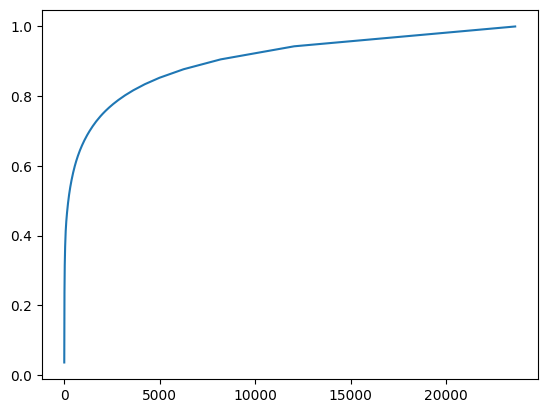

In [8]:
# sort counts by descending order and create a histogram of word covrege
counts = np.array(list(counter.values()))
counts = np.sort(counts)[::-1]
total_words = counts.sum()
counts = np.cumsum(counts)/total_words
from matplotlib import pyplot as plt
plt.plot(counts)
plt.show()

### Dataset

In [4]:
# choose 20000 most common words and create two way dictionaries
elements = counter.most_common(20000)
words_to_ids = {e[0]:i for e, i in zip(elements, range(len(elements)))}
words_to_ids['<UNK>'] = len(words_to_ids)
ids_to_words = {v:k for k, v in words_to_ids.items()}

In [5]:
import torch
convert_item = lambda x: { 'tokens': [words_to_ids.get(w, words_to_ids['<UNK>']) for w in x['tokens']] }
convert_item(dataset['train'][0])

{'tokens': [956, 11982, 232, 761, 5, 4146, 208, 6181, 0]}

In [6]:
# convert dataset to ids
for name in ['train', 'validation', 'test']:
    dataset[name] = dataset[name].map(convert_item, batched=False)

Loading cached processed dataset at /home/ronen/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/9a4d16a94f8674ba3466315300359b0acd891b68b6c8743ddf60b9c702adce98/cache-dd796fdc36945aad.arrow
Loading cached processed dataset at /home/ronen/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/9a4d16a94f8674ba3466315300359b0acd891b68b6c8743ddf60b9c702adce98/cache-40cb9ee1eec1d9d0.arrow
Loading cached processed dataset at /home/ronen/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/9a4d16a94f8674ba3466315300359b0acd891b68b6c8743ddf60b9c702adce98/cache-8d8b0dcd70f1d28d.arrow


In [7]:
dataset['train'][0]

{'tokens': tensor([  956, 11982,   232,   761,     5,  4146,   208,  6181,     0]),
 'ner_tags': tensor([3, 0, 7, 0, 0, 0, 7, 0, 0])}

In [7]:
from torch.nn.utils.rnn import pack_sequence
def collate_fn(batch):
    tokens = pack_sequence([ exmp['tokens'] for exmp in batch ], enforce_sorted=False)
    ner_tags = pack_sequence([ exmp['ner_tags'] for exmp in batch ], enforce_sorted=False)
    return tokens, ner_tags

#### build embedding matrix

In [8]:
# load glove
import gensim.downloader as api

model = api.load("glove-wiki-gigaword-300")

print("glove model loaded")

vectors = []
for id in range(len(words_to_ids)-1):
    try:
        vectors.append(model.get_vector(ids_to_words[id]))
    except KeyError:
        vectors.append(torch.zeros((300,)))
vectors.append(torch.zeros((300,)))

vectors = torch.tensor(vectors, dtype=torch.float)
vectors.shape

glove model loaded


/tmp/ipykernel_196952/3854162063.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  vectors = torch.tensor(vectors, dtype=torch.float)


torch.Size([20001, 300])

### Model

In [9]:
import torch.nn as nn
from torch.nn.utils.rnn import PackedSequence, pack_sequence, unpack_sequence
from collections import OrderedDict

class IMDBLangModel(nn.Module):
    def __init__(self, **kwargs) -> None:
        super().__init__()
        # dimentions of activation layers
        self.word_id_dict = kwargs['word_id_dict']
        self.id_word_dict = kwargs['id_word_dict']
        self.embeddings = kwargs['embeddings']
        self.token_count = len(self.word_id_dict)
        self.input_size = kwargs['embedding_dim']
        self.hidden_size = 2*kwargs['embedding_dim']
        self.num_layers = kwargs['num_layers']
        self.class_count = kwargs['class_count']

        # model layers
        embeddings = nn.Embedding.from_pretrained(self.embeddings, freeze=False)
        gru = nn.GRU(input_size=self.input_size,
                      hidden_size=self.hidden_size,
                      num_layers=self.num_layers,
                      bidirectional=True)
        
        ff = nn.Sequential(OrderedDict([
            (f"ff_1_{2*self.num_layers*self.hidden_size}_to_{2*self.hidden_size*self.num_layers}", 
            nn.Linear(in_features=2*self.num_layers*self.hidden_size,
                      out_features=2*self.hidden_size*self.num_layers)),
            (f"ff_relu_1",nn.ReLU6()),
            (f"ff_2_{2*self.num_layers*self.hidden_size}_to_{self.class_count}",
            nn.Linear(in_features=2*self.hidden_size*self.num_layers,
                      out_features=self.class_count))
        ]))

        # full model
        self.model = nn.ModuleDict({
            "embeddings":embeddings,
            "gru":gru,
            "ff":ff
        })

    def forward(self,x:PackedSequence):
        # apply embeddings
        x = unpack_sequence(x)
        embeddings = [self.model["embeddings"](xi) for xi in x]
        x = pack_sequence(embeddings,enforce_sorted=False)

        # feed gru with sequence
        output, c_n = self.model["gru"](x)
        
        # run a fully connected layer on prompt-layer embedding
        y_pred = [self.model["ff"](out) for out in unpack_sequence(output)] 
        
        return y_pred

### Trainer

In [10]:
output_path = 'logs_and_models'

In [11]:
from torch.utils.data import dataloader
from torch.optim import Adam
import torch
from torch.utils import tensorboard
from os.path import isfile
from torch import nn
import tqdm
import numpy as np
from typing import Callable

class Trainer():
    def __init__(self,model:nn.Module,train_dataset,val_dataset,test_dataset,
                train_sample_count: int, validation_sample_count: int, lr: float, 
                batch_size: int, test_batch_size: int, num_epochs: int, 
                model_file_name: str, loss_func: Callable, load_checkpoint: bool,
                workers: int, collate_fn: Callable = None):
      # save the model
      self.model = model
      
      # create data loaders
      self.train_loader = dataloader.DataLoader(
          train_dataset,batch_size,
          sampler=dataloader.RandomSampler(
                  train_dataset,
                  num_samples=train_sample_count
          ), 
          collate_fn=collate_fn,
          num_workers=workers
      )

      self.val_loader = dataloader.DataLoader(
          val_dataset,batch_size,
          sampler=dataloader.RandomSampler(
              val_dataset,
              num_samples=validation_sample_count
          ),
          collate_fn=collate_fn,
          num_workers=workers
      )

      self.test_loader = dataloader.DataLoader(
          test_dataset,
          test_batch_size,
          shuffle=False,
          collate_fn=collate_fn,
          num_workers=workers
      )

      # name to save logs and and model
      self.model_file = output_path + "/" +model_file_name
      
      # hyper parameters
      self.num_epochs = num_epochs
      self.optimizer = Adam(self.model.parameters(), lr=lr)
      self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
      self.loss_func = loss_func
      self.load_checkpoint = load_checkpoint
      self.train_sample_count = train_sample_count
      self.validation_sample_count = validation_sample_count
      self.test_count = len(test_dataset)//test_batch_size + \
        int(len(test_dataset)%test_batch_size>0)
      self.batch_size = batch_size

      # create log
      self.board = tensorboard.SummaryWriter(self.model_file)
      self.model_file = self.model_file + ".pkl"
      
      
    def train_one_epoch(self,epoch,total_train, test_func) -> float:
      train_loss_list =[]
      metric_list = []
      for idx, (x,y) in tqdm.tqdm(enumerate(self.train_loader),
          desc=f"epoch num {epoch+1}",total=total_train):

          # predict
          x = x.to(self.device)
          y = y.to(self.device)
          y_pred = self.model(x)
          
          # backward pass
          loss = self.loss_func(y_pred,y)
          loss.backward()
          self.optimizer.step()
          self.optimizer.zero_grad()

          # test metric on train
          metric = test_func(y_pred,y)
          metric_list.append(float(metric))
          self.board.add_scalar(f"train_metric", float(metric), 
                                global_step=epoch*total_train+idx)
          
          # add batch loss to list
          train_loss_list.append(float(loss))
          self.board.add_scalar(f"train_loss",float(loss),
                                global_step=epoch*total_train+idx)
          del x,y,loss,y_pred
          torch.cuda.empty_cache()
      
      return float(np.mean(train_loss_list)), float(np.mean(metric_list))        

    
    def val_one_epoch(self,epoch,total_val, test_func) -> float:
      val_loss_list = []
      metric_list = []
      with torch.no_grad():
          for idx, (x,y) in tqdm.tqdm(enumerate(self.val_loader),
              desc=f"epoch num {epoch+1}",total=total_val):
              
              # predict
              x = x.to(self.device)
              y = y.to(self.device)
              y_pred = self.model(x)
              
              # calc loss
              val_loss = self.loss_func(y_pred,y)

              # calc metric
              metric = test_func(y_pred,y)
              metric_list.append(float(metric))
              self.board.add_scalar(f"val_metric", float(metric), 
                                global_step=epoch*total_val+idx)
              
              # log loss result
              val_loss_list.append(float(val_loss))
              self.board.add_scalar(f"val_loss",float(val_loss),
                                    global_step=epoch*total_val+idx)
              del x,y,val_loss,y_pred
              torch.cuda.empty_cache()
      return  float(np.mean(val_loss_list)), float(np.mean(metric_list))

    
    def test_epoch(self,total_test, func) -> list[tuple]:
      self.model = self.model.eval()
      prediction_dict = []
      with torch.no_grad():
        for idx, (x,y) in tqdm.tqdm(enumerate(self.test_loader),
          desc="test",total=total_test):

          # predict
          x:torch.Tensor = x.to(self.device)
          y = y.to(self.device)
          y_pred = self.model(x)
          prediction_dict.append(func(y_pred,y))
          del x,y,y_pred
          torch.cuda.empty_cache()
      return prediction_dict

    
    def full_train(self, test_func):
        total_train = self.train_sample_count//self.batch_size + \
                    int(self.train_sample_count%self.batch_size!=0)
        total_val = self.validation_sample_count//self.batch_size + \
                    int(self.validation_sample_count%self.batch_size!=0)

        # save model initiallization/ load model from checkpoint
        if not self.load_checkpoint or not isfile(self.model_file):
            torch.save(
                (
                    self.model.state_dict(),
                    self.model.word_id_dict,
                    self.model.id_word_dict
                ),
                self.model_file
            )
        else:
            state_dict, \
            self.model.word_id_dict, \
            self.model.id_word_dict = torch.load(self.model_file)
            print(self.model.load_state_dict(state_dict))

        # we save on minimum validation loss
        min_val_loss = 100
        self.model.train()
        self.model = self.model.to(self.device)
        for epoch in range(self.num_epochs):
          epoch_train_loss, epoch_train_metric = self.train_one_epoch(epoch,total_train, test_func)
          epoch_val_loss, epoch_val_metric = self.val_one_epoch(epoch,total_val, test_func)
          if epoch_val_loss < min_val_loss:
            min_val_loss = epoch_val_loss
            torch.save(
                (
                    self.model.state_dict(),
                    self.model.word_id_dict,
                    self.model.id_word_dict
                ),
                self.model_file
            )
          print(f"epoch {epoch+1}/{self.num_epochs} loss: {epoch_train_loss} metric: {epoch_train_metric} val_loss: {epoch_val_loss} val_metric: {epoch_val_metric}")
        return self.test_epoch(self.test_count, test_func)


### Training

In [12]:
def accuracy(y_pred, y):
    y = unpack_sequence(y)
    accuracy_list = []
    for pred, label in zip(y_pred, y):
        accuracy_list.append(torch.sum(pred.argmax(dim=-1) == label)/len(label))
    return torch.mean(torch.stack(accuracy_list)).item()

In [13]:
import numpy as np

train_dataset, validation_dataset, test_dataset = dataset['train'], dataset['validation'], dataset['test']

print(f"train: {len(train_dataset)}, val: {len(validation_dataset)}, test: {len(test_dataset)}")

# create model
model = IMDBLangModel(embeddings = vectors,
                    word_id_dict=words_to_ids, 
                    id_word_dict=ids_to_words, 
                    embedding_dim=300, 
                    num_layers=1,
                    class_count = 9)

print("model created")

base_loss = nn.CrossEntropyLoss()
def loss_func(y_pred, y):
    y = unpack_sequence(y)
    loss_list = []
    for examp in range(len(y)):
        sent_loss_list = []
        for pred,label in zip(y_pred[examp],y[examp]):
           sent_loss_list.append(base_loss(pred,label))
        loss_list.append(torch.mean(torch.stack(sent_loss_list)))
    return torch.mean(torch.stack(loss_list))

# create trainer
trainer = Trainer(model=model,
                train_dataset=train_dataset, 
                val_dataset=validation_dataset, 
                test_dataset=test_dataset,
                train_sample_count=len(train_dataset), 
                validation_sample_count=len(validation_dataset),
                lr=1e-3, 
                batch_size=256,
                test_batch_size=2, 
                num_epochs=0, 
                model_file_name="ner_300_scratch_training", 
                loss_func=loss_func, 
                load_checkpoint=True,
                workers=1,
                collate_fn=collate_fn)

print("trainer created")

prediction = trainer.full_train(accuracy)
print()
print(f"model accuracy is: {np.mean(prediction)}")

train: 14041, val: 3250, test: 3453
model created
trainer created
<All keys matched successfully>


test: 100%|██████████| 1727/1727 [00:07<00:00, 245.58it/s]


model accuracy is: 0.9282798616266278


### Evaluation

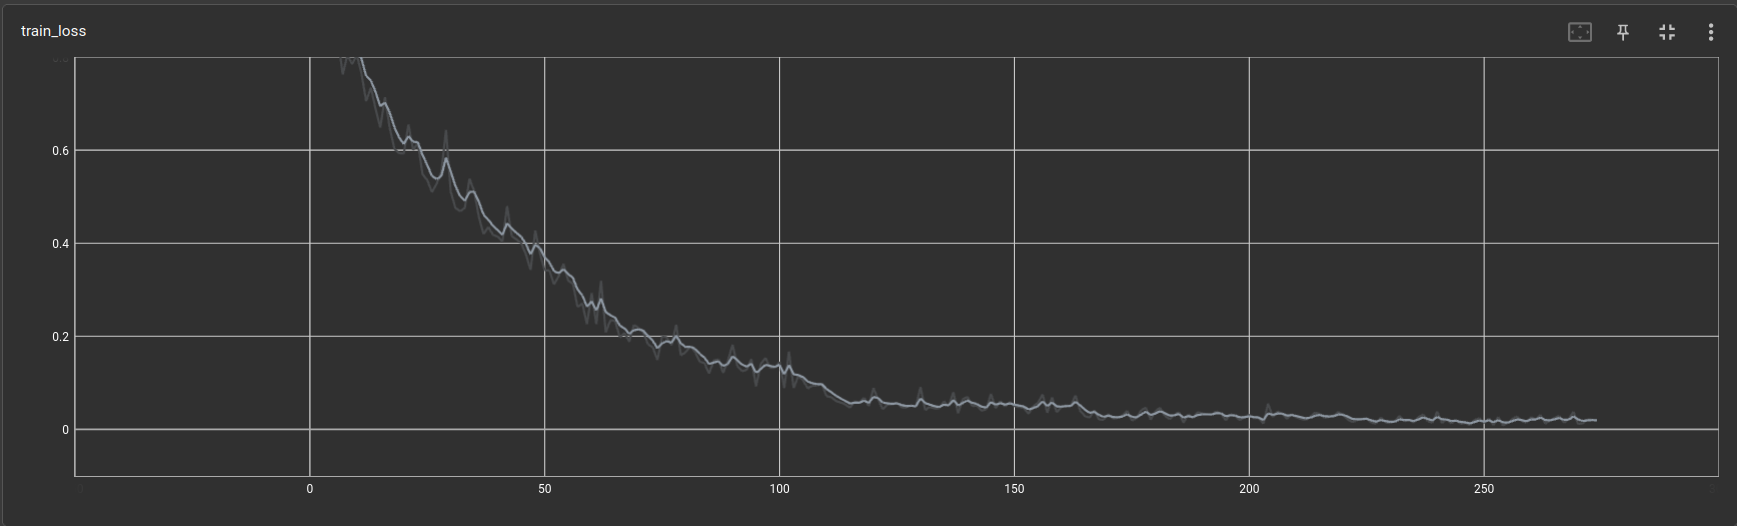

In [18]:
from PIL import Image
Image.open("logs_and_models/ner_300_scratch_training_train_loss.png")

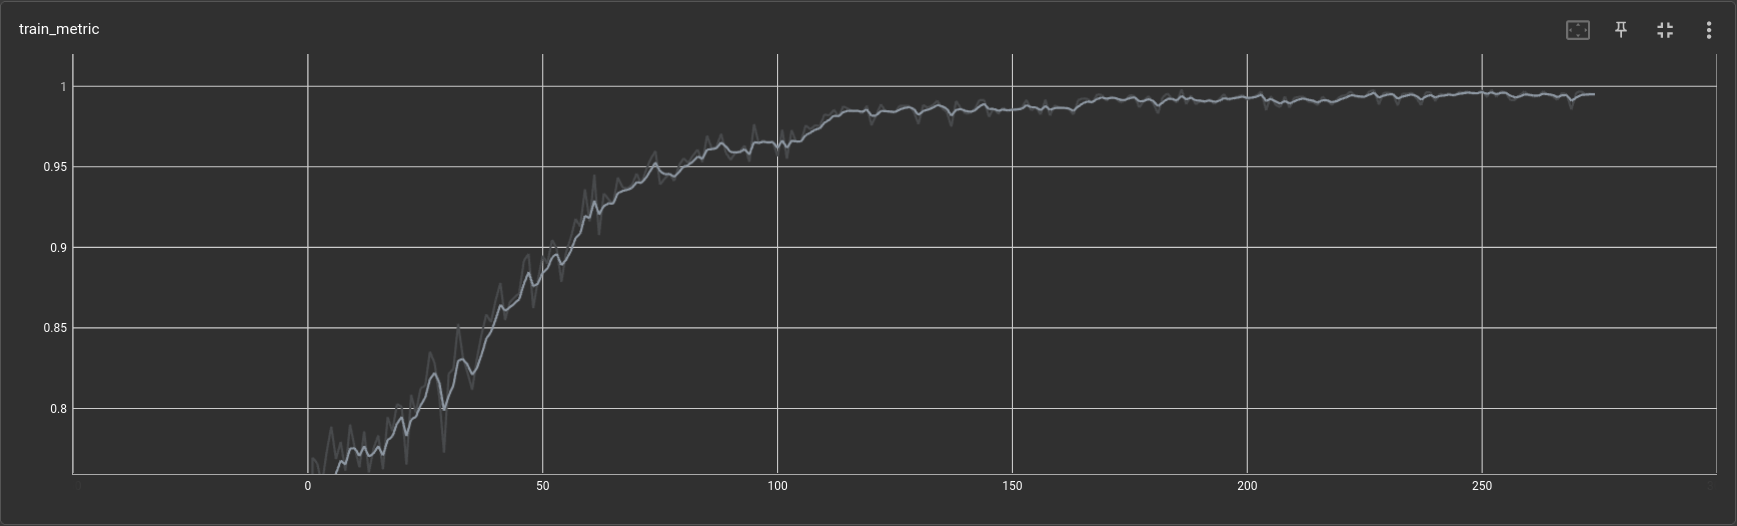

In [19]:
from PIL import Image
Image.open("logs_and_models/ner_300_scratch_training_train_accuracy.png")

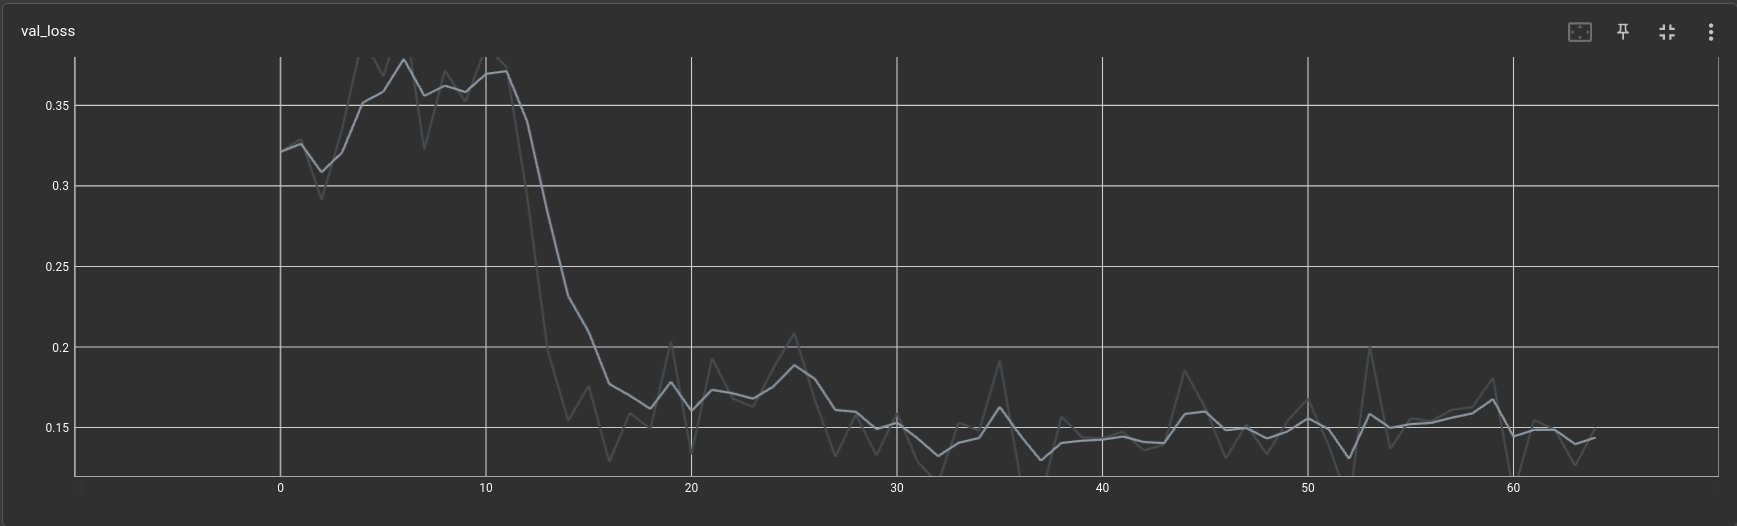

In [20]:
from PIL import Image
Image.open("logs_and_models/ner_300_scratch_training_val_loss.png")

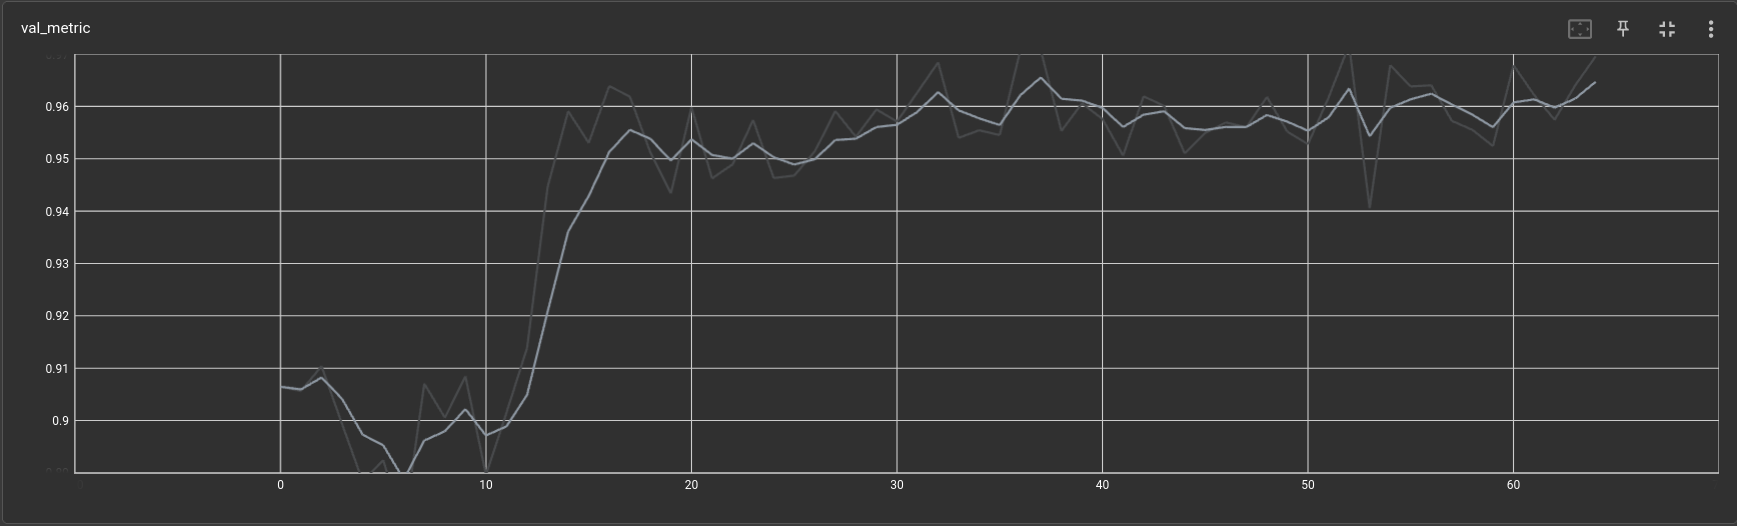

In [21]:
from PIL import Image
Image.open("logs_and_models/ner_300_scratch_training_val_accuracy.png")

### Metrics

In [14]:
def test_func(y_pred,y):
    y = unpack_sequence(y)
    return y, y_pred

In [16]:
from sklearn.metrics import confusion_matrix
results = trainer.test_epoch(trainer.test_count, test_func)

y = [pred.cpu() for result in results for sentence in result[0] for pred in sentence]
y_pred = [pred.argmax().cpu() for result in results for sentence in result[1] for pred in sentence]
print(y[0], y_pred[0])

test:   0%|          | 0/1727 [00:00<?, ?it/s]

test: 100%|██████████| 1727/1727 [00:07<00:00, 224.30it/s]


tensor(0) tensor(0)


In [31]:
import matplotlib.pyplot as plt
cm = confusion_matrix(y, y_pred)
cm

array([[37801,   111,    76,    86,    55,    75,    10,    52,    57],
       [  271,  1255,    23,    30,     3,    24,     2,     9,     0],
       [  241,    17,   882,     1,     9,     1,     3,     0,     2],
       [  285,    66,     0,  1180,    28,    75,     0,    26,     1],
       [  126,     4,    48,    30,   589,     4,    16,     3,    15],
       [  145,    25,     3,    62,     1,  1415,     3,    13,     1],
       [   44,     1,     9,     0,    32,     1,   167,     0,     3],
       [  169,    23,     0,    30,     2,    16,     1,   455,     6],
       [   51,     0,     7,     1,     4,     0,     2,    27,   124]])

In [36]:
cm = cm / cm.sum(axis=-1, keepdims=True)

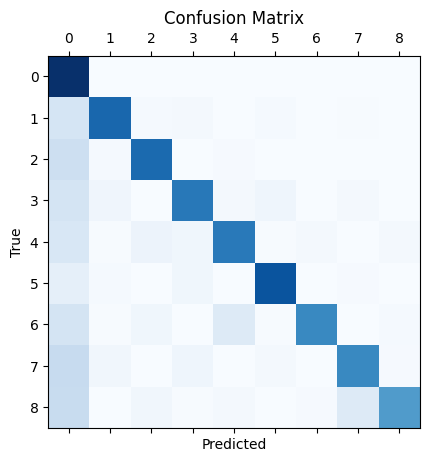

In [37]:
# Print the confusion matrix
plt.matshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Confusion matrix looks great, so no tuning is required.

## Part II

code in this part is largly taken from: \
[Named Entity Recognition with Deep Learning (BERT) — The Essential Guide](https://towardsdatascience.com/named-entity-recognition-with-deep-learning-bert-the-essential-guide-274c6965e2d)

### Dataset


In [6]:
model_name = "bert-base-cased"

We chose this pretrained model because bert is a good base model for NER, even appearing in the original paper. \
the cased version is suitable for NER because many NERs are upper case

In [7]:
def load_tokenizer():
    from transformers import AutoTokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    return tokenizer

In [8]:
tokenizer = load_tokenizer()
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)

    labels = []
    for i, label in enumerate(examples[f"ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Map tokens to their respective word.
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:  # Set the special tokens to -100.
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:  # Only label the first token of a given word.
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [9]:
import numpy as np
def load_dataset(k):
    from datasets import load_dataset

    dataset = load_dataset("conll2003")

    # select random k% indices
    indices = np.random.choice(len(dataset["train"]), len(dataset['train'])*k//100, replace=False)

    dataset['train'] = dataset['train'].select(indices)
    # convert dataset to ids
    for name in ['train', 'validation', 'test']:
        dataset[name] = dataset[name].map(tokenize_and_align_labels, batched=True)
    return dataset

In [10]:
dataset = load_dataset(1)

Found cached dataset conll2003 (/home/ronen/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/9a4d16a94f8674ba3466315300359b0acd891b68b6c8743ddf60b9c702adce98)
100%|██████████| 3/3 [00:00<00:00, 122.22it/s]
Loading cached processed dataset at /home/ronen/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/9a4d16a94f8674ba3466315300359b0acd891b68b6c8743ddf60b9c702adce98/cache-6b40c29a6848521b.arrow
Loading cached processed dataset at /home/ronen/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/9a4d16a94f8674ba3466315300359b0acd891b68b6c8743ddf60b9c702adce98/cache-437cb2368803ba37.arrow


In [11]:
print()
print("dataset size:",str(len(dataset['train'])),"example", dataset["train"][0])


dataset size: 140 example {'id': '5233', 'tokens': ['Played', 'Friday', ':'], 'pos_tags': [22, 22, 8], 'chunk_tags': [11, 12, 0], 'ner_tags': [0, 0, 0], 'input_ids': [101, 21433, 5286, 131, 102], 'token_type_ids': [0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1], 'labels': [-100, 0, 0, 0, -100]}


### Model

In [12]:
label_list = dataset["train"].features["ner_tags"].feature.names
label_list

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']

In [13]:
from transformers import DataCollatorForTokenClassification
from transformers import AutoModelForTokenClassification
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

def reload_model():
    return AutoModelForTokenClassification.from_pretrained(model_name, num_labels=len(label_list))

In [14]:
from datasets import load_metric
metric_seqeval = load_metric("seqeval")
example = dataset["train"][0]

labels = [label_list[i] for i in example["ner_tags"]]
metric_seqeval.compute(predictions=[labels], references=[labels])

/tmp/ipykernel_19175/3224873647.py:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric_seqeval = load_metric("seqeval")
/home/ronen/Documents/college/NNForNLP/workshop_1/.conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ronen/Documents/college/NNForNLP/workshop_1/.conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ronen/Documents/college/NNForNLP/workshop_1/.conda/li

{'overall_precision': 0.0,
 'overall_recall': 0.0,
 'overall_f1': 0.0,
 'overall_accuracy': 1.0}

In [15]:
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric_seqeval.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

### Trainer

In [16]:
from transformers import EarlyStoppingCallback
from transformers import TrainingArguments
from transformers import Trainer

def reload_trainer(log_dir, dataset, model):

    training_args = TrainingArguments(
        output_dir=log_dir,
        num_train_epochs=5,
        learning_rate=2e-5,
        per_device_train_batch_size=16,   
        per_device_eval_batch_size=64,
        weight_decay=0.01,
        warmup_steps=0, 
        eval_steps=1,
        logging_steps=1,
        save_steps=10,
        evaluation_strategy="steps",
        load_best_model_at_end=True
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=dataset['train'],
        eval_dataset=dataset["validation"],
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
        callbacks = [EarlyStoppingCallback(early_stopping_patience = 6)]
    )
    return trainer

### Evaluation


In [17]:
def output_confusion_matrix(true_labels, true_predictions):
    true_labels = [label for lst in true_labels for label in lst]
    true_predictions = [label for lst in true_predictions for label in lst]
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(true_labels, true_predictions)
    cm = cm / cm.sum(axis=-1, keepdims=True)
    import matplotlib.pyplot as plt

    # Print the confusion matrix
    plt.matshow(cm, cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

In [18]:
def eval(trainer, dataset):
    predictions, labels, _ = trainer.predict(dataset["test"])
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric_seqeval.compute(predictions=true_predictions, references=true_labels)

    output_confusion_matrix(true_labels, true_predictions)
    return results

In [19]:
import pandas as pd
def pretty_print(results:dict):
    overall = {
        'overall_precision': [results['overall_precision']],
        'overall_recall': [results['overall_recall']],
        'overall_f1': [results['overall_f1']],
        'overall_accuracy': [results['overall_accuracy']]
    }
    print(pd.DataFrame(overall))

    print()

    del results['overall_accuracy']
    del results['overall_f1']
    del results['overall_recall']
    del results['overall_precision']

    print(pd.DataFrame(results))    

---------------------------------------------------
starting run on training set of 1%



Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['cl

{'eval_loss': 2.324366569519043, 'eval_precision': 0.015128077397026821, 'eval_recall': 0.1021600566572238, 'eval_f1': 0.02635365046016123, 'eval_accuracy': 0.03452137396360504, 'eval_runtime': 7.0219, 'eval_samples_per_second': 491.745, 'eval_steps_per_second': 7.69, 'epoch': 0.11}


                                              
  7%|▋         | 3/45 [00:15<04:03,  5.80s/it] 

{'eval_loss': 2.3202977180480957, 'eval_precision': 0.015166224974416834, 'eval_recall': 0.1023371104815864, 'eval_f1': 0.026417422701615668, 'eval_accuracy': 0.035296651232906213, 'eval_runtime': 7.0841, 'eval_samples_per_second': 487.426, 'eval_steps_per_second': 7.623, 'epoch': 0.22}


                                              
  9%|▉         | 4/45 [00:22<04:19,  6.34s/it] 

{'eval_loss': 2.312368154525757, 'eval_precision': 0.015112489486963835, 'eval_recall': 0.10180594900849858, 'eval_f1': 0.026318198462101795, 'eval_accuracy': 0.03673952837299451, 'eval_runtime': 7.0778, 'eval_samples_per_second': 487.862, 'eval_steps_per_second': 7.629, 'epoch': 0.33}


                                              
 11%|█         | 5/45 [00:29<04:26,  6.66s/it] 

{'eval_loss': 2.3005964756011963, 'eval_precision': 0.015085183817711905, 'eval_recall': 0.10127478753541076, 'eval_f1': 0.02625900931919387, 'eval_accuracy': 0.03964681813287391, 'eval_runtime': 7.1073, 'eval_samples_per_second': 485.838, 'eval_steps_per_second': 7.598, 'epoch': 0.44}


                                              
 13%|█▎        | 6/45 [00:37<04:30,  6.93s/it] 

{'eval_loss': 2.2848727703094482, 'eval_precision': 0.015013901760889712, 'eval_recall': 0.10038951841359774, 'eval_f1': 0.026121207933107595, 'eval_accuracy': 0.04345859804027135, 'eval_runtime': 7.3459, 'eval_samples_per_second': 470.056, 'eval_steps_per_second': 7.351, 'epoch': 0.56}


                                              
 16%|█▌        | 7/45 [00:44<04:30,  7.11s/it] 

{'eval_loss': 2.265406847000122, 'eval_precision': 0.014912654452492544, 'eval_recall': 0.09915014164305949, 'eval_f1': 0.02592592592592593, 'eval_accuracy': 0.048971680844190804, 'eval_runtime': 7.3819, 'eval_samples_per_second': 467.763, 'eval_steps_per_second': 7.315, 'epoch': 0.67}


                                              
 18%|█▊        | 8/45 [00:52<04:27,  7.22s/it] 

{'eval_loss': 2.24186635017395, 'eval_precision': 0.014892072793742104, 'eval_recall': 0.09808781869688385, 'eval_f1': 0.025858246400149363, 'eval_accuracy': 0.05698287929363627, 'eval_runtime': 7.3357, 'eval_samples_per_second': 470.709, 'eval_steps_per_second': 7.361, 'epoch': 0.78}


                                              
 20%|██        | 9/45 [00:59<04:17,  7.16s/it] 

{'eval_loss': 2.2147321701049805, 'eval_precision': 0.014904632152588556, 'eval_recall': 0.0968484419263456, 'eval_f1': 0.025833569471993955, 'eval_accuracy': 0.06815979325939485, 'eval_runtime': 6.9414, 'eval_samples_per_second': 497.448, 'eval_steps_per_second': 7.779, 'epoch': 0.89}


                                              
 22%|██▏       | 10/45 [01:06<04:10,  7.15s/it]

{'eval_loss': 2.1839749813079834, 'eval_precision': 0.014557701942882592, 'eval_recall': 0.09259915014164306, 'eval_f1': 0.025159955741569248, 'eval_accuracy': 0.0858834930548078, 'eval_runtime': 7.0144, 'eval_samples_per_second': 492.272, 'eval_steps_per_second': 7.698, 'epoch': 1.0}


                                               
 22%|██▏       | 10/45 [01:13<04:10,  7.15s/it]

{'eval_loss': 2.1501121520996094, 'eval_precision': 0.014609035746124866, 'eval_recall': 0.08994334277620397, 'eval_f1': 0.0251354493951164, 'eval_accuracy': 0.11293205556153764, 'eval_runtime': 7.0006, 'eval_samples_per_second': 493.246, 'eval_steps_per_second': 7.714, 'epoch': 1.11}


                                               
 27%|██▋       | 12/45 [01:21<03:59,  7.26s/it]

{'eval_loss': 2.112386465072632, 'eval_precision': 0.014323784143904063, 'eval_recall': 0.08374645892351275, 'eval_f1': 0.024463408326868375, 'eval_accuracy': 0.1514374932701626, 'eval_runtime': 6.8568, 'eval_samples_per_second': 503.584, 'eval_steps_per_second': 7.875, 'epoch': 1.22}


                                               
 29%|██▉       | 13/45 [01:28<03:49,  7.17s/it]

{'eval_loss': 2.071032762527466, 'eval_precision': 0.014355788096795292, 'eval_recall': 0.07772662889518414, 'eval_f1': 0.024235398034669318, 'eval_accuracy': 0.20488855389253796, 'eval_runtime': 6.8663, 'eval_samples_per_second': 502.89, 'eval_steps_per_second': 7.864, 'epoch': 1.33}


                                               
 31%|███       | 14/45 [01:35<03:41,  7.15s/it]

{'eval_loss': 2.02634334564209, 'eval_precision': 0.013644446057263128, 'eval_recall': 0.06657223796033994, 'eval_f1': 0.022647191687998794, 'eval_accuracy': 0.2715623990524389, 'eval_runtime': 6.9879, 'eval_samples_per_second': 494.141, 'eval_steps_per_second': 7.728, 'epoch': 1.44}


                                               
 33%|███▎      | 15/45 [01:42<03:33,  7.11s/it]

{'eval_loss': 1.9772305488586426, 'eval_precision': 0.013251440831264987, 'eval_recall': 0.05577195467422096, 'eval_f1': 0.021414731975933923, 'eval_accuracy': 0.35197588026273285, 'eval_runtime': 6.9142, 'eval_samples_per_second': 499.409, 'eval_steps_per_second': 7.81, 'epoch': 1.56}


                                               
 36%|███▌      | 16/45 [01:49<03:25,  7.08s/it]

{'eval_loss': 1.9239461421966553, 'eval_precision': 0.012950593993779637, 'eval_recall': 0.044971671388101986, 'eval_f1': 0.020110051066861964, 'eval_accuracy': 0.43977603101109075, 'eval_runtime': 6.8979, 'eval_samples_per_second': 500.587, 'eval_steps_per_second': 7.828, 'epoch': 1.67}


                                               
 38%|███▊      | 17/45 [01:56<03:17,  7.04s/it]

{'eval_loss': 1.866796612739563, 'eval_precision': 0.013183785911058638, 'eval_recall': 0.03558781869688385, 'eval_f1': 0.019239973198047287, 'eval_accuracy': 0.5300096909658663, 'eval_runtime': 6.8505, 'eval_samples_per_second': 504.051, 'eval_steps_per_second': 7.883, 'epoch': 1.78}


                                               
 40%|████      | 18/45 [02:03<03:11,  7.08s/it]

{'eval_loss': 1.805784821510315, 'eval_precision': 0.014180577993178962, 'eval_recall': 0.027974504249291786, 'eval_f1': 0.018820726622989874, 'eval_accuracy': 0.6121890815117906, 'eval_runtime': 7.0936, 'eval_samples_per_second': 486.777, 'eval_steps_per_second': 7.612, 'epoch': 1.89}


                                               
 42%|████▏     | 19/45 [02:10<03:04,  7.09s/it]

{'eval_loss': 1.7405409812927246, 'eval_precision': 0.014784230154501865, 'eval_recall': 0.019652974504249292, 'eval_f1': 0.01687442991790818, 'eval_accuracy': 0.6834069128889846, 'eval_runtime': 7.0129, 'eval_samples_per_second': 492.381, 'eval_steps_per_second': 7.7, 'epoch': 2.0}


                                               
 44%|████▍     | 20/45 [02:17<02:57,  7.10s/it]

{'eval_loss': 1.6721676588058472, 'eval_precision': 0.016785022595222725, 'eval_recall': 0.013810198300283285, 'eval_f1': 0.015152986886838271, 'eval_accuracy': 0.7387961666846129, 'eval_runtime': 7.0146, 'eval_samples_per_second': 492.259, 'eval_steps_per_second': 7.698, 'epoch': 2.11}


                                               
 44%|████▍     | 20/45 [02:24<02:57,  7.10s/it]

{'eval_loss': 1.6006851196289062, 'eval_precision': 0.024489795918367346, 'eval_recall': 0.011685552407932011, 'eval_f1': 0.015821646889608052, 'eval_accuracy': 0.776720146441262, 'eval_runtime': 6.9988, 'eval_samples_per_second': 493.374, 'eval_steps_per_second': 7.716, 'epoch': 2.22}


                                               
 49%|████▉     | 22/45 [02:32<02:47,  7.29s/it]

{'eval_loss': 1.527569055557251, 'eval_precision': 0.024135681669928244, 'eval_recall': 0.006550991501416431, 'eval_f1': 0.01030497145244395, 'eval_accuracy': 0.798191019704964, 'eval_runtime': 6.9666, 'eval_samples_per_second': 495.652, 'eval_steps_per_second': 7.751, 'epoch': 2.33}


                                               
 51%|█████     | 23/45 [02:39<02:37,  7.17s/it]

{'eval_loss': 1.4527688026428223, 'eval_precision': 0.02902055622732769, 'eval_recall': 0.00424929178470255, 'eval_f1': 0.007413127413127413, 'eval_accuracy': 0.8112199849251642, 'eval_runtime': 6.7892, 'eval_samples_per_second': 508.599, 'eval_steps_per_second': 7.954, 'epoch': 2.44}


                                               
 53%|█████▎    | 24/45 [02:46<02:28,  7.09s/it]

{'eval_loss': 1.3775713443756104, 'eval_precision': 0.034912718204488775, 'eval_recall': 0.002478753541076487, 'eval_f1': 0.004628864275086791, 'eval_accuracy': 0.8188650802196619, 'eval_runtime': 6.7919, 'eval_samples_per_second': 508.401, 'eval_steps_per_second': 7.951, 'epoch': 2.56}


                                               
 56%|█████▌    | 25/45 [02:53<02:21,  7.07s/it]

{'eval_loss': 1.3019849061965942, 'eval_precision': 0.050314465408805034, 'eval_recall': 0.00141643059490085, 'eval_f1': 0.00275529533321853, 'eval_accuracy': 0.8228922149240875, 'eval_runtime': 6.9121, 'eval_samples_per_second': 499.557, 'eval_steps_per_second': 7.812, 'epoch': 2.67}


                                               
 58%|█████▊    | 26/45 [03:00<02:14,  7.09s/it]

{'eval_loss': 1.2275854349136353, 'eval_precision': 0.047619047619047616, 'eval_recall': 0.0005311614730878187, 'eval_f1': 0.0010506040973559797, 'eval_accuracy': 0.8244643049423926, 'eval_runtime': 7.0248, 'eval_samples_per_second': 491.545, 'eval_steps_per_second': 7.687, 'epoch': 2.78}


                                               
 60%|██████    | 27/45 [03:07<02:07,  7.11s/it]

{'eval_loss': 1.1556100845336914, 'eval_precision': 0.03571428571428571, 'eval_recall': 0.00017705382436260624, 'eval_f1': 0.00035236081747709656, 'eval_accuracy': 0.8248950145364488, 'eval_runtime': 7.073, 'eval_samples_per_second': 488.197, 'eval_steps_per_second': 7.635, 'epoch': 2.89}


/home/ronen/Documents/college/NNForNLP/workshop_1/.conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
                                               
 62%|██████▏   | 28/45 [03:15<02:02,  7.19s/it]

{'eval_loss': 1.088070034980774, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8251965112522881, 'eval_runtime': 7.2679, 'eval_samples_per_second': 475.105, 'eval_steps_per_second': 7.43, 'epoch': 3.0}


                                               
 64%|██████▍   | 29/45 [03:22<01:55,  7.20s/it]

{'eval_loss': 1.02595055103302, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.825218046731991, 'eval_runtime': 7.1433, 'eval_samples_per_second': 483.388, 'eval_steps_per_second': 7.559, 'epoch': 3.11}


                                               
 67%|██████▋   | 30/45 [03:29<01:48,  7.20s/it]

{'eval_loss': 0.9699995517730713, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8252611176913965, 'eval_runtime': 7.098, 'eval_samples_per_second': 486.475, 'eval_steps_per_second': 7.608, 'epoch': 3.22}


                                               
 67%|██████▋   | 30/45 [03:36<01:48,  7.20s/it]

{'eval_loss': 0.9216439127922058, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8252611176913965, 'eval_runtime': 7.0811, 'eval_samples_per_second': 487.639, 'eval_steps_per_second': 7.626, 'epoch': 3.33}


 69%|██████▉   | 31/45 [03:38<01:46,  7.64s/it]/home/ronen/Documents/college/NNForNLP/workshop_1/.conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ronen/Documents/college/NNForNLP/workshop_1/.conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
                                               
 71%|███████   | 32/45 [03:45<01:37,  7.50s/it]

{'eval_loss': 0.8815740346908569, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 7.0882, 'eval_samples_per_second': 487.147, 'eval_steps_per_second': 7.618, 'epoch': 3.44}


                                               
 73%|███████▎  | 33/45 [03:52<01:28,  7.35s/it]

{'eval_loss': 0.8512672185897827, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.8929, 'eval_samples_per_second': 500.947, 'eval_steps_per_second': 7.834, 'epoch': 3.56}


                                               
 76%|███████▌  | 34/45 [03:59<01:19,  7.24s/it]

{'eval_loss': 0.8285394906997681, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.861, 'eval_samples_per_second': 503.278, 'eval_steps_per_second': 7.871, 'epoch': 3.67}


                                               
 78%|███████▊  | 35/45 [04:06<01:11,  7.20s/it]

{'eval_loss': 0.8115562200546265, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 7.0192, 'eval_samples_per_second': 491.934, 'eval_steps_per_second': 7.693, 'epoch': 3.78}


                                               
 80%|████████  | 36/45 [04:13<01:04,  7.21s/it]

{'eval_loss': 0.7955688238143921, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 7.1773, 'eval_samples_per_second': 481.101, 'eval_steps_per_second': 7.524, 'epoch': 3.89}


                                               
 82%|████████▏ | 37/45 [04:21<00:57,  7.22s/it]

{'eval_loss': 0.7803699374198914, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 7.1311, 'eval_samples_per_second': 484.219, 'eval_steps_per_second': 7.572, 'epoch': 4.0}


                                               
 84%|████████▍ | 38/45 [04:28<00:50,  7.21s/it]

{'eval_loss': 0.7630106806755066, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 7.0958, 'eval_samples_per_second': 486.625, 'eval_steps_per_second': 7.61, 'epoch': 4.11}


                                               
 87%|████████▋ | 39/45 [04:35<00:43,  7.19s/it]

{'eval_loss': 0.746199369430542, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 7.0642, 'eval_samples_per_second': 488.806, 'eval_steps_per_second': 7.644, 'epoch': 4.22}


                                               
 89%|████████▉ | 40/45 [04:42<00:35,  7.14s/it]

{'eval_loss': 0.7262036800384521, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.9073, 'eval_samples_per_second': 499.909, 'eval_steps_per_second': 7.818, 'epoch': 4.33}


                                               
 89%|████████▉ | 40/45 [04:49<00:35,  7.14s/it]

{'eval_loss': 0.7032750844955444, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 7.076, 'eval_samples_per_second': 487.989, 'eval_steps_per_second': 7.631, 'epoch': 4.44}


 91%|█████████ | 41/45 [04:52<00:31,  7.89s/it]/home/ronen/Documents/college/NNForNLP/workshop_1/.conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ronen/Documents/college/NNForNLP/workshop_1/.conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
                                               
 93%|█████████▎| 42/45 [04:59<00:23,  7.71s/it]

{'eval_loss': 0.6792101263999939, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 7.2001, 'eval_samples_per_second': 479.577, 'eval_steps_per_second': 7.5, 'epoch': 4.56}


                                               
 96%|█████████▌| 43/45 [05:06<00:14,  7.50s/it]

{'eval_loss': 0.6563938856124878, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.8956, 'eval_samples_per_second': 500.753, 'eval_steps_per_second': 7.831, 'epoch': 4.67}


                                               
 98%|█████████▊| 44/45 [05:13<00:07,  7.36s/it]

{'eval_loss': 0.6366739273071289, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.907, 'eval_samples_per_second': 499.926, 'eval_steps_per_second': 7.818, 'epoch': 4.78}


                                               
100%|██████████| 45/45 [05:20<00:00,  7.27s/it]

{'eval_loss': 0.6201408505439758, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.9813, 'eval_samples_per_second': 494.605, 'eval_steps_per_second': 7.735, 'epoch': 4.89}


                                               
100%|██████████| 45/45 [05:27<00:00,  7.27s/it]

{'eval_loss': 0.6059309840202332, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 7.1001, 'eval_samples_per_second': 486.33, 'eval_steps_per_second': 7.606, 'epoch': 5.0}


100%|██████████| 45/45 [05:28<00:00,  7.30s/it]


{'train_runtime': 328.2832, 'train_samples_per_second': 2.132, 'train_steps_per_second': 0.137, 'train_loss': 1.4634078979492187, 'epoch': 5.0}


100%|██████████| 54/54 [00:06<00:00,  7.86it/s]


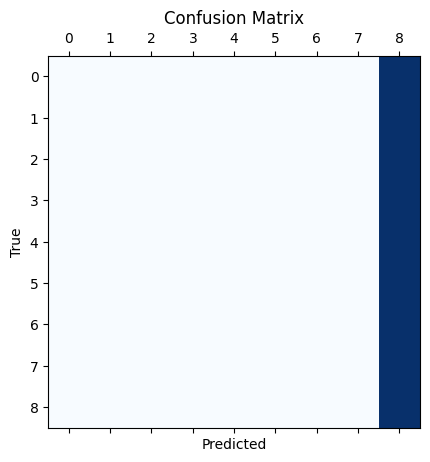

   overall_precision  overall_recall  overall_f1  overall_accuracy
0                0.0             0.0         0.0          0.825304

              LOC   MISC     ORG     PER
precision     0.0    0.0     0.0     0.0
recall        0.0    0.0     0.0     0.0
f1            0.0    0.0     0.0     0.0
number     1668.0  702.0  1661.0  1617.0

end of run
---------------------------------------------------
---------------------------------------------------
starting run on training set of 3%



Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['cl

{'eval_loss': 2.1913750171661377, 'eval_precision': 0.020158366447196683, 'eval_recall': 0.12305240793201133, 'eval_f1': 0.034641744548286606, 'eval_accuracy': 0.09587595563691181, 'eval_runtime': 7.2212, 'eval_samples_per_second': 478.172, 'eval_steps_per_second': 7.478, 'epoch': 0.04}



  2%|▏         | 3/135 [00:14<12:38,  5.75s/it]

{'eval_loss': 2.18780779838562, 'eval_precision': 0.020282854149691536, 'eval_recall': 0.12340651558073655, 'eval_f1': 0.03483954813555933, 'eval_accuracy': 0.09919241951114462, 'eval_runtime': 7.2713, 'eval_samples_per_second': 474.879, 'eval_steps_per_second': 7.426, 'epoch': 0.07}



  3%|▎         | 4/135 [00:22<13:57,  6.39s/it]

{'eval_loss': 2.1807897090911865, 'eval_precision': 0.020233075661747483, 'eval_recall': 0.12234419263456091, 'eval_f1': 0.034723618090452255, 'eval_accuracy': 0.10500699903090341, 'eval_runtime': 7.2752, 'eval_samples_per_second': 474.625, 'eval_steps_per_second': 7.422, 'epoch': 0.11}



  4%|▎         | 5/135 [00:29<14:40,  6.78s/it]

{'eval_loss': 2.170175075531006, 'eval_precision': 0.02041360511969661, 'eval_recall': 0.12199008498583569, 'eval_f1': 0.034974619289340106, 'eval_accuracy': 0.11607623559814795, 'eval_runtime': 7.3496, 'eval_samples_per_second': 469.821, 'eval_steps_per_second': 7.347, 'epoch': 0.15}



  4%|▍         | 6/135 [00:37<14:57,  6.96s/it]

{'eval_loss': 2.155961513519287, 'eval_precision': 0.020308692120227456, 'eval_recall': 0.1195113314447592, 'eval_f1': 0.034717757490034716, 'eval_accuracy': 0.13100032303219555, 'eval_runtime': 7.2022, 'eval_samples_per_second': 479.439, 'eval_steps_per_second': 7.498, 'epoch': 0.19}



  5%|▌         | 7/135 [00:44<15:05,  7.08s/it]

{'eval_loss': 2.1381118297576904, 'eval_precision': 0.020929155733909553, 'eval_recall': 0.12004249291784702, 'eval_f1': 0.03564387666587808, 'eval_accuracy': 0.15305265424787337, 'eval_runtime': 7.217, 'eval_samples_per_second': 478.456, 'eval_steps_per_second': 7.482, 'epoch': 0.22}



  6%|▌         | 8/135 [00:51<15:05,  7.13s/it]

{'eval_loss': 2.1169183254241943, 'eval_precision': 0.0213236000384209, 'eval_recall': 0.11791784702549575, 'eval_f1': 0.03611615737100404, 'eval_accuracy': 0.18203940992785614, 'eval_runtime': 7.1437, 'eval_samples_per_second': 483.361, 'eval_steps_per_second': 7.559, 'epoch': 0.26}



  7%|▋         | 9/135 [00:58<14:57,  7.12s/it]

{'eval_loss': 2.092574119567871, 'eval_precision': 0.02176610658349264, 'eval_recall': 0.11490793201133144, 'eval_f1': 0.03659946426053856, 'eval_accuracy': 0.2180898029503607, 'eval_runtime': 6.9932, 'eval_samples_per_second': 493.769, 'eval_steps_per_second': 7.722, 'epoch': 0.3}



  7%|▋         | 10/135 [01:05<14:53,  7.14s/it]

{'eval_loss': 2.064905881881714, 'eval_precision': 0.02210994051458468, 'eval_recall': 0.10924220963172805, 'eval_f1': 0.036776539309769325, 'eval_accuracy': 0.26523096801981266, 'eval_runtime': 7.0755, 'eval_samples_per_second': 488.022, 'eval_steps_per_second': 7.632, 'epoch': 0.33}



  7%|▋         | 10/135 [01:13<14:53,  7.14s/it]

{'eval_loss': 2.0339643955230713, 'eval_precision': 0.023113262796236288, 'eval_recall': 0.1048158640226629, 'eval_f1': 0.037874668116822885, 'eval_accuracy': 0.3200387638634651, 'eval_runtime': 7.156, 'eval_samples_per_second': 482.532, 'eval_steps_per_second': 7.546, 'epoch': 0.37}


  9%|▉         | 12/135 [01:21<15:25,  7.53s/it]

{'eval_loss': 2.000018358230591, 'eval_precision': 0.02454870497950641, 'eval_recall': 0.09968130311614731, 'eval_f1': 0.03939542369323351, 'eval_accuracy': 0.3827285452783461, 'eval_runtime': 7.2396, 'eval_samples_per_second': 476.957, 'eval_steps_per_second': 7.459, 'epoch': 0.41}



 10%|▉         | 13/135 [01:29<15:13,  7.48s/it]

{'eval_loss': 1.9630979299545288, 'eval_precision': 0.02463908585420599, 'eval_recall': 0.08551699716713881, 'eval_f1': 0.038255910657003685, 'eval_accuracy': 0.4566598470980941, 'eval_runtime': 7.2538, 'eval_samples_per_second': 476.025, 'eval_steps_per_second': 7.444, 'epoch': 0.44}



 10%|█         | 14/135 [01:36<15:00,  7.44s/it]

{'eval_loss': 1.9231902360916138, 'eval_precision': 0.02576679498323606, 'eval_recall': 0.07347733711048159, 'eval_f1': 0.03815390273053232, 'eval_accuracy': 0.5314741035856574, 'eval_runtime': 7.2172, 'eval_samples_per_second': 478.44, 'eval_steps_per_second': 7.482, 'epoch': 0.48}



 11%|█         | 15/135 [01:43<14:43,  7.36s/it]

{'eval_loss': 1.8809490203857422, 'eval_precision': 0.027350562866656096, 'eval_recall': 0.06108356940509915, 'eval_f1': 0.03778337531486146, 'eval_accuracy': 0.6026488640034456, 'eval_runtime': 7.0893, 'eval_samples_per_second': 487.069, 'eval_steps_per_second': 7.617, 'epoch': 0.52}



 12%|█▏        | 16/135 [01:50<14:25,  7.27s/it]

{'eval_loss': 1.8359453678131104, 'eval_precision': 0.028761061946902654, 'eval_recall': 0.0483356940509915, 'eval_f1': 0.03606340819022457, 'eval_accuracy': 0.6621513944223107, 'eval_runtime': 6.9491, 'eval_samples_per_second': 496.9, 'eval_steps_per_second': 7.771, 'epoch': 0.56}



 13%|█▎        | 17/135 [01:57<14:09,  7.20s/it]

{'eval_loss': 1.788361668586731, 'eval_precision': 0.03212085655617483, 'eval_recall': 0.03877478753541076, 'eval_f1': 0.035135568746991815, 'eval_accuracy': 0.7114461074620437, 'eval_runtime': 6.9296, 'eval_samples_per_second': 498.295, 'eval_steps_per_second': 7.793, 'epoch': 0.59}



 13%|█▎        | 18/135 [02:04<13:57,  7.15s/it]

{'eval_loss': 1.738703727722168, 'eval_precision': 0.03781157583438952, 'eval_recall': 0.03169263456090651, 'eval_f1': 0.034482758620689655, 'eval_accuracy': 0.7489178421449337, 'eval_runtime': 6.9664, 'eval_samples_per_second': 495.666, 'eval_steps_per_second': 7.752, 'epoch': 0.63}



 14%|█▍        | 19/135 [02:11<13:46,  7.13s/it]

{'eval_loss': 1.6865705251693726, 'eval_precision': 0.04246487867177522, 'eval_recall': 0.023548158640226628, 'eval_f1': 0.030296127562642366, 'eval_accuracy': 0.7755572305373102, 'eval_runtime': 6.9284, 'eval_samples_per_second': 498.386, 'eval_steps_per_second': 7.794, 'epoch': 0.67}



 15%|█▍        | 20/135 [02:19<13:37,  7.11s/it]

{'eval_loss': 1.632437825202942, 'eval_precision': 0.04932950191570881, 'eval_recall': 0.01823654390934844, 'eval_f1': 0.026628748707342297, 'eval_accuracy': 0.7923333692257996, 'eval_runtime': 6.9571, 'eval_samples_per_second': 496.327, 'eval_steps_per_second': 7.762, 'epoch': 0.7}



 15%|█▍        | 20/135 [02:26<13:37,  7.11s/it]

{'eval_loss': 1.575968623161316, 'eval_precision': 0.06231454005934718, 'eval_recall': 0.014872521246458924, 'eval_f1': 0.024013722126929676, 'eval_accuracy': 0.8037041025088834, 'eval_runtime': 7.1569, 'eval_samples_per_second': 482.471, 'eval_steps_per_second': 7.545, 'epoch': 0.74}


 16%|█▋        | 22/135 [02:34<14:06,  7.49s/it]

{'eval_loss': 1.517991542816162, 'eval_precision': 0.06904231625835189, 'eval_recall': 0.010977337110481586, 'eval_f1': 0.01894286587228842, 'eval_accuracy': 0.8110261656078389, 'eval_runtime': 7.4718, 'eval_samples_per_second': 462.138, 'eval_steps_per_second': 7.227, 'epoch': 0.78}



 17%|█▋        | 23/135 [02:42<13:51,  7.43s/it]

{'eval_loss': 1.4580799341201782, 'eval_precision': 0.07540394973070018, 'eval_recall': 0.007436260623229462, 'eval_f1': 0.013537469782433522, 'eval_accuracy': 0.816689996769678, 'eval_runtime': 7.1829, 'eval_samples_per_second': 480.728, 'eval_steps_per_second': 7.518, 'epoch': 0.81}



 18%|█▊        | 24/135 [02:49<13:38,  7.37s/it]

{'eval_loss': 1.3969894647598267, 'eval_precision': 0.07482993197278912, 'eval_recall': 0.003895184135977337, 'eval_f1': 0.007404914170313025, 'eval_accuracy': 0.8209109507914288, 'eval_runtime': 7.149, 'eval_samples_per_second': 483.007, 'eval_steps_per_second': 7.554, 'epoch': 0.85}



 19%|█▊        | 25/135 [02:56<13:26,  7.34s/it]

{'eval_loss': 1.3345744609832764, 'eval_precision': 0.10559006211180125, 'eval_recall': 0.0030099150141643057, 'eval_f1': 0.005852986744706489, 'eval_accuracy': 0.82306449876171, 'eval_runtime': 7.134, 'eval_samples_per_second': 484.019, 'eval_steps_per_second': 7.569, 'epoch': 0.89}



 19%|█▉        | 26/135 [03:03<13:16,  7.31s/it]

{'eval_loss': 1.2715684175491333, 'eval_precision': 0.125, 'eval_recall': 0.0019475920679886685, 'eval_f1': 0.0038354253835425384, 'eval_accuracy': 0.8240982017874449, 'eval_runtime': 7.1393, 'eval_samples_per_second': 483.662, 'eval_steps_per_second': 7.564, 'epoch': 0.93}


/home/ronen/Documents/college/NNForNLP/workshop_1/.conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 20%|██        | 27/135 [03:11<13:06,  7.28s/it]

{'eval_loss': 1.208533525466919, 'eval_precision': 0.07894736842105263, 'eval_recall': 0.0005311614730878187, 'eval_f1': 0.001055223355610271, 'eval_accuracy': 0.8247011952191236, 'eval_runtime': 7.1405, 'eval_samples_per_second': 483.578, 'eval_steps_per_second': 7.562, 'epoch': 0.96}



 21%|██        | 28/135 [03:18<12:52,  7.22s/it]

{'eval_loss': 1.147246241569519, 'eval_precision': 0.125, 'eval_recall': 0.00017705382436260624, 'eval_f1': 0.0003536067892503536, 'eval_accuracy': 0.825218046731991, 'eval_runtime': 6.9485, 'eval_samples_per_second': 496.938, 'eval_steps_per_second': 7.771, 'epoch': 1.0}



 21%|██▏       | 29/135 [03:25<12:39,  7.17s/it]

{'eval_loss': 1.086900234222412, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8252826531710994, 'eval_runtime': 6.9382, 'eval_samples_per_second': 497.683, 'eval_steps_per_second': 7.783, 'epoch': 1.04}



 22%|██▏       | 30/135 [03:32<12:33,  7.18s/it]

{'eval_loss': 1.0283832550048828, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 7.103, 'eval_samples_per_second': 486.135, 'eval_steps_per_second': 7.602, 'epoch': 1.07}


/home/ronen/Documents/college/NNForNLP/workshop_1/.conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 22%|██▏       | 30/135 [03:39<12:33,  7.18s/it]

{'eval_loss': 0.9733803868293762, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.9328, 'eval_samples_per_second': 498.069, 'eval_steps_per_second': 7.789, 'epoch': 1.11}


 23%|██▎       | 31/135 [03:40<12:51,  7.42s/it]/home/ronen/Documents/college/NNForNLP/workshop_1/.conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ronen/Documents/college/NNForNLP/workshop_1/.conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 24%|██▎       | 32/135 [03:47<12:33,  7.31s/it]

{'eval_loss': 0.9232889413833618, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.947, 'eval_samples_per_second': 497.053, 'eval_steps_per_second': 7.773, 'epoch': 1.15}



 24%|██▍       | 33/135 [03:54<12:17,  7.23s/it]

{'eval_loss': 0.8797244429588318, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.9197, 'eval_samples_per_second': 499.008, 'eval_steps_per_second': 7.804, 'epoch': 1.19}



 25%|██▌       | 34/135 [04:01<12:03,  7.16s/it]

{'eval_loss': 0.8441798686981201, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.8967, 'eval_samples_per_second': 500.671, 'eval_steps_per_second': 7.83, 'epoch': 1.22}



 26%|██▌       | 35/135 [04:08<11:51,  7.11s/it]

{'eval_loss': 0.8185522556304932, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.8917, 'eval_samples_per_second': 501.035, 'eval_steps_per_second': 7.835, 'epoch': 1.26}



 27%|██▋       | 36/135 [04:15<11:40,  7.08s/it]

{'eval_loss': 0.8029402494430542, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.8876, 'eval_samples_per_second': 501.333, 'eval_steps_per_second': 7.84, 'epoch': 1.3}



 27%|██▋       | 37/135 [04:22<11:34,  7.09s/it]

{'eval_loss': 0.7978512644767761, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 7.0093, 'eval_samples_per_second': 492.633, 'eval_steps_per_second': 7.704, 'epoch': 1.33}



 28%|██▊       | 38/135 [04:29<11:24,  7.06s/it]

{'eval_loss': 0.7984089255332947, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.9121, 'eval_samples_per_second': 499.56, 'eval_steps_per_second': 7.812, 'epoch': 1.37}



 29%|██▉       | 39/135 [04:36<11:16,  7.05s/it]

{'eval_loss': 0.7961728572845459, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.9267, 'eval_samples_per_second': 498.508, 'eval_steps_per_second': 7.796, 'epoch': 1.41}



 30%|██▉       | 40/135 [04:43<11:08,  7.04s/it]

{'eval_loss': 0.7878486514091492, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.9196, 'eval_samples_per_second': 499.018, 'eval_steps_per_second': 7.804, 'epoch': 1.44}



 30%|██▉       | 40/135 [04:50<11:08,  7.04s/it]

{'eval_loss': 0.7725937366485596, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.9252, 'eval_samples_per_second': 498.614, 'eval_steps_per_second': 7.798, 'epoch': 1.48}


 30%|███       | 41/135 [04:51<11:25,  7.29s/it]/home/ronen/Documents/college/NNForNLP/workshop_1/.conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ronen/Documents/college/NNForNLP/workshop_1/.conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 31%|███       | 42/135 [04:58<11:13,  7.24s/it]

{'eval_loss': 0.7513315677642822, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 7.0066, 'eval_samples_per_second': 492.819, 'eval_steps_per_second': 7.707, 'epoch': 1.52}



 32%|███▏      | 43/135 [05:05<11:05,  7.24s/it]

{'eval_loss': 0.7263314127922058, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 7.1561, 'eval_samples_per_second': 482.524, 'eval_steps_per_second': 7.546, 'epoch': 1.56}



 33%|███▎      | 44/135 [05:13<11:01,  7.27s/it]

{'eval_loss': 0.7002307772636414, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 7.235, 'eval_samples_per_second': 477.262, 'eval_steps_per_second': 7.464, 'epoch': 1.59}



 33%|███▎      | 45/135 [05:20<10:52,  7.25s/it]

{'eval_loss': 0.6747461557388306, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 7.0767, 'eval_samples_per_second': 487.941, 'eval_steps_per_second': 7.631, 'epoch': 1.63}



 34%|███▍      | 46/135 [05:27<10:43,  7.23s/it]

{'eval_loss': 0.6520111560821533, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 7.0671, 'eval_samples_per_second': 488.6, 'eval_steps_per_second': 7.641, 'epoch': 1.67}



 35%|███▍      | 47/135 [05:34<10:35,  7.22s/it]

{'eval_loss': 0.6327171921730042, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 7.0891, 'eval_samples_per_second': 487.085, 'eval_steps_per_second': 7.617, 'epoch': 1.7}



 36%|███▌      | 48/135 [05:41<10:26,  7.20s/it]

{'eval_loss': 0.6172108054161072, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 7.0628, 'eval_samples_per_second': 488.896, 'eval_steps_per_second': 7.646, 'epoch': 1.74}



 36%|███▋      | 49/135 [05:49<10:18,  7.19s/it]

{'eval_loss': 0.6038811802864075, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253472596102078, 'eval_runtime': 7.0577, 'eval_samples_per_second': 489.256, 'eval_steps_per_second': 7.651, 'epoch': 1.78}



 37%|███▋      | 50/135 [05:56<10:13,  7.22s/it]

{'eval_loss': 0.5900792479515076, 'eval_precision': 0.09090909090909091, 'eval_recall': 0.00017705382436260624, 'eval_f1': 0.00035341933203746247, 'eval_accuracy': 0.8254764724884247, 'eval_runtime': 7.1769, 'eval_samples_per_second': 481.124, 'eval_steps_per_second': 7.524, 'epoch': 1.81}



 37%|███▋      | 50/135 [06:03<10:13,  7.22s/it]

{'eval_loss': 0.5737720727920532, 'eval_precision': 0.14516129032258066, 'eval_recall': 0.001593484419263456, 'eval_f1': 0.0031523642732049035, 'eval_accuracy': 0.8263809626359427, 'eval_runtime': 7.11, 'eval_samples_per_second': 485.654, 'eval_steps_per_second': 7.595, 'epoch': 1.85}


 38%|███▊      | 51/135 [06:04<10:28,  7.48s/it]/home/ronen/Documents/college/NNForNLP/workshop_1/.conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 39%|███▊      | 52/135 [06:11<10:10,  7.36s/it]

{'eval_loss': 0.5541775226593018, 'eval_precision': 0.11061946902654868, 'eval_recall': 0.004426345609065156, 'eval_f1': 0.008512087163772558, 'eval_accuracy': 0.8292667169161193, 'eval_runtime': 6.9444, 'eval_samples_per_second': 497.237, 'eval_steps_per_second': 7.776, 'epoch': 1.89}



 39%|███▉      | 53/135 [06:18<09:55,  7.26s/it]

{'eval_loss': 0.5341883897781372, 'eval_precision': 0.15468409586056645, 'eval_recall': 0.012570821529745042, 'eval_f1': 0.023252005894874736, 'eval_accuracy': 0.8332723161408421, 'eval_runtime': 6.9448, 'eval_samples_per_second': 497.203, 'eval_steps_per_second': 7.776, 'epoch': 1.93}



 40%|████      | 54/135 [06:25<09:41,  7.18s/it]

{'eval_loss': 0.5140002965927124, 'eval_precision': 0.2044917257683215, 'eval_recall': 0.030630311614730878, 'eval_f1': 0.053279950723744994, 'eval_accuracy': 0.8399913858081188, 'eval_runtime': 6.9248, 'eval_samples_per_second': 498.642, 'eval_steps_per_second': 7.798, 'epoch': 1.96}



 41%|████      | 55/135 [06:32<09:31,  7.14s/it]

{'eval_loss': 0.4956623911857605, 'eval_precision': 0.2568265682656827, 'eval_recall': 0.06161473087818697, 'eval_f1': 0.09938597743824075, 'eval_accuracy': 0.8485625067298375, 'eval_runtime': 6.9549, 'eval_samples_per_second': 496.486, 'eval_steps_per_second': 7.764, 'epoch': 2.0}



 41%|████▏     | 56/135 [06:39<09:22,  7.12s/it]

{'eval_loss': 0.47818511724472046, 'eval_precision': 0.32123510292524377, 'eval_recall': 0.1049929178470255, 'eval_f1': 0.15825994128636242, 'eval_accuracy': 0.8571982340906644, 'eval_runtime': 6.9857, 'eval_samples_per_second': 494.298, 'eval_steps_per_second': 7.73, 'epoch': 2.04}



 42%|████▏     | 57/135 [06:46<09:14,  7.11s/it]

{'eval_loss': 0.4623667001724243, 'eval_precision': 0.33549502810203197, 'eval_recall': 0.13739376770538245, 'eval_f1': 0.1949503831176988, 'eval_accuracy': 0.8631204910089372, 'eval_runtime': 6.9853, 'eval_samples_per_second': 494.325, 'eval_steps_per_second': 7.731, 'epoch': 2.07}



 43%|████▎     | 58/135 [06:54<09:11,  7.16s/it]

{'eval_loss': 0.4480641484260559, 'eval_precision': 0.34295105916727536, 'eval_recall': 0.16625354107648727, 'eval_f1': 0.2239446696875745, 'eval_accuracy': 0.8678152255841499, 'eval_runtime': 7.1654, 'eval_samples_per_second': 481.897, 'eval_steps_per_second': 7.536, 'epoch': 2.11}



 44%|████▎     | 59/135 [07:01<09:01,  7.13s/it]

{'eval_loss': 0.43508288264274597, 'eval_precision': 0.3617430310797821, 'eval_recall': 0.19989376770538245, 'eval_f1': 0.2574980043334474, 'eval_accuracy': 0.8721438570044148, 'eval_runtime': 6.9647, 'eval_samples_per_second': 495.789, 'eval_steps_per_second': 7.753, 'epoch': 2.15}



 44%|████▍     | 60/135 [07:08<08:55,  7.14s/it]

{'eval_loss': 0.42321059107780457, 'eval_precision': 0.3780487804878049, 'eval_recall': 0.23052407932011332, 'eval_f1': 0.2864056313242411, 'eval_accuracy': 0.8769031980187358, 'eval_runtime': 7.0588, 'eval_samples_per_second': 489.175, 'eval_steps_per_second': 7.65, 'epoch': 2.19}



 44%|████▍     | 60/135 [07:15<08:55,  7.14s/it]

{'eval_loss': 0.4118676483631134, 'eval_precision': 0.4041980624327234, 'eval_recall': 0.2659348441926346, 'eval_f1': 0.32080307560871424, 'eval_accuracy': 0.8816194680736513, 'eval_runtime': 7.0676, 'eval_samples_per_second': 488.567, 'eval_steps_per_second': 7.64, 'epoch': 2.22}


 45%|████▌     | 61/135 [07:16<09:08,  7.41s/it]/home/ronen/Documents/college/NNForNLP/workshop_1/.conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 46%|████▌     | 62/135 [07:23<08:53,  7.30s/it]

{'eval_loss': 0.3999956250190735, 'eval_precision': 0.4249817028543547, 'eval_recall': 0.30842776203966005, 'eval_f1': 0.3574433158920693, 'eval_accuracy': 0.8876278669107355, 'eval_runtime': 6.9584, 'eval_samples_per_second': 496.232, 'eval_steps_per_second': 7.76, 'epoch': 2.26}



 47%|████▋     | 63/135 [07:30<08:42,  7.25s/it]

{'eval_loss': 0.3882213234901428, 'eval_precision': 0.4527877697841727, 'eval_recall': 0.35658640226628896, 'eval_f1': 0.3989698890649762, 'eval_accuracy': 0.8942392591794982, 'eval_runtime': 7.0222, 'eval_samples_per_second': 491.73, 'eval_steps_per_second': 7.69, 'epoch': 2.3}



 47%|████▋     | 64/135 [07:37<08:31,  7.20s/it]

{'eval_loss': 0.37588775157928467, 'eval_precision': 0.4686670749132476, 'eval_recall': 0.4065155807365439, 'eval_f1': 0.4353844695173984, 'eval_accuracy': 0.9013675029611284, 'eval_runtime': 6.9755, 'eval_samples_per_second': 495.019, 'eval_steps_per_second': 7.741, 'epoch': 2.33}



 48%|████▊     | 65/135 [07:44<08:26,  7.23s/it]

{'eval_loss': 0.3637325167655945, 'eval_precision': 0.47593984962406016, 'eval_recall': 0.448300283286119, 'eval_f1': 0.4617067833698031, 'eval_accuracy': 0.9074620437170238, 'eval_runtime': 7.1844, 'eval_samples_per_second': 480.625, 'eval_steps_per_second': 7.516, 'epoch': 2.37}



 49%|████▉     | 66/135 [07:52<08:17,  7.21s/it]

{'eval_loss': 0.3526991009712219, 'eval_precision': 0.48302222222222224, 'eval_recall': 0.4810552407932011, 'eval_f1': 0.4820367249179455, 'eval_accuracy': 0.9122859911704533, 'eval_runtime': 7.0673, 'eval_samples_per_second': 488.592, 'eval_steps_per_second': 7.641, 'epoch': 2.41}



 50%|████▉     | 67/135 [07:59<08:11,  7.22s/it]

{'eval_loss': 0.34237140417099, 'eval_precision': 0.48908372013065154, 'eval_recall': 0.5037181303116147, 'eval_f1': 0.49629306585259486, 'eval_accuracy': 0.91517174545063, 'eval_runtime': 7.1149, 'eval_samples_per_second': 485.32, 'eval_steps_per_second': 7.59, 'epoch': 2.44}



 50%|█████     | 68/135 [08:06<08:03,  7.22s/it]

{'eval_loss': 0.33279719948768616, 'eval_precision': 0.4994968131499497, 'eval_recall': 0.5272662889518414, 'eval_f1': 0.513006029285099, 'eval_accuracy': 0.9185097448045655, 'eval_runtime': 7.0905, 'eval_samples_per_second': 486.988, 'eval_steps_per_second': 7.616, 'epoch': 2.48}



 51%|█████     | 69/135 [08:13<07:56,  7.22s/it]

{'eval_loss': 0.32447555661201477, 'eval_precision': 0.511397921555481, 'eval_recall': 0.5401912181303116, 'eval_f1': 0.5254003788531083, 'eval_accuracy': 0.9207925056530635, 'eval_runtime': 7.12, 'eval_samples_per_second': 484.975, 'eval_steps_per_second': 7.584, 'epoch': 2.52}



 52%|█████▏    | 70/135 [08:21<07:51,  7.26s/it]

{'eval_loss': 0.3168087601661682, 'eval_precision': 0.5166418281172379, 'eval_recall': 0.5524079320113314, 'eval_f1': 0.5339265850945494, 'eval_accuracy': 0.9227091633466136, 'eval_runtime': 7.2506, 'eval_samples_per_second': 476.238, 'eval_steps_per_second': 7.448, 'epoch': 2.56}



 52%|█████▏    | 70/135 [08:28<07:51,  7.26s/it]

{'eval_loss': 0.31004735827445984, 'eval_precision': 0.5169533169533169, 'eval_recall': 0.5587818696883853, 'eval_f1': 0.5370543690972518, 'eval_accuracy': 0.9236567244535372, 'eval_runtime': 7.0867, 'eval_samples_per_second': 487.248, 'eval_steps_per_second': 7.62, 'epoch': 2.59}


 53%|█████▎    | 72/135 [08:36<07:52,  7.49s/it]

{'eval_loss': 0.3036501407623291, 'eval_precision': 0.5187278010978367, 'eval_recall': 0.5688739376770539, 'eval_f1': 0.5426448235095424, 'eval_accuracy': 0.9246904274792721, 'eval_runtime': 7.2859, 'eval_samples_per_second': 473.928, 'eval_steps_per_second': 7.412, 'epoch': 2.63}



 54%|█████▍    | 73/135 [08:43<07:40,  7.42s/it]

{'eval_loss': 0.29723483324050903, 'eval_precision': 0.5212441879108546, 'eval_recall': 0.5756019830028328, 'eval_f1': 0.547076146403029, 'eval_accuracy': 0.9253364918703564, 'eval_runtime': 7.1389, 'eval_samples_per_second': 483.686, 'eval_steps_per_second': 7.564, 'epoch': 2.67}



 55%|█████▍    | 74/135 [08:51<07:26,  7.32s/it]

{'eval_loss': 0.29140403866767883, 'eval_precision': 0.526702910137512, 'eval_recall': 0.5832152974504249, 'eval_f1': 0.5535204167366828, 'eval_accuracy': 0.9258964143426295, 'eval_runtime': 6.9984, 'eval_samples_per_second': 493.399, 'eval_steps_per_second': 7.716, 'epoch': 2.7}



 56%|█████▌    | 75/135 [08:58<07:14,  7.25s/it]

{'eval_loss': 0.2855775058269501, 'eval_precision': 0.5284850413749205, 'eval_recall': 0.5879957507082153, 'eval_f1': 0.5566543747904794, 'eval_accuracy': 0.9260040917411435, 'eval_runtime': 6.9663, 'eval_samples_per_second': 495.674, 'eval_steps_per_second': 7.752, 'epoch': 2.74}



 56%|█████▋    | 76/135 [09:05<07:04,  7.19s/it]

{'eval_loss': 0.27955201268196106, 'eval_precision': 0.5309090909090909, 'eval_recall': 0.5945467422096318, 'eval_f1': 0.5609287563684959, 'eval_accuracy': 0.9266932270916335, 'eval_runtime': 6.9745, 'eval_samples_per_second': 495.087, 'eval_steps_per_second': 7.742, 'epoch': 2.78}



 57%|█████▋    | 77/135 [09:12<06:55,  7.16s/it]

{'eval_loss': 0.2742725610733032, 'eval_precision': 0.5329981143934632, 'eval_recall': 0.6005665722379604, 'eval_f1': 0.5647685647685649, 'eval_accuracy': 0.9271885431247981, 'eval_runtime': 7.0008, 'eval_samples_per_second': 493.231, 'eval_steps_per_second': 7.713, 'epoch': 2.81}



 58%|█████▊    | 78/135 [09:19<06:47,  7.14s/it]

{'eval_loss': 0.2695572078227997, 'eval_precision': 0.5369704549007347, 'eval_recall': 0.6081798866855525, 'eval_f1': 0.5703611457036115, 'eval_accuracy': 0.9278992139549909, 'eval_runtime': 6.9853, 'eval_samples_per_second': 494.321, 'eval_steps_per_second': 7.73, 'epoch': 2.85}



 59%|█████▊    | 79/135 [09:26<06:41,  7.16s/it]

{'eval_loss': 0.26553553342819214, 'eval_precision': 0.5380207526715193, 'eval_recall': 0.615084985835694, 'eval_f1': 0.5739776951672863, 'eval_accuracy': 0.9284376009475611, 'eval_runtime': 7.0825, 'eval_samples_per_second': 487.541, 'eval_steps_per_second': 7.624, 'epoch': 2.89}



 59%|█████▉    | 80/135 [09:33<06:32,  7.13s/it]

{'eval_loss': 0.26195937395095825, 'eval_precision': 0.5401696222050887, 'eval_recall': 0.6202195467422096, 'eval_f1': 0.5774334459737904, 'eval_accuracy': 0.9292128782168623, 'eval_runtime': 6.9718, 'eval_samples_per_second': 495.279, 'eval_steps_per_second': 7.745, 'epoch': 2.93}



 59%|█████▉    | 80/135 [09:40<06:32,  7.13s/it]

{'eval_loss': 0.25834405422210693, 'eval_precision': 0.5426810477657935, 'eval_recall': 0.6235835694050992, 'eval_f1': 0.5803262481463174, 'eval_accuracy': 0.9297512652094325, 'eval_runtime': 6.9522, 'eval_samples_per_second': 496.675, 'eval_steps_per_second': 7.767, 'epoch': 2.96}


 61%|██████    | 82/135 [09:48<06:24,  7.26s/it]

{'eval_loss': 0.2552925646305084, 'eval_precision': 0.5479852353122117, 'eval_recall': 0.630842776203966, 'eval_f1': 0.5865020576131688, 'eval_accuracy': 0.9308711101539787, 'eval_runtime': 6.9628, 'eval_samples_per_second': 495.924, 'eval_steps_per_second': 7.756, 'epoch': 3.0}



 61%|██████▏   | 83/135 [09:55<06:14,  7.20s/it]

{'eval_loss': 0.2523563504219055, 'eval_precision': 0.5509138381201044, 'eval_recall': 0.6350920679886686, 'eval_f1': 0.5900156262850563, 'eval_accuracy': 0.9318402067406052, 'eval_runtime': 6.9612, 'eval_samples_per_second': 496.038, 'eval_steps_per_second': 7.757, 'epoch': 3.04}



 62%|██████▏   | 84/135 [10:02<06:05,  7.16s/it]

{'eval_loss': 0.24933288991451263, 'eval_precision': 0.5528868360277136, 'eval_recall': 0.6358002832861189, 'eval_f1': 0.5914518652721733, 'eval_accuracy': 0.9325078066113923, 'eval_runtime': 6.9524, 'eval_samples_per_second': 496.661, 'eval_steps_per_second': 7.767, 'epoch': 3.07}



 63%|██████▎   | 85/135 [10:09<05:56,  7.13s/it]

{'eval_loss': 0.24668650329113007, 'eval_precision': 0.5621713578719456, 'eval_recall': 0.6435906515580736, 'eval_f1': 0.6001320785867591, 'eval_accuracy': 0.9340368256702918, 'eval_runtime': 6.9452, 'eval_samples_per_second': 497.175, 'eval_steps_per_second': 7.775, 'epoch': 3.11}



 64%|██████▎   | 86/135 [10:16<05:50,  7.16s/it]

{'eval_loss': 0.24414049088954926, 'eval_precision': 0.5645984836763113, 'eval_recall': 0.6460694050991501, 'eval_f1': 0.6025926843365536, 'eval_accuracy': 0.9348336384192958, 'eval_runtime': 7.104, 'eval_samples_per_second': 486.061, 'eval_steps_per_second': 7.601, 'epoch': 3.15}



 64%|██████▍   | 87/135 [10:24<05:42,  7.14s/it]

{'eval_loss': 0.2410905808210373, 'eval_precision': 0.5693453304374806, 'eval_recall': 0.6497875354107648, 'eval_f1': 0.6069125186042665, 'eval_accuracy': 0.9356519866480025, 'eval_runtime': 7.0142, 'eval_samples_per_second': 492.288, 'eval_steps_per_second': 7.699, 'epoch': 3.19}



 65%|██████▌   | 88/135 [10:31<05:34,  7.12s/it]

{'eval_loss': 0.23797453939914703, 'eval_precision': 0.5724052206339342, 'eval_recall': 0.6522662889518414, 'eval_f1': 0.6097318768619662, 'eval_accuracy': 0.9364918703564122, 'eval_runtime': 6.9757, 'eval_samples_per_second': 495.003, 'eval_steps_per_second': 7.741, 'epoch': 3.22}



 66%|██████▌   | 89/135 [10:38<05:27,  7.11s/it]

{'eval_loss': 0.23476262390613556, 'eval_precision': 0.5755127408328155, 'eval_recall': 0.6558073654390935, 'eval_f1': 0.613042039059914, 'eval_accuracy': 0.9375471088618499, 'eval_runtime': 6.9822, 'eval_samples_per_second': 494.54, 'eval_steps_per_second': 7.734, 'epoch': 3.26}



 67%|██████▋   | 90/135 [10:45<05:20,  7.11s/it]

{'eval_loss': 0.23193882405757904, 'eval_precision': 0.5778643803585347, 'eval_recall': 0.6563385269121813, 'eval_f1': 0.6146066484290806, 'eval_accuracy': 0.9383008506514483, 'eval_runtime': 7.0255, 'eval_samples_per_second': 491.493, 'eval_steps_per_second': 7.686, 'epoch': 3.3}



 67%|██████▋   | 90/135 [10:52<05:20,  7.11s/it]

{'eval_loss': 0.22914426028728485, 'eval_precision': 0.583372328809858, 'eval_recall': 0.6621813031161473, 'eval_f1': 0.6202836056057716, 'eval_accuracy': 0.9391838053192635, 'eval_runtime': 7.022, 'eval_samples_per_second': 491.738, 'eval_steps_per_second': 7.69, 'epoch': 3.33}


 68%|██████▊   | 92/135 [11:00<05:12,  7.28s/it]

{'eval_loss': 0.22656866908073425, 'eval_precision': 0.5876272513703994, 'eval_recall': 0.6643059490084986, 'eval_f1': 0.6236183827806865, 'eval_accuracy': 0.9398944761494562, 'eval_runtime': 6.9398, 'eval_samples_per_second': 497.562, 'eval_steps_per_second': 7.781, 'epoch': 3.37}



 69%|██████▉   | 93/135 [11:07<05:04,  7.26s/it]

{'eval_loss': 0.22443558275699615, 'eval_precision': 0.5910306845003934, 'eval_recall': 0.6650141643059491, 'eval_f1': 0.6258435391152213, 'eval_accuracy': 0.9403897921826209, 'eval_runtime': 7.111, 'eval_samples_per_second': 485.587, 'eval_steps_per_second': 7.594, 'epoch': 3.41}



 70%|██████▉   | 94/135 [11:14<04:54,  7.19s/it]

{'eval_loss': 0.2227676659822464, 'eval_precision': 0.5936022691459187, 'eval_recall': 0.6669617563739377, 'eval_f1': 0.6281474070368518, 'eval_accuracy': 0.9408420372563799, 'eval_runtime': 6.9297, 'eval_samples_per_second': 498.293, 'eval_steps_per_second': 7.793, 'epoch': 3.44}



 70%|███████   | 95/135 [11:21<04:45,  7.14s/it]

{'eval_loss': 0.22135791182518005, 'eval_precision': 0.5928909952606635, 'eval_recall': 0.6644830028328612, 'eval_f1': 0.6266488562364335, 'eval_accuracy': 0.9408635727360827, 'eval_runtime': 6.9265, 'eval_samples_per_second': 498.52, 'eval_steps_per_second': 7.796, 'epoch': 3.48}



 71%|███████   | 96/135 [11:28<04:36,  7.10s/it]

{'eval_loss': 0.220036581158638, 'eval_precision': 0.5957784478654182, 'eval_recall': 0.6646600566572238, 'eval_f1': 0.6283370993388568, 'eval_accuracy': 0.9412512113707333, 'eval_runtime': 6.9147, 'eval_samples_per_second': 499.37, 'eval_steps_per_second': 7.809, 'epoch': 3.52}



 72%|███████▏  | 97/135 [11:35<04:29,  7.09s/it]

{'eval_loss': 0.21884958446025848, 'eval_precision': 0.5967921232332857, 'eval_recall': 0.6653682719546742, 'eval_f1': 0.6292172457095018, 'eval_accuracy': 0.9415742435662754, 'eval_runtime': 6.9708, 'eval_samples_per_second': 495.354, 'eval_steps_per_second': 7.747, 'epoch': 3.56}



 73%|███████▎  | 98/135 [11:42<04:22,  7.08s/it]

{'eval_loss': 0.21785897016525269, 'eval_precision': 0.6001909915645393, 'eval_recall': 0.6676699716713881, 'eval_f1': 0.632134774955997, 'eval_accuracy': 0.9419834176806289, 'eval_runtime': 6.9577, 'eval_samples_per_second': 496.286, 'eval_steps_per_second': 7.761, 'epoch': 3.59}



 73%|███████▎  | 99/135 [11:49<04:15,  7.09s/it]

{'eval_loss': 0.21688999235630035, 'eval_precision': 0.6009554140127389, 'eval_recall': 0.6682011331444759, 'eval_f1': 0.6327967806841046, 'eval_accuracy': 0.94206955959944, 'eval_runtime': 7.0095, 'eval_samples_per_second': 492.618, 'eval_steps_per_second': 7.704, 'epoch': 3.63}



 74%|███████▍  | 100/135 [11:57<04:09,  7.13s/it]

{'eval_loss': 0.215934619307518, 'eval_precision': 0.5997777424988093, 'eval_recall': 0.6689093484419264, 'eval_f1': 0.6324600318071483, 'eval_accuracy': 0.9421126305588456, 'eval_runtime': 7.1075, 'eval_samples_per_second': 485.822, 'eval_steps_per_second': 7.598, 'epoch': 3.67}



 74%|███████▍  | 100/135 [12:04<04:09,  7.13s/it]

{'eval_loss': 0.21487589180469513, 'eval_precision': 0.6012046283087653, 'eval_recall': 0.6715651558073654, 'eval_f1': 0.6344400769423768, 'eval_accuracy': 0.9424787337137934, 'eval_runtime': 6.9309, 'eval_samples_per_second': 498.203, 'eval_steps_per_second': 7.791, 'epoch': 3.7}


 76%|███████▌  | 102/135 [12:12<04:00,  7.28s/it]

{'eval_loss': 0.21360035240650177, 'eval_precision': 0.6015204307887235, 'eval_recall': 0.6724504249291785, 'eval_f1': 0.6350108677478682, 'eval_accuracy': 0.9425864111123076, 'eval_runtime': 6.9772, 'eval_samples_per_second': 494.894, 'eval_steps_per_second': 7.739, 'epoch': 3.74}



 76%|███████▋  | 103/135 [12:19<03:50,  7.22s/it]

{'eval_loss': 0.21268749237060547, 'eval_precision': 0.6004415011037527, 'eval_recall': 0.6742209631728046, 'eval_f1': 0.6351959966638865, 'eval_accuracy': 0.9426294820717132, 'eval_runtime': 6.9669, 'eval_samples_per_second': 495.626, 'eval_steps_per_second': 7.751, 'epoch': 3.78}



 77%|███████▋  | 104/135 [12:26<03:42,  7.17s/it]

{'eval_loss': 0.21110381186008453, 'eval_precision': 0.6028111181301327, 'eval_recall': 0.675814447592068, 'eval_f1': 0.637228714524207, 'eval_accuracy': 0.9429525142672553, 'eval_runtime': 6.9603, 'eval_samples_per_second': 496.096, 'eval_steps_per_second': 7.758, 'epoch': 3.81}



 78%|███████▊  | 105/135 [12:33<03:34,  7.14s/it]

{'eval_loss': 0.2095615714788437, 'eval_precision': 0.6042061986084757, 'eval_recall': 0.6765226628895185, 'eval_f1': 0.6383227530905446, 'eval_accuracy': 0.9433186174222031, 'eval_runtime': 6.9651, 'eval_samples_per_second': 495.759, 'eval_steps_per_second': 7.753, 'epoch': 3.85}



 79%|███████▊  | 106/135 [12:40<03:26,  7.12s/it]

{'eval_loss': 0.20819085836410522, 'eval_precision': 0.6067290906205364, 'eval_recall': 0.6768767705382436, 'eval_f1': 0.6398861829441794, 'eval_accuracy': 0.9434047593410143, 'eval_runtime': 6.9759, 'eval_samples_per_second': 494.99, 'eval_steps_per_second': 7.741, 'epoch': 3.89}



 79%|███████▉  | 107/135 [12:47<03:20,  7.15s/it]

{'eval_loss': 0.20721614360809326, 'eval_precision': 0.6087509944311854, 'eval_recall': 0.6774079320113314, 'eval_f1': 0.6412469622056483, 'eval_accuracy': 0.943555507698934, 'eval_runtime': 7.0754, 'eval_samples_per_second': 488.028, 'eval_steps_per_second': 7.632, 'epoch': 3.93}



 80%|████████  | 108/135 [12:54<03:11,  7.10s/it]

{'eval_loss': 0.20618294179439545, 'eval_precision': 0.6126816802427727, 'eval_recall': 0.6791784702549575, 'eval_f1': 0.644218658157696, 'eval_accuracy': 0.944007752772693, 'eval_runtime': 6.9418, 'eval_samples_per_second': 497.425, 'eval_steps_per_second': 7.779, 'epoch': 3.96}



 81%|████████  | 109/135 [13:01<03:04,  7.08s/it]

{'eval_loss': 0.20521391928195953, 'eval_precision': 0.6148919135308246, 'eval_recall': 0.6798866855524079, 'eval_f1': 0.6457580089128058, 'eval_accuracy': 0.9442446430494239, 'eval_runtime': 6.9259, 'eval_samples_per_second': 498.56, 'eval_steps_per_second': 7.797, 'epoch': 4.0}



 81%|████████▏ | 110/135 [13:08<02:56,  7.07s/it]

{'eval_loss': 0.2042403221130371, 'eval_precision': 0.6183893264748432, 'eval_recall': 0.6811260623229461, 'eval_f1': 0.6482433229421181, 'eval_accuracy': 0.9445246042855605, 'eval_runtime': 6.9355, 'eval_samples_per_second': 497.872, 'eval_steps_per_second': 7.786, 'epoch': 4.04}



 81%|████████▏ | 110/135 [13:15<02:56,  7.07s/it]

{'eval_loss': 0.20340386033058167, 'eval_precision': 0.623605497170574, 'eval_recall': 0.6828966005665722, 'eval_f1': 0.6519056874841546, 'eval_accuracy': 0.9450845267578335, 'eval_runtime': 6.9233, 'eval_samples_per_second': 498.75, 'eval_steps_per_second': 7.8, 'epoch': 4.07}


 83%|████████▎ | 112/135 [13:23<02:46,  7.22s/it]

{'eval_loss': 0.20281380414962769, 'eval_precision': 0.6292977024604856, 'eval_recall': 0.6837818696883853, 'eval_f1': 0.6554094187526517, 'eval_accuracy': 0.9458382685474319, 'eval_runtime': 6.9279, 'eval_samples_per_second': 498.423, 'eval_steps_per_second': 7.795, 'epoch': 4.11}



 84%|████████▎ | 113/135 [13:30<02:37,  7.17s/it]

{'eval_loss': 0.20235610008239746, 'eval_precision': 0.6347226780439776, 'eval_recall': 0.6848441926345609, 'eval_f1': 0.6588315448816214, 'eval_accuracy': 0.9463335845805966, 'eval_runtime': 6.9358, 'eval_samples_per_second': 497.853, 'eval_steps_per_second': 7.786, 'epoch': 4.15}



 84%|████████▍ | 114/135 [13:37<02:29,  7.13s/it]

{'eval_loss': 0.2021920084953308, 'eval_precision': 0.6418550915992738, 'eval_recall': 0.6885623229461756, 'eval_f1': 0.6643888271974033, 'eval_accuracy': 0.9469365780122753, 'eval_runtime': 6.9268, 'eval_samples_per_second': 498.498, 'eval_steps_per_second': 7.796, 'epoch': 4.19}



 85%|████████▌ | 115/135 [13:44<02:22,  7.14s/it]

{'eval_loss': 0.2018858790397644, 'eval_precision': 0.6482587064676617, 'eval_recall': 0.6921033994334278, 'eval_f1': 0.6694639493063881, 'eval_accuracy': 0.9475180359642511, 'eval_runtime': 7.0945, 'eval_samples_per_second': 486.713, 'eval_steps_per_second': 7.611, 'epoch': 4.22}



 86%|████████▌ | 116/135 [13:51<02:15,  7.13s/it]

{'eval_loss': 0.20132982730865479, 'eval_precision': 0.6530272787757818, 'eval_recall': 0.6951133144475921, 'eval_f1': 0.6734133790737564, 'eval_accuracy': 0.9479056745989017, 'eval_runtime': 6.9974, 'eval_samples_per_second': 493.467, 'eval_steps_per_second': 7.717, 'epoch': 4.26}



 87%|████████▋ | 117/135 [13:59<02:08,  7.13s/it]

{'eval_loss': 0.20048396289348602, 'eval_precision': 0.655781406197934, 'eval_recall': 0.6968838526912181, 'eval_f1': 0.6757081545064377, 'eval_accuracy': 0.9482071713147411, 'eval_runtime': 7.0265, 'eval_samples_per_second': 491.422, 'eval_steps_per_second': 7.685, 'epoch': 4.3}



 87%|████████▋ | 118/135 [14:06<02:01,  7.16s/it]

{'eval_loss': 0.19955839216709137, 'eval_precision': 0.6593791722296395, 'eval_recall': 0.6995396600566572, 'eval_f1': 0.6788659793814432, 'eval_accuracy': 0.9485302035102832, 'eval_runtime': 7.115, 'eval_samples_per_second': 485.31, 'eval_steps_per_second': 7.59, 'epoch': 4.33}



 88%|████████▊ | 119/135 [14:13<01:54,  7.14s/it]

{'eval_loss': 0.19863338768482208, 'eval_precision': 0.6608304152076038, 'eval_recall': 0.7016643059490085, 'eval_f1': 0.6806354658651782, 'eval_accuracy': 0.9487024873479056, 'eval_runtime': 6.9771, 'eval_samples_per_second': 494.907, 'eval_steps_per_second': 7.74, 'epoch': 4.37}



 89%|████████▉ | 120/135 [14:20<01:46,  7.12s/it]

{'eval_loss': 0.19796229898929596, 'eval_precision': 0.6639426284189459, 'eval_recall': 0.7048512747875354, 'eval_f1': 0.6837856406733082, 'eval_accuracy': 0.9490901259825563, 'eval_runtime': 6.9522, 'eval_samples_per_second': 496.677, 'eval_steps_per_second': 7.767, 'epoch': 4.41}



 89%|████████▉ | 120/135 [14:27<01:46,  7.12s/it]

{'eval_loss': 0.19688226282596588, 'eval_precision': 0.6653897401732178, 'eval_recall': 0.7073300283286119, 'eval_f1': 0.6857191898386543, 'eval_accuracy': 0.9494777646172069, 'eval_runtime': 6.9272, 'eval_samples_per_second': 498.466, 'eval_steps_per_second': 7.795, 'epoch': 4.44}


 90%|█████████ | 122/135 [14:35<01:34,  7.29s/it]

{'eval_loss': 0.19543792307376862, 'eval_precision': 0.6659468438538206, 'eval_recall': 0.7098087818696884, 'eval_f1': 0.6871786081590675, 'eval_accuracy': 0.949693119414235, 'eval_runtime': 7.0459, 'eval_samples_per_second': 490.072, 'eval_steps_per_second': 7.664, 'epoch': 4.48}



 91%|█████████ | 123/135 [14:42<01:26,  7.21s/it]

{'eval_loss': 0.19401413202285767, 'eval_precision': 0.6653967202252774, 'eval_recall': 0.7112252124645893, 'eval_f1': 0.6875481386392811, 'eval_accuracy': 0.9497792613330462, 'eval_runtime': 6.918, 'eval_samples_per_second': 499.129, 'eval_steps_per_second': 7.806, 'epoch': 4.52}



 92%|█████████▏| 124/135 [14:49<01:18,  7.15s/it]

{'eval_loss': 0.19263537228107452, 'eval_precision': 0.6621132323897301, 'eval_recall': 0.7122875354107648, 'eval_f1': 0.6862845445240533, 'eval_accuracy': 0.9497361903736405, 'eval_runtime': 6.9142, 'eval_samples_per_second': 499.407, 'eval_steps_per_second': 7.81, 'epoch': 4.56}



 93%|█████████▎| 125/135 [14:56<01:11,  7.12s/it]

{'eval_loss': 0.19163890182971954, 'eval_precision': 0.6621821164889253, 'eval_recall': 0.7145892351274787, 'eval_f1': 0.687388231286724, 'eval_accuracy': 0.9499946161300743, 'eval_runtime': 6.9146, 'eval_samples_per_second': 499.377, 'eval_steps_per_second': 7.81, 'epoch': 4.59}



 93%|█████████▎| 126/135 [15:03<01:03,  7.08s/it]

{'eval_loss': 0.19095759093761444, 'eval_precision': 0.6618128272251309, 'eval_recall': 0.7161827195467422, 'eval_f1': 0.6879251700680272, 'eval_accuracy': 0.9500161516097771, 'eval_runtime': 6.9222, 'eval_samples_per_second': 498.83, 'eval_steps_per_second': 7.801, 'epoch': 4.63}



 94%|█████████▍| 127/135 [15:10<00:56,  7.07s/it]

{'eval_loss': 0.1903717815876007, 'eval_precision': 0.6613929212200294, 'eval_recall': 0.7179532577903682, 'eval_f1': 0.6885134561507767, 'eval_accuracy': 0.9501453644879939, 'eval_runtime': 6.9207, 'eval_samples_per_second': 498.94, 'eval_steps_per_second': 7.803, 'epoch': 4.67}



 95%|█████████▍| 128/135 [15:17<00:49,  7.07s/it]

{'eval_loss': 0.18993625044822693, 'eval_precision': 0.6603282951405818, 'eval_recall': 0.7193696883852692, 'eval_f1': 0.6885857130751631, 'eval_accuracy': 0.9501453644879939, 'eval_runtime': 6.9811, 'eval_samples_per_second': 494.62, 'eval_steps_per_second': 7.735, 'epoch': 4.7}



 96%|█████████▌| 129/135 [15:24<00:42,  7.10s/it]

{'eval_loss': 0.1896081417798996, 'eval_precision': 0.6610362189377944, 'eval_recall': 0.7206090651558074, 'eval_f1': 0.6895383312155866, 'eval_accuracy': 0.9502745773662108, 'eval_runtime': 7.0467, 'eval_samples_per_second': 490.019, 'eval_steps_per_second': 7.663, 'epoch': 4.74}



 96%|█████████▋| 130/135 [15:31<00:35,  7.07s/it]

{'eval_loss': 0.18932349979877472, 'eval_precision': 0.6618506493506493, 'eval_recall': 0.7218484419263456, 'eval_f1': 0.6905487804878049, 'eval_accuracy': 0.9503176483256165, 'eval_runtime': 6.9182, 'eval_samples_per_second': 499.121, 'eval_steps_per_second': 7.806, 'epoch': 4.78}



 96%|█████████▋| 130/135 [15:38<00:35,  7.07s/it]

{'eval_loss': 0.18909652531147003, 'eval_precision': 0.6610471713405739, 'eval_recall': 0.7220254957507082, 'eval_f1': 0.6901920961326903, 'eval_accuracy': 0.950253041886508, 'eval_runtime': 6.9785, 'eval_samples_per_second': 494.805, 'eval_steps_per_second': 7.738, 'epoch': 4.81}


 98%|█████████▊| 132/135 [15:46<00:21,  7.25s/it]

{'eval_loss': 0.1889183670282364, 'eval_precision': 0.6612668070630163, 'eval_recall': 0.7227337110481586, 'eval_f1': 0.6906353100414516, 'eval_accuracy': 0.9502315064068052, 'eval_runtime': 6.9302, 'eval_samples_per_second': 498.258, 'eval_steps_per_second': 7.792, 'epoch': 4.85}



 99%|█████████▊| 133/135 [15:53<00:14,  7.19s/it]

{'eval_loss': 0.18878303468227386, 'eval_precision': 0.6615359688917692, 'eval_recall': 0.7229107648725213, 'eval_f1': 0.6908629441624365, 'eval_accuracy': 0.950253041886508, 'eval_runtime': 6.9282, 'eval_samples_per_second': 498.401, 'eval_steps_per_second': 7.794, 'epoch': 4.89}



 99%|█████████▉| 134/135 [16:00<00:07,  7.14s/it]

{'eval_loss': 0.1886647343635559, 'eval_precision': 0.6614313471502591, 'eval_recall': 0.7232648725212465, 'eval_f1': 0.6909675236806496, 'eval_accuracy': 0.9503176483256165, 'eval_runtime': 6.9206, 'eval_samples_per_second': 498.943, 'eval_steps_per_second': 7.803, 'epoch': 4.93}



100%|██████████| 135/135 [16:07<00:00,  7.11s/it]

{'eval_loss': 0.1885894387960434, 'eval_precision': 0.6614313471502591, 'eval_recall': 0.7232648725212465, 'eval_f1': 0.6909675236806496, 'eval_accuracy': 0.9503176483256165, 'eval_runtime': 6.9821, 'eval_samples_per_second': 494.551, 'eval_steps_per_second': 7.734, 'epoch': 4.96}



100%|██████████| 135/135 [16:15<00:00,  7.11s/it]

{'eval_loss': 0.18855498731136322, 'eval_precision': 0.6614313471502591, 'eval_recall': 0.7232648725212465, 'eval_f1': 0.6909675236806496, 'eval_accuracy': 0.9503176483256165, 'eval_runtime': 7.06, 'eval_samples_per_second': 489.093, 'eval_steps_per_second': 7.649, 'epoch': 5.0}


100%|██████████| 135/135 [16:15<00:00,  7.22s/it]


{'train_runtime': 975.2604, 'train_samples_per_second': 2.158, 'train_steps_per_second': 0.138, 'train_loss': 0.6397781372070312, 'epoch': 5.0}


100%|██████████| 54/54 [00:06<00:00,  8.13it/s]


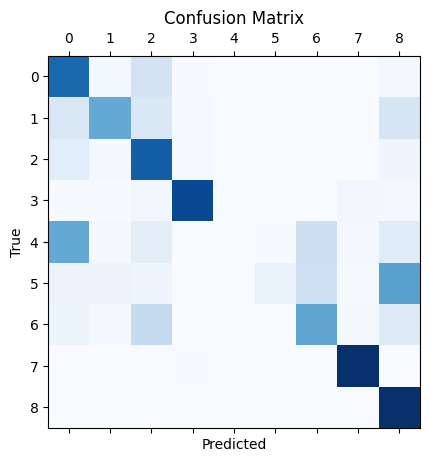

   overall_precision  overall_recall  overall_f1  overall_accuracy
0           0.661047        0.722025    0.690192          0.950253

                   LOC        MISC          ORG          PER
precision     0.641873    0.598113     0.490925     0.950160
recall        0.698441    0.451567     0.667670     0.919604
f1            0.668964    0.514610     0.565816     0.934632
number     1668.000000  702.000000  1661.000000  1617.000000

end of run
---------------------------------------------------
---------------------------------------------------
starting run on training set of 5%



Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['cl

{'eval_loss': 2.314640998840332, 'eval_precision': 0.021927804739806583, 'eval_recall': 0.10959631728045326, 'eval_f1': 0.036543967883814976, 'eval_accuracy': 0.026165607838914612, 'eval_runtime': 6.9591, 'eval_samples_per_second': 496.185, 'eval_steps_per_second': 7.76, 'epoch': 0.02}



  1%|▏         | 3/220 [00:14<19:56,  5.51s/it]

{'eval_loss': 2.311075210571289, 'eval_precision': 0.021843197049750008, 'eval_recall': 0.10906515580736544, 'eval_f1': 0.03639693934828208, 'eval_accuracy': 0.026962420587918597, 'eval_runtime': 6.9626, 'eval_samples_per_second': 495.935, 'eval_steps_per_second': 7.756, 'epoch': 0.05}



  2%|▏         | 4/220 [00:21<22:03,  6.13s/it]

{'eval_loss': 2.304029941558838, 'eval_precision': 0.021866458414681766, 'eval_recall': 0.10906515580736544, 'eval_f1': 0.036429226174635565, 'eval_accuracy': 0.028469904167115322, 'eval_runtime': 6.9531, 'eval_samples_per_second': 496.61, 'eval_steps_per_second': 7.766, 'epoch': 0.07}



  2%|▏         | 5/220 [00:28<23:09,  6.46s/it]

{'eval_loss': 2.2933850288391113, 'eval_precision': 0.02197841215736401, 'eval_recall': 0.10959631728045326, 'eval_f1': 0.036614219803620014, 'eval_accuracy': 0.030989555292344137, 'eval_runtime': 6.9657, 'eval_samples_per_second': 495.714, 'eval_steps_per_second': 7.752, 'epoch': 0.09}



  3%|▎         | 6/220 [00:35<23:48,  6.68s/it]

{'eval_loss': 2.2793116569519043, 'eval_precision': 0.022098857691897084, 'eval_recall': 0.10995042492917848, 'eval_f1': 0.03680109040267859, 'eval_accuracy': 0.034779799720038765, 'eval_runtime': 7.0011, 'eval_samples_per_second': 493.209, 'eval_steps_per_second': 7.713, 'epoch': 0.11}



  3%|▎         | 7/220 [00:42<24:12,  6.82s/it]

{'eval_loss': 2.2618589401245117, 'eval_precision': 0.021957228033846265, 'eval_recall': 0.10888810198300283, 'eval_f1': 0.03654514662625903, 'eval_accuracy': 0.04012059868633574, 'eval_runtime': 6.9908, 'eval_samples_per_second': 493.933, 'eval_steps_per_second': 7.724, 'epoch': 0.14}



  4%|▎         | 8/220 [00:49<24:32,  6.95s/it]

{'eval_loss': 2.240905284881592, 'eval_precision': 0.02208993760309833, 'eval_recall': 0.10906515580736544, 'eval_f1': 0.036738832229975545, 'eval_accuracy': 0.04817486809518682, 'eval_runtime': 7.1215, 'eval_samples_per_second': 484.866, 'eval_steps_per_second': 7.583, 'epoch': 0.16}



  4%|▍         | 9/220 [00:56<24:35,  6.99s/it]

{'eval_loss': 2.21652889251709, 'eval_precision': 0.02208167690639682, 'eval_recall': 0.10817988668555241, 'eval_f1': 0.03667687136082597, 'eval_accuracy': 0.06042855604608593, 'eval_runtime': 6.9978, 'eval_samples_per_second': 493.444, 'eval_steps_per_second': 7.717, 'epoch': 0.18}



  5%|▍         | 10/220 [01:04<24:40,  7.05s/it]

{'eval_loss': 2.1889567375183105, 'eval_precision': 0.02251310820225131, 'eval_recall': 0.10871104815864023, 'eval_f1': 0.03730141854743173, 'eval_accuracy': 0.0804780876494024, 'eval_runtime': 7.0724, 'eval_samples_per_second': 488.235, 'eval_steps_per_second': 7.635, 'epoch': 0.2}



  5%|▍         | 10/220 [01:11<24:40,  7.05s/it]

{'eval_loss': 2.1580047607421875, 'eval_precision': 0.023207625362619146, 'eval_recall': 0.10906515580736544, 'eval_f1': 0.03827156658693424, 'eval_accuracy': 0.10948637880908797, 'eval_runtime': 7.1998, 'eval_samples_per_second': 479.596, 'eval_steps_per_second': 7.5, 'epoch': 0.23}


  5%|▌         | 12/220 [01:19<25:41,  7.41s/it]

{'eval_loss': 2.123717784881592, 'eval_precision': 0.02400282386163078, 'eval_recall': 0.10835694050991501, 'eval_f1': 0.03930004816182373, 'eval_accuracy': 0.15178206094540755, 'eval_runtime': 7.259, 'eval_samples_per_second': 475.684, 'eval_steps_per_second': 7.439, 'epoch': 0.25}



  6%|▌         | 13/220 [01:27<25:28,  7.38s/it]

{'eval_loss': 2.0864651203155518, 'eval_precision': 0.02449860897728688, 'eval_recall': 0.10446175637393768, 'eval_f1': 0.03968921327906898, 'eval_accuracy': 0.20738666953806395, 'eval_runtime': 7.2089, 'eval_samples_per_second': 478.991, 'eval_steps_per_second': 7.491, 'epoch': 0.27}



  6%|▋         | 14/220 [01:34<25:17,  7.37s/it]

{'eval_loss': 2.0465805530548096, 'eval_precision': 0.025538058927040565, 'eval_recall': 0.10021246458923513, 'eval_f1': 0.04070331883067851, 'eval_accuracy': 0.278367610638527, 'eval_runtime': 7.2103, 'eval_samples_per_second': 478.9, 'eval_steps_per_second': 7.489, 'epoch': 0.3}



  7%|▋         | 15/220 [01:41<25:14,  7.39s/it]

{'eval_loss': 2.0036001205444336, 'eval_precision': 0.027161496674620502, 'eval_recall': 0.09472379603399433, 'eval_f1': 0.042217399881633456, 'eval_accuracy': 0.3614299558522666, 'eval_runtime': 7.3452, 'eval_samples_per_second': 470.103, 'eval_steps_per_second': 7.352, 'epoch': 0.32}



  7%|▋         | 16/220 [01:49<25:00,  7.36s/it]

{'eval_loss': 1.9571771621704102, 'eval_precision': 0.02875894988066826, 'eval_recall': 0.0853399433427762, 'eval_f1': 0.043020349875044626, 'eval_accuracy': 0.4531064929471304, 'eval_runtime': 7.1581, 'eval_samples_per_second': 482.393, 'eval_steps_per_second': 7.544, 'epoch': 0.34}



  8%|▊         | 17/220 [01:56<24:52,  7.35s/it]

{'eval_loss': 1.907709002494812, 'eval_precision': 0.02997032640949555, 'eval_recall': 0.07152974504249292, 'eval_f1': 0.04224173985780008, 'eval_accuracy': 0.5448476364811026, 'eval_runtime': 7.2285, 'eval_samples_per_second': 477.695, 'eval_steps_per_second': 7.47, 'epoch': 0.36}



  8%|▊         | 18/220 [02:03<24:37,  7.31s/it]

{'eval_loss': 1.8554919958114624, 'eval_precision': 0.030993978876715032, 'eval_recall': 0.05559490084985836, 'eval_f1': 0.03979973382343621, 'eval_accuracy': 0.6274577366210833, 'eval_runtime': 7.1221, 'eval_samples_per_second': 484.828, 'eval_steps_per_second': 7.582, 'epoch': 0.39}



  9%|▊         | 19/220 [02:10<24:21,  7.27s/it]

{'eval_loss': 1.8009519577026367, 'eval_precision': 0.029149913842619186, 'eval_recall': 0.03594192634560907, 'eval_f1': 0.03219156359023153, 'eval_accuracy': 0.6972972972972973, 'eval_runtime': 7.0549, 'eval_samples_per_second': 489.445, 'eval_steps_per_second': 7.654, 'epoch': 0.41}



  9%|▉         | 20/220 [02:17<24:02,  7.21s/it]

{'eval_loss': 1.7440956830978394, 'eval_precision': 0.026298044504383007, 'eval_recall': 0.02071529745042493, 'eval_f1': 0.02317520055462018, 'eval_accuracy': 0.7486809518682028, 'eval_runtime': 6.962, 'eval_samples_per_second': 495.981, 'eval_steps_per_second': 7.756, 'epoch': 0.43}



  9%|▉         | 20/220 [02:24<24:02,  7.21s/it]

{'eval_loss': 1.6844003200531006, 'eval_precision': 0.028026905829596414, 'eval_recall': 0.013279036827195468, 'eval_f1': 0.018020182604517057, 'eval_accuracy': 0.7820824808872617, 'eval_runtime': 6.9761, 'eval_samples_per_second': 494.973, 'eval_steps_per_second': 7.741, 'epoch': 0.45}


 10%|█         | 22/220 [02:32<24:12,  7.33s/it]

{'eval_loss': 1.6220064163208008, 'eval_precision': 0.03032345013477089, 'eval_recall': 0.00796742209631728, 'eval_f1': 0.012619181155356141, 'eval_accuracy': 0.8023689027673091, 'eval_runtime': 7.0345, 'eval_samples_per_second': 490.867, 'eval_steps_per_second': 7.676, 'epoch': 0.48}



 10%|█         | 23/220 [02:39<23:47,  7.25s/it]

{'eval_loss': 1.557154893875122, 'eval_precision': 0.03398692810457516, 'eval_recall': 0.004603399433427762, 'eval_f1': 0.008108529549352875, 'eval_accuracy': 0.8139119198880155, 'eval_runtime': 6.9289, 'eval_samples_per_second': 498.348, 'eval_steps_per_second': 7.793, 'epoch': 0.5}



 11%|█         | 24/220 [02:46<23:25,  7.17s/it]

{'eval_loss': 1.4894537925720215, 'eval_precision': 0.04519774011299435, 'eval_recall': 0.0028328611898017, 'eval_f1': 0.005331556147950682, 'eval_accuracy': 0.8203940992785614, 'eval_runtime': 6.904, 'eval_samples_per_second': 500.146, 'eval_steps_per_second': 7.822, 'epoch': 0.52}



 11%|█▏        | 25/220 [02:54<23:10,  7.13s/it]

{'eval_loss': 1.4198921918869019, 'eval_precision': 0.03225806451612903, 'eval_recall': 0.0008852691218130312, 'eval_f1': 0.0017232465965879716, 'eval_accuracy': 0.8233229245181436, 'eval_runtime': 6.9328, 'eval_samples_per_second': 498.067, 'eval_steps_per_second': 7.789, 'epoch': 0.55}



 12%|█▏        | 26/220 [03:01<22:58,  7.10s/it]

{'eval_loss': 1.3483070135116577, 'eval_precision': 0.05405405405405406, 'eval_recall': 0.000708215297450425, 'eval_f1': 0.001398112548060119, 'eval_accuracy': 0.8246150533003123, 'eval_runtime': 6.9526, 'eval_samples_per_second': 496.647, 'eval_steps_per_second': 7.767, 'epoch': 0.57}



 12%|█▏        | 27/220 [03:08<22:47,  7.09s/it]

{'eval_loss': 1.2761279344558716, 'eval_precision': 0.02564102564102564, 'eval_recall': 0.00017705382436260624, 'eval_f1': 0.0003516792685071215, 'eval_accuracy': 0.824873479056746, 'eval_runtime': 6.945, 'eval_samples_per_second': 497.192, 'eval_steps_per_second': 7.775, 'epoch': 0.59}


/home/ronen/Documents/college/NNForNLP/workshop_1/.conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 13%|█▎        | 28/220 [03:15<22:38,  7.08s/it]

{'eval_loss': 1.2035000324249268, 'eval_precision': 0.07692307692307693, 'eval_recall': 0.00017705382436260624, 'eval_f1': 0.0003532944709415298, 'eval_accuracy': 0.8251103693334769, 'eval_runtime': 6.931, 'eval_samples_per_second': 498.194, 'eval_steps_per_second': 7.791, 'epoch': 0.61}



 13%|█▎        | 29/220 [03:22<22:35,  7.10s/it]

{'eval_loss': 1.1324650049209595, 'eval_precision': 0.14285714285714285, 'eval_recall': 0.00017705382436260624, 'eval_f1': 0.00035366931918656057, 'eval_accuracy': 0.8252395822116938, 'eval_runtime': 7.0305, 'eval_samples_per_second': 491.142, 'eval_steps_per_second': 7.681, 'epoch': 0.64}



 14%|█▎        | 30/220 [03:29<22:22,  7.07s/it]

{'eval_loss': 1.0637619495391846, 'eval_precision': 0.3333333333333333, 'eval_recall': 0.00017705382436260624, 'eval_f1': 0.0003539196602371262, 'eval_accuracy': 0.8252826531710994, 'eval_runtime': 6.9013, 'eval_samples_per_second': 500.341, 'eval_steps_per_second': 7.825, 'epoch': 0.66}



 14%|█▎        | 30/220 [03:36<22:22,  7.07s/it]

{'eval_loss': 0.9984259605407715, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8252826531710994, 'eval_runtime': 6.9083, 'eval_samples_per_second': 499.836, 'eval_steps_per_second': 7.817, 'epoch': 0.68}


 14%|█▍        | 31/220 [03:37<22:59,  7.30s/it]/home/ronen/Documents/college/NNForNLP/workshop_1/.conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 15%|█▍        | 32/220 [03:44<22:35,  7.21s/it]

{'eval_loss': 0.938717782497406, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8252826531710994, 'eval_runtime': 6.9014, 'eval_samples_per_second': 500.336, 'eval_steps_per_second': 7.825, 'epoch': 0.7}



 15%|█▌        | 33/220 [03:51<22:18,  7.16s/it]

{'eval_loss': 0.8870509266853333, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8252826531710994, 'eval_runtime': 6.9181, 'eval_samples_per_second': 499.124, 'eval_steps_per_second': 7.806, 'epoch': 0.73}


/home/ronen/Documents/college/NNForNLP/workshop_1/.conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 15%|█▌        | 34/220 [03:58<22:02,  7.11s/it]

{'eval_loss': 0.8453201651573181, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.8912, 'eval_samples_per_second': 501.071, 'eval_steps_per_second': 7.836, 'epoch': 0.75}



 16%|█▌        | 35/220 [04:05<21:49,  7.08s/it]

{'eval_loss': 0.8159530162811279, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.8975, 'eval_samples_per_second': 500.615, 'eval_steps_per_second': 7.829, 'epoch': 0.77}



 16%|█▋        | 36/220 [04:12<21:45,  7.09s/it]

{'eval_loss': 0.7990054488182068, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 7.0273, 'eval_samples_per_second': 491.371, 'eval_steps_per_second': 7.684, 'epoch': 0.8}



 17%|█▋        | 37/220 [04:19<21:33,  7.07s/it]

{'eval_loss': 0.7927466034889221, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.9203, 'eval_samples_per_second': 498.97, 'eval_steps_per_second': 7.803, 'epoch': 0.82}



 17%|█▋        | 38/220 [04:26<21:23,  7.05s/it]

{'eval_loss': 0.7920955419540405, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.9186, 'eval_samples_per_second': 499.09, 'eval_steps_per_second': 7.805, 'epoch': 0.84}



 18%|█▊        | 39/220 [04:33<21:15,  7.04s/it]

{'eval_loss': 0.7873416543006897, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.9234, 'eval_samples_per_second': 498.745, 'eval_steps_per_second': 7.8, 'epoch': 0.86}



 18%|█▊        | 40/220 [04:40<21:05,  7.03s/it]

{'eval_loss': 0.7781049609184265, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.9056, 'eval_samples_per_second': 500.032, 'eval_steps_per_second': 7.82, 'epoch': 0.89}



 18%|█▊        | 40/220 [04:47<21:05,  7.03s/it]

{'eval_loss': 0.7619915008544922, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.913, 'eval_samples_per_second': 499.497, 'eval_steps_per_second': 7.811, 'epoch': 0.91}


 19%|█▊        | 41/220 [04:48<21:42,  7.27s/it]/home/ronen/Documents/college/NNForNLP/workshop_1/.conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ronen/Documents/college/NNForNLP/workshop_1/.conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 19%|█▉        | 42/220 [04:55<21:19,  7.19s/it]

{'eval_loss': 0.7379636764526367, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.9006, 'eval_samples_per_second': 500.395, 'eval_steps_per_second': 7.825, 'epoch': 0.93}



 20%|█▉        | 43/220 [05:02<21:09,  7.17s/it]

{'eval_loss': 0.7105360627174377, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 7.027, 'eval_samples_per_second': 491.392, 'eval_steps_per_second': 7.685, 'epoch': 0.95}



 20%|██        | 44/220 [05:09<20:52,  7.12s/it]

{'eval_loss': 0.681326687335968, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.898, 'eval_samples_per_second': 500.58, 'eval_steps_per_second': 7.828, 'epoch': 0.98}



 20%|██        | 45/220 [05:16<20:38,  7.08s/it]

{'eval_loss': 0.6535568833351135, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.8924, 'eval_samples_per_second': 500.986, 'eval_steps_per_second': 7.835, 'epoch': 1.0}



 21%|██        | 46/220 [05:23<20:31,  7.08s/it]

{'eval_loss': 0.62955641746521, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.9811, 'eval_samples_per_second': 494.622, 'eval_steps_per_second': 7.735, 'epoch': 1.02}



 21%|██▏       | 47/220 [05:30<20:22,  7.07s/it]

{'eval_loss': 0.6094106435775757, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.926, 'eval_samples_per_second': 498.558, 'eval_steps_per_second': 7.797, 'epoch': 1.05}



 22%|██▏       | 48/220 [05:37<20:12,  7.05s/it]

{'eval_loss': 0.5930573344230652, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.9003, 'eval_samples_per_second': 500.413, 'eval_steps_per_second': 7.826, 'epoch': 1.07}



 22%|██▏       | 49/220 [05:44<20:03,  7.04s/it]

{'eval_loss': 0.5770034790039062, 'eval_precision': 0.1111111111111111, 'eval_recall': 0.00017705382436260624, 'eval_f1': 0.00035354428142124803, 'eval_accuracy': 0.8254118660493163, 'eval_runtime': 6.8985, 'eval_samples_per_second': 500.543, 'eval_steps_per_second': 7.828, 'epoch': 1.09}



 23%|██▎       | 50/220 [05:51<20:07,  7.10s/it]

{'eval_loss': 0.5592512488365173, 'eval_precision': 0.16666666666666666, 'eval_recall': 0.0010623229461756375, 'eval_f1': 0.00211118930330753, 'eval_accuracy': 0.8258856466027781, 'eval_runtime': 7.1445, 'eval_samples_per_second': 483.312, 'eval_steps_per_second': 7.558, 'epoch': 1.11}



 23%|██▎       | 50/220 [05:58<20:07,  7.10s/it]

{'eval_loss': 0.539810836315155, 'eval_precision': 0.08333333333333333, 'eval_recall': 0.001593484419263456, 'eval_f1': 0.0031271716469770676, 'eval_accuracy': 0.827027027027027, 'eval_runtime': 6.9308, 'eval_samples_per_second': 498.21, 'eval_steps_per_second': 7.791, 'epoch': 1.14}


 24%|██▎       | 52/220 [06:06<20:22,  7.27s/it]

{'eval_loss': 0.5195693373680115, 'eval_precision': 0.11742424242424243, 'eval_recall': 0.005488668555240793, 'eval_f1': 0.010487144790257103, 'eval_accuracy': 0.829762032949284, 'eval_runtime': 7.0117, 'eval_samples_per_second': 492.462, 'eval_steps_per_second': 7.701, 'epoch': 1.16}



 24%|██▍       | 53/220 [06:13<20:09,  7.24s/it]

{'eval_loss': 0.499726265668869, 'eval_precision': 0.15892857142857142, 'eval_recall': 0.015757790368271955, 'eval_f1': 0.028672680412371133, 'eval_accuracy': 0.8346721223215247, 'eval_runtime': 7.0697, 'eval_samples_per_second': 488.422, 'eval_steps_per_second': 7.638, 'epoch': 1.18}


/home/ronen/Documents/college/NNForNLP/workshop_1/.conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 25%|██▍       | 54/220 [06:21<19:57,  7.21s/it]

{'eval_loss': 0.4816637933254242, 'eval_precision': 0.2094017094017094, 'eval_recall': 0.034702549575070823, 'eval_f1': 0.05953827460510328, 'eval_accuracy': 0.8405943792397975, 'eval_runtime': 7.0426, 'eval_samples_per_second': 490.301, 'eval_steps_per_second': 7.668, 'epoch': 1.2}



 25%|██▌       | 55/220 [06:28<19:40,  7.15s/it]

{'eval_loss': 0.46579888463020325, 'eval_precision': 0.2948717948717949, 'eval_recall': 0.08144475920679886, 'eval_f1': 0.1276359600443951, 'eval_accuracy': 0.8511682997738774, 'eval_runtime': 6.9247, 'eval_samples_per_second': 498.649, 'eval_steps_per_second': 7.798, 'epoch': 1.23}



 25%|██▌       | 56/220 [06:35<19:28,  7.13s/it]

{'eval_loss': 0.45159128308296204, 'eval_precision': 0.34808510638297874, 'eval_recall': 0.1448300283286119, 'eval_f1': 0.2045511377844461, 'eval_accuracy': 0.8630128136104231, 'eval_runtime': 6.9675, 'eval_samples_per_second': 495.585, 'eval_steps_per_second': 7.75, 'epoch': 1.25}



 26%|██▌       | 57/220 [06:42<19:17,  7.10s/it]

{'eval_loss': 0.438671350479126, 'eval_precision': 0.38135048231511254, 'eval_recall': 0.209985835694051, 'eval_f1': 0.27083809088833066, 'eval_accuracy': 0.8743404759341015, 'eval_runtime': 6.9485, 'eval_samples_per_second': 496.94, 'eval_steps_per_second': 7.771, 'epoch': 1.27}



 26%|██▋       | 58/220 [06:49<19:18,  7.15s/it]

{'eval_loss': 0.4263870120048523, 'eval_precision': 0.39815526518063027, 'eval_recall': 0.27514164305949007, 'eval_f1': 0.3254109517328028, 'eval_accuracy': 0.8848067190696672, 'eval_runtime': 7.1579, 'eval_samples_per_second': 482.403, 'eval_steps_per_second': 7.544, 'epoch': 1.3}



 27%|██▋       | 59/220 [06:56<19:11,  7.15s/it]

{'eval_loss': 0.4140298366546631, 'eval_precision': 0.40719207579672695, 'eval_recall': 0.3348087818696884, 'eval_f1': 0.36746987951807225, 'eval_accuracy': 0.8941315817809842, 'eval_runtime': 7.0613, 'eval_samples_per_second': 489.001, 'eval_steps_per_second': 7.647, 'epoch': 1.32}



 27%|██▋       | 60/220 [07:03<19:05,  7.16s/it]

{'eval_loss': 0.4014214277267456, 'eval_precision': 0.42051668866679237, 'eval_recall': 0.3948300283286119, 'eval_f1': 0.40726874258058626, 'eval_accuracy': 0.9031334122967589, 'eval_runtime': 7.0888, 'eval_samples_per_second': 487.103, 'eval_steps_per_second': 7.618, 'epoch': 1.34}



 27%|██▋       | 60/220 [07:10<19:05,  7.16s/it]

{'eval_loss': 0.38936647772789, 'eval_precision': 0.42490015627713146, 'eval_recall': 0.43325070821529743, 'eval_f1': 0.429034803191023, 'eval_accuracy': 0.9084742112630558, 'eval_runtime': 7.0612, 'eval_samples_per_second': 489.009, 'eval_steps_per_second': 7.647, 'epoch': 1.36}


 28%|██▊       | 62/220 [07:19<19:28,  7.39s/it]

{'eval_loss': 0.37813693284988403, 'eval_precision': 0.42610554002959067, 'eval_recall': 0.45892351274787535, 'eval_f1': 0.44190606086437645, 'eval_accuracy': 0.9117906751372887, 'eval_runtime': 7.1557, 'eval_samples_per_second': 482.55, 'eval_steps_per_second': 7.546, 'epoch': 1.39}



 29%|██▊       | 63/220 [07:26<19:11,  7.33s/it]

{'eval_loss': 0.36746516823768616, 'eval_precision': 0.4314592545799116, 'eval_recall': 0.48371104815864024, 'eval_f1': 0.456093489148581, 'eval_accuracy': 0.9148056422956822, 'eval_runtime': 7.0668, 'eval_samples_per_second': 488.62, 'eval_steps_per_second': 7.641, 'epoch': 1.41}



 29%|██▉       | 64/220 [07:33<18:56,  7.29s/it]

{'eval_loss': 0.35706767439842224, 'eval_precision': 0.4345146379044684, 'eval_recall': 0.4992917847025496, 'eval_f1': 0.4646564508156204, 'eval_accuracy': 0.9164208032733929, 'eval_runtime': 7.093, 'eval_samples_per_second': 486.82, 'eval_steps_per_second': 7.613, 'epoch': 1.43}



 30%|██▉       | 65/220 [07:40<18:54,  7.32s/it]

{'eval_loss': 0.3479161262512207, 'eval_precision': 0.43834781283340957, 'eval_recall': 0.5092067988668555, 'eval_f1': 0.4711278564993038, 'eval_accuracy': 0.9176913965758587, 'eval_runtime': 7.2813, 'eval_samples_per_second': 474.226, 'eval_steps_per_second': 7.416, 'epoch': 1.45}



 30%|███       | 66/220 [07:48<18:44,  7.30s/it]

{'eval_loss': 0.3399956226348877, 'eval_precision': 0.4489173528514791, 'eval_recall': 0.5212464589235127, 'eval_f1': 0.4823857119449451, 'eval_accuracy': 0.9190050608377301, 'eval_runtime': 7.1333, 'eval_samples_per_second': 484.071, 'eval_steps_per_second': 7.57, 'epoch': 1.48}



 30%|███       | 67/220 [07:55<18:28,  7.24s/it]

{'eval_loss': 0.3327873647212982, 'eval_precision': 0.4556845965770171, 'eval_recall': 0.5279745042492918, 'eval_f1': 0.4891732283464567, 'eval_accuracy': 0.9197803381070313, 'eval_runtime': 6.9911, 'eval_samples_per_second': 493.913, 'eval_steps_per_second': 7.724, 'epoch': 1.5}



 31%|███       | 68/220 [08:02<18:16,  7.21s/it]

{'eval_loss': 0.32558107376098633, 'eval_precision': 0.4651729919219631, 'eval_recall': 0.5403682719546742, 'eval_f1': 0.49995904660496354, 'eval_accuracy': 0.9212016797674168, 'eval_runtime': 7.0482, 'eval_samples_per_second': 489.912, 'eval_steps_per_second': 7.662, 'epoch': 1.52}



 31%|███▏      | 69/220 [08:09<18:06,  7.20s/it]

{'eval_loss': 0.3185206949710846, 'eval_precision': 0.4762196054442575, 'eval_recall': 0.5513456090651558, 'eval_f1': 0.5110363502092393, 'eval_accuracy': 0.9225153440292883, 'eval_runtime': 7.0507, 'eval_samples_per_second': 489.737, 'eval_steps_per_second': 7.659, 'epoch': 1.55}



 32%|███▏      | 70/220 [08:16<17:58,  7.19s/it]

{'eval_loss': 0.31163355708122253, 'eval_precision': 0.48617265087853323, 'eval_recall': 0.5633852691218131, 'eval_f1': 0.5219388173542198, 'eval_accuracy': 0.9235490470550232, 'eval_runtime': 7.0594, 'eval_samples_per_second': 489.134, 'eval_steps_per_second': 7.649, 'epoch': 1.57}



 32%|███▏      | 70/220 [08:23<17:58,  7.19s/it]

{'eval_loss': 0.3048798739910126, 'eval_precision': 0.4947400518371703, 'eval_recall': 0.5745396600566572, 'eval_f1': 0.5316621610551323, 'eval_accuracy': 0.9245181436416496, 'eval_runtime': 7.1517, 'eval_samples_per_second': 482.819, 'eval_steps_per_second': 7.551, 'epoch': 1.59}


 33%|███▎      | 72/220 [08:32<18:11,  7.38s/it]

{'eval_loss': 0.2982391119003296, 'eval_precision': 0.4990191640259544, 'eval_recall': 0.5855169971671388, 'eval_f1': 0.5388187372708758, 'eval_accuracy': 0.9249488532357059, 'eval_runtime': 7.0261, 'eval_samples_per_second': 491.455, 'eval_steps_per_second': 7.686, 'epoch': 1.61}



 33%|███▎      | 73/220 [08:39<17:53,  7.30s/it]

{'eval_loss': 0.2919219732284546, 'eval_precision': 0.5027035145689396, 'eval_recall': 0.5925991501416431, 'eval_f1': 0.5439622948155372, 'eval_accuracy': 0.9252288144718424, 'eval_runtime': 7.0238, 'eval_samples_per_second': 491.614, 'eval_steps_per_second': 7.688, 'epoch': 1.64}



 34%|███▎      | 74/220 [08:46<17:38,  7.25s/it]

{'eval_loss': 0.28587526082992554, 'eval_precision': 0.5028341288782816, 'eval_recall': 0.5968484419263456, 'eval_f1': 0.5458225388601036, 'eval_accuracy': 0.9249057822763002, 'eval_runtime': 7.026, 'eval_samples_per_second': 491.458, 'eval_steps_per_second': 7.686, 'epoch': 1.66}



 34%|███▍      | 75/220 [08:53<17:24,  7.21s/it]

{'eval_loss': 0.2800788879394531, 'eval_precision': 0.5025118203309693, 'eval_recall': 0.6021600566572238, 'eval_f1': 0.5478414948453609, 'eval_accuracy': 0.9248842467965974, 'eval_runtime': 7.002, 'eval_samples_per_second': 493.143, 'eval_steps_per_second': 7.712, 'epoch': 1.68}



 35%|███▍      | 76/220 [09:00<17:17,  7.20s/it]

{'eval_loss': 0.27533161640167236, 'eval_precision': 0.4991238317757009, 'eval_recall': 0.6051699716713881, 'eval_f1': 0.5470550576184379, 'eval_accuracy': 0.9243027888446215, 'eval_runtime': 7.0514, 'eval_samples_per_second': 489.687, 'eval_steps_per_second': 7.658, 'epoch': 1.7}



 35%|███▌      | 77/220 [09:07<17:08,  7.19s/it]

{'eval_loss': 0.27075690031051636, 'eval_precision': 0.500218818380744, 'eval_recall': 0.6071175637393768, 'eval_f1': 0.5485083579940814, 'eval_accuracy': 0.9241735759664047, 'eval_runtime': 7.0528, 'eval_samples_per_second': 489.595, 'eval_steps_per_second': 7.657, 'epoch': 1.73}



 35%|███▌      | 78/220 [09:14<16:59,  7.18s/it]

{'eval_loss': 0.26628246903419495, 'eval_precision': 0.5026995476433679, 'eval_recall': 0.6099504249291785, 'eval_f1': 0.551155907527398, 'eval_accuracy': 0.9246904274792721, 'eval_runtime': 7.0478, 'eval_samples_per_second': 489.94, 'eval_steps_per_second': 7.662, 'epoch': 1.75}



 36%|███▌      | 79/220 [09:22<16:57,  7.21s/it]

{'eval_loss': 0.26164713501930237, 'eval_precision': 0.5057117750439367, 'eval_recall': 0.6113668555240793, 'eval_f1': 0.5535428021801859, 'eval_accuracy': 0.9253795628297621, 'eval_runtime': 7.1761, 'eval_samples_per_second': 481.184, 'eval_steps_per_second': 7.525, 'epoch': 1.77}



 36%|███▋      | 80/220 [09:29<16:44,  7.17s/it]

{'eval_loss': 0.2579050660133362, 'eval_precision': 0.5084546390236729, 'eval_recall': 0.6122521246458924, 'eval_f1': 0.5555466302514258, 'eval_accuracy': 0.9262194465381717, 'eval_runtime': 6.9815, 'eval_samples_per_second': 494.595, 'eval_steps_per_second': 7.735, 'epoch': 1.8}



 36%|███▋      | 80/220 [09:36<16:44,  7.17s/it]

{'eval_loss': 0.25482606887817383, 'eval_precision': 0.5100147275405007, 'eval_recall': 0.6131373937677054, 'eval_f1': 0.5568419360025727, 'eval_accuracy': 0.9268439754495531, 'eval_runtime': 6.9962, 'eval_samples_per_second': 493.553, 'eval_steps_per_second': 7.718, 'epoch': 1.82}


 37%|███▋      | 82/220 [09:44<16:50,  7.32s/it]

{'eval_loss': 0.2516409754753113, 'eval_precision': 0.5117551382522549, 'eval_recall': 0.6127832861189801, 'eval_f1': 0.5577310450406897, 'eval_accuracy': 0.9274900398406375, 'eval_runtime': 6.9913, 'eval_samples_per_second': 493.902, 'eval_steps_per_second': 7.724, 'epoch': 1.84}



 38%|███▊      | 83/220 [09:51<16:34,  7.26s/it]

{'eval_loss': 0.24844935536384583, 'eval_precision': 0.5217131771377407, 'eval_recall': 0.6189801699716714, 'eval_f1': 0.5661996922827759, 'eval_accuracy': 0.9293420910950791, 'eval_runtime': 7.0348, 'eval_samples_per_second': 490.845, 'eval_steps_per_second': 7.676, 'epoch': 1.86}



 38%|███▊      | 84/220 [09:58<16:20,  7.21s/it]

{'eval_loss': 0.24543431401252747, 'eval_precision': 0.5301367803998196, 'eval_recall': 0.6244688385269122, 'eval_f1': 0.5734493130639785, 'eval_accuracy': 0.9306557553569506, 'eval_runtime': 6.9911, 'eval_samples_per_second': 493.91, 'eval_steps_per_second': 7.724, 'epoch': 1.89}



 39%|███▊      | 85/220 [10:05<16:09,  7.18s/it]

{'eval_loss': 0.24233874678611755, 'eval_precision': 0.535126151986705, 'eval_recall': 0.6271246458923513, 'eval_f1': 0.5774843074916443, 'eval_accuracy': 0.9319478841391192, 'eval_runtime': 7.0065, 'eval_samples_per_second': 492.831, 'eval_steps_per_second': 7.707, 'epoch': 1.91}



 39%|███▉      | 86/220 [10:12<16:03,  7.19s/it]

{'eval_loss': 0.24005308747291565, 'eval_precision': 0.5417999086340795, 'eval_recall': 0.6299575070821529, 'eval_f1': 0.5825624232501022, 'eval_accuracy': 0.933110800043071, 'eval_runtime': 7.108, 'eval_samples_per_second': 485.788, 'eval_steps_per_second': 7.597, 'epoch': 1.93}



 40%|███▉      | 87/220 [10:20<15:53,  7.17s/it]

{'eval_loss': 0.2390769124031067, 'eval_precision': 0.5457331086257086, 'eval_recall': 0.6306657223796034, 'eval_f1': 0.5851334702258726, 'eval_accuracy': 0.9333261548400991, 'eval_runtime': 6.9826, 'eval_samples_per_second': 494.516, 'eval_steps_per_second': 7.734, 'epoch': 1.95}



 40%|████      | 88/220 [10:27<15:43,  7.15s/it]

{'eval_loss': 0.23874151706695557, 'eval_precision': 0.5487486565330877, 'eval_recall': 0.6327903682719547, 'eval_f1': 0.5877806101471919, 'eval_accuracy': 0.9337353289544524, 'eval_runtime': 6.9825, 'eval_samples_per_second': 494.524, 'eval_steps_per_second': 7.734, 'epoch': 1.98}



 40%|████      | 89/220 [10:34<15:34,  7.13s/it]

{'eval_loss': 0.23826086521148682, 'eval_precision': 0.5554351192319603, 'eval_recall': 0.6350920679886686, 'eval_f1': 0.5925987113827853, 'eval_accuracy': 0.934359857865834, 'eval_runtime': 6.9944, 'eval_samples_per_second': 493.683, 'eval_steps_per_second': 7.72, 'epoch': 2.0}



 41%|████      | 90/220 [10:41<15:25,  7.12s/it]

{'eval_loss': 0.23677872121334076, 'eval_precision': 0.5593982630272953, 'eval_recall': 0.6386331444759207, 'eval_f1': 0.5963955026455027, 'eval_accuracy': 0.9348121029395929, 'eval_runtime': 7.0079, 'eval_samples_per_second': 492.731, 'eval_steps_per_second': 7.706, 'epoch': 2.02}



 41%|████      | 90/220 [10:48<15:25,  7.12s/it]

{'eval_loss': 0.2348388135433197, 'eval_precision': 0.5654205607476636, 'eval_recall': 0.6427053824362606, 'eval_f1': 0.6015909844216109, 'eval_accuracy': 0.9356089156885969, 'eval_runtime': 7.0154, 'eval_samples_per_second': 492.202, 'eval_steps_per_second': 7.697, 'epoch': 2.05}


 42%|████▏     | 92/220 [10:56<15:35,  7.31s/it]

{'eval_loss': 0.23295237123966217, 'eval_precision': 0.5742651657285803, 'eval_recall': 0.6503186968838527, 'eval_f1': 0.6099302557289936, 'eval_accuracy': 0.9365995477549263, 'eval_runtime': 6.9943, 'eval_samples_per_second': 493.686, 'eval_steps_per_second': 7.721, 'epoch': 2.07}



 42%|████▏     | 93/220 [11:03<15:24,  7.28s/it]

{'eval_loss': 0.23159025609493256, 'eval_precision': 0.5788814037286543, 'eval_recall': 0.65421388101983, 'eval_f1': 0.6142465297980217, 'eval_accuracy': 0.9370948637880909, 'eval_runtime': 7.1137, 'eval_samples_per_second': 485.4, 'eval_steps_per_second': 7.591, 'epoch': 2.09}



 43%|████▎     | 94/220 [11:10<15:10,  7.23s/it]

{'eval_loss': 0.23012876510620117, 'eval_precision': 0.5882538182963313, 'eval_recall': 0.6614730878186968, 'eval_f1': 0.6227185598799899, 'eval_accuracy': 0.9379132120167977, 'eval_runtime': 6.9855, 'eval_samples_per_second': 494.313, 'eval_steps_per_second': 7.73, 'epoch': 2.11}



 43%|████▎     | 95/220 [11:17<14:58,  7.18s/it]

{'eval_loss': 0.22806142270565033, 'eval_precision': 0.600632911392405, 'eval_recall': 0.6720963172804533, 'eval_f1': 0.6343582887700534, 'eval_accuracy': 0.9392484117583719, 'eval_runtime': 6.9873, 'eval_samples_per_second': 494.182, 'eval_steps_per_second': 7.728, 'epoch': 2.14}



 44%|████▎     | 96/220 [11:24<14:47,  7.16s/it]

{'eval_loss': 0.2260882556438446, 'eval_precision': 0.6099189318073438, 'eval_recall': 0.6793555240793201, 'eval_f1': 0.6427674009548539, 'eval_accuracy': 0.9401313664261871, 'eval_runtime': 7.0022, 'eval_samples_per_second': 493.131, 'eval_steps_per_second': 7.712, 'epoch': 2.16}



 44%|████▍     | 97/220 [11:32<14:38,  7.15s/it]

{'eval_loss': 0.22408996522426605, 'eval_precision': 0.6137810311903247, 'eval_recall': 0.6828966005665722, 'eval_f1': 0.6464968152866242, 'eval_accuracy': 0.9409712501345967, 'eval_runtime': 7.0169, 'eval_samples_per_second': 492.099, 'eval_steps_per_second': 7.696, 'epoch': 2.18}



 45%|████▍     | 98/220 [11:39<14:33,  7.16s/it]

{'eval_loss': 0.22196228802204132, 'eval_precision': 0.6167037154652271, 'eval_recall': 0.6876770538243626, 'eval_f1': 0.6502595010882304, 'eval_accuracy': 0.9418326693227091, 'eval_runtime': 7.0989, 'eval_samples_per_second': 486.411, 'eval_steps_per_second': 7.607, 'epoch': 2.2}



 45%|████▌     | 99/220 [11:46<14:29,  7.18s/it]

{'eval_loss': 0.21967720985412598, 'eval_precision': 0.6184668989547039, 'eval_recall': 0.6913951841359773, 'eval_f1': 0.6529008527002172, 'eval_accuracy': 0.9427802304296328, 'eval_runtime': 7.137, 'eval_samples_per_second': 483.82, 'eval_steps_per_second': 7.566, 'epoch': 2.23}



 45%|████▌     | 100/220 [11:53<14:31,  7.27s/it]

{'eval_loss': 0.2175711840391159, 'eval_precision': 0.6209077969318362, 'eval_recall': 0.6951133144475921, 'eval_f1': 0.6559184696349512, 'eval_accuracy': 0.9434693657801227, 'eval_runtime': 7.3454, 'eval_samples_per_second': 470.09, 'eval_steps_per_second': 7.352, 'epoch': 2.25}



 45%|████▌     | 100/220 [12:01<14:31,  7.27s/it]

{'eval_loss': 0.21627023816108704, 'eval_precision': 0.6226862838158519, 'eval_recall': 0.6968838526912181, 'eval_f1': 0.6576990558943938, 'eval_accuracy': 0.9443092494885323, 'eval_runtime': 7.0925, 'eval_samples_per_second': 486.853, 'eval_steps_per_second': 7.614, 'epoch': 2.27}


 46%|████▋     | 102/220 [12:09<14:34,  7.41s/it]

{'eval_loss': 0.21544337272644043, 'eval_precision': 0.6219724552794048, 'eval_recall': 0.6956444759206799, 'eval_f1': 0.6567488508148768, 'eval_accuracy': 0.9446322816840745, 'eval_runtime': 7.0392, 'eval_samples_per_second': 490.538, 'eval_steps_per_second': 7.671, 'epoch': 2.3}



 47%|████▋     | 103/220 [12:16<14:15,  7.31s/it]

{'eval_loss': 0.21473996341228485, 'eval_precision': 0.6269677214183494, 'eval_recall': 0.6981232294617564, 'eval_f1': 0.6606350004188657, 'eval_accuracy': 0.9454721653924841, 'eval_runtime': 6.9993, 'eval_samples_per_second': 493.334, 'eval_steps_per_second': 7.715, 'epoch': 2.32}



 47%|████▋     | 104/220 [12:23<13:59,  7.24s/it]

{'eval_loss': 0.2143283188343048, 'eval_precision': 0.6327412385981757, 'eval_recall': 0.7000708215297451, 'eval_f1': 0.6647053879129192, 'eval_accuracy': 0.946161300742974, 'eval_runtime': 6.9644, 'eval_samples_per_second': 495.804, 'eval_steps_per_second': 7.754, 'epoch': 2.34}



 48%|████▊     | 105/220 [12:30<13:45,  7.18s/it]

{'eval_loss': 0.21396023035049438, 'eval_precision': 0.6363198458574181, 'eval_recall': 0.7016643059490085, 'eval_f1': 0.6673964297743348, 'eval_accuracy': 0.9466781522558415, 'eval_runtime': 6.9617, 'eval_samples_per_second': 496.001, 'eval_steps_per_second': 7.757, 'epoch': 2.36}



 48%|████▊     | 106/220 [12:37<13:34,  7.14s/it]

{'eval_loss': 0.2137836366891861, 'eval_precision': 0.6401289282836422, 'eval_recall': 0.703257790368272, 'eval_f1': 0.6702100733991394, 'eval_accuracy': 0.9471088618498977, 'eval_runtime': 6.9477, 'eval_samples_per_second': 496.996, 'eval_steps_per_second': 7.772, 'epoch': 2.39}



 49%|████▊     | 107/220 [12:44<13:24,  7.12s/it]

{'eval_loss': 0.21296174824237823, 'eval_precision': 0.6437116068541868, 'eval_recall': 0.705028328611898, 'eval_f1': 0.6729761703565996, 'eval_accuracy': 0.9476687843221708, 'eval_runtime': 6.9371, 'eval_samples_per_second': 497.759, 'eval_steps_per_second': 7.784, 'epoch': 2.41}



 49%|████▉     | 108/220 [12:51<13:19,  7.14s/it]

{'eval_loss': 0.2113656848669052, 'eval_precision': 0.6479649748662234, 'eval_recall': 0.7075070821529745, 'eval_f1': 0.6764282691493863, 'eval_accuracy': 0.9482933132335523, 'eval_runtime': 7.085, 'eval_samples_per_second': 487.367, 'eval_steps_per_second': 7.622, 'epoch': 2.43}



 50%|████▉     | 109/220 [12:58<13:13,  7.15s/it]

{'eval_loss': 0.20971107482910156, 'eval_precision': 0.651249594287569, 'eval_recall': 0.7105169971671388, 'eval_f1': 0.679593564775614, 'eval_accuracy': 0.948896306665231, 'eval_runtime': 7.0295, 'eval_samples_per_second': 491.218, 'eval_steps_per_second': 7.682, 'epoch': 2.45}



 50%|█████     | 110/220 [13:05<13:04,  7.13s/it]

{'eval_loss': 0.2085753232240677, 'eval_precision': 0.6533398342272062, 'eval_recall': 0.7117563739376771, 'eval_f1': 0.6812981950682145, 'eval_accuracy': 0.9490255195434478, 'eval_runtime': 6.97, 'eval_samples_per_second': 495.41, 'eval_steps_per_second': 7.748, 'epoch': 2.48}



 50%|█████     | 110/220 [13:12<13:04,  7.13s/it]

{'eval_loss': 0.20712201297283173, 'eval_precision': 0.6609421000981355, 'eval_recall': 0.7154745042492918, 'eval_f1': 0.6871280394490733, 'eval_accuracy': 0.949908474211263, 'eval_runtime': 6.9881, 'eval_samples_per_second': 494.125, 'eval_steps_per_second': 7.727, 'epoch': 2.5}


 51%|█████     | 112/220 [13:21<13:09,  7.31s/it]

{'eval_loss': 0.20609870553016663, 'eval_precision': 0.670669518012831, 'eval_recall': 0.7218484419263456, 'eval_f1': 0.6953184957789716, 'eval_accuracy': 0.9508560353181867, 'eval_runtime': 7.0548, 'eval_samples_per_second': 489.456, 'eval_steps_per_second': 7.654, 'epoch': 2.52}



 51%|█████▏    | 113/220 [13:28<12:56,  7.26s/it]

{'eval_loss': 0.20535731315612793, 'eval_precision': 0.6776859504132231, 'eval_recall': 0.7259206798866855, 'eval_f1': 0.7009745255599248, 'eval_accuracy': 0.951394422310757, 'eval_runtime': 7.0409, 'eval_samples_per_second': 490.423, 'eval_steps_per_second': 7.67, 'epoch': 2.55}



 52%|█████▏    | 114/220 [13:35<12:51,  7.28s/it]

{'eval_loss': 0.20237302780151367, 'eval_precision': 0.6833223031105228, 'eval_recall': 0.7312322946175638, 'eval_f1': 0.7064659596305166, 'eval_accuracy': 0.9520835576612469, 'eval_runtime': 7.2235, 'eval_samples_per_second': 478.022, 'eval_steps_per_second': 7.476, 'epoch': 2.57}



 52%|█████▏    | 115/220 [13:42<12:40,  7.24s/it]

{'eval_loss': 0.19974003732204437, 'eval_precision': 0.6910056422170594, 'eval_recall': 0.7372521246458924, 'eval_f1': 0.713380161041631, 'eval_accuracy': 0.9529449768493593, 'eval_runtime': 7.0575, 'eval_samples_per_second': 489.269, 'eval_steps_per_second': 7.651, 'epoch': 2.59}



 53%|█████▎    | 116/220 [13:49<12:28,  7.20s/it]

{'eval_loss': 0.19694603979587555, 'eval_precision': 0.6993854841388474, 'eval_recall': 0.7455736543909348, 'eval_f1': 0.7217413660125117, 'eval_accuracy': 0.9540648217939055, 'eval_runtime': 7.0172, 'eval_samples_per_second': 492.075, 'eval_steps_per_second': 7.695, 'epoch': 2.61}



 53%|█████▎    | 117/220 [13:56<12:19,  7.18s/it]

{'eval_loss': 0.19348901510238647, 'eval_precision': 0.7032385988103106, 'eval_recall': 0.7535410764872521, 'eval_f1': 0.7275213675213674, 'eval_accuracy': 0.9547754926240982, 'eval_runtime': 7.008, 'eval_samples_per_second': 492.726, 'eval_steps_per_second': 7.706, 'epoch': 2.64}



 54%|█████▎    | 118/220 [14:04<12:10,  7.16s/it]

{'eval_loss': 0.19102874398231506, 'eval_precision': 0.7025036818851251, 'eval_recall': 0.7600920679886686, 'eval_f1': 0.7301641296028575, 'eval_accuracy': 0.9550769893399376, 'eval_runtime': 7.0152, 'eval_samples_per_second': 492.215, 'eval_steps_per_second': 7.698, 'epoch': 2.66}



 54%|█████▍    | 119/220 [14:11<12:01,  7.15s/it]

{'eval_loss': 0.18979305028915405, 'eval_precision': 0.7009239747122711, 'eval_recall': 0.7655807365439093, 'eval_f1': 0.7318270288567318, 'eval_accuracy': 0.95524927317756, 'eval_runtime': 7.022, 'eval_samples_per_second': 491.74, 'eval_steps_per_second': 7.69, 'epoch': 2.68}



 55%|█████▍    | 120/220 [14:18<11:54,  7.14s/it]

{'eval_loss': 0.1897381693124771, 'eval_precision': 0.6977342117949542, 'eval_recall': 0.7687677053824362, 'eval_f1': 0.7315306208407041, 'eval_accuracy': 0.9550554538602347, 'eval_runtime': 7.0116, 'eval_samples_per_second': 492.467, 'eval_steps_per_second': 7.701, 'epoch': 2.7}



 55%|█████▍    | 120/220 [14:25<11:54,  7.14s/it]

{'eval_loss': 0.1898912787437439, 'eval_precision': 0.696528555431131, 'eval_recall': 0.7708923512747875, 'eval_f1': 0.7318262038826792, 'eval_accuracy': 0.9549693119414235, 'eval_runtime': 7.1552, 'eval_samples_per_second': 482.586, 'eval_steps_per_second': 7.547, 'epoch': 2.73}


 55%|█████▌    | 122/220 [14:33<12:01,  7.36s/it]

{'eval_loss': 0.18952922523021698, 'eval_precision': 0.6988336795015179, 'eval_recall': 0.7744334277620396, 'eval_f1': 0.7346938775510204, 'eval_accuracy': 0.9551200602993432, 'eval_runtime': 7.0518, 'eval_samples_per_second': 489.66, 'eval_steps_per_second': 7.658, 'epoch': 2.75}



 56%|█████▌    | 123/220 [14:40<11:49,  7.31s/it]

{'eval_loss': 0.189007967710495, 'eval_precision': 0.6985973860376156, 'eval_recall': 0.7760269121813032, 'eval_f1': 0.735279315551082, 'eval_accuracy': 0.955033918380532, 'eval_runtime': 7.116, 'eval_samples_per_second': 485.243, 'eval_steps_per_second': 7.589, 'epoch': 2.77}



 56%|█████▋    | 124/220 [14:48<11:38,  7.28s/it]

{'eval_loss': 0.18811434507369995, 'eval_precision': 0.7002707437490047, 'eval_recall': 0.7785056657223796, 'eval_f1': 0.7373186886895279, 'eval_accuracy': 0.9554430924948853, 'eval_runtime': 7.0775, 'eval_samples_per_second': 487.882, 'eval_steps_per_second': 7.63, 'epoch': 2.8}



 57%|█████▋    | 125/220 [14:55<11:26,  7.23s/it]

{'eval_loss': 0.18689127266407013, 'eval_precision': 0.7018801784576163, 'eval_recall': 0.7799220963172805, 'eval_f1': 0.7388460248238846, 'eval_accuracy': 0.9557661246904274, 'eval_runtime': 7.0036, 'eval_samples_per_second': 493.032, 'eval_steps_per_second': 7.71, 'epoch': 2.82}



 57%|█████▋    | 126/220 [15:02<11:15,  7.18s/it]

{'eval_loss': 0.18470942974090576, 'eval_precision': 0.7039294306335204, 'eval_recall': 0.7770892351274787, 'eval_f1': 0.7387023478919464, 'eval_accuracy': 0.9558953375686443, 'eval_runtime': 6.9771, 'eval_samples_per_second': 494.902, 'eval_steps_per_second': 7.74, 'epoch': 2.84}



 58%|█████▊    | 127/220 [15:09<11:04,  7.15s/it]

{'eval_loss': 0.1828995794057846, 'eval_precision': 0.7059864821371098, 'eval_recall': 0.7767351274787535, 'eval_f1': 0.7396729050750295, 'eval_accuracy': 0.9562829762032949, 'eval_runtime': 6.9852, 'eval_samples_per_second': 494.328, 'eval_steps_per_second': 7.731, 'epoch': 2.86}



 58%|█████▊    | 128/220 [15:16<10:58,  7.15s/it]

{'eval_loss': 0.18119508028030396, 'eval_precision': 0.7096878537926573, 'eval_recall': 0.7769121813031161, 'eval_f1': 0.7417800693094412, 'eval_accuracy': 0.9565844729191343, 'eval_runtime': 7.0463, 'eval_samples_per_second': 490.045, 'eval_steps_per_second': 7.664, 'epoch': 2.89}



 59%|█████▊    | 129/220 [15:23<10:52,  7.17s/it]

{'eval_loss': 0.17971615493297577, 'eval_precision': 0.7155410903173312, 'eval_recall': 0.7785056657223796, 'eval_f1': 0.7456965996777748, 'eval_accuracy': 0.9570582534725961, 'eval_runtime': 7.0947, 'eval_samples_per_second': 486.698, 'eval_steps_per_second': 7.611, 'epoch': 2.91}



 59%|█████▉    | 130/220 [15:30<10:42,  7.14s/it]

{'eval_loss': 0.17815598845481873, 'eval_precision': 0.7211286089238845, 'eval_recall': 0.7783286118980169, 'eval_f1': 0.7486376021798365, 'eval_accuracy': 0.9574889630666523, 'eval_runtime': 6.9556, 'eval_samples_per_second': 496.436, 'eval_steps_per_second': 7.764, 'epoch': 2.93}



 59%|█████▉    | 130/220 [15:37<10:42,  7.14s/it]

{'eval_loss': 0.17747308313846588, 'eval_precision': 0.7254869593925388, 'eval_recall': 0.7781515580736544, 'eval_f1': 0.7508969759097899, 'eval_accuracy': 0.958199633896845, 'eval_runtime': 6.9459, 'eval_samples_per_second': 497.13, 'eval_steps_per_second': 7.774, 'epoch': 2.95}


 60%|██████    | 132/220 [15:45<10:39,  7.27s/it]

{'eval_loss': 0.17697259783744812, 'eval_precision': 0.7308395677472984, 'eval_recall': 0.7783286118980169, 'eval_f1': 0.753836920174912, 'eval_accuracy': 0.9586303434909013, 'eval_runtime': 6.9457, 'eval_samples_per_second': 497.143, 'eval_steps_per_second': 7.775, 'epoch': 2.98}



 60%|██████    | 133/220 [15:52<10:26,  7.21s/it]

{'eval_loss': 0.17697975039482117, 'eval_precision': 0.7320326830081707, 'eval_recall': 0.7772662889518414, 'eval_f1': 0.7539716616573637, 'eval_accuracy': 0.9588456982879293, 'eval_runtime': 6.9649, 'eval_samples_per_second': 495.771, 'eval_steps_per_second': 7.753, 'epoch': 3.0}



 61%|██████    | 134/220 [15:59<10:16,  7.16s/it]

{'eval_loss': 0.176994189620018, 'eval_precision': 0.7354320160750167, 'eval_recall': 0.7776203966005666, 'eval_f1': 0.7559380378657488, 'eval_accuracy': 0.9591041240443631, 'eval_runtime': 6.9481, 'eval_samples_per_second': 496.97, 'eval_steps_per_second': 7.772, 'epoch': 3.02}



 61%|██████▏   | 135/220 [16:06<10:08,  7.15s/it]

{'eval_loss': 0.17647401988506317, 'eval_precision': 0.7422940879231935, 'eval_recall': 0.7802762039660056, 'eval_f1': 0.7608113940440225, 'eval_accuracy': 0.9593840852804997, 'eval_runtime': 7.0285, 'eval_samples_per_second': 491.283, 'eval_steps_per_second': 7.683, 'epoch': 3.05}



 62%|██████▏   | 136/220 [16:14<10:01,  7.16s/it]

{'eval_loss': 0.1763751059770584, 'eval_precision': 0.7436762225969646, 'eval_recall': 0.7808073654390935, 'eval_f1': 0.7617896009673518, 'eval_accuracy': 0.9596209755572306, 'eval_runtime': 7.0729, 'eval_samples_per_second': 488.199, 'eval_steps_per_second': 7.635, 'epoch': 3.07}



 62%|██████▏   | 137/220 [16:21<09:52,  7.13s/it]

{'eval_loss': 0.1760639250278473, 'eval_precision': 0.7459002535925613, 'eval_recall': 0.7811614730878187, 'eval_f1': 0.7631237568105163, 'eval_accuracy': 0.9597286529557446, 'eval_runtime': 6.9646, 'eval_samples_per_second': 495.791, 'eval_steps_per_second': 7.753, 'epoch': 3.09}



 63%|██████▎   | 138/220 [16:28<09:43,  7.11s/it]

{'eval_loss': 0.1753932386636734, 'eval_precision': 0.7474610697359513, 'eval_recall': 0.7818696883852692, 'eval_f1': 0.7642782969885774, 'eval_accuracy': 0.9599009367933671, 'eval_runtime': 6.9577, 'eval_samples_per_second': 496.288, 'eval_steps_per_second': 7.761, 'epoch': 3.11}



 63%|██████▎   | 139/220 [16:35<09:34,  7.09s/it]

{'eval_loss': 0.17471501231193542, 'eval_precision': 0.7495767016593295, 'eval_recall': 0.7838172804532578, 'eval_f1': 0.7663146962091051, 'eval_accuracy': 0.9601593625498008, 'eval_runtime': 6.9602, 'eval_samples_per_second': 496.107, 'eval_steps_per_second': 7.758, 'epoch': 3.14}



 64%|██████▎   | 140/220 [16:42<09:26,  7.08s/it]

{'eval_loss': 0.1739823967218399, 'eval_precision': 0.7494925575101489, 'eval_recall': 0.7845254957507082, 'eval_f1': 0.7666089965397923, 'eval_accuracy': 0.9602239689889093, 'eval_runtime': 6.9413, 'eval_samples_per_second': 497.46, 'eval_steps_per_second': 7.78, 'epoch': 3.16}



 64%|██████▎   | 140/220 [16:49<09:26,  7.08s/it]

{'eval_loss': 0.17343957722187042, 'eval_precision': 0.7515654086985953, 'eval_recall': 0.7862960339943342, 'eval_f1': 0.768538548066107, 'eval_accuracy': 0.9604608592656402, 'eval_runtime': 6.9528, 'eval_samples_per_second': 496.632, 'eval_steps_per_second': 7.767, 'epoch': 3.18}


 65%|██████▍   | 142/220 [16:57<09:26,  7.27s/it]

{'eval_loss': 0.17259755730628967, 'eval_precision': 0.752031144211239, 'eval_recall': 0.7866501416430595, 'eval_f1': 0.768951194184839, 'eval_accuracy': 0.9605039302250458, 'eval_runtime': 7.0089, 'eval_samples_per_second': 492.657, 'eval_steps_per_second': 7.704, 'epoch': 3.2}



 65%|██████▌   | 143/220 [17:04<09:15,  7.21s/it]

{'eval_loss': 0.17183469235897064, 'eval_precision': 0.7556384602340173, 'eval_recall': 0.7889518413597734, 'eval_f1': 0.7719359029883065, 'eval_accuracy': 0.9608700333799935, 'eval_runtime': 6.9871, 'eval_samples_per_second': 494.199, 'eval_steps_per_second': 7.729, 'epoch': 3.23}



 65%|██████▌   | 144/220 [17:11<09:08,  7.21s/it]

{'eval_loss': 0.1703965812921524, 'eval_precision': 0.7580234335201222, 'eval_recall': 0.7903682719546742, 'eval_f1': 0.773858022016122, 'eval_accuracy': 0.9610853881770216, 'eval_runtime': 7.1027, 'eval_samples_per_second': 486.156, 'eval_steps_per_second': 7.603, 'epoch': 3.25}



 66%|██████▌   | 145/220 [17:18<08:57,  7.17s/it]

{'eval_loss': 0.16902732849121094, 'eval_precision': 0.761531914893617, 'eval_recall': 0.7921388101983002, 'eval_f1': 0.7765338887442506, 'eval_accuracy': 0.9615807042101863, 'eval_runtime': 7.0, 'eval_samples_per_second': 493.283, 'eval_steps_per_second': 7.714, 'epoch': 3.27}



 66%|██████▋   | 146/220 [17:25<08:49,  7.16s/it]

{'eval_loss': 0.16769303381443024, 'eval_precision': 0.7635837165729858, 'eval_recall': 0.7937322946175638, 'eval_f1': 0.7783661776195852, 'eval_accuracy': 0.9616022396898891, 'eval_runtime': 7.0259, 'eval_samples_per_second': 491.464, 'eval_steps_per_second': 7.686, 'epoch': 3.3}



 67%|██████▋   | 147/220 [17:32<08:41,  7.14s/it]

{'eval_loss': 0.16591773927211761, 'eval_precision': 0.7684426229508197, 'eval_recall': 0.796742209631728, 'eval_f1': 0.782336578581363, 'eval_accuracy': 0.9621406266824594, 'eval_runtime': 7.0006, 'eval_samples_per_second': 493.242, 'eval_steps_per_second': 7.714, 'epoch': 3.32}



 67%|██████▋   | 148/220 [17:40<08:32,  7.11s/it]

{'eval_loss': 0.16399085521697998, 'eval_precision': 0.7700306853051483, 'eval_recall': 0.7997521246458924, 'eval_f1': 0.7846100399513637, 'eval_accuracy': 0.9625282653171099, 'eval_runtime': 6.9603, 'eval_samples_per_second': 496.099, 'eval_steps_per_second': 7.758, 'epoch': 3.34}



 68%|██████▊   | 149/220 [17:47<08:23,  7.09s/it]

{'eval_loss': 0.16217491030693054, 'eval_precision': 0.7697021276595745, 'eval_recall': 0.8006373937677054, 'eval_f1': 0.7848650525036883, 'eval_accuracy': 0.9626574781953268, 'eval_runtime': 6.9544, 'eval_samples_per_second': 496.521, 'eval_steps_per_second': 7.765, 'epoch': 3.36}



 68%|██████▊   | 150/220 [17:54<08:16,  7.09s/it]

{'eval_loss': 0.16058862209320068, 'eval_precision': 0.7708014293006636, 'eval_recall': 0.8020538243626062, 'eval_f1': 0.7861171366594359, 'eval_accuracy': 0.9628082265532465, 'eval_runtime': 6.9607, 'eval_samples_per_second': 496.07, 'eval_steps_per_second': 7.758, 'epoch': 3.39}



 68%|██████▊   | 150/220 [18:01<08:16,  7.09s/it]

{'eval_loss': 0.1590103805065155, 'eval_precision': 0.7691134090523818, 'eval_recall': 0.8032932011331445, 'eval_f1': 0.7858318177881701, 'eval_accuracy': 0.9629374394314634, 'eval_runtime': 7.1008, 'eval_samples_per_second': 486.282, 'eval_steps_per_second': 7.605, 'epoch': 3.41}


 69%|██████▉   | 152/220 [18:09<08:17,  7.32s/it]

{'eval_loss': 0.15799126029014587, 'eval_precision': 0.7691004573945451, 'eval_recall': 0.8038243626062322, 'eval_f1': 0.7860791273482814, 'eval_accuracy': 0.9631743297081943, 'eval_runtime': 7.004, 'eval_samples_per_second': 493.004, 'eval_steps_per_second': 7.71, 'epoch': 3.43}



 70%|██████▉   | 153/220 [18:16<08:04,  7.24s/it]

{'eval_loss': 0.15710003674030304, 'eval_precision': 0.7677211977668753, 'eval_recall': 0.8034702549575071, 'eval_f1': 0.7851890301929233, 'eval_accuracy': 0.9630235813502745, 'eval_runtime': 6.9417, 'eval_samples_per_second': 497.428, 'eval_steps_per_second': 7.779, 'epoch': 3.45}



 70%|███████   | 154/220 [18:23<07:54,  7.18s/it]

{'eval_loss': 0.15638487040996552, 'eval_precision': 0.7668804861580013, 'eval_recall': 0.8043555240793201, 'eval_f1': 0.785171102661597, 'eval_accuracy': 0.9630235813502745, 'eval_runtime': 6.9279, 'eval_samples_per_second': 498.42, 'eval_steps_per_second': 7.795, 'epoch': 3.48}



 70%|███████   | 155/220 [18:30<07:46,  7.17s/it]

{'eval_loss': 0.15602333843708038, 'eval_precision': 0.7653095558546433, 'eval_recall': 0.8054178470254958, 'eval_f1': 0.7848516218081435, 'eval_accuracy': 0.962980510390869, 'eval_runtime': 7.0387, 'eval_samples_per_second': 490.571, 'eval_steps_per_second': 7.672, 'epoch': 3.5}



 71%|███████   | 156/220 [18:37<07:37,  7.14s/it]

{'eval_loss': 0.1560487598180771, 'eval_precision': 0.7642521797451375, 'eval_recall': 0.8070113314447592, 'eval_f1': 0.7850499483293145, 'eval_accuracy': 0.962980510390869, 'eval_runtime': 6.9796, 'eval_samples_per_second': 494.729, 'eval_steps_per_second': 7.737, 'epoch': 3.52}



 71%|███████▏  | 157/220 [18:44<07:29,  7.14s/it]

{'eval_loss': 0.15585610270500183, 'eval_precision': 0.7634750585872112, 'eval_recall': 0.8075424929178471, 'eval_f1': 0.78489072448804, 'eval_accuracy': 0.9629589749111661, 'eval_runtime': 7.0244, 'eval_samples_per_second': 491.569, 'eval_steps_per_second': 7.687, 'epoch': 3.55}



 72%|███████▏  | 158/220 [18:52<07:24,  7.17s/it]

{'eval_loss': 0.15538106858730316, 'eval_precision': 0.7636333221813315, 'eval_recall': 0.8082507082152974, 'eval_f1': 0.785308790641665, 'eval_accuracy': 0.9631743297081943, 'eval_runtime': 7.1553, 'eval_samples_per_second': 482.579, 'eval_steps_per_second': 7.547, 'epoch': 3.57}



 72%|███████▏  | 159/220 [18:59<07:17,  7.17s/it]

{'eval_loss': 0.15497584640979767, 'eval_precision': 0.7645382939500587, 'eval_recall': 0.8077195467422096, 'eval_f1': 0.7855359448988377, 'eval_accuracy': 0.9631097232690858, 'eval_runtime': 7.043, 'eval_samples_per_second': 490.272, 'eval_steps_per_second': 7.667, 'epoch': 3.59}



 73%|███████▎  | 160/220 [19:06<07:11,  7.18s/it]

{'eval_loss': 0.15448398888111115, 'eval_precision': 0.7642917015926236, 'eval_recall': 0.8071883852691218, 'eval_f1': 0.7851545681563764, 'eval_accuracy': 0.9631097232690858, 'eval_runtime': 7.1137, 'eval_samples_per_second': 485.403, 'eval_steps_per_second': 7.591, 'epoch': 3.61}



 73%|███████▎  | 160/220 [19:13<07:11,  7.18s/it]

{'eval_loss': 0.15401232242584229, 'eval_precision': 0.7648045629927864, 'eval_recall': 0.8071883852691218, 'eval_f1': 0.7854251012145749, 'eval_accuracy': 0.9632174006675999, 'eval_runtime': 7.0945, 'eval_samples_per_second': 486.712, 'eval_steps_per_second': 7.611, 'epoch': 3.64}


 74%|███████▎  | 162/220 [19:21<07:09,  7.41s/it]

{'eval_loss': 0.15353254973888397, 'eval_precision': 0.7653678199529728, 'eval_recall': 0.8068342776203966, 'eval_f1': 0.7855542147905534, 'eval_accuracy': 0.9631097232690858, 'eval_runtime': 7.1441, 'eval_samples_per_second': 483.338, 'eval_steps_per_second': 7.559, 'epoch': 3.66}



 74%|███████▍  | 163/220 [19:29<06:59,  7.36s/it]

{'eval_loss': 0.15291740000247955, 'eval_precision': 0.7663363010246934, 'eval_recall': 0.8077195467422096, 'eval_f1': 0.7864839237996725, 'eval_accuracy': 0.9633035425864112, 'eval_runtime': 7.1391, 'eval_samples_per_second': 483.673, 'eval_steps_per_second': 7.564, 'epoch': 3.68}



 75%|███████▍  | 164/220 [19:36<06:50,  7.33s/it]

{'eval_loss': 0.15238650143146515, 'eval_precision': 0.7690881510197202, 'eval_recall': 0.8078966005665722, 'eval_f1': 0.7880148519126154, 'eval_accuracy': 0.9634542909443308, 'eval_runtime': 7.1528, 'eval_samples_per_second': 482.747, 'eval_steps_per_second': 7.549, 'epoch': 3.7}



 75%|███████▌  | 165/220 [19:43<06:42,  7.33s/it]

{'eval_loss': 0.15189212560653687, 'eval_precision': 0.7723893207164583, 'eval_recall': 0.8093130311614731, 'eval_f1': 0.7904201971295176, 'eval_accuracy': 0.9637127167007645, 'eval_runtime': 7.2235, 'eval_samples_per_second': 478.023, 'eval_steps_per_second': 7.476, 'epoch': 3.73}



 75%|███████▌  | 166/220 [19:50<06:32,  7.28s/it]

{'eval_loss': 0.1516033560037613, 'eval_precision': 0.7740897544453853, 'eval_recall': 0.8093130311614731, 'eval_f1': 0.791309616549814, 'eval_accuracy': 0.9638419295789814, 'eval_runtime': 7.0545, 'eval_samples_per_second': 489.472, 'eval_steps_per_second': 7.655, 'epoch': 3.75}



 76%|███████▌  | 167/220 [19:58<06:23,  7.24s/it]

{'eval_loss': 0.1512793004512787, 'eval_precision': 0.7778532608695652, 'eval_recall': 0.8109065155807366, 'eval_f1': 0.7940360610263523, 'eval_accuracy': 0.9641218908151179, 'eval_runtime': 7.0683, 'eval_samples_per_second': 488.518, 'eval_steps_per_second': 7.64, 'epoch': 3.77}



 76%|███████▋  | 168/220 [20:05<06:14,  7.21s/it]

{'eval_loss': 0.15103767812252045, 'eval_precision': 0.7795744680851063, 'eval_recall': 0.8109065155807366, 'eval_f1': 0.7949318753796755, 'eval_accuracy': 0.9641649617745235, 'eval_runtime': 7.0248, 'eval_samples_per_second': 491.544, 'eval_steps_per_second': 7.687, 'epoch': 3.8}



 77%|███████▋  | 169/220 [20:12<06:06,  7.18s/it]

{'eval_loss': 0.15097564458847046, 'eval_precision': 0.7820600272851296, 'eval_recall': 0.8119688385269122, 'eval_f1': 0.7967338429464905, 'eval_accuracy': 0.9644018520512544, 'eval_runtime': 7.0183, 'eval_samples_per_second': 491.999, 'eval_steps_per_second': 7.694, 'epoch': 3.82}



 77%|███████▋  | 170/220 [20:19<05:58,  7.17s/it]

{'eval_loss': 0.15095074474811554, 'eval_precision': 0.7857020694373182, 'eval_recall': 0.8133852691218131, 'eval_f1': 0.7993040452370597, 'eval_accuracy': 0.9646602778076881, 'eval_runtime': 7.0434, 'eval_samples_per_second': 490.244, 'eval_steps_per_second': 7.667, 'epoch': 3.84}



 77%|███████▋  | 170/220 [20:26<05:58,  7.17s/it]

{'eval_loss': 0.1509799063205719, 'eval_precision': 0.7865091593905154, 'eval_recall': 0.8133852691218131, 'eval_f1': 0.79972147271303, 'eval_accuracy': 0.9647679552062022, 'eval_runtime': 6.9805, 'eval_samples_per_second': 494.665, 'eval_steps_per_second': 7.736, 'epoch': 3.86}


 78%|███████▊  | 172/220 [20:34<05:53,  7.36s/it]

{'eval_loss': 0.1509968340396881, 'eval_precision': 0.7874164237956455, 'eval_recall': 0.8132082152974505, 'eval_f1': 0.8001045205121505, 'eval_accuracy': 0.9648756326047163, 'eval_runtime': 7.1209, 'eval_samples_per_second': 484.908, 'eval_steps_per_second': 7.583, 'epoch': 3.89}



 79%|███████▊  | 173/220 [20:41<05:42,  7.28s/it]

{'eval_loss': 0.15078629553318024, 'eval_precision': 0.7878943758573388, 'eval_recall': 0.8135623229461756, 'eval_f1': 0.8005226480836237, 'eval_accuracy': 0.9649617745235275, 'eval_runtime': 7.0007, 'eval_samples_per_second': 493.234, 'eval_steps_per_second': 7.713, 'epoch': 3.91}



 79%|███████▉  | 174/220 [20:48<05:32,  7.24s/it]

{'eval_loss': 0.15043160319328308, 'eval_precision': 0.7870846180198698, 'eval_recall': 0.8135623229461756, 'eval_f1': 0.8001044750130594, 'eval_accuracy': 0.9648756326047163, 'eval_runtime': 7.0097, 'eval_samples_per_second': 492.601, 'eval_steps_per_second': 7.704, 'epoch': 3.93}



 80%|███████▉  | 175/220 [20:55<05:23,  7.19s/it]

{'eval_loss': 0.15013037621974945, 'eval_precision': 0.7874743326488707, 'eval_recall': 0.8148016997167139, 'eval_f1': 0.8009049773755655, 'eval_accuracy': 0.9649187035641219, 'eval_runtime': 6.9941, 'eval_samples_per_second': 493.7, 'eval_steps_per_second': 7.721, 'epoch': 3.95}



 80%|████████  | 176/220 [21:03<05:14,  7.16s/it]

{'eval_loss': 0.1497780829668045, 'eval_precision': 0.788366124893071, 'eval_recall': 0.8158640226628895, 'eval_f1': 0.8018794048551291, 'eval_accuracy': 0.9650909874017444, 'eval_runtime': 6.9875, 'eval_samples_per_second': 494.17, 'eval_steps_per_second': 7.728, 'epoch': 3.98}



 80%|████████  | 177/220 [21:10<05:06,  7.14s/it]

{'eval_loss': 0.14953477680683136, 'eval_precision': 0.7869216322349326, 'eval_recall': 0.8160410764872521, 'eval_f1': 0.8012168622338114, 'eval_accuracy': 0.9649617745235275, 'eval_runtime': 6.9835, 'eval_samples_per_second': 494.451, 'eval_steps_per_second': 7.733, 'epoch': 4.0}



 81%|████████  | 178/220 [21:17<04:58,  7.12s/it]

{'eval_loss': 0.14936183393001556, 'eval_precision': 0.7858361774744027, 'eval_recall': 0.8153328611898017, 'eval_f1': 0.8003128258602712, 'eval_accuracy': 0.9648110261656079, 'eval_runtime': 6.9675, 'eval_samples_per_second': 495.59, 'eval_steps_per_second': 7.75, 'epoch': 4.02}



 81%|████████▏ | 179/220 [21:24<04:51,  7.10s/it]

{'eval_loss': 0.14930236339569092, 'eval_precision': 0.7864574449940304, 'eval_recall': 0.8163951841359773, 'eval_f1': 0.801146729215533, 'eval_accuracy': 0.964681813287391, 'eval_runtime': 6.9653, 'eval_samples_per_second': 495.747, 'eval_steps_per_second': 7.753, 'epoch': 4.05}



 82%|████████▏ | 180/220 [21:31<04:45,  7.13s/it]

{'eval_loss': 0.14933422207832336, 'eval_precision': 0.7875894988066826, 'eval_recall': 0.8179886685552408, 'eval_f1': 0.8025013027618552, 'eval_accuracy': 0.964789490685905, 'eval_runtime': 7.0724, 'eval_samples_per_second': 488.239, 'eval_steps_per_second': 7.635, 'epoch': 4.07}



 82%|████████▏ | 180/220 [21:38<04:45,  7.13s/it]

{'eval_loss': 0.1494191288948059, 'eval_precision': 0.787052810902896, 'eval_recall': 0.8179886685552408, 'eval_f1': 0.8022226080916826, 'eval_accuracy': 0.9647033487670937, 'eval_runtime': 6.9372, 'eval_samples_per_second': 497.748, 'eval_steps_per_second': 7.784, 'epoch': 4.09}


 83%|████████▎ | 182/220 [21:46<04:35,  7.26s/it]

{'eval_loss': 0.14958608150482178, 'eval_precision': 0.7856171370282217, 'eval_recall': 0.8181657223796034, 'eval_f1': 0.801561144839549, 'eval_accuracy': 0.9646602778076881, 'eval_runtime': 6.9271, 'eval_samples_per_second': 498.48, 'eval_steps_per_second': 7.796, 'epoch': 4.11}



 83%|████████▎ | 183/220 [21:53<04:25,  7.19s/it]

{'eval_loss': 0.14975973963737488, 'eval_precision': 0.7856535781064083, 'eval_recall': 0.818342776203966, 'eval_f1': 0.8016650767496314, 'eval_accuracy': 0.964681813287391, 'eval_runtime': 6.9316, 'eval_samples_per_second': 498.156, 'eval_steps_per_second': 7.79, 'epoch': 4.14}



 84%|████████▎ | 184/220 [22:00<04:16,  7.14s/it]

{'eval_loss': 0.14984241127967834, 'eval_precision': 0.7844769021739131, 'eval_recall': 0.8178116147308782, 'eval_f1': 0.8007975034674064, 'eval_accuracy': 0.9647248842467966, 'eval_runtime': 6.9212, 'eval_samples_per_second': 498.899, 'eval_steps_per_second': 7.802, 'epoch': 4.16}



 84%|████████▍ | 185/220 [22:07<04:08,  7.10s/it]

{'eval_loss': 0.14981548488140106, 'eval_precision': 0.7830364715860899, 'eval_recall': 0.8172804532577904, 'eval_f1': 0.7997920817811661, 'eval_accuracy': 0.9646387423279854, 'eval_runtime': 6.9175, 'eval_samples_per_second': 499.171, 'eval_steps_per_second': 7.806, 'epoch': 4.18}



 85%|████████▍ | 186/220 [22:14<04:02,  7.12s/it]

{'eval_loss': 0.14980390667915344, 'eval_precision': 0.7822990844354019, 'eval_recall': 0.8169263456090652, 'eval_f1': 0.7992378312835614, 'eval_accuracy': 0.9645956713685797, 'eval_runtime': 7.0554, 'eval_samples_per_second': 489.412, 'eval_steps_per_second': 7.654, 'epoch': 4.2}



 85%|████████▍ | 186/220 [22:21<04:05,  7.21s/it]


{'eval_loss': 0.14982888102531433, 'eval_precision': 0.7839076557460533, 'eval_recall': 0.8176345609065155, 'eval_f1': 0.8004159805875725, 'eval_accuracy': 0.9647248842467966, 'eval_runtime': 6.9771, 'eval_samples_per_second': 494.904, 'eval_steps_per_second': 7.74, 'epoch': 4.23}
{'train_runtime': 1341.7348, 'train_samples_per_second': 2.616, 'train_steps_per_second': 0.164, 'train_loss': 0.49049562023532006, 'epoch': 4.23}


100%|██████████| 54/54 [00:06<00:00,  8.12it/s]


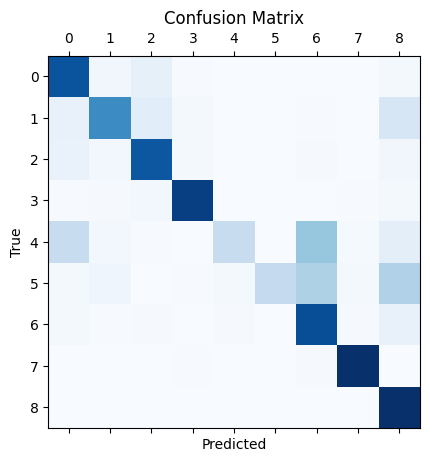

   overall_precision  overall_recall  overall_f1  overall_accuracy
0           0.787053        0.817989    0.802223          0.964703

                   LOC        MISC          ORG          PER
precision     0.771246    0.627837     0.721785     0.948928
recall        0.794365    0.591168     0.827815     0.930736
f1            0.782634    0.608951     0.771172     0.939744
number     1668.000000  702.000000  1661.000000  1617.000000

end of run
---------------------------------------------------
---------------------------------------------------
starting run on training set of 7%



Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['cl

{'eval_loss': 2.42763614654541, 'eval_precision': 0.013340045305814245, 'eval_recall': 0.08445467422096317, 'eval_f1': 0.023040695568168096, 'eval_accuracy': 0.017228383762248303, 'eval_runtime': 6.9986, 'eval_samples_per_second': 493.382, 'eval_steps_per_second': 7.716, 'epoch': 0.02}



  1%|          | 3/310 [00:14<28:31,  5.58s/it]

{'eval_loss': 2.423793077468872, 'eval_precision': 0.013339299197404848, 'eval_recall': 0.08445467422096317, 'eval_f1': 0.023039582679257133, 'eval_accuracy': 0.01755141595779046, 'eval_runtime': 7.0396, 'eval_samples_per_second': 490.509, 'eval_steps_per_second': 7.671, 'epoch': 0.03}



  1%|▏         | 4/310 [00:21<31:55,  6.26s/it]

{'eval_loss': 2.416149854660034, 'eval_precision': 0.013315802724704172, 'eval_recall': 0.08427762039660057, 'eval_f1': 0.02299794661190965, 'eval_accuracy': 0.01817594486917196, 'eval_runtime': 7.2111, 'eval_samples_per_second': 478.846, 'eval_steps_per_second': 7.488, 'epoch': 0.05}



  2%|▏         | 5/310 [00:29<33:56,  6.68s/it]

{'eval_loss': 2.404881000518799, 'eval_precision': 0.013325867861142216, 'eval_recall': 0.08427762039660057, 'eval_f1': 0.023012956874879132, 'eval_accuracy': 0.01920964789490686, 'eval_runtime': 7.3053, 'eval_samples_per_second': 472.671, 'eval_steps_per_second': 7.392, 'epoch': 0.06}



  2%|▏         | 6/310 [00:36<34:59,  6.90s/it]

{'eval_loss': 2.389979362487793, 'eval_precision': 0.013422630723533039, 'eval_recall': 0.08480878186968839, 'eval_f1': 0.023177045531523683, 'eval_accuracy': 0.020652525034995154, 'eval_runtime': 7.263, 'eval_samples_per_second': 475.421, 'eval_steps_per_second': 7.435, 'epoch': 0.08}



  2%|▏         | 7/310 [00:43<35:35,  7.05s/it]

{'eval_loss': 2.3714115619659424, 'eval_precision': 0.013617475292003594, 'eval_recall': 0.08587110481586402, 'eval_f1': 0.023507173322993406, 'eval_accuracy': 0.02304296328200711, 'eval_runtime': 7.2226, 'eval_samples_per_second': 478.085, 'eval_steps_per_second': 7.477, 'epoch': 0.1}



  3%|▎         | 8/310 [00:51<36:07,  7.18s/it]

{'eval_loss': 2.3490962982177734, 'eval_precision': 0.01388302216214694, 'eval_recall': 0.08728753541076487, 'eval_f1': 0.0239558784227022, 'eval_accuracy': 0.026747065790890492, 'eval_runtime': 7.36, 'eval_samples_per_second': 469.161, 'eval_steps_per_second': 7.337, 'epoch': 0.11}



  3%|▎         | 9/310 [00:58<36:11,  7.21s/it]

{'eval_loss': 2.3234050273895264, 'eval_precision': 0.0138594258237873, 'eval_recall': 0.08675637393767706, 'eval_f1': 0.023900690193400482, 'eval_accuracy': 0.03223861311510714, 'eval_runtime': 7.2107, 'eval_samples_per_second': 478.872, 'eval_steps_per_second': 7.489, 'epoch': 0.13}



  3%|▎         | 10/310 [01:05<36:01,  7.21s/it]

{'eval_loss': 2.294175624847412, 'eval_precision': 0.013839450978158727, 'eval_recall': 0.08604815864022664, 'eval_f1': 0.023843983809640625, 'eval_accuracy': 0.04076666307742005, 'eval_runtime': 7.084, 'eval_samples_per_second': 487.435, 'eval_steps_per_second': 7.623, 'epoch': 0.15}



  3%|▎         | 10/310 [01:12<36:01,  7.21s/it]

{'eval_loss': 2.2618067264556885, 'eval_precision': 0.01418521508476531, 'eval_recall': 0.08711048158640226, 'eval_f1': 0.024397500743826246, 'eval_accuracy': 0.05513082803919457, 'eval_runtime': 7.0567, 'eval_samples_per_second': 489.323, 'eval_steps_per_second': 7.652, 'epoch': 0.16}


  4%|▍         | 12/310 [01:21<36:48,  7.41s/it]

{'eval_loss': 2.226257801055908, 'eval_precision': 0.014355474495499206, 'eval_recall': 0.08640226628895184, 'eval_f1': 0.02462035215175824, 'eval_accuracy': 0.07810918488209324, 'eval_runtime': 7.1758, 'eval_samples_per_second': 481.199, 'eval_steps_per_second': 7.525, 'epoch': 0.18}



  4%|▍         | 13/310 [01:28<36:23,  7.35s/it]

{'eval_loss': 2.1877059936523438, 'eval_precision': 0.01442103345679762, 'eval_recall': 0.08410056657223797, 'eval_f1': 0.02462032861659669, 'eval_accuracy': 0.10886184989770648, 'eval_runtime': 7.1208, 'eval_samples_per_second': 484.918, 'eval_steps_per_second': 7.583, 'epoch': 0.19}



  5%|▍         | 14/310 [01:35<36:03,  7.31s/it]

{'eval_loss': 2.145901679992676, 'eval_precision': 0.014588774925144932, 'eval_recall': 0.08109065155807366, 'eval_f1': 0.02472868635602829, 'eval_accuracy': 0.15344029288252395, 'eval_runtime': 7.0977, 'eval_samples_per_second': 486.496, 'eval_steps_per_second': 7.608, 'epoch': 0.21}



  5%|▍         | 15/310 [01:42<36:02,  7.33s/it]

{'eval_loss': 2.1011223793029785, 'eval_precision': 0.014645858343337335, 'eval_recall': 0.07560198300283286, 'eval_f1': 0.024538114530356578, 'eval_accuracy': 0.21378270700979865, 'eval_runtime': 7.2744, 'eval_samples_per_second': 474.68, 'eval_steps_per_second': 7.423, 'epoch': 0.23}



  5%|▌         | 16/310 [01:50<35:40,  7.28s/it]

{'eval_loss': 2.053431510925293, 'eval_precision': 0.015461155759663222, 'eval_recall': 0.07152974504249292, 'eval_f1': 0.02542639561961105, 'eval_accuracy': 0.29079358242704856, 'eval_runtime': 7.0538, 'eval_samples_per_second': 489.521, 'eval_steps_per_second': 7.655, 'epoch': 0.24}



  5%|▌         | 17/310 [01:57<35:16,  7.23s/it]

{'eval_loss': 2.0028116703033447, 'eval_precision': 0.01695914388065116, 'eval_recall': 0.06621813031161473, 'eval_f1': 0.02700263528392477, 'eval_accuracy': 0.38869387315602455, 'eval_runtime': 6.9905, 'eval_samples_per_second': 493.953, 'eval_steps_per_second': 7.725, 'epoch': 0.26}



  6%|▌         | 18/310 [02:04<34:58,  7.19s/it]

{'eval_loss': 1.9496599435806274, 'eval_precision': 0.018067106395182105, 'eval_recall': 0.05577195467422096, 'eval_f1': 0.02729281289260495, 'eval_accuracy': 0.4910735436631851, 'eval_runtime': 6.9831, 'eval_samples_per_second': 494.48, 'eval_steps_per_second': 7.733, 'epoch': 0.27}



  6%|▌         | 19/310 [02:11<34:41,  7.15s/it]

{'eval_loss': 1.8938734531402588, 'eval_precision': 0.01901530692756825, 'eval_recall': 0.0426699716713881, 'eval_f1': 0.02630717170614562, 'eval_accuracy': 0.5926779369010444, 'eval_runtime': 6.9593, 'eval_samples_per_second': 496.173, 'eval_steps_per_second': 7.759, 'epoch': 0.29}



  6%|▋         | 20/310 [02:18<34:25,  7.12s/it]

{'eval_loss': 1.8354649543762207, 'eval_precision': 0.019418646725364853, 'eval_recall': 0.028505665722379604, 'eval_f1': 0.023100652844536912, 'eval_accuracy': 0.6788413911919888, 'eval_runtime': 6.9666, 'eval_samples_per_second': 495.65, 'eval_steps_per_second': 7.751, 'epoch': 0.31}



  6%|▋         | 20/310 [02:25<34:25,  7.12s/it]

{'eval_loss': 1.7739239931106567, 'eval_precision': 0.015703517587939697, 'eval_recall': 0.013279036827195468, 'eval_f1': 0.01438986953184958, 'eval_accuracy': 0.7437923979756649, 'eval_runtime': 6.9313, 'eval_samples_per_second': 498.178, 'eval_steps_per_second': 7.791, 'epoch': 0.32}


  7%|▋         | 22/310 [02:33<35:00,  7.29s/it]

{'eval_loss': 1.709174394607544, 'eval_precision': 0.01200960768614892, 'eval_recall': 0.005311614730878187, 'eval_f1': 0.007365578197888535, 'eval_accuracy': 0.7845159900936793, 'eval_runtime': 7.0309, 'eval_samples_per_second': 491.119, 'eval_steps_per_second': 7.68, 'epoch': 0.34}



  7%|▋         | 23/310 [02:40<34:31,  7.22s/it]

{'eval_loss': 1.6413105726242065, 'eval_precision': 0.011986301369863013, 'eval_recall': 0.002478753541076487, 'eval_f1': 0.0041079812206572764, 'eval_accuracy': 0.8067190696672768, 'eval_runtime': 6.9184, 'eval_samples_per_second': 499.102, 'eval_steps_per_second': 7.805, 'epoch': 0.35}



  8%|▊         | 24/310 [02:47<34:06,  7.16s/it]

{'eval_loss': 1.57111656665802, 'eval_precision': 0.00847457627118644, 'eval_recall': 0.000708215297450425, 'eval_f1': 0.00130718954248366, 'eval_accuracy': 0.8178098417142242, 'eval_runtime': 6.9285, 'eval_samples_per_second': 498.374, 'eval_steps_per_second': 7.794, 'epoch': 0.37}



  8%|▊         | 25/310 [02:54<33:46,  7.11s/it]

{'eval_loss': 1.4989473819732666, 'eval_precision': 0.005494505494505495, 'eval_recall': 0.00017705382436260624, 'eval_f1': 0.00034305317324185257, 'eval_accuracy': 0.8224184343706256, 'eval_runtime': 6.9075, 'eval_samples_per_second': 499.892, 'eval_steps_per_second': 7.818, 'epoch': 0.39}



  8%|▊         | 26/310 [03:01<33:30,  7.08s/it]

{'eval_loss': 1.4248403310775757, 'eval_precision': 0.0136986301369863, 'eval_recall': 0.00017705382436260624, 'eval_f1': 0.0003495892326516343, 'eval_accuracy': 0.8242274146656616, 'eval_runtime': 6.9064, 'eval_samples_per_second': 499.968, 'eval_steps_per_second': 7.819, 'epoch': 0.4}


/home/ronen/Documents/college/NNForNLP/workshop_1/.conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  9%|▊         | 27/310 [03:08<33:17,  7.06s/it]

{'eval_loss': 1.3499306440353394, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8250888338537741, 'eval_runtime': 6.9192, 'eval_samples_per_second': 499.047, 'eval_steps_per_second': 7.804, 'epoch': 0.42}



  9%|▉         | 28/310 [03:15<33:07,  7.05s/it]

{'eval_loss': 1.2749541997909546, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8251749757725854, 'eval_runtime': 6.9284, 'eval_samples_per_second': 498.386, 'eval_steps_per_second': 7.794, 'epoch': 0.44}



  9%|▉         | 29/310 [03:22<33:08,  7.08s/it]

{'eval_loss': 1.200551986694336, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8252395822116938, 'eval_runtime': 7.057, 'eval_samples_per_second': 489.298, 'eval_steps_per_second': 7.652, 'epoch': 0.45}



 10%|▉         | 30/310 [03:29<32:58,  7.07s/it]

{'eval_loss': 1.1279102563858032, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8252826531710994, 'eval_runtime': 6.9183, 'eval_samples_per_second': 499.108, 'eval_steps_per_second': 7.805, 'epoch': 0.47}



 10%|▉         | 30/310 [03:36<32:58,  7.07s/it]

{'eval_loss': 1.0587369203567505, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.911, 'eval_samples_per_second': 499.635, 'eval_steps_per_second': 7.814, 'epoch': 0.48}


 10%|█         | 31/310 [03:37<33:58,  7.31s/it]/home/ronen/Documents/college/NNForNLP/workshop_1/.conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ronen/Documents/college/NNForNLP/workshop_1/.conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 10%|█         | 32/310 [03:44<33:28,  7.22s/it]

{'eval_loss': 0.9947863221168518, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.9018, 'eval_samples_per_second': 500.305, 'eval_steps_per_second': 7.824, 'epoch': 0.5}



 11%|█         | 33/310 [03:51<33:02,  7.16s/it]

{'eval_loss': 0.9378234148025513, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.9169, 'eval_samples_per_second': 499.209, 'eval_steps_per_second': 7.807, 'epoch': 0.52}



 11%|█         | 34/310 [03:58<32:49,  7.13s/it]

{'eval_loss': 0.8902239799499512, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.9513, 'eval_samples_per_second': 496.74, 'eval_steps_per_second': 7.768, 'epoch': 0.53}



 11%|█▏        | 35/310 [04:05<32:31,  7.10s/it]

{'eval_loss': 0.8537518978118896, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.9182, 'eval_samples_per_second': 499.12, 'eval_steps_per_second': 7.806, 'epoch': 0.55}



 12%|█▏        | 36/310 [04:12<32:26,  7.10s/it]

{'eval_loss': 0.8294292092323303, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 7.0172, 'eval_samples_per_second': 492.079, 'eval_steps_per_second': 7.695, 'epoch': 0.56}



 12%|█▏        | 37/310 [04:19<32:11,  7.08s/it]

{'eval_loss': 0.8158384561538696, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.9058, 'eval_samples_per_second': 500.016, 'eval_steps_per_second': 7.82, 'epoch': 0.58}



 12%|█▏        | 38/310 [04:26<31:59,  7.06s/it]

{'eval_loss': 0.8069272041320801, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.9211, 'eval_samples_per_second': 498.912, 'eval_steps_per_second': 7.802, 'epoch': 0.6}



 13%|█▎        | 39/310 [04:33<31:50,  7.05s/it]

{'eval_loss': 0.7983540296554565, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.9237, 'eval_samples_per_second': 498.724, 'eval_steps_per_second': 7.799, 'epoch': 0.61}



 13%|█▎        | 40/310 [04:40<31:43,  7.05s/it]

{'eval_loss': 0.7859835028648376, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.9428, 'eval_samples_per_second': 497.348, 'eval_steps_per_second': 7.778, 'epoch': 0.63}



 13%|█▎        | 40/310 [04:47<31:43,  7.05s/it]

{'eval_loss': 0.7691904306411743, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.9435, 'eval_samples_per_second': 497.3, 'eval_steps_per_second': 7.777, 'epoch': 0.65}


 13%|█▎        | 41/310 [04:48<32:44,  7.30s/it]/home/ronen/Documents/college/NNForNLP/workshop_1/.conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ronen/Documents/college/NNForNLP/workshop_1/.conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 14%|█▎        | 42/310 [04:55<32:15,  7.22s/it]

{'eval_loss': 0.7528737187385559, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.9421, 'eval_samples_per_second': 497.402, 'eval_steps_per_second': 7.779, 'epoch': 0.66}



 14%|█▍        | 43/310 [05:03<32:04,  7.21s/it]

{'eval_loss': 0.7308247685432434, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 7.0518, 'eval_samples_per_second': 489.664, 'eval_steps_per_second': 7.658, 'epoch': 0.68}



 14%|█▍        | 44/310 [05:10<31:41,  7.15s/it]

{'eval_loss': 0.7063755393028259, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.9233, 'eval_samples_per_second': 498.75, 'eval_steps_per_second': 7.8, 'epoch': 0.69}



 15%|█▍        | 45/310 [05:17<31:27,  7.12s/it]

{'eval_loss': 0.6832296252250671, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.9813, 'eval_samples_per_second': 494.605, 'eval_steps_per_second': 7.735, 'epoch': 0.71}



 15%|█▍        | 46/310 [05:24<31:18,  7.11s/it]

{'eval_loss': 0.661957859992981, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.99, 'eval_samples_per_second': 493.991, 'eval_steps_per_second': 7.725, 'epoch': 0.73}



 15%|█▌        | 47/310 [05:31<31:08,  7.10s/it]

{'eval_loss': 0.6434725522994995, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.9836, 'eval_samples_per_second': 494.444, 'eval_steps_per_second': 7.732, 'epoch': 0.74}



 15%|█▌        | 48/310 [05:38<31:01,  7.10s/it]

{'eval_loss': 0.6287990212440491, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 7.0005, 'eval_samples_per_second': 493.253, 'eval_steps_per_second': 7.714, 'epoch': 0.76}



 16%|█▌        | 49/310 [05:45<30:48,  7.08s/it]

{'eval_loss': 0.6159210801124573, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.9366, 'eval_samples_per_second': 497.797, 'eval_steps_per_second': 7.785, 'epoch': 0.77}



 16%|█▌        | 50/310 [05:52<30:47,  7.11s/it]

{'eval_loss': 0.6035369634628296, 'eval_precision': 0.5, 'eval_recall': 0.00017705382436260624, 'eval_f1': 0.00035398230088495576, 'eval_accuracy': 0.825325724130505, 'eval_runtime': 7.046, 'eval_samples_per_second': 490.065, 'eval_steps_per_second': 7.664, 'epoch': 0.79}



 16%|█▌        | 50/310 [05:59<30:47,  7.11s/it]

{'eval_loss': 0.5881792902946472, 'eval_precision': 0.058823529411764705, 'eval_recall': 0.00017705382436260624, 'eval_f1': 0.00035304501323918803, 'eval_accuracy': 0.8254118660493163, 'eval_runtime': 6.9084, 'eval_samples_per_second': 499.828, 'eval_steps_per_second': 7.817, 'epoch': 0.81}


 16%|█▋        | 51/310 [06:00<31:40,  7.34s/it]/home/ronen/Documents/college/NNForNLP/workshop_1/.conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 17%|█▋        | 52/310 [06:07<31:09,  7.25s/it]

{'eval_loss': 0.5689952373504639, 'eval_precision': 0.3246753246753247, 'eval_recall': 0.004426345609065156, 'eval_f1': 0.008733624454148473, 'eval_accuracy': 0.8261440723592118, 'eval_runtime': 6.9274, 'eval_samples_per_second': 498.455, 'eval_steps_per_second': 7.795, 'epoch': 0.82}



 17%|█▋        | 53/310 [06:14<30:46,  7.18s/it]

{'eval_loss': 0.5473476052284241, 'eval_precision': 0.31016042780748665, 'eval_recall': 0.010269121813031162, 'eval_f1': 0.019880034275921166, 'eval_accuracy': 0.8273500592225692, 'eval_runtime': 6.9478, 'eval_samples_per_second': 496.994, 'eval_steps_per_second': 7.772, 'epoch': 0.84}



 17%|█▋        | 54/310 [06:21<30:29,  7.15s/it]

{'eval_loss': 0.5267965197563171, 'eval_precision': 0.3143507972665148, 'eval_recall': 0.02443342776203966, 'eval_f1': 0.045342533267619514, 'eval_accuracy': 0.8303219554215571, 'eval_runtime': 6.9589, 'eval_samples_per_second': 496.199, 'eval_steps_per_second': 7.76, 'epoch': 0.85}



 18%|█▊        | 55/310 [06:28<30:13,  7.11s/it]

{'eval_loss': 0.5095863342285156, 'eval_precision': 0.3469135802469136, 'eval_recall': 0.04975212464589235, 'eval_f1': 0.08702384639207185, 'eval_accuracy': 0.8351674383546893, 'eval_runtime': 6.9485, 'eval_samples_per_second': 496.942, 'eval_steps_per_second': 7.771, 'epoch': 0.87}



 18%|█▊        | 56/310 [06:35<30:03,  7.10s/it]

{'eval_loss': 0.49859222769737244, 'eval_precision': 0.3611774065234686, 'eval_recall': 0.08038243626062323, 'eval_f1': 0.13149891383055756, 'eval_accuracy': 0.8406805211586088, 'eval_runtime': 6.958, 'eval_samples_per_second': 496.261, 'eval_steps_per_second': 7.761, 'epoch': 0.89}



 18%|█▊        | 57/310 [06:42<30:01,  7.12s/it]

{'eval_loss': 0.4907747209072113, 'eval_precision': 0.3327702702702703, 'eval_recall': 0.10463881019830028, 'eval_f1': 0.15921336206896552, 'eval_accuracy': 0.8463012813610423, 'eval_runtime': 7.0591, 'eval_samples_per_second': 489.153, 'eval_steps_per_second': 7.65, 'epoch': 0.9}



 19%|█▊        | 58/310 [06:49<29:47,  7.09s/it]

{'eval_loss': 0.482211172580719, 'eval_precision': 0.3023538961038961, 'eval_recall': 0.13190509915014165, 'eval_f1': 0.18367850098619332, 'eval_accuracy': 0.852804996231291, 'eval_runtime': 6.9284, 'eval_samples_per_second': 498.385, 'eval_steps_per_second': 7.794, 'epoch': 0.92}



 19%|█▉        | 59/310 [06:56<29:35,  7.07s/it]

{'eval_loss': 0.47252392768859863, 'eval_precision': 0.2846153846153846, 'eval_recall': 0.1703257790368272, 'eval_f1': 0.21311475409836064, 'eval_accuracy': 0.8606223753634112, 'eval_runtime': 6.9235, 'eval_samples_per_second': 498.738, 'eval_steps_per_second': 7.8, 'epoch': 0.94}



 19%|█▉        | 60/310 [07:03<29:26,  7.06s/it]

{'eval_loss': 0.4612453579902649, 'eval_precision': 0.26559590316573556, 'eval_recall': 0.2020184135977337, 'eval_f1': 0.22948511665325824, 'eval_accuracy': 0.8672983740712824, 'eval_runtime': 6.9279, 'eval_samples_per_second': 498.421, 'eval_steps_per_second': 7.795, 'epoch': 0.95}



 19%|█▉        | 60/310 [07:10<29:26,  7.06s/it]

{'eval_loss': 0.45008939504623413, 'eval_precision': 0.2593903638151426, 'eval_recall': 0.23353399433427763, 'eval_f1': 0.2457840305599553, 'eval_accuracy': 0.8730914181113384, 'eval_runtime': 6.9649, 'eval_samples_per_second': 495.768, 'eval_steps_per_second': 7.753, 'epoch': 0.97}


 20%|█▉        | 61/310 [07:11<30:27,  7.34s/it]/home/ronen/Documents/college/NNForNLP/workshop_1/.conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 20%|██        | 62/310 [07:18<29:57,  7.25s/it]

{'eval_loss': 0.43983912467956543, 'eval_precision': 0.25380178290508654, 'eval_recall': 0.25708215297450426, 'eval_f1': 0.25543143636203713, 'eval_accuracy': 0.8771831592548724, 'eval_runtime': 6.9752, 'eval_samples_per_second': 495.038, 'eval_steps_per_second': 7.742, 'epoch': 0.98}



 20%|██        | 63/310 [07:26<29:37,  7.20s/it]

{'eval_loss': 0.43156301975250244, 'eval_precision': 0.24884055653286422, 'eval_recall': 0.2754957507082153, 'eval_f1': 0.26149063103940845, 'eval_accuracy': 0.8805857650479164, 'eval_runtime': 6.9549, 'eval_samples_per_second': 496.484, 'eval_steps_per_second': 7.764, 'epoch': 1.0}



 21%|██        | 64/310 [07:33<29:28,  7.19s/it]

{'eval_loss': 0.42429056763648987, 'eval_precision': 0.24461515288447055, 'eval_recall': 0.28753541076487255, 'eval_f1': 0.2643444290713763, 'eval_accuracy': 0.8821578550662216, 'eval_runtime': 7.0694, 'eval_samples_per_second': 488.444, 'eval_steps_per_second': 7.639, 'epoch': 1.02}



 21%|██        | 65/310 [07:40<29:09,  7.14s/it]

{'eval_loss': 0.41732174158096313, 'eval_precision': 0.24591836734693878, 'eval_recall': 0.2986898016997167, 'eval_f1': 0.2697473616885193, 'eval_accuracy': 0.8832130935716593, 'eval_runtime': 6.9304, 'eval_samples_per_second': 498.243, 'eval_steps_per_second': 7.792, 'epoch': 1.03}



 21%|██▏       | 66/310 [07:47<28:55,  7.11s/it]

{'eval_loss': 0.4103034436702728, 'eval_precision': 0.24943278502552468, 'eval_recall': 0.31143767705382436, 'eval_f1': 0.27700787401574806, 'eval_accuracy': 0.8840529772800689, 'eval_runtime': 6.9317, 'eval_samples_per_second': 498.15, 'eval_steps_per_second': 7.79, 'epoch': 1.05}



 22%|██▏       | 67/310 [07:54<28:44,  7.10s/it]

{'eval_loss': 0.4027523398399353, 'eval_precision': 0.2567130605932799, 'eval_recall': 0.323300283286119, 'eval_f1': 0.2861844683018573, 'eval_accuracy': 0.8854527834607516, 'eval_runtime': 6.9278, 'eval_samples_per_second': 498.428, 'eval_steps_per_second': 7.795, 'epoch': 1.06}



 22%|██▏       | 68/310 [08:01<28:31,  7.07s/it]

{'eval_loss': 0.3942798674106598, 'eval_precision': 0.26516537649542576, 'eval_recall': 0.3335694050991501, 'eval_f1': 0.295459891790167, 'eval_accuracy': 0.8870679444384624, 'eval_runtime': 6.9288, 'eval_samples_per_second': 498.356, 'eval_steps_per_second': 7.794, 'epoch': 1.08}



 22%|██▏       | 69/310 [08:08<28:23,  7.07s/it]

{'eval_loss': 0.3864704370498657, 'eval_precision': 0.2781267846944603, 'eval_recall': 0.34490084985835695, 'eval_f1': 0.3079355042680999, 'eval_accuracy': 0.8894153117260687, 'eval_runtime': 6.9385, 'eval_samples_per_second': 497.655, 'eval_steps_per_second': 7.783, 'epoch': 1.1}



 23%|██▎       | 70/310 [08:15<28:16,  7.07s/it]

{'eval_loss': 0.3798582851886749, 'eval_precision': 0.29296875, 'eval_recall': 0.35853399433427763, 'eval_f1': 0.32245222929936307, 'eval_accuracy': 0.8919780338107032, 'eval_runtime': 6.9761, 'eval_samples_per_second': 494.979, 'eval_steps_per_second': 7.741, 'epoch': 1.11}



 23%|██▎       | 70/310 [08:22<28:16,  7.07s/it]

{'eval_loss': 0.3731657862663269, 'eval_precision': 0.3130128956623681, 'eval_recall': 0.3781869688385269, 'eval_f1': 0.34252726106478515, 'eval_accuracy': 0.895294497684936, 'eval_runtime': 7.1278, 'eval_samples_per_second': 484.444, 'eval_steps_per_second': 7.576, 'epoch': 1.13}


 23%|██▎       | 71/310 [08:23<29:24,  7.38s/it]/home/ronen/Documents/college/NNForNLP/workshop_1/.conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 23%|██▎       | 72/310 [08:30<28:59,  7.31s/it]

{'eval_loss': 0.36520758271217346, 'eval_precision': 0.3307387281539139, 'eval_recall': 0.39872521246458925, 'eval_f1': 0.36156377940113993, 'eval_accuracy': 0.8983956067621406, 'eval_runtime': 7.0277, 'eval_samples_per_second': 491.343, 'eval_steps_per_second': 7.684, 'epoch': 1.15}



 24%|██▎       | 73/310 [08:37<28:42,  7.27s/it]

{'eval_loss': 0.35600700974464417, 'eval_precision': 0.34894991922455576, 'eval_recall': 0.4206798866855524, 'eval_f1': 0.3814722645901903, 'eval_accuracy': 0.90130289652202, 'eval_runtime': 7.0706, 'eval_samples_per_second': 488.36, 'eval_steps_per_second': 7.637, 'epoch': 1.16}



 24%|██▍       | 74/310 [08:44<28:19,  7.20s/it]

{'eval_loss': 0.3471061587333679, 'eval_precision': 0.36067975388221507, 'eval_recall': 0.43590651558073656, 'eval_f1': 0.39474106140772813, 'eval_accuracy': 0.9042101862818994, 'eval_runtime': 6.9497, 'eval_samples_per_second': 496.858, 'eval_steps_per_second': 7.77, 'epoch': 1.18}



 24%|██▍       | 75/310 [08:52<28:00,  7.15s/it]

{'eval_loss': 0.3380959928035736, 'eval_precision': 0.3780846063454759, 'eval_recall': 0.4557365439093484, 'eval_f1': 0.4132947976878613, 'eval_accuracy': 0.9078066113922688, 'eval_runtime': 6.935, 'eval_samples_per_second': 497.908, 'eval_steps_per_second': 7.787, 'epoch': 1.19}



 25%|██▍       | 76/310 [08:59<27:43,  7.11s/it]

{'eval_loss': 0.3295145332813263, 'eval_precision': 0.3916360968451944, 'eval_recall': 0.47255665722379603, 'eval_f1': 0.42830779106154215, 'eval_accuracy': 0.910735436631851, 'eval_runtime': 6.9201, 'eval_samples_per_second': 498.98, 'eval_steps_per_second': 7.803, 'epoch': 1.21}



 25%|██▍       | 77/310 [09:06<27:30,  7.08s/it]

{'eval_loss': 0.3208744525909424, 'eval_precision': 0.41314623338257017, 'eval_recall': 0.49521954674220964, 'eval_f1': 0.4504751167659849, 'eval_accuracy': 0.9143318617422203, 'eval_runtime': 6.9257, 'eval_samples_per_second': 498.579, 'eval_steps_per_second': 7.797, 'epoch': 1.23}



 25%|██▌       | 78/310 [09:13<27:28,  7.11s/it]

{'eval_loss': 0.3135116994380951, 'eval_precision': 0.4331382260243134, 'eval_recall': 0.5109773371104815, 'eval_f1': 0.46884899683210135, 'eval_accuracy': 0.9165715516313125, 'eval_runtime': 7.0613, 'eval_samples_per_second': 489.001, 'eval_steps_per_second': 7.647, 'epoch': 1.24}



 25%|██▌       | 79/310 [09:20<27:21,  7.10s/it]

{'eval_loss': 0.3065781593322754, 'eval_precision': 0.449923896499239, 'eval_recall': 0.523371104815864, 'eval_f1': 0.48387624815845476, 'eval_accuracy': 0.9182728545278346, 'eval_runtime': 6.9897, 'eval_samples_per_second': 494.009, 'eval_steps_per_second': 7.726, 'epoch': 1.26}



 26%|██▌       | 80/310 [09:27<27:08,  7.08s/it]

{'eval_loss': 0.3000507354736328, 'eval_precision': 0.4732682473268247, 'eval_recall': 0.5407223796033994, 'eval_f1': 0.5047516734154202, 'eval_accuracy': 0.9209432540109831, 'eval_runtime': 6.9407, 'eval_samples_per_second': 497.503, 'eval_steps_per_second': 7.78, 'epoch': 1.27}



 26%|██▌       | 80/310 [09:34<27:08,  7.08s/it]

{'eval_loss': 0.29337039589881897, 'eval_precision': 0.4886488179113825, 'eval_recall': 0.552584985835694, 'eval_f1': 0.5186539260490236, 'eval_accuracy': 0.9227306988263163, 'eval_runtime': 6.942, 'eval_samples_per_second': 497.408, 'eval_steps_per_second': 7.779, 'epoch': 1.29}


 26%|██▌       | 81/310 [09:35<27:57,  7.32s/it]/home/ronen/Documents/college/NNForNLP/workshop_1/.conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 26%|██▋       | 82/310 [09:42<27:31,  7.24s/it]

{'eval_loss': 0.28830403089523315, 'eval_precision': 0.5096537418222435, 'eval_recall': 0.5655099150141643, 'eval_f1': 0.536130927402434, 'eval_accuracy': 0.9247550339183805, 'eval_runtime': 6.9369, 'eval_samples_per_second': 497.774, 'eval_steps_per_second': 7.784, 'epoch': 1.31}



 27%|██▋       | 83/310 [09:49<27:08,  7.18s/it]

{'eval_loss': 0.2828662097454071, 'eval_precision': 0.5193948173185257, 'eval_recall': 0.5713526912181303, 'eval_f1': 0.5441362448360172, 'eval_accuracy': 0.9257672014644126, 'eval_runtime': 6.9163, 'eval_samples_per_second': 499.255, 'eval_steps_per_second': 7.808, 'epoch': 1.32}



 27%|██▋       | 84/310 [09:56<26:53,  7.14s/it]

{'eval_loss': 0.27707377076148987, 'eval_precision': 0.5292218275750726, 'eval_recall': 0.5803824362606232, 'eval_f1': 0.5536226988684343, 'eval_accuracy': 0.9266716916119306, 'eval_runtime': 6.9316, 'eval_samples_per_second': 498.15, 'eval_steps_per_second': 7.79, 'epoch': 1.34}



 27%|██▋       | 85/310 [10:03<26:46,  7.14s/it]

{'eval_loss': 0.2719438672065735, 'eval_precision': 0.531456154465004, 'eval_recall': 0.5848087818696884, 'eval_f1': 0.5568574559554919, 'eval_accuracy': 0.927080865726284, 'eval_runtime': 7.0572, 'eval_samples_per_second': 489.284, 'eval_steps_per_second': 7.652, 'epoch': 1.35}



 28%|██▊       | 86/310 [10:10<26:31,  7.10s/it]

{'eval_loss': 0.2665608823299408, 'eval_precision': 0.535964353914704, 'eval_recall': 0.5963172804532578, 'eval_f1': 0.5645323499832384, 'eval_accuracy': 0.928222246150533, 'eval_runtime': 6.9323, 'eval_samples_per_second': 498.106, 'eval_steps_per_second': 7.79, 'epoch': 1.37}



 28%|██▊       | 87/310 [10:17<26:21,  7.09s/it]

{'eval_loss': 0.26279130578041077, 'eval_precision': 0.5319383259911894, 'eval_recall': 0.5986189801699717, 'eval_f1': 0.5633122292569144, 'eval_accuracy': 0.9281576397114246, 'eval_runtime': 6.9582, 'eval_samples_per_second': 496.251, 'eval_steps_per_second': 7.761, 'epoch': 1.39}



 28%|██▊       | 88/310 [10:24<26:10,  7.07s/it]

{'eval_loss': 0.25967273116111755, 'eval_precision': 0.5306058713304185, 'eval_recall': 0.601628895184136, 'eval_f1': 0.563889810819781, 'eval_accuracy': 0.928222246150533, 'eval_runtime': 6.9438, 'eval_samples_per_second': 497.28, 'eval_steps_per_second': 7.777, 'epoch': 1.4}



 29%|██▊       | 89/310 [10:31<25:59,  7.06s/it]

{'eval_loss': 0.2570279836654663, 'eval_precision': 0.5280395488954117, 'eval_recall': 0.6051699716713881, 'eval_f1': 0.5639798696477188, 'eval_accuracy': 0.9281361042317218, 'eval_runtime': 6.9319, 'eval_samples_per_second': 498.131, 'eval_steps_per_second': 7.79, 'epoch': 1.42}



 29%|██▉       | 90/310 [10:38<25:51,  7.05s/it]

{'eval_loss': 0.2536129355430603, 'eval_precision': 0.5302023791132396, 'eval_recall': 0.6076487252124646, 'eval_f1': 0.5662899100734262, 'eval_accuracy': 0.9285022073866696, 'eval_runtime': 6.9253, 'eval_samples_per_second': 498.603, 'eval_steps_per_second': 7.797, 'epoch': 1.44}



 29%|██▉       | 90/310 [10:45<25:51,  7.05s/it]

{'eval_loss': 0.2503925561904907, 'eval_precision': 0.529113535105239, 'eval_recall': 0.6097733711048159, 'eval_f1': 0.5665871514353871, 'eval_accuracy': 0.928782168622806, 'eval_runtime': 6.9603, 'eval_samples_per_second': 496.101, 'eval_steps_per_second': 7.758, 'epoch': 1.45}


 30%|██▉       | 92/310 [10:53<26:25,  7.27s/it]

{'eval_loss': 0.24612082540988922, 'eval_precision': 0.5301631271160357, 'eval_recall': 0.6099504249291785, 'eval_f1': 0.567264943191174, 'eval_accuracy': 0.9292990201356736, 'eval_runtime': 7.0585, 'eval_samples_per_second': 489.2, 'eval_steps_per_second': 7.65, 'epoch': 1.47}



 30%|███       | 93/310 [11:00<26:03,  7.21s/it]

{'eval_loss': 0.24213716387748718, 'eval_precision': 0.5357693493678692, 'eval_recall': 0.6152620396600567, 'eval_f1': 0.5727707268831382, 'eval_accuracy': 0.9304619360396252, 'eval_runtime': 6.9532, 'eval_samples_per_second': 496.608, 'eval_steps_per_second': 7.766, 'epoch': 1.48}



 30%|███       | 94/310 [11:07<25:53,  7.19s/it]

{'eval_loss': 0.23902462422847748, 'eval_precision': 0.5389918798835606, 'eval_recall': 0.6228753541076487, 'eval_f1': 0.5779055441478439, 'eval_accuracy': 0.9317756003014968, 'eval_runtime': 7.0461, 'eval_samples_per_second': 490.059, 'eval_steps_per_second': 7.664, 'epoch': 1.5}



 31%|███       | 95/310 [11:15<25:41,  7.17s/it]

{'eval_loss': 0.23593486845493317, 'eval_precision': 0.5413235742604453, 'eval_recall': 0.6285410764872521, 'eval_f1': 0.5816811404227429, 'eval_accuracy': 0.9326370194896091, 'eval_runtime': 7.0109, 'eval_samples_per_second': 492.522, 'eval_steps_per_second': 7.702, 'epoch': 1.52}



 31%|███       | 96/310 [11:22<25:30,  7.15s/it]

{'eval_loss': 0.23285678029060364, 'eval_precision': 0.5447352404138771, 'eval_recall': 0.6338526912181303, 'eval_f1': 0.5859247135842881, 'eval_accuracy': 0.9338214708732637, 'eval_runtime': 7.008, 'eval_samples_per_second': 492.725, 'eval_steps_per_second': 7.706, 'epoch': 1.53}



 31%|███▏      | 97/310 [11:29<25:21,  7.14s/it]

{'eval_loss': 0.22927720844745636, 'eval_precision': 0.5544871794871795, 'eval_recall': 0.6432365439093485, 'eval_f1': 0.5955737704918034, 'eval_accuracy': 0.9352428125336492, 'eval_runtime': 7.0104, 'eval_samples_per_second': 492.554, 'eval_steps_per_second': 7.703, 'epoch': 1.55}



 32%|███▏      | 98/310 [11:36<25:12,  7.14s/it]

{'eval_loss': 0.2252560555934906, 'eval_precision': 0.5694956949569495, 'eval_recall': 0.6558073654390935, 'eval_f1': 0.6096115865701118, 'eval_accuracy': 0.9375901798212555, 'eval_runtime': 7.0105, 'eval_samples_per_second': 492.546, 'eval_steps_per_second': 7.703, 'epoch': 1.56}



 32%|███▏      | 99/310 [11:43<25:13,  7.17s/it]

{'eval_loss': 0.22061662375926971, 'eval_precision': 0.5783113865220759, 'eval_recall': 0.6609419263456091, 'eval_f1': 0.6168718499545567, 'eval_accuracy': 0.9386884892860988, 'eval_runtime': 7.1491, 'eval_samples_per_second': 482.999, 'eval_steps_per_second': 7.553, 'epoch': 1.58}



 32%|███▏      | 100/310 [11:50<25:02,  7.15s/it]

{'eval_loss': 0.21710431575775146, 'eval_precision': 0.5869497346237902, 'eval_recall': 0.6657223796033994, 'eval_f1': 0.623859299817488, 'eval_accuracy': 0.9397006568321309, 'eval_runtime': 7.008, 'eval_samples_per_second': 492.724, 'eval_steps_per_second': 7.705, 'epoch': 1.6}



 32%|███▏      | 100/310 [11:57<25:02,  7.15s/it]

{'eval_loss': 0.21375331282615662, 'eval_precision': 0.5955038515956611, 'eval_recall': 0.6706798866855525, 'eval_f1': 0.6308601881921893, 'eval_accuracy': 0.9410789275331108, 'eval_runtime': 7.016, 'eval_samples_per_second': 492.164, 'eval_steps_per_second': 7.697, 'epoch': 1.61}


 33%|███▎      | 102/310 [12:05<25:22,  7.32s/it]

{'eval_loss': 0.2108701914548874, 'eval_precision': 0.6022151898734177, 'eval_recall': 0.6738668555240793, 'eval_f1': 0.6360294117647058, 'eval_accuracy': 0.9420910950791429, 'eval_runtime': 6.9981, 'eval_samples_per_second': 493.423, 'eval_steps_per_second': 7.716, 'epoch': 1.63}



 33%|███▎      | 103/310 [12:13<25:02,  7.26s/it]

{'eval_loss': 0.20834507048130035, 'eval_precision': 0.609697933227345, 'eval_recall': 0.6790014164305949, 'eval_f1': 0.6424861785893785, 'eval_accuracy': 0.9428663723484441, 'eval_runtime': 7.0154, 'eval_samples_per_second': 492.205, 'eval_steps_per_second': 7.697, 'epoch': 1.65}



 34%|███▎      | 104/310 [12:20<24:45,  7.21s/it]

{'eval_loss': 0.20610548555850983, 'eval_precision': 0.6185979513444302, 'eval_recall': 0.6843130311614731, 'eval_f1': 0.6497982515131137, 'eval_accuracy': 0.9440938946915043, 'eval_runtime': 6.9952, 'eval_samples_per_second': 493.623, 'eval_steps_per_second': 7.72, 'epoch': 1.66}



 34%|███▍      | 105/310 [12:27<24:32,  7.18s/it]

{'eval_loss': 0.20365460216999054, 'eval_precision': 0.6283500161446561, 'eval_recall': 0.6890934844192634, 'eval_f1': 0.6573213984124303, 'eval_accuracy': 0.9454290944330785, 'eval_runtime': 7.0096, 'eval_samples_per_second': 492.607, 'eval_steps_per_second': 7.704, 'epoch': 1.68}



 34%|███▍      | 106/310 [12:34<24:28,  7.20s/it]

{'eval_loss': 0.20146235823631287, 'eval_precision': 0.6330853816300129, 'eval_recall': 0.6931657223796034, 'eval_f1': 0.6617647058823529, 'eval_accuracy': 0.9463335845805966, 'eval_runtime': 7.1559, 'eval_samples_per_second': 482.541, 'eval_steps_per_second': 7.546, 'epoch': 1.69}



 35%|███▍      | 107/310 [12:41<24:15,  7.17s/it]

{'eval_loss': 0.19946685433387756, 'eval_precision': 0.6371867421180275, 'eval_recall': 0.6977691218130312, 'eval_f1': 0.6661032705146624, 'eval_accuracy': 0.9472380747281146, 'eval_runtime': 7.0121, 'eval_samples_per_second': 492.435, 'eval_steps_per_second': 7.701, 'epoch': 1.71}



 35%|███▍      | 108/310 [12:48<24:06,  7.16s/it]

{'eval_loss': 0.19723182916641235, 'eval_precision': 0.642833981841764, 'eval_recall': 0.7020184135977338, 'eval_f1': 0.6711238997968856, 'eval_accuracy': 0.9480133519974158, 'eval_runtime': 7.0444, 'eval_samples_per_second': 490.179, 'eval_steps_per_second': 7.666, 'epoch': 1.73}



 35%|███▌      | 109/310 [12:55<23:56,  7.14s/it]

{'eval_loss': 0.19511418044567108, 'eval_precision': 0.6504302646533529, 'eval_recall': 0.7092776203966006, 'eval_f1': 0.6785805030913865, 'eval_accuracy': 0.9489178421449338, 'eval_runtime': 7.0009, 'eval_samples_per_second': 493.221, 'eval_steps_per_second': 7.713, 'epoch': 1.74}



 35%|███▌      | 110/310 [13:03<23:48,  7.14s/it]

{'eval_loss': 0.19279655814170837, 'eval_precision': 0.660186244077765, 'eval_recall': 0.7154745042492918, 'eval_f1': 0.6867193474381851, 'eval_accuracy': 0.9498223322924518, 'eval_runtime': 7.0328, 'eval_samples_per_second': 490.988, 'eval_steps_per_second': 7.678, 'epoch': 1.76}



 35%|███▌      | 110/310 [13:10<23:48,  7.14s/it]

{'eval_loss': 0.19078069925308228, 'eval_precision': 0.6675959330928173, 'eval_recall': 0.72078611898017, 'eval_f1': 0.6931721437084964, 'eval_accuracy': 0.950597609561753, 'eval_runtime': 7.0407, 'eval_samples_per_second': 490.436, 'eval_steps_per_second': 7.67, 'epoch': 1.77}


 36%|███▌      | 112/310 [13:18<24:14,  7.35s/it]

{'eval_loss': 0.1884106695652008, 'eval_precision': 0.6760633036597429, 'eval_recall': 0.7260977337110481, 'eval_f1': 0.7001878094587674, 'eval_accuracy': 0.9514805642295682, 'eval_runtime': 7.0451, 'eval_samples_per_second': 490.129, 'eval_steps_per_second': 7.665, 'epoch': 1.79}



 36%|███▋      | 113/310 [13:25<24:02,  7.32s/it]

{'eval_loss': 0.18611975014209747, 'eval_precision': 0.6828500414250207, 'eval_recall': 0.7296388101983002, 'eval_f1': 0.7054694855773346, 'eval_accuracy': 0.952298912458275, 'eval_runtime': 7.1697, 'eval_samples_per_second': 481.607, 'eval_steps_per_second': 7.532, 'epoch': 1.81}



 37%|███▋      | 114/310 [13:32<23:45,  7.27s/it]

{'eval_loss': 0.183842733502388, 'eval_precision': 0.6902817136189365, 'eval_recall': 0.7331798866855525, 'eval_f1': 0.7110843994161589, 'eval_accuracy': 0.953095725207279, 'eval_runtime': 7.0752, 'eval_samples_per_second': 488.043, 'eval_steps_per_second': 7.632, 'epoch': 1.82}



 37%|███▋      | 115/310 [13:39<23:28,  7.23s/it]

{'eval_loss': 0.1812945455312729, 'eval_precision': 0.7019311502938707, 'eval_recall': 0.740084985835694, 'eval_f1': 0.7205033181073861, 'eval_accuracy': 0.9540002153547971, 'eval_runtime': 7.0093, 'eval_samples_per_second': 492.63, 'eval_steps_per_second': 7.704, 'epoch': 1.84}



 37%|███▋      | 116/310 [13:46<23:14,  7.19s/it]

{'eval_loss': 0.17870138585567474, 'eval_precision': 0.7077387946953164, 'eval_recall': 0.7464589235127479, 'eval_f1': 0.7265833692373976, 'eval_accuracy': 0.9548831700226122, 'eval_runtime': 6.9924, 'eval_samples_per_second': 493.825, 'eval_steps_per_second': 7.723, 'epoch': 1.85}



 38%|███▊      | 117/310 [13:54<23:04,  7.18s/it]

{'eval_loss': 0.1760059893131256, 'eval_precision': 0.7130886542651248, 'eval_recall': 0.7533640226628895, 'eval_f1': 0.7326732673267325, 'eval_accuracy': 0.9555292344136965, 'eval_runtime': 7.0192, 'eval_samples_per_second': 491.935, 'eval_steps_per_second': 7.693, 'epoch': 1.87}



 38%|███▊      | 118/310 [14:01<22:55,  7.17s/it]

{'eval_loss': 0.17436529695987701, 'eval_precision': 0.7154797726512871, 'eval_recall': 0.7577903682719547, 'eval_f1': 0.7360275150472914, 'eval_accuracy': 0.9557876601701303, 'eval_runtime': 7.0223, 'eval_samples_per_second': 491.721, 'eval_steps_per_second': 7.69, 'epoch': 1.89}



 38%|███▊      | 119/310 [14:08<22:44,  7.15s/it]

{'eval_loss': 0.17326179146766663, 'eval_precision': 0.7168554297135243, 'eval_recall': 0.7620396600566572, 'eval_f1': 0.7387572948849983, 'eval_accuracy': 0.9558738020889416, 'eval_runtime': 7.0153, 'eval_samples_per_second': 492.208, 'eval_steps_per_second': 7.697, 'epoch': 1.9}



 39%|███▊      | 120/310 [14:15<22:39,  7.16s/it]

{'eval_loss': 0.1719515472650528, 'eval_precision': 0.7205269301317325, 'eval_recall': 0.7650495750708215, 'eval_f1': 0.742121082009446, 'eval_accuracy': 0.9561322278453752, 'eval_runtime': 7.0951, 'eval_samples_per_second': 486.672, 'eval_steps_per_second': 7.611, 'epoch': 1.92}



 39%|███▊      | 120/310 [14:22<22:39,  7.16s/it]

{'eval_loss': 0.17052516341209412, 'eval_precision': 0.7231384307846077, 'eval_recall': 0.7685906515580736, 'eval_f1': 0.7451720882327697, 'eval_accuracy': 0.9565414019597287, 'eval_runtime': 6.9693, 'eval_samples_per_second': 495.459, 'eval_steps_per_second': 7.748, 'epoch': 1.94}


 39%|███▉      | 122/310 [14:30<22:50,  7.29s/it]

{'eval_loss': 0.1689777374267578, 'eval_precision': 0.7252875479246541, 'eval_recall': 0.7703611898016998, 'eval_f1': 0.7471451876019576, 'eval_accuracy': 0.9569721115537848, 'eval_runtime': 6.9565, 'eval_samples_per_second': 496.371, 'eval_steps_per_second': 7.763, 'epoch': 1.95}



 40%|███▉      | 123/310 [14:37<22:32,  7.23s/it]

{'eval_loss': 0.16738945245742798, 'eval_precision': 0.7292014700968927, 'eval_recall': 0.7728399433427762, 'eval_f1': 0.7503867973182053, 'eval_accuracy': 0.957295143749327, 'eval_runtime': 6.981, 'eval_samples_per_second': 494.628, 'eval_steps_per_second': 7.735, 'epoch': 1.97}



 40%|████      | 124/310 [14:44<22:13,  7.17s/it]

{'eval_loss': 0.1659303903579712, 'eval_precision': 0.7336010709504686, 'eval_recall': 0.7762039660056658, 'eval_f1': 0.754301445285616, 'eval_accuracy': 0.9575535695057608, 'eval_runtime': 6.9567, 'eval_samples_per_second': 496.355, 'eval_steps_per_second': 7.762, 'epoch': 1.98}



 40%|████      | 125/310 [14:51<21:58,  7.13s/it]

{'eval_loss': 0.16500844061374664, 'eval_precision': 0.733344464852229, 'eval_recall': 0.7776203966005666, 'eval_f1': 0.7548337200309357, 'eval_accuracy': 0.9577689243027888, 'eval_runtime': 6.9492, 'eval_samples_per_second': 496.893, 'eval_steps_per_second': 7.771, 'epoch': 2.0}



 41%|████      | 126/310 [14:58<21:46,  7.10s/it]

{'eval_loss': 0.16440260410308838, 'eval_precision': 0.7357798165137615, 'eval_recall': 0.7809844192634561, 'eval_f1': 0.7577084943743022, 'eval_accuracy': 0.9580704210186282, 'eval_runtime': 6.9459, 'eval_samples_per_second': 497.13, 'eval_steps_per_second': 7.774, 'epoch': 2.02}



 41%|████      | 127/310 [15:05<21:36,  7.08s/it]

{'eval_loss': 0.16363270580768585, 'eval_precision': 0.737508327781479, 'eval_recall': 0.7839943342776204, 'eval_f1': 0.7600411946446962, 'eval_accuracy': 0.9584580596532788, 'eval_runtime': 6.9476, 'eval_samples_per_second': 497.005, 'eval_steps_per_second': 7.772, 'epoch': 2.03}



 41%|████▏     | 128/310 [15:12<21:36,  7.12s/it]

{'eval_loss': 0.16230493783950806, 'eval_precision': 0.7416611074049366, 'eval_recall': 0.7873583569405099, 'eval_f1': 0.7638268636207489, 'eval_accuracy': 0.9589103047270378, 'eval_runtime': 7.1071, 'eval_samples_per_second': 485.854, 'eval_steps_per_second': 7.598, 'epoch': 2.05}



 42%|████▏     | 129/310 [15:19<21:26,  7.11s/it]

{'eval_loss': 0.16008706390857697, 'eval_precision': 0.750669344042838, 'eval_recall': 0.7942634560906515, 'eval_f1': 0.7718513420509292, 'eval_accuracy': 0.9599655432324755, 'eval_runtime': 6.9825, 'eval_samples_per_second': 494.525, 'eval_steps_per_second': 7.734, 'epoch': 2.06}



 42%|████▏     | 130/310 [15:27<21:20,  7.11s/it]

{'eval_loss': 0.15754057466983795, 'eval_precision': 0.7555406312961719, 'eval_recall': 0.796742209631728, 'eval_f1': 0.7755946225439503, 'eval_accuracy': 0.9607408205017767, 'eval_runtime': 7.0216, 'eval_samples_per_second': 491.767, 'eval_steps_per_second': 7.691, 'epoch': 2.08}



 42%|████▏     | 130/310 [15:34<21:20,  7.11s/it]

{'eval_loss': 0.15510383248329163, 'eval_precision': 0.7645762711864407, 'eval_recall': 0.7986898016997167, 'eval_f1': 0.7812608243851749, 'eval_accuracy': 0.9614084203725638, 'eval_runtime': 7.0108, 'eval_samples_per_second': 492.523, 'eval_steps_per_second': 7.702, 'epoch': 2.1}


 43%|████▎     | 132/310 [15:42<21:37,  7.29s/it]

{'eval_loss': 0.15353426337242126, 'eval_precision': 0.7697952218430034, 'eval_recall': 0.7986898016997167, 'eval_f1': 0.7839763642683351, 'eval_accuracy': 0.9618175944869172, 'eval_runtime': 6.9362, 'eval_samples_per_second': 497.823, 'eval_steps_per_second': 7.785, 'epoch': 2.11}



 43%|████▎     | 133/310 [15:49<21:18,  7.22s/it]

{'eval_loss': 0.15225936472415924, 'eval_precision': 0.7732807408677757, 'eval_recall': 0.7983356940509915, 'eval_f1': 0.7856085024827947, 'eval_accuracy': 0.9621190912027565, 'eval_runtime': 6.9526, 'eval_samples_per_second': 496.648, 'eval_steps_per_second': 7.767, 'epoch': 2.13}



 43%|████▎     | 134/310 [15:56<21:00,  7.16s/it]

{'eval_loss': 0.15093709528446198, 'eval_precision': 0.7806685044796692, 'eval_recall': 0.8022308781869688, 'eval_f1': 0.7913028292001397, 'eval_accuracy': 0.9627866910735436, 'eval_runtime': 6.9308, 'eval_samples_per_second': 498.214, 'eval_steps_per_second': 7.791, 'epoch': 2.15}



 44%|████▎     | 135/310 [16:03<20:53,  7.16s/it]

{'eval_loss': 0.1498817503452301, 'eval_precision': 0.7855162855162855, 'eval_recall': 0.8027620396600567, 'eval_f1': 0.794045534150613, 'eval_accuracy': 0.963088187789383, 'eval_runtime': 7.066, 'eval_samples_per_second': 488.679, 'eval_steps_per_second': 7.642, 'epoch': 2.16}



 44%|████▍     | 136/310 [16:10<20:39,  7.12s/it]

{'eval_loss': 0.14884845912456512, 'eval_precision': 0.7883947185545518, 'eval_recall': 0.8034702549575071, 'eval_f1': 0.7958611013679412, 'eval_accuracy': 0.9634758264240336, 'eval_runtime': 6.9462, 'eval_samples_per_second': 497.108, 'eval_steps_per_second': 7.774, 'epoch': 2.18}



 44%|████▍     | 137/310 [16:17<20:27,  7.10s/it]

{'eval_loss': 0.14834731817245483, 'eval_precision': 0.7910057521352624, 'eval_recall': 0.8034702549575071, 'eval_f1': 0.7971892841458059, 'eval_accuracy': 0.9638419295789814, 'eval_runtime': 6.9389, 'eval_samples_per_second': 497.629, 'eval_steps_per_second': 7.782, 'epoch': 2.19}



 45%|████▍     | 138/310 [16:24<20:16,  7.07s/it]

{'eval_loss': 0.1486414670944214, 'eval_precision': 0.7936812707278758, 'eval_recall': 0.8050637393767706, 'eval_f1': 0.7993319855849521, 'eval_accuracy': 0.9642080327339292, 'eval_runtime': 6.9254, 'eval_samples_per_second': 498.599, 'eval_steps_per_second': 7.797, 'epoch': 2.21}



 45%|████▍     | 139/310 [16:31<20:08,  7.06s/it]

{'eval_loss': 0.14980074763298035, 'eval_precision': 0.791550279329609, 'eval_recall': 0.8027620396600567, 'eval_f1': 0.7971167369901546, 'eval_accuracy': 0.9640572843760095, 'eval_runtime': 6.9288, 'eval_samples_per_second': 498.354, 'eval_steps_per_second': 7.794, 'epoch': 2.23}



 45%|████▌     | 140/310 [16:38<19:59,  7.06s/it]

{'eval_loss': 0.15135741233825684, 'eval_precision': 0.7890966276428447, 'eval_recall': 0.7995750708215298, 'eval_f1': 0.79430129276229, 'eval_accuracy': 0.9637127167007645, 'eval_runtime': 6.9369, 'eval_samples_per_second': 497.771, 'eval_steps_per_second': 7.784, 'epoch': 2.24}



 45%|████▌     | 140/310 [16:45<19:59,  7.06s/it]

{'eval_loss': 0.15291231870651245, 'eval_precision': 0.7850043591979076, 'eval_recall': 0.7970963172804533, 'eval_f1': 0.7910041289642449, 'eval_accuracy': 0.9632174006675999, 'eval_runtime': 6.9439, 'eval_samples_per_second': 497.274, 'eval_steps_per_second': 7.777, 'epoch': 2.26}


 46%|████▌     | 142/310 [16:53<20:15,  7.23s/it]

{'eval_loss': 0.15430225431919098, 'eval_precision': 0.7830549756437022, 'eval_recall': 0.7969192634560907, 'eval_f1': 0.78992628992629, 'eval_accuracy': 0.9632174006675999, 'eval_runtime': 6.9504, 'eval_samples_per_second': 496.805, 'eval_steps_per_second': 7.769, 'epoch': 2.27}



 46%|████▌     | 143/310 [17:00<20:04,  7.21s/it]

{'eval_loss': 0.15505369007587433, 'eval_precision': 0.7806652806652806, 'eval_recall': 0.7978045325779037, 'eval_f1': 0.7891418563922942, 'eval_accuracy': 0.9630020458705718, 'eval_runtime': 7.0681, 'eval_samples_per_second': 488.533, 'eval_steps_per_second': 7.64, 'epoch': 2.29}



 46%|████▋     | 144/310 [17:07<19:49,  7.17s/it]

{'eval_loss': 0.15567375719547272, 'eval_precision': 0.7791961359323788, 'eval_recall': 0.7997521246458924, 'eval_f1': 0.7893403232852774, 'eval_accuracy': 0.9628728329923549, 'eval_runtime': 6.9631, 'eval_samples_per_second': 495.899, 'eval_steps_per_second': 7.755, 'epoch': 2.31}



 47%|████▋     | 145/310 [17:14<19:37,  7.14s/it]

{'eval_loss': 0.15652583539485931, 'eval_precision': 0.7780450094485484, 'eval_recall': 0.8018767705382436, 'eval_f1': 0.789781149184759, 'eval_accuracy': 0.9627220846344352, 'eval_runtime': 6.9582, 'eval_samples_per_second': 496.246, 'eval_steps_per_second': 7.761, 'epoch': 2.32}



 47%|████▋     | 146/310 [17:21<19:29,  7.13s/it]

{'eval_loss': 0.15615952014923096, 'eval_precision': 0.7774725274725275, 'eval_recall': 0.8016997167138811, 'eval_f1': 0.7894002789400278, 'eval_accuracy': 0.9626574781953268, 'eval_runtime': 7.0142, 'eval_samples_per_second': 492.286, 'eval_steps_per_second': 7.699, 'epoch': 2.34}



 47%|████▋     | 146/310 [17:29<19:38,  7.19s/it]


{'eval_loss': 0.15483184158802032, 'eval_precision': 0.7801065109087786, 'eval_recall': 0.8040014164305949, 'eval_f1': 0.791873746621327, 'eval_accuracy': 0.9629374394314634, 'eval_runtime': 7.0412, 'eval_samples_per_second': 490.397, 'eval_steps_per_second': 7.669, 'epoch': 2.35}
{'train_runtime': 1049.1648, 'train_samples_per_second': 4.68, 'train_steps_per_second': 0.295, 'train_loss': 0.6497657984903414, 'epoch': 2.35}


100%|██████████| 54/54 [00:06<00:00,  8.08it/s]


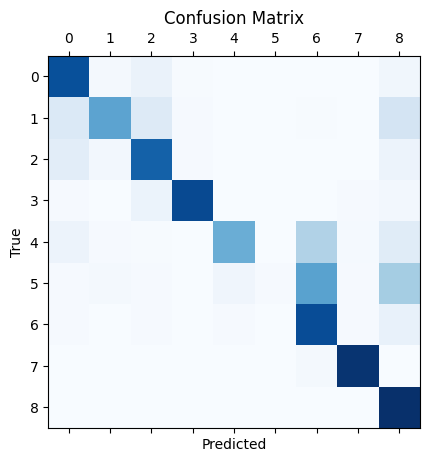

   overall_precision  overall_recall  overall_f1  overall_accuracy
0           0.785004        0.797096    0.791004          0.963217

                   LOC        MISC          ORG          PER
precision     0.777839    0.683027     0.678719     0.963455
recall        0.841727    0.475783     0.791090     0.896722
f1            0.808523    0.560873     0.730609     0.928892
number     1668.000000  702.000000  1661.000000  1617.000000

end of run
---------------------------------------------------
---------------------------------------------------
starting run on training set of 9%



Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['cl

{'eval_loss': 2.431572198867798, 'eval_precision': 0.019631113089057014, 'eval_recall': 0.14058073654390935, 'eval_f1': 0.03445133856901115, 'eval_accuracy': 0.031118768170561, 'eval_runtime': 7.051, 'eval_samples_per_second': 489.717, 'eval_steps_per_second': 7.658, 'epoch': 0.01}



  1%|          | 3/395 [00:14<36:32,  5.59s/it]

{'eval_loss': 2.427901029586792, 'eval_precision': 0.019570488396259092, 'eval_recall': 0.14004957507082152, 'eval_f1': 0.03434203099900143, 'eval_accuracy': 0.03129105200818348, 'eval_runtime': 7.0651, 'eval_samples_per_second': 488.743, 'eval_steps_per_second': 7.643, 'epoch': 0.03}



  1%|          | 4/395 [00:21<40:33,  6.22s/it]

{'eval_loss': 2.4206719398498535, 'eval_precision': 0.01951702786377709, 'eval_recall': 0.1395184135977337, 'eval_f1': 0.03424374769137171, 'eval_accuracy': 0.0317432970819425, 'eval_runtime': 7.0904, 'eval_samples_per_second': 486.994, 'eval_steps_per_second': 7.616, 'epoch': 0.04}



  1%|▏         | 5/395 [00:28<42:47,  6.58s/it]

{'eval_loss': 2.4097797870635986, 'eval_precision': 0.019706634235933582, 'eval_recall': 0.14058073654390935, 'eval_f1': 0.03456757874572803, 'eval_accuracy': 0.03294928394529988, 'eval_runtime': 7.1191, 'eval_samples_per_second': 485.035, 'eval_steps_per_second': 7.585, 'epoch': 0.05}



  2%|▏         | 6/395 [00:36<44:03,  6.80s/it]

{'eval_loss': 2.395233154296875, 'eval_precision': 0.019809865113732516, 'eval_recall': 0.14093484419263455, 'eval_f1': 0.03473707178703906, 'eval_accuracy': 0.034370625605685365, 'eval_runtime': 7.1061, 'eval_samples_per_second': 485.921, 'eval_steps_per_second': 7.599, 'epoch': 0.06}



  2%|▏         | 7/395 [00:43<44:43,  6.92s/it]

{'eval_loss': 2.3771257400512695, 'eval_precision': 0.019948005199480052, 'eval_recall': 0.14128895184135978, 'eval_f1': 0.03496013318145974, 'eval_accuracy': 0.03676106385269732, 'eval_runtime': 7.0533, 'eval_samples_per_second': 489.56, 'eval_steps_per_second': 7.656, 'epoch': 0.08}



  2%|▏         | 8/395 [00:50<45:24,  7.04s/it]

{'eval_loss': 2.355177879333496, 'eval_precision': 0.019938148995549746, 'eval_recall': 0.14040368271954673, 'eval_f1': 0.03491776931375355, 'eval_accuracy': 0.04022827608484979, 'eval_runtime': 7.2114, 'eval_samples_per_second': 478.828, 'eval_steps_per_second': 7.488, 'epoch': 0.09}



  2%|▏         | 9/395 [00:57<45:25,  7.06s/it]

{'eval_loss': 2.3297722339630127, 'eval_precision': 0.020032923895150056, 'eval_recall': 0.14004957507082152, 'eval_f1': 0.03505195754769238, 'eval_accuracy': 0.04574135888876925, 'eval_runtime': 7.0149, 'eval_samples_per_second': 492.237, 'eval_steps_per_second': 7.698, 'epoch': 0.1}



  3%|▎         | 10/395 [01:04<45:27,  7.08s/it]

{'eval_loss': 2.300572633743286, 'eval_precision': 0.02025679062867666, 'eval_recall': 0.14022662889518414, 'eval_f1': 0.03539981227372279, 'eval_accuracy': 0.053666415419403465, 'eval_runtime': 7.0308, 'eval_samples_per_second': 491.122, 'eval_steps_per_second': 7.68, 'epoch': 0.11}



  3%|▎         | 10/395 [01:11<45:27,  7.08s/it]

{'eval_loss': 2.2678298950195312, 'eval_precision': 0.020634631877127784, 'eval_recall': 0.14058073654390935, 'eval_f1': 0.035987037414734746, 'eval_accuracy': 0.06607085172822225, 'eval_runtime': 7.0211, 'eval_samples_per_second': 491.803, 'eval_steps_per_second': 7.691, 'epoch': 0.13}


  3%|▎         | 12/395 [01:19<46:26,  7.27s/it]

{'eval_loss': 2.2316200733184814, 'eval_precision': 0.021218817390378317, 'eval_recall': 0.14111189801699717, 'eval_f1': 0.03689046263509917, 'eval_accuracy': 0.08620652525034996, 'eval_runtime': 7.0214, 'eval_samples_per_second': 491.782, 'eval_steps_per_second': 7.691, 'epoch': 0.14}



  3%|▎         | 13/395 [01:27<46:08,  7.25s/it]

{'eval_loss': 2.1922593116760254, 'eval_precision': 0.021986186401034644, 'eval_recall': 0.14146600566572237, 'eval_f1': 0.03805758651075282, 'eval_accuracy': 0.11583934532141703, 'eval_runtime': 7.0622, 'eval_samples_per_second': 488.944, 'eval_steps_per_second': 7.646, 'epoch': 0.15}



  4%|▎         | 14/395 [01:34<45:55,  7.23s/it]

{'eval_loss': 2.14920711517334, 'eval_precision': 0.023828873280315785, 'eval_recall': 0.1453611898016997, 'eval_f1': 0.04094558874869084, 'eval_accuracy': 0.1641003553354151, 'eval_runtime': 7.1088, 'eval_samples_per_second': 485.735, 'eval_steps_per_second': 7.596, 'epoch': 0.16}



  4%|▍         | 15/395 [01:41<45:48,  7.23s/it]

{'eval_loss': 2.1026501655578613, 'eval_precision': 0.02607602890355011, 'eval_recall': 0.14695467422096317, 'eval_f1': 0.044292651688990874, 'eval_accuracy': 0.22920211047701086, 'eval_runtime': 7.1405, 'eval_samples_per_second': 483.582, 'eval_steps_per_second': 7.563, 'epoch': 0.18}



  4%|▍         | 16/395 [01:48<45:27,  7.20s/it]

{'eval_loss': 2.052649736404419, 'eval_precision': 0.028430509071692797, 'eval_recall': 0.14288243626062322, 'eval_f1': 0.047424558516733765, 'eval_accuracy': 0.3106277592333369, 'eval_runtime': 7.0058, 'eval_samples_per_second': 492.879, 'eval_steps_per_second': 7.708, 'epoch': 0.19}



  4%|▍         | 17/395 [01:55<45:07,  7.16s/it]

{'eval_loss': 1.999372124671936, 'eval_precision': 0.03120888157894737, 'eval_recall': 0.13438385269121814, 'eval_f1': 0.05065403096636412, 'eval_accuracy': 0.4008614191881124, 'eval_runtime': 6.9728, 'eval_samples_per_second': 495.207, 'eval_steps_per_second': 7.744, 'epoch': 0.2}



  5%|▍         | 18/395 [02:02<44:51,  7.14s/it]

{'eval_loss': 1.9425143003463745, 'eval_precision': 0.034301452178267404, 'eval_recall': 0.12128186968838527, 'eval_f1': 0.05347802326489187, 'eval_accuracy': 0.4915903951760525, 'eval_runtime': 6.9662, 'eval_samples_per_second': 495.681, 'eval_steps_per_second': 7.752, 'epoch': 0.22}



  5%|▍         | 19/395 [02:09<44:34,  7.11s/it]

{'eval_loss': 1.8819522857666016, 'eval_precision': 0.03503535976124051, 'eval_recall': 0.09560906515580736, 'eval_f1': 0.05127961635249988, 'eval_accuracy': 0.5804457844298482, 'eval_runtime': 6.961, 'eval_samples_per_second': 496.05, 'eval_steps_per_second': 7.758, 'epoch': 0.23}



  5%|▌         | 20/395 [02:16<44:19,  7.09s/it]

{'eval_loss': 1.817584753036499, 'eval_precision': 0.03646815772927333, 'eval_recall': 0.07188385269121814, 'eval_f1': 0.048388057922650614, 'eval_accuracy': 0.6587703241089695, 'eval_runtime': 6.9457, 'eval_samples_per_second': 497.144, 'eval_steps_per_second': 7.775, 'epoch': 0.24}



  5%|▌         | 20/395 [02:23<44:19,  7.09s/it]

{'eval_loss': 1.7491751909255981, 'eval_precision': 0.03524171361194812, 'eval_recall': 0.04762747875354108, 'eval_f1': 0.04050899781642948, 'eval_accuracy': 0.7158178098417142, 'eval_runtime': 6.9167, 'eval_samples_per_second': 499.226, 'eval_steps_per_second': 7.807, 'epoch': 0.25}


  6%|▌         | 22/395 [02:31<45:12,  7.27s/it]

{'eval_loss': 1.6769896745681763, 'eval_precision': 0.037176191417836665, 'eval_recall': 0.03328611898016997, 'eval_f1': 0.03512377393741243, 'eval_accuracy': 0.7551846667384516, 'eval_runtime': 7.0565, 'eval_samples_per_second': 489.338, 'eval_steps_per_second': 7.653, 'epoch': 0.27}



  6%|▌         | 23/395 [02:38<44:35,  7.19s/it]

{'eval_loss': 1.6021277904510498, 'eval_precision': 0.04326174914410209, 'eval_recall': 0.024610481586402267, 'eval_f1': 0.03137343414964451, 'eval_accuracy': 0.7821470873263702, 'eval_runtime': 6.9071, 'eval_samples_per_second': 499.919, 'eval_steps_per_second': 7.818, 'epoch': 0.28}



  6%|▌         | 24/395 [02:45<44:10,  7.14s/it]

{'eval_loss': 1.524556040763855, 'eval_precision': 0.045793927327028375, 'eval_recall': 0.016288951841359773, 'eval_f1': 0.024030299072743896, 'eval_accuracy': 0.7984494454613976, 'eval_runtime': 6.9136, 'eval_samples_per_second': 499.45, 'eval_steps_per_second': 7.811, 'epoch': 0.29}



  6%|▋         | 25/395 [02:52<43:52,  7.12s/it]

{'eval_loss': 1.444503664970398, 'eval_precision': 0.060430463576158944, 'eval_recall': 0.012924929178470254, 'eval_f1': 0.021295215869311553, 'eval_accuracy': 0.8102724238182406, 'eval_runtime': 6.9107, 'eval_samples_per_second': 499.662, 'eval_steps_per_second': 7.814, 'epoch': 0.3}



  7%|▋         | 26/395 [02:59<43:36,  7.09s/it]

{'eval_loss': 1.3621437549591064, 'eval_precision': 0.07338129496402877, 'eval_recall': 0.009029745042492918, 'eval_f1': 0.016080718902727414, 'eval_accuracy': 0.8170345644449231, 'eval_runtime': 6.9228, 'eval_samples_per_second': 498.789, 'eval_steps_per_second': 7.8, 'epoch': 0.32}



  7%|▋         | 27/395 [03:07<43:26,  7.08s/it]

{'eval_loss': 1.2785223722457886, 'eval_precision': 0.06504065040650407, 'eval_recall': 0.00424929178470255, 'eval_f1': 0.007977397374106698, 'eval_accuracy': 0.8209324862711317, 'eval_runtime': 6.9582, 'eval_samples_per_second': 496.252, 'eval_steps_per_second': 7.761, 'epoch': 0.33}


/home/ronen/Documents/college/NNForNLP/workshop_1/.conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  7%|▋         | 28/395 [03:14<43:14,  7.07s/it]

{'eval_loss': 1.1957378387451172, 'eval_precision': 0.06547619047619048, 'eval_recall': 0.0019475920679886685, 'eval_f1': 0.003782668500687758, 'eval_accuracy': 0.8234736728760633, 'eval_runtime': 6.94, 'eval_samples_per_second': 497.552, 'eval_steps_per_second': 7.781, 'epoch': 0.34}



  7%|▋         | 29/395 [03:21<43:27,  7.12s/it]

{'eval_loss': 1.115433931350708, 'eval_precision': 0.09523809523809523, 'eval_recall': 0.0010623229461756375, 'eval_f1': 0.0021012081947119595, 'eval_accuracy': 0.8246365887800151, 'eval_runtime': 7.1333, 'eval_samples_per_second': 484.065, 'eval_steps_per_second': 7.57, 'epoch': 0.35}



  8%|▊         | 30/395 [03:28<43:07,  7.09s/it]

{'eval_loss': 1.0404809713363647, 'eval_precision': 0.13636363636363635, 'eval_recall': 0.0005311614730878187, 'eval_f1': 0.0010582010582010583, 'eval_accuracy': 0.8251103693334769, 'eval_runtime': 6.9249, 'eval_samples_per_second': 498.636, 'eval_steps_per_second': 7.798, 'epoch': 0.37}



  8%|▊         | 30/395 [03:35<43:07,  7.09s/it]

{'eval_loss': 0.9729666113853455, 'eval_precision': 0.2857142857142857, 'eval_recall': 0.0003541076487252125, 'eval_f1': 0.0007073386383731211, 'eval_accuracy': 0.8252395822116938, 'eval_runtime': 6.9168, 'eval_samples_per_second': 499.216, 'eval_steps_per_second': 7.807, 'epoch': 0.38}


  8%|▊         | 31/395 [03:36<44:26,  7.33s/it]/home/ronen/Documents/college/NNForNLP/workshop_1/.conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  8%|▊         | 32/395 [03:43<43:43,  7.23s/it]

{'eval_loss': 0.9158060550689697, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8252826531710994, 'eval_runtime': 6.8915, 'eval_samples_per_second': 501.052, 'eval_steps_per_second': 7.836, 'epoch': 0.39}



  8%|▊         | 33/395 [03:50<43:13,  7.16s/it]

{'eval_loss': 0.8716036677360535, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8252826531710994, 'eval_runtime': 6.9222, 'eval_samples_per_second': 498.829, 'eval_steps_per_second': 7.801, 'epoch': 0.41}


/home/ronen/Documents/college/NNForNLP/workshop_1/.conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  9%|▊         | 34/395 [03:57<42:51,  7.12s/it]

{'eval_loss': 0.841120183467865, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.9269, 'eval_samples_per_second': 498.489, 'eval_steps_per_second': 7.796, 'epoch': 0.42}



  9%|▉         | 35/395 [04:04<42:36,  7.10s/it]

{'eval_loss': 0.8246183395385742, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.9391, 'eval_samples_per_second': 497.613, 'eval_steps_per_second': 7.782, 'epoch': 0.43}



  9%|▉         | 36/395 [04:11<42:35,  7.12s/it]

{'eval_loss': 0.8181365728378296, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 7.035, 'eval_samples_per_second': 490.828, 'eval_steps_per_second': 7.676, 'epoch': 0.44}



  9%|▉         | 37/395 [04:18<42:18,  7.09s/it]

{'eval_loss': 0.8198108077049255, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.9166, 'eval_samples_per_second': 499.234, 'eval_steps_per_second': 7.807, 'epoch': 0.46}



 10%|▉         | 38/395 [04:25<42:04,  7.07s/it]

{'eval_loss': 0.8166992664337158, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.9149, 'eval_samples_per_second': 499.357, 'eval_steps_per_second': 7.809, 'epoch': 0.47}



 10%|▉         | 39/395 [04:32<41:50,  7.05s/it]

{'eval_loss': 0.8062177300453186, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.9051, 'eval_samples_per_second': 500.065, 'eval_steps_per_second': 7.82, 'epoch': 0.48}



 10%|█         | 40/395 [04:39<41:39,  7.04s/it]

{'eval_loss': 0.7848061323165894, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.9135, 'eval_samples_per_second': 499.454, 'eval_steps_per_second': 7.811, 'epoch': 0.49}



 10%|█         | 40/395 [04:46<41:39,  7.04s/it]

{'eval_loss': 0.7556242942810059, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.9257, 'eval_samples_per_second': 498.58, 'eval_steps_per_second': 7.797, 'epoch': 0.51}


 10%|█         | 41/395 [04:47<43:00,  7.29s/it]/home/ronen/Documents/college/NNForNLP/workshop_1/.conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ronen/Documents/college/NNForNLP/workshop_1/.conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 11%|█         | 42/395 [04:54<42:24,  7.21s/it]

{'eval_loss': 0.7249504327774048, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.8989, 'eval_samples_per_second': 500.513, 'eval_steps_per_second': 7.827, 'epoch': 0.52}



 11%|█         | 43/395 [05:01<42:10,  7.19s/it]

{'eval_loss': 0.6942234635353088, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 7.0504, 'eval_samples_per_second': 489.761, 'eval_steps_per_second': 7.659, 'epoch': 0.53}



 11%|█         | 44/395 [05:08<41:43,  7.13s/it]

{'eval_loss': 0.6666926741600037, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.9063, 'eval_samples_per_second': 499.978, 'eval_steps_per_second': 7.819, 'epoch': 0.54}



 11%|█▏        | 45/395 [05:15<41:26,  7.10s/it]

{'eval_loss': 0.6442129611968994, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.93, 'eval_samples_per_second': 498.272, 'eval_steps_per_second': 7.792, 'epoch': 0.56}



 12%|█▏        | 46/395 [05:22<41:11,  7.08s/it]

{'eval_loss': 0.6253520250320435, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.9467, 'eval_samples_per_second': 497.073, 'eval_steps_per_second': 7.774, 'epoch': 0.57}



 12%|█▏        | 47/395 [05:29<41:00,  7.07s/it]

{'eval_loss': 0.6099752187728882, 'eval_precision': 0.5, 'eval_recall': 0.00017705382436260624, 'eval_f1': 0.00035398230088495576, 'eval_accuracy': 0.825325724130505, 'eval_runtime': 6.9571, 'eval_samples_per_second': 496.33, 'eval_steps_per_second': 7.762, 'epoch': 0.58}



 12%|█▏        | 48/395 [05:36<40:47,  7.05s/it]

{'eval_loss': 0.5963782072067261, 'eval_precision': 0.4444444444444444, 'eval_recall': 0.000708215297450425, 'eval_f1': 0.0014141771256849921, 'eval_accuracy': 0.8253903305696134, 'eval_runtime': 6.9312, 'eval_samples_per_second': 498.184, 'eval_steps_per_second': 7.791, 'epoch': 0.59}



 12%|█▏        | 49/395 [05:43<40:50,  7.08s/it]

{'eval_loss': 0.5817307829856873, 'eval_precision': 0.5925925925925926, 'eval_recall': 0.0028328611898017, 'eval_f1': 0.005638766519823788, 'eval_accuracy': 0.8256487563260472, 'eval_runtime': 7.0244, 'eval_samples_per_second': 491.573, 'eval_steps_per_second': 7.687, 'epoch': 0.61}



 13%|█▎        | 50/395 [05:50<40:51,  7.10s/it]

{'eval_loss': 0.565128743648529, 'eval_precision': 0.4444444444444444, 'eval_recall': 0.0056657223796034, 'eval_f1': 0.011188811188811189, 'eval_accuracy': 0.8260363949606977, 'eval_runtime': 7.0509, 'eval_samples_per_second': 489.723, 'eval_steps_per_second': 7.659, 'epoch': 0.62}



 13%|█▎        | 50/395 [05:57<40:51,  7.10s/it]

{'eval_loss': 0.5468900799751282, 'eval_precision': 0.4014084507042254, 'eval_recall': 0.010092067988668555, 'eval_f1': 0.019689119170984454, 'eval_accuracy': 0.8267470657908905, 'eval_runtime': 6.931, 'eval_samples_per_second': 498.193, 'eval_steps_per_second': 7.791, 'epoch': 0.63}


 13%|█▎        | 52/395 [06:05<41:27,  7.25s/it]

{'eval_loss': 0.5276172161102295, 'eval_precision': 0.3474025974025974, 'eval_recall': 0.018944759206798868, 'eval_f1': 0.03593015446608462, 'eval_accuracy': 0.8282545493700872, 'eval_runtime': 6.9368, 'eval_samples_per_second': 497.777, 'eval_steps_per_second': 7.785, 'epoch': 0.65}


/home/ronen/Documents/college/NNForNLP/workshop_1/.conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 13%|█▎        | 53/395 [06:12<41:00,  7.19s/it]

{'eval_loss': 0.5092648863792419, 'eval_precision': 0.34379905808477235, 'eval_recall': 0.03877478753541076, 'eval_f1': 0.06968973747016706, 'eval_accuracy': 0.8317217616022397, 'eval_runtime': 6.9421, 'eval_samples_per_second': 497.401, 'eval_steps_per_second': 7.779, 'epoch': 0.66}



 14%|█▎        | 54/395 [06:20<40:39,  7.15s/it]

{'eval_loss': 0.4930010437965393, 'eval_precision': 0.38508239375542064, 'eval_recall': 0.07861189801699717, 'eval_f1': 0.1305690339655933, 'eval_accuracy': 0.8382254764724885, 'eval_runtime': 6.9387, 'eval_samples_per_second': 497.645, 'eval_steps_per_second': 7.782, 'epoch': 0.67}



 14%|█▍        | 55/395 [06:27<40:19,  7.12s/it]

{'eval_loss': 0.47931769490242004, 'eval_precision': 0.39262114537444937, 'eval_recall': 0.12623937677053823, 'eval_f1': 0.19105037513397644, 'eval_accuracy': 0.8470550231506406, 'eval_runtime': 6.9361, 'eval_samples_per_second': 497.83, 'eval_steps_per_second': 7.785, 'epoch': 0.68}



 14%|█▍        | 56/395 [06:34<40:04,  7.09s/it]

{'eval_loss': 0.4668140709400177, 'eval_precision': 0.3570042685292976, 'eval_recall': 0.16288951841359772, 'eval_f1': 0.2237082066869301, 'eval_accuracy': 0.855432324755034, 'eval_runtime': 6.9458, 'eval_samples_per_second': 497.134, 'eval_steps_per_second': 7.774, 'epoch': 0.7}



 14%|█▍        | 57/395 [06:41<40:01,  7.11s/it]

{'eval_loss': 0.45442602038383484, 'eval_precision': 0.32038834951456313, 'eval_recall': 0.19281161473087818, 'eval_f1': 0.24074278766441914, 'eval_accuracy': 0.8630774200495316, 'eval_runtime': 7.0529, 'eval_samples_per_second': 489.587, 'eval_steps_per_second': 7.656, 'epoch': 0.71}



 15%|█▍        | 58/395 [06:48<39:46,  7.08s/it]

{'eval_loss': 0.4426477253437042, 'eval_precision': 0.30209324452902, 'eval_recall': 0.2248583569405099, 'eval_f1': 0.2578156719447828, 'eval_accuracy': 0.8704640895875956, 'eval_runtime': 6.9216, 'eval_samples_per_second': 498.872, 'eval_steps_per_second': 7.802, 'epoch': 0.72}



 15%|█▍        | 59/395 [06:55<39:33,  7.07s/it]

{'eval_loss': 0.43154177069664, 'eval_precision': 0.29904306220095694, 'eval_recall': 0.26558073654390935, 'eval_f1': 0.2813203300825206, 'eval_accuracy': 0.8786045009152579, 'eval_runtime': 6.9432, 'eval_samples_per_second': 497.322, 'eval_steps_per_second': 7.777, 'epoch': 0.73}



 15%|█▌        | 60/395 [07:02<39:24,  7.06s/it]

{'eval_loss': 0.42112624645233154, 'eval_precision': 0.2971673819742489, 'eval_recall': 0.3064801699716714, 'eval_f1': 0.30175193933583194, 'eval_accuracy': 0.8856250672983741, 'eval_runtime': 6.9466, 'eval_samples_per_second': 497.076, 'eval_steps_per_second': 7.774, 'epoch': 0.75}



 15%|█▌        | 60/395 [07:09<39:24,  7.06s/it]

{'eval_loss': 0.4112491309642792, 'eval_precision': 0.3026315789473684, 'eval_recall': 0.34206798866855526, 'eval_f1': 0.3211436170212766, 'eval_accuracy': 0.8908151179067514, 'eval_runtime': 6.9446, 'eval_samples_per_second': 497.223, 'eval_steps_per_second': 7.776, 'epoch': 0.76}


 16%|█▌        | 62/395 [07:17<40:08,  7.23s/it]

{'eval_loss': 0.40315917134284973, 'eval_precision': 0.3025911286780852, 'eval_recall': 0.36597025495750707, 'eval_f1': 0.33127654459491945, 'eval_accuracy': 0.8936147302681168, 'eval_runtime': 6.9413, 'eval_samples_per_second': 497.454, 'eval_steps_per_second': 7.779, 'epoch': 0.77}



 16%|█▌        | 63/395 [07:24<39:41,  7.17s/it]

{'eval_loss': 0.3981451988220215, 'eval_precision': 0.3090959743696894, 'eval_recall': 0.39288243626062325, 'eval_f1': 0.3459889296016216, 'eval_accuracy': 0.8963497361903736, 'eval_runtime': 6.9335, 'eval_samples_per_second': 498.015, 'eval_steps_per_second': 7.788, 'epoch': 0.78}



 16%|█▌        | 64/395 [07:31<39:31,  7.16s/it]

{'eval_loss': 0.39504414796829224, 'eval_precision': 0.31045095677773316, 'eval_recall': 0.41076487252124644, 'eval_f1': 0.35363158295861596, 'eval_accuracy': 0.8972111553784861, 'eval_runtime': 7.0631, 'eval_samples_per_second': 488.877, 'eval_steps_per_second': 7.645, 'epoch': 0.8}



 16%|█▋        | 65/395 [07:38<39:12,  7.13s/it]

{'eval_loss': 0.3908419907093048, 'eval_precision': 0.31399764305355504, 'eval_recall': 0.42457507082152973, 'eval_f1': 0.3610086563793752, 'eval_accuracy': 0.8983956067621406, 'eval_runtime': 6.9451, 'eval_samples_per_second': 497.181, 'eval_steps_per_second': 7.775, 'epoch': 0.81}



 17%|█▋        | 66/395 [07:45<38:58,  7.11s/it]

{'eval_loss': 0.38378071784973145, 'eval_precision': 0.32074488865737727, 'eval_recall': 0.4360835694050991, 'eval_f1': 0.36962557214676967, 'eval_accuracy': 0.9000323032195542, 'eval_runtime': 6.9497, 'eval_samples_per_second': 496.853, 'eval_steps_per_second': 7.77, 'epoch': 0.82}



 17%|█▋        | 67/395 [07:52<38:44,  7.09s/it]

{'eval_loss': 0.37358683347702026, 'eval_precision': 0.3397764628533859, 'eval_recall': 0.45750708215297453, 'eval_f1': 0.3899494454085867, 'eval_accuracy': 0.903348767093787, 'eval_runtime': 6.9476, 'eval_samples_per_second': 497.005, 'eval_steps_per_second': 7.772, 'epoch': 0.84}



 17%|█▋        | 68/395 [07:59<38:34,  7.08s/it]

{'eval_loss': 0.3617863953113556, 'eval_precision': 0.3588854819357419, 'eval_recall': 0.476628895184136, 'eval_f1': 0.4094607954977565, 'eval_accuracy': 0.9067298374071282, 'eval_runtime': 6.9459, 'eval_samples_per_second': 497.125, 'eval_steps_per_second': 7.774, 'epoch': 0.85}



 17%|█▋        | 69/395 [08:06<38:23,  7.06s/it]

{'eval_loss': 0.3486859202384949, 'eval_precision': 0.38120032885722116, 'eval_recall': 0.49256373937677056, 'eval_f1': 0.4297852618569442, 'eval_accuracy': 0.9101755141595779, 'eval_runtime': 6.9406, 'eval_samples_per_second': 497.507, 'eval_steps_per_second': 7.78, 'epoch': 0.86}



 18%|█▊        | 70/395 [08:13<38:14,  7.06s/it]

{'eval_loss': 0.33571746945381165, 'eval_precision': 0.4077174067243581, 'eval_recall': 0.5088526912181303, 'eval_f1': 0.45270536347168616, 'eval_accuracy': 0.9143103262625175, 'eval_runtime': 6.9513, 'eval_samples_per_second': 496.738, 'eval_steps_per_second': 7.768, 'epoch': 0.87}



 18%|█▊        | 70/395 [08:20<38:14,  7.06s/it]

{'eval_loss': 0.32468512654304504, 'eval_precision': 0.4376845835794448, 'eval_recall': 0.5247875354107648, 'eval_f1': 0.47729468599033814, 'eval_accuracy': 0.918229783568429, 'eval_runtime': 7.0681, 'eval_samples_per_second': 488.532, 'eval_steps_per_second': 7.64, 'epoch': 0.89}


 18%|█▊        | 71/395 [08:21<39:39,  7.34s/it]/home/ronen/Documents/college/NNForNLP/workshop_1/.conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 18%|█▊        | 72/395 [08:28<39:01,  7.25s/it]

{'eval_loss': 0.31717896461486816, 'eval_precision': 0.4607977991746905, 'eval_recall': 0.5338172804532578, 'eval_f1': 0.49462718398818806, 'eval_accuracy': 0.9214816410035533, 'eval_runtime': 6.9292, 'eval_samples_per_second': 498.324, 'eval_steps_per_second': 7.793, 'epoch': 0.9}



 18%|█▊        | 73/395 [08:35<38:35,  7.19s/it]

{'eval_loss': 0.3128299117088318, 'eval_precision': 0.48271507498026833, 'eval_recall': 0.5414305949008499, 'eval_f1': 0.5103897187682551, 'eval_accuracy': 0.923333692257995, 'eval_runtime': 6.9221, 'eval_samples_per_second': 498.835, 'eval_steps_per_second': 7.801, 'epoch': 0.91}



 19%|█▊        | 74/395 [08:42<38:13,  7.14s/it]

{'eval_loss': 0.3089987337589264, 'eval_precision': 0.4967855994856959, 'eval_recall': 0.5472733711048159, 'eval_f1': 0.5208087615838248, 'eval_accuracy': 0.9248627113168946, 'eval_runtime': 6.9233, 'eval_samples_per_second': 498.753, 'eval_steps_per_second': 7.8, 'epoch': 0.92}



 19%|█▉        | 75/395 [08:49<37:57,  7.12s/it]

{'eval_loss': 0.30369332432746887, 'eval_precision': 0.5084388185654009, 'eval_recall': 0.5547096317280453, 'eval_f1': 0.530567315834039, 'eval_accuracy': 0.9262625174975773, 'eval_runtime': 6.9437, 'eval_samples_per_second': 497.283, 'eval_steps_per_second': 7.777, 'epoch': 0.94}



 19%|█▉        | 76/395 [08:56<37:40,  7.09s/it]

{'eval_loss': 0.29746899008750916, 'eval_precision': 0.5219879025666176, 'eval_recall': 0.5653328611898017, 'eval_f1': 0.5427964300892477, 'eval_accuracy': 0.927877678475288, 'eval_runtime': 6.9206, 'eval_samples_per_second': 498.946, 'eval_steps_per_second': 7.803, 'epoch': 0.95}



 19%|█▉        | 77/395 [09:03<37:27,  7.07s/it]

{'eval_loss': 0.2897922396659851, 'eval_precision': 0.5364651773981604, 'eval_recall': 0.578257790368272, 'eval_f1': 0.5565780504430812, 'eval_accuracy': 0.9298589426079465, 'eval_runtime': 6.939, 'eval_samples_per_second': 497.625, 'eval_steps_per_second': 7.782, 'epoch': 0.96}



 20%|█▉        | 78/395 [09:11<37:27,  7.09s/it]

{'eval_loss': 0.28197744488716125, 'eval_precision': 0.5479159829340334, 'eval_recall': 0.5911827195467422, 'eval_f1': 0.5687276443536025, 'eval_accuracy': 0.9313879616668461, 'eval_runtime': 7.038, 'eval_samples_per_second': 490.622, 'eval_steps_per_second': 7.673, 'epoch': 0.97}



 20%|██        | 79/395 [09:18<37:15,  7.08s/it]

{'eval_loss': 0.2741684019565582, 'eval_precision': 0.5591943671196987, 'eval_recall': 0.6046388101983002, 'eval_f1': 0.5810293492131009, 'eval_accuracy': 0.9329385162054484, 'eval_runtime': 6.9516, 'eval_samples_per_second': 496.722, 'eval_steps_per_second': 7.768, 'epoch': 0.99}



 20%|██        | 80/395 [09:25<37:06,  7.07s/it]

{'eval_loss': 0.26715636253356934, 'eval_precision': 0.5639024390243902, 'eval_recall': 0.6140226628895185, 'eval_f1': 0.5878962536023055, 'eval_accuracy': 0.9333907612792075, 'eval_runtime': 6.9365, 'eval_samples_per_second': 497.801, 'eval_steps_per_second': 7.785, 'epoch': 1.0}



 20%|██        | 80/395 [09:32<37:06,  7.07s/it]

{'eval_loss': 0.26137804985046387, 'eval_precision': 0.5708762886597938, 'eval_recall': 0.6274787535410765, 'eval_f1': 0.5978407557354926, 'eval_accuracy': 0.9345536771831593, 'eval_runtime': 7.0015, 'eval_samples_per_second': 493.183, 'eval_steps_per_second': 7.713, 'epoch': 1.01}


 21%|██        | 82/395 [09:40<37:58,  7.28s/it]

{'eval_loss': 0.2566247880458832, 'eval_precision': 0.5781601801222258, 'eval_recall': 0.6365084985835694, 'eval_f1': 0.6059329175796393, 'eval_accuracy': 0.9353074189727576, 'eval_runtime': 6.9587, 'eval_samples_per_second': 496.211, 'eval_steps_per_second': 7.76, 'epoch': 1.03}



 21%|██        | 83/395 [09:47<37:30,  7.21s/it]

{'eval_loss': 0.25220927596092224, 'eval_precision': 0.5874453971849215, 'eval_recall': 0.6428824362606232, 'eval_f1': 0.6139149547721701, 'eval_accuracy': 0.9357596640465167, 'eval_runtime': 6.9551, 'eval_samples_per_second': 496.468, 'eval_steps_per_second': 7.764, 'epoch': 1.04}



 21%|██▏       | 84/395 [09:54<37:08,  7.17s/it]

{'eval_loss': 0.24900273978710175, 'eval_precision': 0.5942310808620969, 'eval_recall': 0.6492563739376771, 'eval_f1': 0.6205262712581437, 'eval_accuracy': 0.9360180898029503, 'eval_runtime': 6.9513, 'eval_samples_per_second': 496.743, 'eval_steps_per_second': 7.768, 'epoch': 1.05}



 22%|██▏       | 85/395 [10:01<37:04,  7.18s/it]

{'eval_loss': 0.2456662803888321, 'eval_precision': 0.6004874086108855, 'eval_recall': 0.6543909348441926, 'eval_f1': 0.6262814538676608, 'eval_accuracy': 0.9365995477549263, 'eval_runtime': 7.0997, 'eval_samples_per_second': 486.358, 'eval_steps_per_second': 7.606, 'epoch': 1.06}



 22%|██▏       | 86/395 [10:08<36:43,  7.13s/it]

{'eval_loss': 0.2425924390554428, 'eval_precision': 0.6061197916666666, 'eval_recall': 0.6593484419263456, 'eval_f1': 0.6316146540027137, 'eval_accuracy': 0.9369010444707656, 'eval_runtime': 6.9221, 'eval_samples_per_second': 498.839, 'eval_steps_per_second': 7.801, 'epoch': 1.08}



 22%|██▏       | 87/395 [10:15<36:27,  7.10s/it]

{'eval_loss': 0.23880034685134888, 'eval_precision': 0.6165684348395547, 'eval_recall': 0.6667847025495751, 'eval_f1': 0.6406941136440967, 'eval_accuracy': 0.9378701410573921, 'eval_runtime': 6.9464, 'eval_samples_per_second': 497.09, 'eval_steps_per_second': 7.774, 'epoch': 1.09}



 22%|██▏       | 88/395 [10:22<36:13,  7.08s/it]

{'eval_loss': 0.23514963686466217, 'eval_precision': 0.6257820217319724, 'eval_recall': 0.6729815864022662, 'eval_f1': 0.6485241426377751, 'eval_accuracy': 0.9389253795628297, 'eval_runtime': 6.9396, 'eval_samples_per_second': 497.58, 'eval_steps_per_second': 7.781, 'epoch': 1.1}



 23%|██▎       | 89/395 [10:29<36:02,  7.07s/it]

{'eval_loss': 0.23051080107688904, 'eval_precision': 0.6344907791992025, 'eval_recall': 0.6761685552407932, 'eval_f1': 0.6546670095140138, 'eval_accuracy': 0.939916011629159, 'eval_runtime': 6.9444, 'eval_samples_per_second': 497.234, 'eval_steps_per_second': 7.776, 'epoch': 1.11}



 23%|██▎       | 90/395 [10:36<35:58,  7.08s/it]

{'eval_loss': 0.22632662951946259, 'eval_precision': 0.6445904954499494, 'eval_recall': 0.6772308781869688, 'eval_f1': 0.6605076843377654, 'eval_accuracy': 0.9410143210940024, 'eval_runtime': 6.9853, 'eval_samples_per_second': 494.322, 'eval_steps_per_second': 7.73, 'epoch': 1.13}



 23%|██▎       | 90/395 [10:43<35:58,  7.08s/it]

{'eval_loss': 0.223259836435318, 'eval_precision': 0.6554779349122508, 'eval_recall': 0.6811260623229461, 'eval_f1': 0.668055917339585, 'eval_accuracy': 0.942651017551416, 'eval_runtime': 6.9922, 'eval_samples_per_second': 493.838, 'eval_steps_per_second': 7.723, 'epoch': 1.14}


 23%|██▎       | 92/395 [10:52<36:51,  7.30s/it]

{'eval_loss': 0.2215396612882614, 'eval_precision': 0.6625386996904025, 'eval_recall': 0.6820113314447592, 'eval_f1': 0.6721340080265225, 'eval_accuracy': 0.9436201141380425, 'eval_runtime': 7.1061, 'eval_samples_per_second': 485.917, 'eval_steps_per_second': 7.599, 'epoch': 1.15}



 24%|██▎       | 93/395 [10:59<36:21,  7.22s/it]

{'eval_loss': 0.21990133821964264, 'eval_precision': 0.6631126397248496, 'eval_recall': 0.6827195467422096, 'eval_f1': 0.6727732705225508, 'eval_accuracy': 0.9439216108538818, 'eval_runtime': 6.9604, 'eval_samples_per_second': 496.093, 'eval_steps_per_second': 7.758, 'epoch': 1.16}



 24%|██▍       | 94/395 [11:06<36:03,  7.19s/it]

{'eval_loss': 0.2165471464395523, 'eval_precision': 0.6625493223537485, 'eval_recall': 0.6837818696883853, 'eval_f1': 0.6729981702535506, 'eval_accuracy': 0.9441585011306127, 'eval_runtime': 6.9685, 'eval_samples_per_second': 495.518, 'eval_steps_per_second': 7.749, 'epoch': 1.18}



 24%|██▍       | 95/395 [11:13<35:44,  7.15s/it]

{'eval_loss': 0.21356935799121857, 'eval_precision': 0.6599522021167634, 'eval_recall': 0.6844900849858357, 'eval_f1': 0.6719972188423432, 'eval_accuracy': 0.9443953914073436, 'eval_runtime': 6.959, 'eval_samples_per_second': 496.194, 'eval_steps_per_second': 7.76, 'epoch': 1.19}



 24%|██▍       | 96/395 [11:20<35:31,  7.13s/it]

{'eval_loss': 0.21080295741558075, 'eval_precision': 0.6610083177728738, 'eval_recall': 0.6894475920679887, 'eval_f1': 0.674928503336511, 'eval_accuracy': 0.9453429525142673, 'eval_runtime': 6.9543, 'eval_samples_per_second': 496.528, 'eval_steps_per_second': 7.765, 'epoch': 1.2}



 25%|██▍       | 97/395 [11:27<35:18,  7.11s/it]

{'eval_loss': 0.20774787664413452, 'eval_precision': 0.6590450571620713, 'eval_recall': 0.6940509915014165, 'eval_f1': 0.6760952052431873, 'eval_accuracy': 0.9455152363518897, 'eval_runtime': 6.9583, 'eval_samples_per_second': 496.242, 'eval_steps_per_second': 7.761, 'epoch': 1.22}



 25%|██▍       | 98/395 [11:34<35:08,  7.10s/it]

{'eval_loss': 0.20459841191768646, 'eval_precision': 0.6611185086551264, 'eval_recall': 0.703257790368272, 'eval_f1': 0.6815374056280027, 'eval_accuracy': 0.9464197264994078, 'eval_runtime': 6.9727, 'eval_samples_per_second': 495.215, 'eval_steps_per_second': 7.744, 'epoch': 1.23}



 25%|██▌       | 99/395 [11:41<35:09,  7.13s/it]

{'eval_loss': 0.20298932492733002, 'eval_precision': 0.654060248853962, 'eval_recall': 0.7073300283286119, 'eval_f1': 0.6796529431779517, 'eval_accuracy': 0.9462259071820824, 'eval_runtime': 7.0924, 'eval_samples_per_second': 486.859, 'eval_steps_per_second': 7.614, 'epoch': 1.24}



 25%|██▌       | 100/395 [11:48<35:00,  7.12s/it]

{'eval_loss': 0.20289765298366547, 'eval_precision': 0.6422921711057304, 'eval_recall': 0.7044971671388102, 'eval_f1': 0.671958118719919, 'eval_accuracy': 0.945256810595456, 'eval_runtime': 7.0189, 'eval_samples_per_second': 491.955, 'eval_steps_per_second': 7.693, 'epoch': 1.25}



 25%|██▌       | 100/395 [11:55<35:00,  7.12s/it]

{'eval_loss': 0.20237748324871063, 'eval_precision': 0.634581673306773, 'eval_recall': 0.705028328611898, 'eval_f1': 0.6679526964690096, 'eval_accuracy': 0.9449553138796166, 'eval_runtime': 7.0144, 'eval_samples_per_second': 492.275, 'eval_steps_per_second': 7.698, 'epoch': 1.27}


 26%|██▌       | 102/395 [12:03<35:42,  7.31s/it]

{'eval_loss': 0.2019113004207611, 'eval_precision': 0.6349256564378362, 'eval_recall': 0.7106940509915014, 'eval_f1': 0.6706766917293233, 'eval_accuracy': 0.9454075589533757, 'eval_runtime': 6.9986, 'eval_samples_per_second': 493.383, 'eval_steps_per_second': 7.716, 'epoch': 1.28}



 26%|██▌       | 103/395 [12:11<35:17,  7.25s/it]

{'eval_loss': 0.20126332342624664, 'eval_precision': 0.6338514680483592, 'eval_recall': 0.7147662889518414, 'eval_f1': 0.6718815012066239, 'eval_accuracy': 0.9456444492301066, 'eval_runtime': 6.9909, 'eval_samples_per_second': 493.927, 'eval_steps_per_second': 7.724, 'epoch': 1.29}



 26%|██▋       | 104/395 [12:18<34:55,  7.20s/it]

{'eval_loss': 0.19993816316127777, 'eval_precision': 0.6365059486537258, 'eval_recall': 0.7199008498583569, 'eval_f1': 0.6756397474243935, 'eval_accuracy': 0.9462689781414881, 'eval_runtime': 6.969, 'eval_samples_per_second': 495.481, 'eval_steps_per_second': 7.749, 'epoch': 1.3}



 27%|██▋       | 105/395 [12:25<34:40,  7.17s/it]

{'eval_loss': 0.19824190437793732, 'eval_precision': 0.6389626620840494, 'eval_recall': 0.7241501416430595, 'eval_f1': 0.6788945140675574, 'eval_accuracy': 0.9470227199310864, 'eval_runtime': 6.9803, 'eval_samples_per_second': 494.675, 'eval_steps_per_second': 7.736, 'epoch': 1.32}



 27%|██▋       | 106/395 [12:32<34:36,  7.18s/it]

{'eval_loss': 0.19476689398288727, 'eval_precision': 0.642879548306148, 'eval_recall': 0.7257436260623229, 'eval_f1': 0.6818030605455755, 'eval_accuracy': 0.9476257133627651, 'eval_runtime': 7.1004, 'eval_samples_per_second': 486.311, 'eval_steps_per_second': 7.605, 'epoch': 1.33}



 27%|██▋       | 107/395 [12:39<34:19,  7.15s/it]

{'eval_loss': 0.19105379283428192, 'eval_precision': 0.6517279469780654, 'eval_recall': 0.7312322946175638, 'eval_f1': 0.689194826866917, 'eval_accuracy': 0.9489393776246365, 'eval_runtime': 6.9682, 'eval_samples_per_second': 495.537, 'eval_steps_per_second': 7.749, 'epoch': 1.34}



 27%|██▋       | 108/395 [12:46<33:59,  7.11s/it]

{'eval_loss': 0.18703056871891022, 'eval_precision': 0.6628818167279705, 'eval_recall': 0.7338881019830028, 'eval_f1': 0.6965801193177042, 'eval_accuracy': 0.950253041886508, 'eval_runtime': 6.9032, 'eval_samples_per_second': 500.205, 'eval_steps_per_second': 7.822, 'epoch': 1.35}



 28%|██▊       | 109/395 [12:53<33:43,  7.07s/it]

{'eval_loss': 0.18439491093158722, 'eval_precision': 0.6765999022960429, 'eval_recall': 0.7356586402266289, 'eval_f1': 0.7048943930782934, 'eval_accuracy': 0.9512436739528373, 'eval_runtime': 6.9112, 'eval_samples_per_second': 499.626, 'eval_steps_per_second': 7.813, 'epoch': 1.37}



 28%|██▊       | 110/395 [13:00<33:35,  7.07s/it]

{'eval_loss': 0.1835879236459732, 'eval_precision': 0.6883181441590721, 'eval_recall': 0.7354815864022662, 'eval_f1': 0.7111187195069759, 'eval_accuracy': 0.9524927317756003, 'eval_runtime': 6.9806, 'eval_samples_per_second': 494.656, 'eval_steps_per_second': 7.736, 'epoch': 1.38}



 28%|██▊       | 110/395 [13:07<33:35,  7.07s/it]

{'eval_loss': 0.18432283401489258, 'eval_precision': 0.6946769333779712, 'eval_recall': 0.7347733711048159, 'eval_f1': 0.7141627946997074, 'eval_accuracy': 0.9531172606869818, 'eval_runtime': 6.9727, 'eval_samples_per_second': 495.215, 'eval_steps_per_second': 7.744, 'epoch': 1.39}


 28%|██▊       | 112/395 [13:15<34:13,  7.26s/it]

{'eval_loss': 0.1857653111219406, 'eval_precision': 0.7062309515746699, 'eval_recall': 0.7384915014164306, 'eval_f1': 0.7220010386013501, 'eval_accuracy': 0.9538279315171746, 'eval_runtime': 6.9308, 'eval_samples_per_second': 498.211, 'eval_steps_per_second': 7.791, 'epoch': 1.41}



 29%|██▊       | 113/395 [13:22<33:57,  7.22s/it]

{'eval_loss': 0.18649645149707794, 'eval_precision': 0.7115811018250042, 'eval_recall': 0.7386685552407932, 'eval_f1': 0.7248718616975066, 'eval_accuracy': 0.9541509637127167, 'eval_runtime': 7.062, 'eval_samples_per_second': 488.957, 'eval_steps_per_second': 7.647, 'epoch': 1.42}



 29%|██▉       | 114/395 [13:29<33:35,  7.17s/it]

{'eval_loss': 0.18605495989322662, 'eval_precision': 0.7165867032213845, 'eval_recall': 0.7404390934844193, 'eval_f1': 0.7283176593521421, 'eval_accuracy': 0.9547539571443954, 'eval_runtime': 6.9326, 'eval_samples_per_second': 498.085, 'eval_steps_per_second': 7.789, 'epoch': 1.43}



 29%|██▉       | 115/395 [13:36<33:18,  7.14s/it]

{'eval_loss': 0.18357358872890472, 'eval_precision': 0.7193072702331962, 'eval_recall': 0.7427407932011332, 'eval_f1': 0.730836236933798, 'eval_accuracy': 0.955141595779046, 'eval_runtime': 6.9452, 'eval_samples_per_second': 497.178, 'eval_steps_per_second': 7.775, 'epoch': 1.44}



 29%|██▉       | 116/395 [13:43<33:03,  7.11s/it]

{'eval_loss': 0.1808985471725464, 'eval_precision': 0.7246351931330473, 'eval_recall': 0.7473441926345609, 'eval_f1': 0.7358145210494204, 'eval_accuracy': 0.9557661246904274, 'eval_runtime': 6.9288, 'eval_samples_per_second': 498.354, 'eval_steps_per_second': 7.794, 'epoch': 1.46}



 30%|██▉       | 117/395 [13:50<32:48,  7.08s/it]

{'eval_loss': 0.17851565778255463, 'eval_precision': 0.7295813315030886, 'eval_recall': 0.7528328611898017, 'eval_f1': 0.7410247472987104, 'eval_accuracy': 0.9565844729191343, 'eval_runtime': 6.9337, 'eval_samples_per_second': 498.002, 'eval_steps_per_second': 7.788, 'epoch': 1.47}



 30%|██▉       | 118/395 [13:57<32:38,  7.07s/it]

{'eval_loss': 0.17444749176502228, 'eval_precision': 0.7296928327645051, 'eval_recall': 0.7570821529745042, 'eval_f1': 0.7431352102884949, 'eval_accuracy': 0.957187466350813, 'eval_runtime': 6.9502, 'eval_samples_per_second': 496.821, 'eval_steps_per_second': 7.77, 'epoch': 1.48}



 30%|███       | 119/395 [14:05<32:28,  7.06s/it]

{'eval_loss': 0.16954191029071808, 'eval_precision': 0.7260876925681395, 'eval_recall': 0.7593838526912181, 'eval_f1': 0.7423626135871917, 'eval_accuracy': 0.9575966404651663, 'eval_runtime': 6.9222, 'eval_samples_per_second': 498.832, 'eval_steps_per_second': 7.801, 'epoch': 1.49}



 30%|███       | 120/395 [14:12<32:29,  7.09s/it]

{'eval_loss': 0.16636472940444946, 'eval_precision': 0.7223900637797919, 'eval_recall': 0.7620396600566572, 'eval_f1': 0.7416853351714632, 'eval_accuracy': 0.9573382147087326, 'eval_runtime': 7.0334, 'eval_samples_per_second': 490.94, 'eval_steps_per_second': 7.678, 'epoch': 1.51}



 30%|███       | 120/395 [14:19<32:29,  7.09s/it]

{'eval_loss': 0.16496171057224274, 'eval_precision': 0.7168405365126677, 'eval_recall': 0.7664660056657224, 'eval_f1': 0.7408231368186875, 'eval_accuracy': 0.9572090018305158, 'eval_runtime': 6.9064, 'eval_samples_per_second': 499.968, 'eval_steps_per_second': 7.819, 'epoch': 1.52}


 31%|███       | 122/395 [14:27<32:56,  7.24s/it]

{'eval_loss': 0.16459910571575165, 'eval_precision': 0.7183633063850849, 'eval_recall': 0.7708923512747875, 'eval_f1': 0.7437014262533095, 'eval_accuracy': 0.9575104985463552, 'eval_runtime': 6.9339, 'eval_samples_per_second': 497.991, 'eval_steps_per_second': 7.788, 'epoch': 1.53}



 31%|███       | 123/395 [14:34<32:33,  7.18s/it]

{'eval_loss': 0.16471584141254425, 'eval_precision': 0.7150123051681706, 'eval_recall': 0.771600566572238, 'eval_f1': 0.7422294132674785, 'eval_accuracy': 0.9573812856681383, 'eval_runtime': 6.9443, 'eval_samples_per_second': 497.24, 'eval_steps_per_second': 7.776, 'epoch': 1.54}



 31%|███▏      | 124/395 [14:41<32:16,  7.15s/it]

{'eval_loss': 0.16502612829208374, 'eval_precision': 0.7122595370068471, 'eval_recall': 0.7735481586402266, 'eval_f1': 0.7416397895094212, 'eval_accuracy': 0.9573166792290299, 'eval_runtime': 6.9743, 'eval_samples_per_second': 495.101, 'eval_steps_per_second': 7.743, 'epoch': 1.56}



 32%|███▏      | 125/395 [14:48<32:02,  7.12s/it]

{'eval_loss': 0.16498717665672302, 'eval_precision': 0.7132388861748901, 'eval_recall': 0.7754957507082153, 'eval_f1': 0.7430655695987786, 'eval_accuracy': 0.9574889630666523, 'eval_runtime': 6.9658, 'eval_samples_per_second': 495.706, 'eval_steps_per_second': 7.752, 'epoch': 1.57}



 32%|███▏      | 126/395 [14:55<31:51,  7.10s/it]

{'eval_loss': 0.16449417173862457, 'eval_precision': 0.7157038242473556, 'eval_recall': 0.7786827195467422, 'eval_f1': 0.7458661918087, 'eval_accuracy': 0.9580488855389254, 'eval_runtime': 6.968, 'eval_samples_per_second': 495.553, 'eval_steps_per_second': 7.75, 'epoch': 1.58}



 32%|███▏      | 127/395 [15:02<31:45,  7.11s/it]

{'eval_loss': 0.16347958147525787, 'eval_precision': 0.7172425032594524, 'eval_recall': 0.77921388101983, 'eval_f1': 0.7469450101832993, 'eval_accuracy': 0.9583073112953591, 'eval_runtime': 7.0213, 'eval_samples_per_second': 491.79, 'eval_steps_per_second': 7.691, 'epoch': 1.59}



 32%|███▏      | 128/395 [15:09<31:30,  7.08s/it]

{'eval_loss': 0.16252391040325165, 'eval_precision': 0.7188774677761461, 'eval_recall': 0.7800991501416431, 'eval_f1': 0.7482380911947016, 'eval_accuracy': 0.9586734144503068, 'eval_runtime': 6.9216, 'eval_samples_per_second': 498.872, 'eval_steps_per_second': 7.802, 'epoch': 1.61}



 33%|███▎      | 129/395 [15:16<31:18,  7.06s/it]

{'eval_loss': 0.1606716513633728, 'eval_precision': 0.7224496479449811, 'eval_recall': 0.7811614730878187, 'eval_f1': 0.7506592939174819, 'eval_accuracy': 0.9590825885646603, 'eval_runtime': 6.9169, 'eval_samples_per_second': 499.214, 'eval_steps_per_second': 7.807, 'epoch': 1.62}



 33%|███▎      | 130/395 [15:23<31:06,  7.04s/it]

{'eval_loss': 0.15833503007888794, 'eval_precision': 0.7293456708526107, 'eval_recall': 0.7815155807365439, 'eval_f1': 0.7545299145299145, 'eval_accuracy': 0.9598363303542586, 'eval_runtime': 6.9164, 'eval_samples_per_second': 499.251, 'eval_steps_per_second': 7.808, 'epoch': 1.63}



 33%|███▎      | 130/395 [15:30<31:06,  7.04s/it]

{'eval_loss': 0.15596145391464233, 'eval_precision': 0.7361481975967957, 'eval_recall': 0.7809844192634561, 'eval_f1': 0.7579037800687285, 'eval_accuracy': 0.9603316463874233, 'eval_runtime': 6.9106, 'eval_samples_per_second': 499.664, 'eval_steps_per_second': 7.814, 'epoch': 1.65}


 33%|███▎      | 132/395 [15:38<31:35,  7.21s/it]

{'eval_loss': 0.15411829948425293, 'eval_precision': 0.7447811447811448, 'eval_recall': 0.78328611898017, 'eval_f1': 0.7635484984466689, 'eval_accuracy': 0.9611715300958329, 'eval_runtime': 6.9154, 'eval_samples_per_second': 499.319, 'eval_steps_per_second': 7.809, 'epoch': 1.66}



 34%|███▎      | 133/395 [15:45<31:18,  7.17s/it]

{'eval_loss': 0.15265795588493347, 'eval_precision': 0.7522063815342838, 'eval_recall': 0.7847025495750708, 'eval_f1': 0.7681109185441941, 'eval_accuracy': 0.9617745235275116, 'eval_runtime': 6.9615, 'eval_samples_per_second': 496.015, 'eval_steps_per_second': 7.757, 'epoch': 1.67}



 34%|███▍      | 134/395 [15:52<31:13,  7.18s/it]

{'eval_loss': 0.15131640434265137, 'eval_precision': 0.75867966478536, 'eval_recall': 0.7854107648725213, 'eval_f1': 0.7718138321009135, 'eval_accuracy': 0.961946807365134, 'eval_runtime': 7.0852, 'eval_samples_per_second': 487.355, 'eval_steps_per_second': 7.622, 'epoch': 1.68}



 34%|███▍      | 135/395 [15:59<30:56,  7.14s/it]

{'eval_loss': 0.14998455345630646, 'eval_precision': 0.7665175498967653, 'eval_recall': 0.7887747875354107, 'eval_f1': 0.7774869109947644, 'eval_accuracy': 0.9625928717562183, 'eval_runtime': 6.9655, 'eval_samples_per_second': 495.726, 'eval_steps_per_second': 7.752, 'epoch': 1.7}



 34%|███▍      | 136/395 [16:06<30:41,  7.11s/it]

{'eval_loss': 0.14878295361995697, 'eval_precision': 0.7747186147186147, 'eval_recall': 0.7921388101983002, 'eval_f1': 0.7833318742887156, 'eval_accuracy': 0.9630451168299774, 'eval_runtime': 6.9613, 'eval_samples_per_second': 496.031, 'eval_steps_per_second': 7.757, 'epoch': 1.71}



 35%|███▍      | 137/395 [16:13<30:31,  7.10s/it]

{'eval_loss': 0.1476650834083557, 'eval_precision': 0.7817134880474612, 'eval_recall': 0.7932011331444759, 'eval_f1': 0.7874154143597857, 'eval_accuracy': 0.9632174006675999, 'eval_runtime': 6.9743, 'eval_samples_per_second': 495.104, 'eval_steps_per_second': 7.743, 'epoch': 1.72}



 35%|███▍      | 138/395 [16:20<30:22,  7.09s/it]

{'eval_loss': 0.14669184386730194, 'eval_precision': 0.7841902763203917, 'eval_recall': 0.7939093484419264, 'eval_f1': 0.7890198838641562, 'eval_accuracy': 0.963195865187897, 'eval_runtime': 6.9569, 'eval_samples_per_second': 496.345, 'eval_steps_per_second': 7.762, 'epoch': 1.73}



 35%|███▌      | 139/395 [16:27<30:12,  7.08s/it]

{'eval_loss': 0.1458718180656433, 'eval_precision': 0.7900736583654858, 'eval_recall': 0.7976274787535411, 'eval_f1': 0.7938325991189429, 'eval_accuracy': 0.9636696457413589, 'eval_runtime': 6.9571, 'eval_samples_per_second': 496.325, 'eval_steps_per_second': 7.762, 'epoch': 1.75}



 35%|███▌      | 140/395 [16:34<30:02,  7.07s/it]

{'eval_loss': 0.1451178938150406, 'eval_precision': 0.7941641764809281, 'eval_recall': 0.7999291784702549, 'eval_f1': 0.7970362529769779, 'eval_accuracy': 0.9637557876601701, 'eval_runtime': 6.9566, 'eval_samples_per_second': 496.362, 'eval_steps_per_second': 7.762, 'epoch': 1.76}



 35%|███▌      | 140/395 [16:42<30:02,  7.07s/it]

{'eval_loss': 0.14449431002140045, 'eval_precision': 0.7967265047518479, 'eval_recall': 0.8015226628895185, 'eval_f1': 0.799117387466902, 'eval_accuracy': 0.963885000538387, 'eval_runtime': 7.0825, 'eval_samples_per_second': 487.541, 'eval_steps_per_second': 7.624, 'epoch': 1.77}


 36%|███▌      | 142/395 [16:50<30:41,  7.28s/it]

{'eval_loss': 0.14358705282211304, 'eval_precision': 0.7993669773166872, 'eval_recall': 0.8048866855524079, 'eval_f1': 0.8021173356859285, 'eval_accuracy': 0.9642295682136319, 'eval_runtime': 6.9923, 'eval_samples_per_second': 493.828, 'eval_steps_per_second': 7.723, 'epoch': 1.78}



 36%|███▌      | 143/395 [16:57<30:16,  7.21s/it]

{'eval_loss': 0.14267277717590332, 'eval_precision': 0.8001755926251097, 'eval_recall': 0.8068342776203966, 'eval_f1': 0.8034911399100766, 'eval_accuracy': 0.9643157101324432, 'eval_runtime': 6.9461, 'eval_samples_per_second': 497.114, 'eval_steps_per_second': 7.774, 'epoch': 1.8}



 36%|███▋      | 144/395 [17:04<29:56,  7.16s/it]

{'eval_loss': 0.14176224172115326, 'eval_precision': 0.7987740805604203, 'eval_recall': 0.8075424929178471, 'eval_f1': 0.8031343546399015, 'eval_accuracy': 0.9644018520512544, 'eval_runtime': 6.9446, 'eval_samples_per_second': 497.222, 'eval_steps_per_second': 7.776, 'epoch': 1.81}



 37%|███▋      | 145/395 [17:11<29:41,  7.13s/it]

{'eval_loss': 0.14092786610126495, 'eval_precision': 0.7986013986013986, 'eval_recall': 0.8087818696883853, 'eval_f1': 0.8036593947923998, 'eval_accuracy': 0.964574135888877, 'eval_runtime': 6.9475, 'eval_samples_per_second': 497.013, 'eval_steps_per_second': 7.773, 'epoch': 1.82}



 37%|███▋      | 146/395 [17:18<29:29,  7.10s/it]

{'eval_loss': 0.14026117324829102, 'eval_precision': 0.7980450340373538, 'eval_recall': 0.8094900849858357, 'eval_f1': 0.803726817262899, 'eval_accuracy': 0.9648110261656079, 'eval_runtime': 6.9445, 'eval_samples_per_second': 497.226, 'eval_steps_per_second': 7.776, 'epoch': 1.84}



 37%|███▋      | 147/395 [17:25<29:17,  7.09s/it]

{'eval_loss': 0.13957372307777405, 'eval_precision': 0.7974175536555574, 'eval_recall': 0.8091359773371105, 'eval_f1': 0.803234027594692, 'eval_accuracy': 0.9649402390438248, 'eval_runtime': 6.9524, 'eval_samples_per_second': 496.666, 'eval_steps_per_second': 7.767, 'epoch': 1.85}



 37%|███▋      | 148/395 [17:32<29:13,  7.10s/it]

{'eval_loss': 0.13919299840927124, 'eval_precision': 0.7975235437739797, 'eval_recall': 0.8096671388101983, 'eval_f1': 0.8035494640660692, 'eval_accuracy': 0.9650909874017444, 'eval_runtime': 7.0257, 'eval_samples_per_second': 491.478, 'eval_steps_per_second': 7.686, 'epoch': 1.86}



 38%|███▊      | 149/395 [17:39<29:00,  7.08s/it]

{'eval_loss': 0.13867388665676117, 'eval_precision': 0.7993719469644103, 'eval_recall': 0.8112606232294618, 'eval_f1': 0.8052724077328647, 'eval_accuracy': 0.9652848067190697, 'eval_runtime': 6.9226, 'eval_samples_per_second': 498.802, 'eval_steps_per_second': 7.801, 'epoch': 1.87}



 38%|███▊      | 150/395 [17:46<28:49,  7.06s/it]

{'eval_loss': 0.1381979137659073, 'eval_precision': 0.8004891684136967, 'eval_recall': 0.8112606232294618, 'eval_f1': 0.8058389025677102, 'eval_accuracy': 0.9653924841175837, 'eval_runtime': 6.9137, 'eval_samples_per_second': 499.447, 'eval_steps_per_second': 7.811, 'epoch': 1.89}



 38%|███▊      | 150/395 [17:53<28:49,  7.06s/it]

{'eval_loss': 0.13768185675144196, 'eval_precision': 0.8019611276483978, 'eval_recall': 0.8109065155807366, 'eval_f1': 0.8064090148780702, 'eval_accuracy': 0.9654355550769893, 'eval_runtime': 6.9602, 'eval_samples_per_second': 496.109, 'eval_steps_per_second': 7.758, 'epoch': 1.9}


 38%|███▊      | 152/395 [18:01<29:19,  7.24s/it]

{'eval_loss': 0.13716360926628113, 'eval_precision': 0.803680981595092, 'eval_recall': 0.8117917847025495, 'eval_f1': 0.8077160221967762, 'eval_accuracy': 0.9656293743943146, 'eval_runtime': 6.9519, 'eval_samples_per_second': 496.696, 'eval_steps_per_second': 7.768, 'epoch': 1.91}



 39%|███▊      | 153/395 [18:08<29:00,  7.19s/it]

{'eval_loss': 0.13640530407428741, 'eval_precision': 0.8026937204827707, 'eval_recall': 0.8125, 'eval_f1': 0.8075670919489661, 'eval_accuracy': 0.965586303434909, 'eval_runtime': 6.9621, 'eval_samples_per_second': 495.971, 'eval_steps_per_second': 7.756, 'epoch': 1.92}



 39%|███▉      | 154/395 [18:15<28:51,  7.18s/it]

{'eval_loss': 0.13575229048728943, 'eval_precision': 0.8049973789970295, 'eval_recall': 0.8156869688385269, 'eval_f1': 0.8103069211151174, 'eval_accuracy': 0.9658878001507484, 'eval_runtime': 7.0572, 'eval_samples_per_second': 489.29, 'eval_steps_per_second': 7.652, 'epoch': 1.94}



 39%|███▉      | 155/395 [18:22<28:32,  7.14s/it]

{'eval_loss': 0.13498033583164215, 'eval_precision': 0.8045636648667479, 'eval_recall': 0.8178116147308782, 'eval_f1': 0.811133549916586, 'eval_accuracy': 0.9661892968665877, 'eval_runtime': 6.9212, 'eval_samples_per_second': 498.902, 'eval_steps_per_second': 7.802, 'epoch': 1.95}



 39%|███▉      | 156/395 [18:29<28:16,  7.10s/it]

{'eval_loss': 0.1344590038061142, 'eval_precision': 0.8020507473062217, 'eval_recall': 0.8171033994334278, 'eval_f1': 0.8095071040168391, 'eval_accuracy': 0.965930871110154, 'eval_runtime': 6.9243, 'eval_samples_per_second': 498.678, 'eval_steps_per_second': 7.799, 'epoch': 1.96}



 40%|███▉      | 157/395 [18:36<28:03,  7.07s/it]

{'eval_loss': 0.13439862430095673, 'eval_precision': 0.7975820379965458, 'eval_recall': 0.8176345609065155, 'eval_f1': 0.807483825843679, 'eval_accuracy': 0.9658016582319371, 'eval_runtime': 6.9144, 'eval_samples_per_second': 499.391, 'eval_steps_per_second': 7.81, 'epoch': 1.97}



 40%|████      | 158/395 [18:43<27:53,  7.06s/it]

{'eval_loss': 0.13449014723300934, 'eval_precision': 0.7958412098298677, 'eval_recall': 0.8199362606232294, 'eval_f1': 0.8077090782244702, 'eval_accuracy': 0.9658878001507484, 'eval_runtime': 6.9319, 'eval_samples_per_second': 498.131, 'eval_steps_per_second': 7.79, 'epoch': 1.99}



 40%|████      | 159/395 [18:50<27:46,  7.06s/it]

{'eval_loss': 0.1345682144165039, 'eval_precision': 0.7942788626241863, 'eval_recall': 0.8209985835694051, 'eval_f1': 0.8074177259272157, 'eval_accuracy': 0.9657370517928286, 'eval_runtime': 6.9413, 'eval_samples_per_second': 497.454, 'eval_steps_per_second': 7.779, 'epoch': 2.0}



 41%|████      | 160/395 [18:57<27:35,  7.05s/it]

{'eval_loss': 0.13452669978141785, 'eval_precision': 0.7953496324157976, 'eval_recall': 0.8236543909348442, 'eval_f1': 0.8092545881534313, 'eval_accuracy': 0.9658447291913428, 'eval_runtime': 6.9267, 'eval_samples_per_second': 498.508, 'eval_steps_per_second': 7.796, 'epoch': 2.01}



 41%|████      | 160/395 [19:04<27:35,  7.05s/it]

{'eval_loss': 0.13481669127941132, 'eval_precision': 0.7910016977928692, 'eval_recall': 0.8248937677053825, 'eval_f1': 0.8075923036921477, 'eval_accuracy': 0.9655216969958006, 'eval_runtime': 7.0648, 'eval_samples_per_second': 488.759, 'eval_steps_per_second': 7.643, 'epoch': 2.03}


 41%|████      | 162/395 [19:13<28:11,  7.26s/it]

{'eval_loss': 0.13493838906288147, 'eval_precision': 0.7903989181879648, 'eval_recall': 0.8279036827195467, 'eval_f1': 0.8087167070217917, 'eval_accuracy': 0.9657585872725315, 'eval_runtime': 6.9321, 'eval_samples_per_second': 498.116, 'eval_steps_per_second': 7.79, 'epoch': 2.04}



 41%|████▏     | 163/395 [19:20<27:50,  7.20s/it]

{'eval_loss': 0.13465087115764618, 'eval_precision': 0.7932960893854749, 'eval_recall': 0.8296742209631728, 'eval_f1': 0.8110774556469061, 'eval_accuracy': 0.965930871110154, 'eval_runtime': 6.9527, 'eval_samples_per_second': 496.642, 'eval_steps_per_second': 7.767, 'epoch': 2.05}



 42%|████▏     | 164/395 [19:27<27:30,  7.15s/it]

{'eval_loss': 0.1336645931005478, 'eval_precision': 0.7976494634644865, 'eval_recall': 0.8291430594900849, 'eval_f1': 0.8130914141852591, 'eval_accuracy': 0.9663185097448046, 'eval_runtime': 6.9277, 'eval_samples_per_second': 498.436, 'eval_steps_per_second': 7.795, 'epoch': 2.06}



 42%|████▏     | 165/395 [19:34<27:15,  7.11s/it]

{'eval_loss': 0.13271981477737427, 'eval_precision': 0.8011976047904191, 'eval_recall': 0.8291430594900849, 'eval_f1': 0.8149308274601931, 'eval_accuracy': 0.9665123290621298, 'eval_runtime': 6.9322, 'eval_samples_per_second': 498.108, 'eval_steps_per_second': 7.79, 'epoch': 2.08}



 42%|████▏     | 166/395 [19:41<27:01,  7.08s/it]

{'eval_loss': 0.13229665160179138, 'eval_precision': 0.8009575923392613, 'eval_recall': 0.8293201133144475, 'eval_f1': 0.814892136395268, 'eval_accuracy': 0.9667922902982664, 'eval_runtime': 6.9048, 'eval_samples_per_second': 500.089, 'eval_steps_per_second': 7.821, 'epoch': 2.09}



 42%|████▏     | 167/395 [19:48<26:48,  7.06s/it]

{'eval_loss': 0.13203272223472595, 'eval_precision': 0.8025662959794696, 'eval_recall': 0.8305594900849859, 'eval_f1': 0.8163229792047333, 'eval_accuracy': 0.9670722515344029, 'eval_runtime': 6.9209, 'eval_samples_per_second': 498.92, 'eval_steps_per_second': 7.802, 'epoch': 2.1}



 43%|████▎     | 168/395 [19:55<26:47,  7.08s/it]

{'eval_loss': 0.1310022622346878, 'eval_precision': 0.8101963486048915, 'eval_recall': 0.8328611898016998, 'eval_f1': 0.8213724463069672, 'eval_accuracy': 0.9677613868848929, 'eval_runtime': 7.0417, 'eval_samples_per_second': 490.363, 'eval_steps_per_second': 7.669, 'epoch': 2.11}



 43%|████▎     | 169/395 [20:02<26:35,  7.06s/it]

{'eval_loss': 0.13072048127651215, 'eval_precision': 0.8098773959592471, 'eval_recall': 0.8303824362606232, 'eval_f1': 0.820001748404581, 'eval_accuracy': 0.9677829223645956, 'eval_runtime': 6.9109, 'eval_samples_per_second': 499.645, 'eval_steps_per_second': 7.814, 'epoch': 2.13}



 43%|████▎     | 170/395 [20:09<26:27,  7.05s/it]

{'eval_loss': 0.13056126236915588, 'eval_precision': 0.8157666261503733, 'eval_recall': 0.8317988668555241, 'eval_f1': 0.8237047427018498, 'eval_accuracy': 0.968321309357166, 'eval_runtime': 6.9221, 'eval_samples_per_second': 498.834, 'eval_steps_per_second': 7.801, 'epoch': 2.14}



 43%|████▎     | 170/395 [20:16<26:27,  7.05s/it]

{'eval_loss': 0.1305692493915558, 'eval_precision': 0.817849050026146, 'eval_recall': 0.8307365439093485, 'eval_f1': 0.8242424242424242, 'eval_accuracy': 0.968536664154194, 'eval_runtime': 6.9184, 'eval_samples_per_second': 499.1, 'eval_steps_per_second': 7.805, 'epoch': 2.15}


 44%|████▎     | 172/395 [20:24<26:46,  7.21s/it]

{'eval_loss': 0.13075821101665497, 'eval_precision': 0.8205666316894019, 'eval_recall': 0.8307365439093485, 'eval_f1': 0.8256202709836354, 'eval_accuracy': 0.9688166253903305, 'eval_runtime': 6.894, 'eval_samples_per_second': 500.87, 'eval_steps_per_second': 7.833, 'epoch': 2.16}



 44%|████▍     | 173/395 [20:31<26:26,  7.15s/it]

{'eval_loss': 0.13070853054523468, 'eval_precision': 0.8233128834355828, 'eval_recall': 0.8316218130311614, 'eval_f1': 0.8274464899145602, 'eval_accuracy': 0.9691181221061699, 'eval_runtime': 6.9219, 'eval_samples_per_second': 498.849, 'eval_steps_per_second': 7.801, 'epoch': 2.18}



 44%|████▍     | 174/395 [20:38<26:11,  7.11s/it]

{'eval_loss': 0.12993405759334564, 'eval_precision': 0.8246013667425968, 'eval_recall': 0.8332152974504249, 'eval_f1': 0.8288859533245266, 'eval_accuracy': 0.9693119414234952, 'eval_runtime': 6.9257, 'eval_samples_per_second': 498.578, 'eval_steps_per_second': 7.797, 'epoch': 2.19}



 44%|████▍     | 175/395 [20:45<26:06,  7.12s/it]

{'eval_loss': 0.1292804777622223, 'eval_precision': 0.8265056022408963, 'eval_recall': 0.835871104815864, 'eval_f1': 0.8311619718309858, 'eval_accuracy': 0.9697211155378486, 'eval_runtime': 7.0427, 'eval_samples_per_second': 490.292, 'eval_steps_per_second': 7.667, 'epoch': 2.2}



 45%|████▍     | 176/395 [20:52<25:54,  7.10s/it]

{'eval_loss': 0.12879028916358948, 'eval_precision': 0.8274715660542432, 'eval_recall': 0.8372875354107648, 'eval_f1': 0.8323506116342515, 'eval_accuracy': 0.9698503284160654, 'eval_runtime': 6.9229, 'eval_samples_per_second': 498.78, 'eval_steps_per_second': 7.8, 'epoch': 2.22}



 45%|████▍     | 177/395 [20:59<25:42,  7.08s/it]

{'eval_loss': 0.12838193774223328, 'eval_precision': 0.8273632710117071, 'eval_recall': 0.8383498583569405, 'eval_f1': 0.832820332424589, 'eval_accuracy': 0.9699580058145795, 'eval_runtime': 6.9306, 'eval_samples_per_second': 498.225, 'eval_steps_per_second': 7.792, 'epoch': 2.23}



 45%|████▌     | 178/395 [21:06<25:31,  7.06s/it]

{'eval_loss': 0.1279924064874649, 'eval_precision': 0.8270138039489778, 'eval_recall': 0.8379957507082153, 'eval_f1': 0.8324685603728784, 'eval_accuracy': 0.9698933993754711, 'eval_runtime': 6.9143, 'eval_samples_per_second': 499.402, 'eval_steps_per_second': 7.81, 'epoch': 2.24}



 45%|████▌     | 179/395 [21:13<25:23,  7.05s/it]

{'eval_loss': 0.1277599036693573, 'eval_precision': 0.8304758572428271, 'eval_recall': 0.8404745042492918, 'eval_f1': 0.835445265751496, 'eval_accuracy': 0.9701733606116076, 'eval_runtime': 6.9222, 'eval_samples_per_second': 498.831, 'eval_steps_per_second': 7.801, 'epoch': 2.25}



 46%|████▌     | 180/395 [21:20<25:15,  7.05s/it]

{'eval_loss': 0.1275838017463684, 'eval_precision': 0.83033059296834, 'eval_recall': 0.8404745042492918, 'eval_f1': 0.8353717553893533, 'eval_accuracy': 0.9701948960913105, 'eval_runtime': 6.9208, 'eval_samples_per_second': 498.931, 'eval_steps_per_second': 7.803, 'epoch': 2.27}



 46%|████▌     | 180/395 [21:27<25:15,  7.05s/it]

{'eval_loss': 0.12757030129432678, 'eval_precision': 0.8310574229691877, 'eval_recall': 0.8404745042492918, 'eval_f1': 0.8357394366197183, 'eval_accuracy': 0.9701518251319048, 'eval_runtime': 6.9185, 'eval_samples_per_second': 499.099, 'eval_steps_per_second': 7.805, 'epoch': 2.28}


 46%|████▌     | 182/395 [21:35<25:45,  7.25s/it]

{'eval_loss': 0.12784568965435028, 'eval_precision': 0.8331288343558282, 'eval_recall': 0.8415368271954674, 'eval_f1': 0.8373117237734519, 'eval_accuracy': 0.9702595025304188, 'eval_runtime': 7.0407, 'eval_samples_per_second': 490.431, 'eval_steps_per_second': 7.67, 'epoch': 2.29}



 46%|████▋     | 183/395 [21:42<25:23,  7.18s/it]

{'eval_loss': 0.12815406918525696, 'eval_precision': 0.8341223917236542, 'eval_recall': 0.8422450424929179, 'eval_f1': 0.8381640384107127, 'eval_accuracy': 0.9703241089695273, 'eval_runtime': 6.9196, 'eval_samples_per_second': 499.017, 'eval_steps_per_second': 7.804, 'epoch': 2.3}



 47%|████▋     | 184/395 [21:49<25:05,  7.14s/it]

{'eval_loss': 0.128457710146904, 'eval_precision': 0.8341805433829974, 'eval_recall': 0.8425991501416431, 'eval_f1': 0.838368713115476, 'eval_accuracy': 0.9703456444492301, 'eval_runtime': 6.9267, 'eval_samples_per_second': 498.505, 'eval_steps_per_second': 7.796, 'epoch': 2.32}



 47%|████▋     | 185/395 [21:56<24:49,  7.09s/it]

{'eval_loss': 0.12861229479312897, 'eval_precision': 0.8332457523208968, 'eval_recall': 0.8422450424929179, 'eval_f1': 0.8377212291978515, 'eval_accuracy': 0.9702810380101217, 'eval_runtime': 6.9157, 'eval_samples_per_second': 499.297, 'eval_steps_per_second': 7.808, 'epoch': 2.33}



 47%|████▋     | 186/395 [22:03<24:39,  7.08s/it]

{'eval_loss': 0.12906336784362793, 'eval_precision': 0.8364116094986808, 'eval_recall': 0.8418909348441926, 'eval_f1': 0.8391423277155211, 'eval_accuracy': 0.9703887154086357, 'eval_runtime': 6.9511, 'eval_samples_per_second': 496.754, 'eval_steps_per_second': 7.769, 'epoch': 2.34}



 47%|████▋     | 186/395 [22:10<24:55,  7.15s/it]


{'eval_loss': 0.12954296171665192, 'eval_precision': 0.8384479717813051, 'eval_recall': 0.84171388101983, 'eval_f1': 0.8400777522530483, 'eval_accuracy': 0.9705179282868526, 'eval_runtime': 6.9143, 'eval_samples_per_second': 499.399, 'eval_steps_per_second': 7.81, 'epoch': 2.35}
{'train_runtime': 1330.7143, 'train_samples_per_second': 4.746, 'train_steps_per_second': 0.297, 'train_loss': 0.5236483748241137, 'epoch': 2.35}


100%|██████████| 54/54 [00:06<00:00,  8.15it/s]


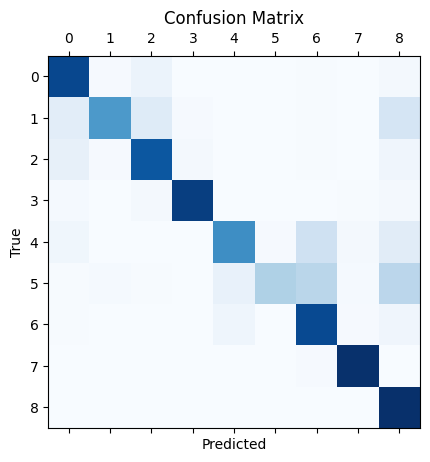

   overall_precision  overall_recall  overall_f1  overall_accuracy
0           0.831057        0.840475    0.835739          0.970152

                   LOC        MISC          ORG          PER
precision     0.803620    0.752830     0.768451     0.958965
recall        0.878297    0.568376     0.821192     0.939394
f1            0.839301    0.647727     0.793946     0.949078
number     1668.000000  702.000000  1661.000000  1617.000000

end of run
---------------------------------------------------
---------------------------------------------------
starting run on training set of 11%



Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['cl

{'eval_loss': 2.263603687286377, 'eval_precision': 0.02009174638170762, 'eval_recall': 0.10003541076487252, 'eval_f1': 0.03346264325268738, 'eval_accuracy': 0.06372348444061592, 'eval_runtime': 6.9425, 'eval_samples_per_second': 497.368, 'eval_steps_per_second': 7.778, 'epoch': 0.01}



  1%|          | 3/485 [00:14<44:15,  5.51s/it]

{'eval_loss': 2.2597062587738037, 'eval_precision': 0.020102469223653312, 'eval_recall': 0.10003541076487252, 'eval_f1': 0.033477513776145044, 'eval_accuracy': 0.06544632281684075, 'eval_runtime': 6.9726, 'eval_samples_per_second': 495.227, 'eval_steps_per_second': 7.745, 'epoch': 0.02}



  1%|          | 4/485 [00:21<49:10,  6.13s/it]

{'eval_loss': 2.251894950866699, 'eval_precision': 0.02014188442479769, 'eval_recall': 0.10003541076487252, 'eval_f1': 0.03353215228938544, 'eval_accuracy': 0.06999030903413374, 'eval_runtime': 6.9766, 'eval_samples_per_second': 494.939, 'eval_steps_per_second': 7.74, 'epoch': 0.03}



  1%|          | 5/485 [00:28<51:47,  6.47s/it]

{'eval_loss': 2.2402114868164062, 'eval_precision': 0.020232350312779267, 'eval_recall': 0.10021246458923513, 'eval_f1': 0.03366743003301312, 'eval_accuracy': 0.07701087541724992, 'eval_runtime': 6.9839, 'eval_samples_per_second': 494.423, 'eval_steps_per_second': 7.732, 'epoch': 0.04}



  1%|          | 6/485 [00:35<53:24,  6.69s/it]

{'eval_loss': 2.224503517150879, 'eval_precision': 0.02041475315729047, 'eval_recall': 0.10074362606232294, 'eval_f1': 0.033949880668257756, 'eval_accuracy': 0.08648648648648649, 'eval_runtime': 7.0024, 'eval_samples_per_second': 493.114, 'eval_steps_per_second': 7.712, 'epoch': 0.05}



  1%|▏         | 7/485 [00:42<54:24,  6.83s/it]

{'eval_loss': 2.2050585746765137, 'eval_precision': 0.020788893307784086, 'eval_recall': 0.10180594900849858, 'eval_f1': 0.03452727654847329, 'eval_accuracy': 0.09981694842252611, 'eval_runtime': 7.0149, 'eval_samples_per_second': 492.236, 'eval_steps_per_second': 7.698, 'epoch': 0.06}



  2%|▏         | 8/485 [00:49<55:16,  6.95s/it]

{'eval_loss': 2.182041883468628, 'eval_precision': 0.02139350868195472, 'eval_recall': 0.10339943342776203, 'eval_f1': 0.03545195167850422, 'eval_accuracy': 0.12068482825454938, 'eval_runtime': 7.1036, 'eval_samples_per_second': 486.092, 'eval_steps_per_second': 7.602, 'epoch': 0.07}



  2%|▏         | 9/485 [00:56<55:29,  6.99s/it]

{'eval_loss': 2.155564546585083, 'eval_precision': 0.021221744815991032, 'eval_recall': 0.10056657223796034, 'eval_f1': 0.035047666059914225, 'eval_accuracy': 0.14769031980187358, 'eval_runtime': 7.0005, 'eval_samples_per_second': 493.254, 'eval_steps_per_second': 7.714, 'epoch': 0.08}



  2%|▏         | 10/485 [01:04<55:39,  7.03s/it]

{'eval_loss': 2.1255297660827637, 'eval_precision': 0.02149543510921068, 'eval_recall': 0.09879603399433427, 'eval_f1': 0.03530863416331825, 'eval_accuracy': 0.18475288037041024, 'eval_runtime': 7.0206, 'eval_samples_per_second': 491.842, 'eval_steps_per_second': 7.692, 'epoch': 0.09}



  2%|▏         | 10/485 [01:11<55:39,  7.03s/it]

{'eval_loss': 2.092080593109131, 'eval_precision': 0.022377227642932023, 'eval_recall': 0.09826487252124647, 'eval_f1': 0.03645320197044335, 'eval_accuracy': 0.2325616453106493, 'eval_runtime': 7.0149, 'eval_samples_per_second': 492.238, 'eval_steps_per_second': 7.698, 'epoch': 0.1}


  2%|▏         | 12/485 [01:19<57:07,  7.25s/it]

{'eval_loss': 2.055553674697876, 'eval_precision': 0.023903518285540756, 'eval_recall': 0.09755665722379603, 'eval_f1': 0.038398550472141885, 'eval_accuracy': 0.29365780122752233, 'eval_runtime': 6.966, 'eval_samples_per_second': 495.696, 'eval_steps_per_second': 7.752, 'epoch': 0.11}



  3%|▎         | 13/485 [01:26<56:38,  7.20s/it]

{'eval_loss': 2.0155320167541504, 'eval_precision': 0.025808622098332294, 'eval_recall': 0.09507790368271955, 'eval_f1': 0.040597240597240604, 'eval_accuracy': 0.3653278776784753, 'eval_runtime': 6.9744, 'eval_samples_per_second': 495.095, 'eval_steps_per_second': 7.743, 'epoch': 0.12}



  3%|▎         | 14/485 [01:33<56:13,  7.16s/it]

{'eval_loss': 1.9721468687057495, 'eval_precision': 0.027277840269966255, 'eval_recall': 0.08587110481586402, 'eval_f1': 0.04140344886460645, 'eval_accuracy': 0.44821793905459245, 'eval_runtime': 6.9711, 'eval_samples_per_second': 495.327, 'eval_steps_per_second': 7.746, 'epoch': 0.13}



  3%|▎         | 15/485 [01:40<55:50,  7.13s/it]

{'eval_loss': 1.9253413677215576, 'eval_precision': 0.029143136024541588, 'eval_recall': 0.07400849858356941, 'eval_f1': 0.04181881846831074, 'eval_accuracy': 0.535156670614838, 'eval_runtime': 6.9559, 'eval_samples_per_second': 496.416, 'eval_steps_per_second': 7.763, 'epoch': 0.14}



  3%|▎         | 16/485 [01:47<55:46,  7.13s/it]

{'eval_loss': 1.8749451637268066, 'eval_precision': 0.02943327239488117, 'eval_recall': 0.05701133144475921, 'eval_f1': 0.03882324571979744, 'eval_accuracy': 0.6138257779692042, 'eval_runtime': 7.0614, 'eval_samples_per_second': 488.996, 'eval_steps_per_second': 7.647, 'epoch': 0.15}



  4%|▎         | 17/485 [01:54<55:20,  7.10s/it]

{'eval_loss': 1.8215256929397583, 'eval_precision': 0.030441400304414, 'eval_recall': 0.042492917847025496, 'eval_f1': 0.03547147502216967, 'eval_accuracy': 0.6800473780553462, 'eval_runtime': 6.9214, 'eval_samples_per_second': 498.891, 'eval_steps_per_second': 7.802, 'epoch': 0.16}



  4%|▎         | 18/485 [02:01<55:05,  7.08s/it]

{'eval_loss': 1.7646902799606323, 'eval_precision': 0.028142936493241993, 'eval_recall': 0.026912181303116147, 'eval_f1': 0.02751380215404109, 'eval_accuracy': 0.7297297297297297, 'eval_runtime': 6.9254, 'eval_samples_per_second': 498.6, 'eval_steps_per_second': 7.797, 'epoch': 0.18}



  4%|▍         | 19/485 [02:08<54:49,  7.06s/it]

{'eval_loss': 1.7047134637832642, 'eval_precision': 0.027467811158798282, 'eval_recall': 0.0169971671388102, 'eval_f1': 0.020999671880126875, 'eval_accuracy': 0.7657801227522343, 'eval_runtime': 6.8842, 'eval_samples_per_second': 501.58, 'eval_steps_per_second': 7.844, 'epoch': 0.19}



  4%|▍         | 20/485 [02:15<54:35,  7.04s/it]

{'eval_loss': 1.64182710647583, 'eval_precision': 0.028037383177570093, 'eval_recall': 0.010623229461756374, 'eval_f1': 0.015408320493066256, 'eval_accuracy': 0.7905243889307634, 'eval_runtime': 6.884, 'eval_samples_per_second': 501.6, 'eval_steps_per_second': 7.844, 'epoch': 0.2}



  4%|▍         | 20/485 [02:22<54:35,  7.04s/it]

{'eval_loss': 1.5767115354537964, 'eval_precision': 0.025, 'eval_recall': 0.005311614730878187, 'eval_f1': 0.008761682242990655, 'eval_accuracy': 0.8072359211801443, 'eval_runtime': 6.8859, 'eval_samples_per_second': 501.462, 'eval_steps_per_second': 7.842, 'epoch': 0.21}


  5%|▍         | 22/485 [02:30<55:42,  7.22s/it]

{'eval_loss': 1.5096601247787476, 'eval_precision': 0.030534351145038167, 'eval_recall': 0.0035410764872521247, 'eval_f1': 0.00634618435665556, 'eval_accuracy': 0.8158285775815657, 'eval_runtime': 6.8901, 'eval_samples_per_second': 501.151, 'eval_steps_per_second': 7.837, 'epoch': 0.22}



  5%|▍         | 23/485 [02:37<55:21,  7.19s/it]

{'eval_loss': 1.440392255783081, 'eval_precision': 0.04375, 'eval_recall': 0.002478753541076487, 'eval_f1': 0.004691689008042895, 'eval_accuracy': 0.821126305588457, 'eval_runtime': 7.0132, 'eval_samples_per_second': 492.358, 'eval_steps_per_second': 7.7, 'epoch': 0.23}



  5%|▍         | 24/485 [02:44<54:46,  7.13s/it]

{'eval_loss': 1.3693267107009888, 'eval_precision': 0.020134228187919462, 'eval_recall': 0.0005311614730878187, 'eval_f1': 0.0010350181128169745, 'eval_accuracy': 0.8234090664369549, 'eval_runtime': 6.8877, 'eval_samples_per_second': 501.33, 'eval_steps_per_second': 7.84, 'epoch': 0.24}



  5%|▌         | 25/485 [02:51<54:17,  7.08s/it]

{'eval_loss': 1.2969205379486084, 'eval_precision': 0.029411764705882353, 'eval_recall': 0.0003541076487252125, 'eval_f1': 0.0006997900629811057, 'eval_accuracy': 0.8245719823409067, 'eval_runtime': 6.8868, 'eval_samples_per_second': 501.394, 'eval_steps_per_second': 7.841, 'epoch': 0.25}



  5%|▌         | 26/485 [02:58<54:02,  7.06s/it]

{'eval_loss': 1.2236469984054565, 'eval_precision': 0.07692307692307693, 'eval_recall': 0.0003541076487252125, 'eval_f1': 0.0007049700387733521, 'eval_accuracy': 0.8250888338537741, 'eval_runtime': 6.9412, 'eval_samples_per_second': 497.466, 'eval_steps_per_second': 7.78, 'epoch': 0.26}


/home/ronen/Documents/college/NNForNLP/workshop_1/.conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  6%|▌         | 27/485 [03:05<53:51,  7.06s/it]

{'eval_loss': 1.1516779661178589, 'eval_precision': 0.1, 'eval_recall': 0.00017705382436260624, 'eval_f1': 0.0003534817956875221, 'eval_accuracy': 0.8252395822116938, 'eval_runtime': 6.9356, 'eval_samples_per_second': 497.869, 'eval_steps_per_second': 7.786, 'epoch': 0.27}



  6%|▌         | 28/485 [03:12<53:42,  7.05s/it]

{'eval_loss': 1.0827808380126953, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8252826531710994, 'eval_runtime': 6.9492, 'eval_samples_per_second': 496.89, 'eval_steps_per_second': 7.771, 'epoch': 0.28}



  6%|▌         | 29/485 [03:19<53:38,  7.06s/it]

{'eval_loss': 1.0184909105300903, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8252826531710994, 'eval_runtime': 6.9914, 'eval_samples_per_second': 493.889, 'eval_steps_per_second': 7.724, 'epoch': 0.29}



  6%|▌         | 30/485 [03:26<53:55,  7.11s/it]

{'eval_loss': 0.9607135057449341, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8252826531710994, 'eval_runtime': 7.1292, 'eval_samples_per_second': 484.345, 'eval_steps_per_second': 7.574, 'epoch': 0.3}



  6%|▌         | 30/485 [03:33<53:55,  7.11s/it]

{'eval_loss': 0.9110840559005737, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8252826531710994, 'eval_runtime': 6.9588, 'eval_samples_per_second': 496.207, 'eval_steps_per_second': 7.76, 'epoch': 0.31}


  6%|▋         | 31/485 [03:34<55:41,  7.36s/it]/home/ronen/Documents/college/NNForNLP/workshop_1/.conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ronen/Documents/college/NNForNLP/workshop_1/.conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  7%|▋         | 32/485 [03:41<54:53,  7.27s/it]

{'eval_loss': 0.8709072470664978, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.9521, 'eval_samples_per_second': 496.682, 'eval_steps_per_second': 7.767, 'epoch': 0.32}



  7%|▋         | 33/485 [03:48<54:15,  7.20s/it]

{'eval_loss': 0.8413282632827759, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.9464, 'eval_samples_per_second': 497.089, 'eval_steps_per_second': 7.774, 'epoch': 0.33}



  7%|▋         | 34/485 [03:56<53:48,  7.16s/it]

{'eval_loss': 0.8232607841491699, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.9462, 'eval_samples_per_second': 497.109, 'eval_steps_per_second': 7.774, 'epoch': 0.34}



  7%|▋         | 35/485 [04:03<53:24,  7.12s/it]

{'eval_loss': 0.8161072134971619, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.947, 'eval_samples_per_second': 497.052, 'eval_steps_per_second': 7.773, 'epoch': 0.35}



  7%|▋         | 36/485 [04:10<53:08,  7.10s/it]

{'eval_loss': 0.8150763511657715, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.9438, 'eval_samples_per_second': 497.279, 'eval_steps_per_second': 7.777, 'epoch': 0.36}



  8%|▊         | 37/485 [04:17<53:08,  7.12s/it]

{'eval_loss': 0.8161464929580688, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 7.0501, 'eval_samples_per_second': 489.78, 'eval_steps_per_second': 7.659, 'epoch': 0.37}



  8%|▊         | 38/485 [04:24<52:47,  7.09s/it]

{'eval_loss': 0.811093270778656, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.9046, 'eval_samples_per_second': 500.103, 'eval_steps_per_second': 7.821, 'epoch': 0.38}



  8%|▊         | 39/485 [04:31<52:29,  7.06s/it]

{'eval_loss': 0.8004046678543091, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.9015, 'eval_samples_per_second': 500.327, 'eval_steps_per_second': 7.824, 'epoch': 0.39}



  8%|▊         | 40/485 [04:38<52:20,  7.06s/it]

{'eval_loss': 0.7850465178489685, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.9154, 'eval_samples_per_second': 499.319, 'eval_steps_per_second': 7.809, 'epoch': 0.4}



  8%|▊         | 40/485 [04:45<52:20,  7.06s/it]

{'eval_loss': 0.7624971866607666, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.9114, 'eval_samples_per_second': 499.61, 'eval_steps_per_second': 7.813, 'epoch': 0.41}


  8%|▊         | 41/485 [04:46<54:03,  7.30s/it]/home/ronen/Documents/college/NNForNLP/workshop_1/.conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ronen/Documents/college/NNForNLP/workshop_1/.conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  9%|▊         | 42/485 [04:53<53:16,  7.22s/it]

{'eval_loss': 0.7363433241844177, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.9049, 'eval_samples_per_second': 500.079, 'eval_steps_per_second': 7.821, 'epoch': 0.42}



  9%|▉         | 43/485 [05:00<52:40,  7.15s/it]

{'eval_loss': 0.7085132002830505, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.8853, 'eval_samples_per_second': 501.505, 'eval_steps_per_second': 7.843, 'epoch': 0.43}



  9%|▉         | 44/485 [05:07<52:30,  7.14s/it]

{'eval_loss': 0.6843851804733276, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 7.0093, 'eval_samples_per_second': 492.629, 'eval_steps_per_second': 7.704, 'epoch': 0.44}



  9%|▉         | 45/485 [05:14<52:02,  7.10s/it]

{'eval_loss': 0.6620829105377197, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.8919, 'eval_samples_per_second': 501.027, 'eval_steps_per_second': 7.835, 'epoch': 0.45}



  9%|▉         | 46/485 [05:21<51:44,  7.07s/it]

{'eval_loss': 0.643494725227356, 'eval_precision': 1.0, 'eval_recall': 0.00017705382436260624, 'eval_f1': 0.00035404496371039125, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.9159, 'eval_samples_per_second': 499.285, 'eval_steps_per_second': 7.808, 'epoch': 0.46}



 10%|▉         | 47/485 [05:28<51:27,  7.05s/it]

{'eval_loss': 0.6266984343528748, 'eval_precision': 1.0, 'eval_recall': 0.0003541076487252125, 'eval_f1': 0.0007079646017699115, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.9104, 'eval_samples_per_second': 499.684, 'eval_steps_per_second': 7.814, 'epoch': 0.47}



 10%|▉         | 48/485 [05:35<51:15,  7.04s/it]

{'eval_loss': 0.6104682087898254, 'eval_precision': 0.8, 'eval_recall': 0.000708215297450425, 'eval_f1': 0.0014151777817088271, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.9094, 'eval_samples_per_second': 499.755, 'eval_steps_per_second': 7.815, 'epoch': 0.48}



 10%|█         | 49/485 [05:42<51:04,  7.03s/it]

{'eval_loss': 0.5934340953826904, 'eval_precision': 0.5, 'eval_recall': 0.0008852691218130312, 'eval_f1': 0.0017674089784376103, 'eval_accuracy': 0.825325724130505, 'eval_runtime': 6.9053, 'eval_samples_per_second': 500.048, 'eval_steps_per_second': 7.82, 'epoch': 0.49}



 10%|█         | 50/485 [05:49<50:49,  7.01s/it]

{'eval_loss': 0.5750364661216736, 'eval_precision': 0.3333333333333333, 'eval_recall': 0.00141643059490085, 'eval_f1': 0.0028208744710860366, 'eval_accuracy': 0.8254549370087219, 'eval_runtime': 6.8979, 'eval_samples_per_second': 500.587, 'eval_steps_per_second': 7.828, 'epoch': 0.51}



 10%|█         | 50/485 [05:56<50:49,  7.01s/it]

{'eval_loss': 0.5551236271858215, 'eval_precision': 0.30357142857142855, 'eval_recall': 0.0030099150141643057, 'eval_f1': 0.005960729312762973, 'eval_accuracy': 0.8257564337245612, 'eval_runtime': 7.0197, 'eval_samples_per_second': 491.899, 'eval_steps_per_second': 7.693, 'epoch': 0.52}


 11%|█         | 52/485 [06:04<52:03,  7.21s/it]

{'eval_loss': 0.5349761247634888, 'eval_precision': 0.24203821656050956, 'eval_recall': 0.006728045325779037, 'eval_f1': 0.01309216192937123, 'eval_accuracy': 0.8269839560676214, 'eval_runtime': 6.8953, 'eval_samples_per_second': 500.779, 'eval_steps_per_second': 7.831, 'epoch': 0.53}



 11%|█         | 53/485 [06:11<51:28,  7.15s/it]

{'eval_loss': 0.5155197978019714, 'eval_precision': 0.2549019607843137, 'eval_recall': 0.018413597733711047, 'eval_f1': 0.034346103038309116, 'eval_accuracy': 0.8305373102185851, 'eval_runtime': 6.9196, 'eval_samples_per_second': 499.018, 'eval_steps_per_second': 7.804, 'epoch': 0.54}



 11%|█         | 54/485 [06:18<51:06,  7.11s/it]

{'eval_loss': 0.49790969491004944, 'eval_precision': 0.28588516746411485, 'eval_recall': 0.04231586402266289, 'eval_f1': 0.07371992597162244, 'eval_accuracy': 0.8365026380962636, 'eval_runtime': 6.9349, 'eval_samples_per_second': 497.918, 'eval_steps_per_second': 7.787, 'epoch': 0.55}



 11%|█▏        | 55/485 [06:25<50:48,  7.09s/it]

{'eval_loss': 0.4816466271877289, 'eval_precision': 0.3356554781507283, 'eval_recall': 0.09383852691218131, 'eval_f1': 0.14667220146672202, 'eval_accuracy': 0.8471196295897491, 'eval_runtime': 6.9397, 'eval_samples_per_second': 497.57, 'eval_steps_per_second': 7.781, 'epoch': 0.56}



 12%|█▏        | 56/485 [06:32<50:32,  7.07s/it]

{'eval_loss': 0.4663153886795044, 'eval_precision': 0.35004042037186744, 'eval_recall': 0.153328611898017, 'eval_f1': 0.21324796848066976, 'eval_accuracy': 0.8603208786475719, 'eval_runtime': 6.9148, 'eval_samples_per_second': 499.363, 'eval_steps_per_second': 7.809, 'epoch': 0.57}



 12%|█▏        | 57/485 [06:39<50:20,  7.06s/it]

{'eval_loss': 0.4508607089519501, 'eval_precision': 0.3789505068574836, 'eval_recall': 0.22503541076487252, 'eval_f1': 0.2823816929571206, 'eval_accuracy': 0.8739097663400452, 'eval_runtime': 6.9106, 'eval_samples_per_second': 499.669, 'eval_steps_per_second': 7.814, 'epoch': 0.58}



 12%|█▏        | 58/485 [06:46<50:22,  7.08s/it]

{'eval_loss': 0.43590664863586426, 'eval_precision': 0.39172987521409347, 'eval_recall': 0.2834631728045326, 'eval_f1': 0.3289162814586543, 'eval_accuracy': 0.8847636481102616, 'eval_runtime': 7.0321, 'eval_samples_per_second': 491.033, 'eval_steps_per_second': 7.679, 'epoch': 0.59}



 12%|█▏        | 59/485 [06:53<50:05,  7.06s/it]

{'eval_loss': 0.42101651430130005, 'eval_precision': 0.41228813559322036, 'eval_recall': 0.3445467422096317, 'eval_f1': 0.37538580246913583, 'eval_accuracy': 0.8938516205448477, 'eval_runtime': 6.9136, 'eval_samples_per_second': 499.451, 'eval_steps_per_second': 7.811, 'epoch': 0.6}



 12%|█▏        | 60/485 [07:00<49:51,  7.04s/it]

{'eval_loss': 0.4068836271762848, 'eval_precision': 0.42915057915057914, 'eval_recall': 0.39359065155807366, 'eval_f1': 0.4106021425932767, 'eval_accuracy': 0.9007214385700442, 'eval_runtime': 6.9145, 'eval_samples_per_second': 499.383, 'eval_steps_per_second': 7.81, 'epoch': 0.61}



 12%|█▏        | 60/485 [07:07<49:51,  7.04s/it]

{'eval_loss': 0.39359936118125916, 'eval_precision': 0.445794053662074, 'eval_recall': 0.4353753541076487, 'eval_f1': 0.440523109996417, 'eval_accuracy': 0.9062345213739637, 'eval_runtime': 6.9189, 'eval_samples_per_second': 499.068, 'eval_steps_per_second': 7.805, 'epoch': 0.62}


 13%|█▎        | 62/485 [07:15<50:49,  7.21s/it]

{'eval_loss': 0.38086646795272827, 'eval_precision': 0.4547808077321367, 'eval_recall': 0.4665368271954674, 'eval_f1': 0.4605838140185282, 'eval_accuracy': 0.910046301281361, 'eval_runtime': 6.9098, 'eval_samples_per_second': 499.723, 'eval_steps_per_second': 7.815, 'epoch': 0.63}



 13%|█▎        | 63/485 [07:22<50:20,  7.16s/it]

{'eval_loss': 0.3693520426750183, 'eval_precision': 0.4600197433366239, 'eval_recall': 0.495042492917847, 'eval_f1': 0.47688896469384273, 'eval_accuracy': 0.9132766232367826, 'eval_runtime': 6.932, 'eval_samples_per_second': 498.126, 'eval_steps_per_second': 7.79, 'epoch': 0.64}



 13%|█▎        | 64/485 [07:29<49:55,  7.12s/it]

{'eval_loss': 0.3593224585056305, 'eval_precision': 0.465024474972367, 'eval_recall': 0.5214235127478754, 'eval_f1': 0.49161171855437774, 'eval_accuracy': 0.9158393453214171, 'eval_runtime': 6.9316, 'eval_samples_per_second': 498.156, 'eval_steps_per_second': 7.79, 'epoch': 0.65}



 13%|█▎        | 65/485 [07:36<49:54,  7.13s/it]

{'eval_loss': 0.35056447982788086, 'eval_precision': 0.4632509911558402, 'eval_recall': 0.5378895184135978, 'eval_f1': 0.49778797312796985, 'eval_accuracy': 0.9173683643803165, 'eval_runtime': 7.063, 'eval_samples_per_second': 488.883, 'eval_steps_per_second': 7.645, 'epoch': 0.66}



 14%|█▎        | 66/485 [07:43<49:30,  7.09s/it]

{'eval_loss': 0.34137997031211853, 'eval_precision': 0.4664173522812266, 'eval_recall': 0.5520538243626062, 'eval_f1': 0.5056352874402011, 'eval_accuracy': 0.9189835253580273, 'eval_runtime': 6.9122, 'eval_samples_per_second': 499.55, 'eval_steps_per_second': 7.812, 'epoch': 0.67}



 14%|█▍        | 67/485 [07:50<49:18,  7.08s/it]

{'eval_loss': 0.33043497800827026, 'eval_precision': 0.4771977197719772, 'eval_recall': 0.5632082152974505, 'eval_f1': 0.5166477180445023, 'eval_accuracy': 0.921287821686228, 'eval_runtime': 6.943, 'eval_samples_per_second': 497.337, 'eval_steps_per_second': 7.778, 'epoch': 0.68}


/home/ronen/Documents/college/NNForNLP/workshop_1/.conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 14%|█▍        | 68/485 [07:57<49:04,  7.06s/it]

{'eval_loss': 0.319232702255249, 'eval_precision': 0.4902379499694936, 'eval_recall': 0.5690509915014165, 'eval_f1': 0.5267125532612258, 'eval_accuracy': 0.9231183374609669, 'eval_runtime': 6.9184, 'eval_samples_per_second': 499.105, 'eval_steps_per_second': 7.805, 'epoch': 0.69}



 14%|█▍        | 69/485 [08:04<48:48,  7.04s/it]

{'eval_loss': 0.3100644052028656, 'eval_precision': 0.5069563858058465, 'eval_recall': 0.574185552407932, 'eval_f1': 0.538480697384807, 'eval_accuracy': 0.9257025950253042, 'eval_runtime': 6.9118, 'eval_samples_per_second': 499.58, 'eval_steps_per_second': 7.813, 'epoch': 0.7}



 14%|█▍        | 70/485 [08:11<48:38,  7.03s/it]

{'eval_loss': 0.3047592043876648, 'eval_precision': 0.517424120764413, 'eval_recall': 0.5704674220963173, 'eval_f1': 0.5426526315789474, 'eval_accuracy': 0.9264563368149026, 'eval_runtime': 6.9323, 'eval_samples_per_second': 498.102, 'eval_steps_per_second': 7.79, 'epoch': 0.71}



 14%|█▍        | 70/485 [08:18<48:38,  7.03s/it]

{'eval_loss': 0.3007514774799347, 'eval_precision': 0.5223323046938444, 'eval_recall': 0.5694050991501416, 'eval_f1': 0.544853875476493, 'eval_accuracy': 0.9267578335307419, 'eval_runtime': 6.9453, 'eval_samples_per_second': 497.17, 'eval_steps_per_second': 7.775, 'epoch': 0.72}


 15%|█▍        | 71/485 [08:19<50:19,  7.29s/it]/home/ronen/Documents/college/NNForNLP/workshop_1/.conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 15%|█▍        | 72/485 [08:26<49:55,  7.25s/it]

{'eval_loss': 0.29510191082954407, 'eval_precision': 0.527435064935065, 'eval_recall': 0.5752478753541076, 'eval_f1': 0.5503048780487806, 'eval_accuracy': 0.9279207494346936, 'eval_runtime': 7.0498, 'eval_samples_per_second': 489.804, 'eval_steps_per_second': 7.66, 'epoch': 0.73}



 15%|█▌        | 73/485 [08:33<49:20,  7.19s/it]

{'eval_loss': 0.2883427143096924, 'eval_precision': 0.5284329563812601, 'eval_recall': 0.5791430594900849, 'eval_f1': 0.5526271329616489, 'eval_accuracy': 0.9283514590287498, 'eval_runtime': 6.9172, 'eval_samples_per_second': 499.19, 'eval_steps_per_second': 7.807, 'epoch': 0.74}



 15%|█▌        | 74/485 [08:40<48:54,  7.14s/it]

{'eval_loss': 0.28135380148887634, 'eval_precision': 0.5299487508007688, 'eval_recall': 0.585871104815864, 'eval_f1': 0.5565085771947528, 'eval_accuracy': 0.9290621298589427, 'eval_runtime': 6.9179, 'eval_samples_per_second': 499.139, 'eval_steps_per_second': 7.806, 'epoch': 0.75}



 15%|█▌        | 75/485 [08:47<48:29,  7.10s/it]

{'eval_loss': 0.2746275067329407, 'eval_precision': 0.5331535532994924, 'eval_recall': 0.5950779036827195, 'eval_f1': 0.5624163319946452, 'eval_accuracy': 0.9297297297297298, 'eval_runtime': 6.9223, 'eval_samples_per_second': 498.822, 'eval_steps_per_second': 7.801, 'epoch': 0.76}



 16%|█▌        | 76/485 [08:54<48:15,  7.08s/it]

{'eval_loss': 0.26903799176216125, 'eval_precision': 0.5368321214037306, 'eval_recall': 0.6012747875354107, 'eval_f1': 0.567228996158343, 'eval_accuracy': 0.9309141811133843, 'eval_runtime': 6.9298, 'eval_samples_per_second': 498.28, 'eval_steps_per_second': 7.792, 'epoch': 0.77}



 16%|█▌        | 77/485 [09:01<48:00,  7.06s/it]

{'eval_loss': 0.2632272243499756, 'eval_precision': 0.5436801511097119, 'eval_recall': 0.6115439093484419, 'eval_f1': 0.5756186984417965, 'eval_accuracy': 0.9316894583826855, 'eval_runtime': 6.9122, 'eval_samples_per_second': 499.549, 'eval_steps_per_second': 7.812, 'epoch': 0.78}



 16%|█▌        | 78/485 [09:09<47:50,  7.05s/it]

{'eval_loss': 0.2575882077217102, 'eval_precision': 0.5530566993981628, 'eval_recall': 0.6182719546742209, 'eval_f1': 0.5838488547065708, 'eval_accuracy': 0.932766232367826, 'eval_runtime': 6.9265, 'eval_samples_per_second': 498.52, 'eval_steps_per_second': 7.796, 'epoch': 0.79}



 16%|█▋        | 79/485 [09:16<47:56,  7.08s/it]

{'eval_loss': 0.25165215134620667, 'eval_precision': 0.5613139850103652, 'eval_recall': 0.623229461756374, 'eval_f1': 0.5906535783203288, 'eval_accuracy': 0.9333692257995047, 'eval_runtime': 7.0497, 'eval_samples_per_second': 489.811, 'eval_steps_per_second': 7.66, 'epoch': 0.8}



 16%|█▋        | 80/485 [09:23<47:41,  7.07s/it]

{'eval_loss': 0.24578802287578583, 'eval_precision': 0.5721169290073884, 'eval_recall': 0.6306657223796034, 'eval_f1': 0.5999663129526697, 'eval_accuracy': 0.9344029288252396, 'eval_runtime': 6.9155, 'eval_samples_per_second': 499.31, 'eval_steps_per_second': 7.809, 'epoch': 0.81}



 16%|█▋        | 80/485 [09:30<47:41,  7.07s/it]

{'eval_loss': 0.24051478505134583, 'eval_precision': 0.5824015556635878, 'eval_recall': 0.6363314447592068, 'eval_f1': 0.6081732803113631, 'eval_accuracy': 0.9353504899321632, 'eval_runtime': 6.923, 'eval_samples_per_second': 498.775, 'eval_steps_per_second': 7.8, 'epoch': 0.82}


 17%|█▋        | 82/485 [09:38<48:34,  7.23s/it]

{'eval_loss': 0.2358783781528473, 'eval_precision': 0.5927439124039876, 'eval_recall': 0.6421742209631728, 'eval_f1': 0.6164697883912637, 'eval_accuracy': 0.9362765155593841, 'eval_runtime': 6.9107, 'eval_samples_per_second': 499.658, 'eval_steps_per_second': 7.814, 'epoch': 0.84}



 17%|█▋        | 83/485 [09:45<48:02,  7.17s/it]

{'eval_loss': 0.2315484583377838, 'eval_precision': 0.6040600759201188, 'eval_recall': 0.6480169971671388, 'eval_f1': 0.6252669343128043, 'eval_accuracy': 0.9375901798212555, 'eval_runtime': 6.9126, 'eval_samples_per_second': 499.522, 'eval_steps_per_second': 7.812, 'epoch': 0.85}



 17%|█▋        | 84/485 [09:52<47:35,  7.12s/it]

{'eval_loss': 0.2275596410036087, 'eval_precision': 0.6142952349216928, 'eval_recall': 0.6527974504249292, 'eval_f1': 0.632961373390558, 'eval_accuracy': 0.9388177021643157, 'eval_runtime': 6.9102, 'eval_samples_per_second': 499.695, 'eval_steps_per_second': 7.815, 'epoch': 0.86}



 18%|█▊        | 85/485 [09:59<47:19,  7.10s/it]

{'eval_loss': 0.22399042546749115, 'eval_precision': 0.6209139426284189, 'eval_recall': 0.6591713881019831, 'eval_f1': 0.6394709721745105, 'eval_accuracy': 0.9401744373855928, 'eval_runtime': 6.9187, 'eval_samples_per_second': 499.085, 'eval_steps_per_second': 7.805, 'epoch': 0.87}



 18%|█▊        | 86/485 [10:06<47:02,  7.07s/it]

{'eval_loss': 0.22096508741378784, 'eval_precision': 0.631069581178041, 'eval_recall': 0.6696175637393768, 'eval_f1': 0.649772356326776, 'eval_accuracy': 0.9418972757618176, 'eval_runtime': 6.9156, 'eval_samples_per_second': 499.305, 'eval_steps_per_second': 7.808, 'epoch': 0.88}



 18%|█▊        | 87/485 [10:13<47:02,  7.09s/it]

{'eval_loss': 0.21832731366157532, 'eval_precision': 0.6343729263437292, 'eval_recall': 0.6770538243626062, 'eval_f1': 0.6550188420692018, 'eval_accuracy': 0.9429955852266609, 'eval_runtime': 7.0382, 'eval_samples_per_second': 490.605, 'eval_steps_per_second': 7.672, 'epoch': 0.89}



 18%|█▊        | 88/485 [10:20<46:48,  7.08s/it]

{'eval_loss': 0.2162405103445053, 'eval_precision': 0.6385801957206834, 'eval_recall': 0.681657223796034, 'eval_f1': 0.6594159458765093, 'eval_accuracy': 0.9438785398944761, 'eval_runtime': 6.9258, 'eval_samples_per_second': 498.573, 'eval_steps_per_second': 7.797, 'epoch': 0.9}



 18%|█▊        | 89/485 [10:27<46:35,  7.06s/it]

{'eval_loss': 0.21485887467861176, 'eval_precision': 0.6459092414706856, 'eval_recall': 0.6905099150141643, 'eval_f1': 0.6674653431456443, 'eval_accuracy': 0.9452137396360504, 'eval_runtime': 6.9204, 'eval_samples_per_second': 498.962, 'eval_steps_per_second': 7.803, 'epoch': 0.91}



 19%|█▊        | 90/485 [10:34<46:22,  7.04s/it]

{'eval_loss': 0.21372868120670319, 'eval_precision': 0.6493721083939193, 'eval_recall': 0.6958215297450425, 'eval_f1': 0.6717948717948719, 'eval_accuracy': 0.9461828362226768, 'eval_runtime': 6.9245, 'eval_samples_per_second': 498.663, 'eval_steps_per_second': 7.798, 'epoch': 0.92}



 19%|█▊        | 90/485 [10:41<46:22,  7.04s/it]

{'eval_loss': 0.2138267457485199, 'eval_precision': 0.6475531389026199, 'eval_recall': 0.6958215297450425, 'eval_f1': 0.6708201758129214, 'eval_accuracy': 0.9463551200602993, 'eval_runtime': 6.9288, 'eval_samples_per_second': 498.356, 'eval_steps_per_second': 7.794, 'epoch': 0.93}


 19%|█▉        | 92/485 [10:49<47:17,  7.22s/it]

{'eval_loss': 0.21326981484889984, 'eval_precision': 0.6487022648371632, 'eval_recall': 0.6947592067988668, 'eval_f1': 0.6709412669915363, 'eval_accuracy': 0.9470011844513837, 'eval_runtime': 6.9195, 'eval_samples_per_second': 499.026, 'eval_steps_per_second': 7.804, 'epoch': 0.94}



 19%|█▉        | 93/485 [10:56<46:44,  7.16s/it]

{'eval_loss': 0.21148563921451569, 'eval_precision': 0.650727994705493, 'eval_recall': 0.6963526912181303, 'eval_f1': 0.6727677044132739, 'eval_accuracy': 0.9478195326800904, 'eval_runtime': 6.9297, 'eval_samples_per_second': 498.291, 'eval_steps_per_second': 7.793, 'epoch': 0.95}



 19%|█▉        | 94/485 [11:03<46:38,  7.16s/it]

{'eval_loss': 0.2091410905122757, 'eval_precision': 0.6544701986754967, 'eval_recall': 0.6998937677053825, 'eval_f1': 0.6764202600958248, 'eval_accuracy': 0.9490470550231507, 'eval_runtime': 7.0667, 'eval_samples_per_second': 488.627, 'eval_steps_per_second': 7.641, 'epoch': 0.96}



 20%|█▉        | 95/485 [11:10<46:15,  7.12s/it]

{'eval_loss': 0.20578527450561523, 'eval_precision': 0.6584396223289714, 'eval_recall': 0.7037889518413598, 'eval_f1': 0.6803594351732991, 'eval_accuracy': 0.949908474211263, 'eval_runtime': 6.921, 'eval_samples_per_second': 498.913, 'eval_steps_per_second': 7.802, 'epoch': 0.97}



 20%|█▉        | 96/485 [11:17<45:59,  7.09s/it]

{'eval_loss': 0.20131732523441315, 'eval_precision': 0.6676079734219269, 'eval_recall': 0.7115793201133145, 'eval_f1': 0.6888926979773741, 'eval_accuracy': 0.9511790675137288, 'eval_runtime': 6.9361, 'eval_samples_per_second': 497.832, 'eval_steps_per_second': 7.785, 'epoch': 0.98}



 20%|██        | 97/485 [11:24<45:40,  7.06s/it]

{'eval_loss': 0.19561830163002014, 'eval_precision': 0.6808902275769746, 'eval_recall': 0.7204320113314447, 'eval_f1': 0.7001032346868549, 'eval_accuracy': 0.9527726930117368, 'eval_runtime': 6.922, 'eval_samples_per_second': 498.844, 'eval_steps_per_second': 7.801, 'epoch': 0.99}



 20%|██        | 98/485 [11:31<45:29,  7.05s/it]

{'eval_loss': 0.19071784615516663, 'eval_precision': 0.6919966301600674, 'eval_recall': 0.7271600566572238, 'eval_f1': 0.7091427091427093, 'eval_accuracy': 0.9540863572736082, 'eval_runtime': 6.9276, 'eval_samples_per_second': 498.439, 'eval_steps_per_second': 7.795, 'epoch': 1.0}



 20%|██        | 99/485 [11:38<45:17,  7.04s/it]

{'eval_loss': 0.18581774830818176, 'eval_precision': 0.7040229885057471, 'eval_recall': 0.7374291784702549, 'eval_f1': 0.7203389830508474, 'eval_accuracy': 0.9557876601701303, 'eval_runtime': 6.913, 'eval_samples_per_second': 499.496, 'eval_steps_per_second': 7.811, 'epoch': 1.01}



 21%|██        | 100/485 [11:45<45:10,  7.04s/it]

{'eval_loss': 0.18140743672847748, 'eval_precision': 0.7144310666440563, 'eval_recall': 0.74592776203966, 'eval_f1': 0.7298397574707666, 'eval_accuracy': 0.9570151825131905, 'eval_runtime': 6.933, 'eval_samples_per_second': 498.055, 'eval_steps_per_second': 7.789, 'epoch': 1.02}



 21%|██        | 100/485 [11:52<45:10,  7.04s/it]

{'eval_loss': 0.17763149738311768, 'eval_precision': 0.7225157661496506, 'eval_recall': 0.7505311614730878, 'eval_f1': 0.7362570560138949, 'eval_accuracy': 0.9577904597824917, 'eval_runtime': 7.0405, 'eval_samples_per_second': 490.45, 'eval_steps_per_second': 7.67, 'epoch': 1.03}


 21%|██        | 102/485 [12:00<46:10,  7.23s/it]

{'eval_loss': 0.17506201565265656, 'eval_precision': 0.7285640937874379, 'eval_recall': 0.7537181303116147, 'eval_f1': 0.7409276825341571, 'eval_accuracy': 0.9581565629374394, 'eval_runtime': 6.9097, 'eval_samples_per_second': 499.733, 'eval_steps_per_second': 7.815, 'epoch': 1.04}



 21%|██        | 103/485 [12:07<45:37,  7.17s/it]

{'eval_loss': 0.17329393327236176, 'eval_precision': 0.7338252960356959, 'eval_recall': 0.7570821529745042, 'eval_f1': 0.745272331154684, 'eval_accuracy': 0.9585872725314957, 'eval_runtime': 6.91, 'eval_samples_per_second': 499.709, 'eval_steps_per_second': 7.815, 'epoch': 1.05}



 21%|██▏       | 104/485 [12:14<45:15,  7.13s/it]

{'eval_loss': 0.17186284065246582, 'eval_precision': 0.7389883000688231, 'eval_recall': 0.7604461756373938, 'eval_f1': 0.7495636998254799, 'eval_accuracy': 0.958888769247335, 'eval_runtime': 6.9115, 'eval_samples_per_second': 499.603, 'eval_steps_per_second': 7.813, 'epoch': 1.06}



 22%|██▏       | 105/485 [12:21<44:55,  7.09s/it]

{'eval_loss': 0.17025752365589142, 'eval_precision': 0.7414802065404476, 'eval_recall': 0.7627478753541076, 'eval_f1': 0.7519636934892652, 'eval_accuracy': 0.9591902659631744, 'eval_runtime': 6.9056, 'eval_samples_per_second': 500.028, 'eval_steps_per_second': 7.82, 'epoch': 1.07}



 22%|██▏       | 106/485 [12:28<44:39,  7.07s/it]

{'eval_loss': 0.16808046400547028, 'eval_precision': 0.7474590869939707, 'eval_recall': 0.7682365439093485, 'eval_f1': 0.7577054046974592, 'eval_accuracy': 0.9599870787121784, 'eval_runtime': 6.9079, 'eval_samples_per_second': 499.863, 'eval_steps_per_second': 7.817, 'epoch': 1.08}



 22%|██▏       | 107/485 [12:35<44:24,  7.05s/it]

{'eval_loss': 0.16580331325531006, 'eval_precision': 0.7514202100189361, 'eval_recall': 0.7728399433427762, 'eval_f1': 0.7619795758051846, 'eval_accuracy': 0.9602024335092064, 'eval_runtime': 6.9112, 'eval_samples_per_second': 499.622, 'eval_steps_per_second': 7.813, 'epoch': 1.09}



 22%|██▏       | 108/485 [12:42<44:15,  7.04s/it]

{'eval_loss': 0.16405758261680603, 'eval_precision': 0.7550739594083248, 'eval_recall': 0.7772662889518414, 'eval_f1': 0.7660094224393649, 'eval_accuracy': 0.9603316463874233, 'eval_runtime': 6.9133, 'eval_samples_per_second': 499.473, 'eval_steps_per_second': 7.811, 'epoch': 1.1}



 22%|██▏       | 109/485 [12:49<44:15,  7.06s/it]

{'eval_loss': 0.1629355549812317, 'eval_precision': 0.7554637755980038, 'eval_recall': 0.7772662889518414, 'eval_f1': 0.7662099659656165, 'eval_accuracy': 0.9600086141918811, 'eval_runtime': 7.0176, 'eval_samples_per_second': 492.05, 'eval_steps_per_second': 7.695, 'epoch': 1.11}



 23%|██▎       | 110/485 [12:56<44:01,  7.05s/it]

{'eval_loss': 0.16219733655452728, 'eval_precision': 0.7606585788561525, 'eval_recall': 0.7770892351274787, 'eval_f1': 0.7687861271676301, 'eval_accuracy': 0.9599009367933671, 'eval_runtime': 6.9206, 'eval_samples_per_second': 498.948, 'eval_steps_per_second': 7.803, 'epoch': 1.12}



 23%|██▎       | 110/485 [13:03<44:01,  7.05s/it]

{'eval_loss': 0.16161198914051056, 'eval_precision': 0.7603334491142758, 'eval_recall': 0.7751416430594901, 'eval_f1': 0.7676661406277399, 'eval_accuracy': 0.959685581996339, 'eval_runtime': 6.9132, 'eval_samples_per_second': 499.481, 'eval_steps_per_second': 7.811, 'epoch': 1.13}


 23%|██▎       | 112/485 [13:11<44:51,  7.22s/it]

{'eval_loss': 0.16160622239112854, 'eval_precision': 0.7616147555246215, 'eval_recall': 0.7749645892351275, 'eval_f1': 0.7682316805616499, 'eval_accuracy': 0.9595994400775277, 'eval_runtime': 6.9344, 'eval_samples_per_second': 497.951, 'eval_steps_per_second': 7.787, 'epoch': 1.14}



 23%|██▎       | 113/485 [13:18<44:21,  7.15s/it]

{'eval_loss': 0.16197569668293, 'eval_precision': 0.7576601671309192, 'eval_recall': 0.7705382436260623, 'eval_f1': 0.7640449438202247, 'eval_accuracy': 0.9589749111661462, 'eval_runtime': 6.9133, 'eval_samples_per_second': 499.472, 'eval_steps_per_second': 7.811, 'epoch': 1.15}



 24%|██▎       | 114/485 [13:25<43:54,  7.10s/it]

{'eval_loss': 0.16235913336277008, 'eval_precision': 0.7546481320590791, 'eval_recall': 0.7689447592067988, 'eval_f1': 0.7617293694641762, 'eval_accuracy': 0.9587380208894153, 'eval_runtime': 6.9024, 'eval_samples_per_second': 500.264, 'eval_steps_per_second': 7.823, 'epoch': 1.16}



 24%|██▎       | 115/485 [13:32<43:38,  7.08s/it]

{'eval_loss': 0.1623188704252243, 'eval_precision': 0.7522154648132059, 'eval_recall': 0.7664660056657224, 'eval_f1': 0.7592738752959748, 'eval_accuracy': 0.9585657370517928, 'eval_runtime': 6.9131, 'eval_samples_per_second': 499.489, 'eval_steps_per_second': 7.811, 'epoch': 1.18}



 24%|██▍       | 116/485 [13:39<43:38,  7.10s/it]

{'eval_loss': 0.16166624426841736, 'eval_precision': 0.7518222839291913, 'eval_recall': 0.7669971671388102, 'eval_f1': 0.7593339176161262, 'eval_accuracy': 0.9588241628082266, 'eval_runtime': 7.0134, 'eval_samples_per_second': 492.342, 'eval_steps_per_second': 7.7, 'epoch': 1.19}



 24%|██▍       | 117/485 [13:46<43:20,  7.07s/it]

{'eval_loss': 0.16119003295898438, 'eval_precision': 0.7523478260869565, 'eval_recall': 0.7659348441926346, 'eval_f1': 0.7590805404456922, 'eval_accuracy': 0.9587164854097125, 'eval_runtime': 6.8951, 'eval_samples_per_second': 500.789, 'eval_steps_per_second': 7.832, 'epoch': 1.2}



 24%|██▍       | 118/485 [13:53<43:11,  7.06s/it]

{'eval_loss': 0.1597643345594406, 'eval_precision': 0.7573542210617928, 'eval_recall': 0.7703611898016998, 'eval_f1': 0.763802334766962, 'eval_accuracy': 0.9595563691181221, 'eval_runtime': 6.9481, 'eval_samples_per_second': 496.974, 'eval_steps_per_second': 7.772, 'epoch': 1.21}



 25%|██▍       | 119/485 [14:00<42:58,  7.05s/it]

{'eval_loss': 0.15879903733730316, 'eval_precision': 0.7628775973459053, 'eval_recall': 0.7735481586402266, 'eval_f1': 0.7681758241758242, 'eval_accuracy': 0.9600732206309895, 'eval_runtime': 6.9211, 'eval_samples_per_second': 498.907, 'eval_steps_per_second': 7.802, 'epoch': 1.22}



 25%|██▍       | 120/485 [14:08<42:48,  7.04s/it]

{'eval_loss': 0.15717779099941254, 'eval_precision': 0.7683842794759825, 'eval_recall': 0.7788597733711048, 'eval_f1': 0.7735865646707113, 'eval_accuracy': 0.9607408205017767, 'eval_runtime': 6.9102, 'eval_samples_per_second': 499.696, 'eval_steps_per_second': 7.815, 'epoch': 1.23}



 25%|██▍       | 120/485 [14:14<42:48,  7.04s/it]

{'eval_loss': 0.15621347725391388, 'eval_precision': 0.7768973410811763, 'eval_recall': 0.7811614730878187, 'eval_f1': 0.7790235719961155, 'eval_accuracy': 0.9614084203725638, 'eval_runtime': 6.9021, 'eval_samples_per_second': 500.285, 'eval_steps_per_second': 7.824, 'epoch': 1.24}


 25%|██▌       | 122/485 [14:22<43:39,  7.21s/it]

{'eval_loss': 0.1543847769498825, 'eval_precision': 0.7795774647887324, 'eval_recall': 0.7839943342776204, 'eval_f1': 0.7817796610169492, 'eval_accuracy': 0.9618822009260256, 'eval_runtime': 6.9043, 'eval_samples_per_second': 500.123, 'eval_steps_per_second': 7.821, 'epoch': 1.25}



 25%|██▌       | 123/485 [14:30<43:21,  7.19s/it]

{'eval_loss': 0.15289585292339325, 'eval_precision': 0.7892044452284354, 'eval_recall': 0.7921388101983002, 'eval_f1': 0.7906689051868868, 'eval_accuracy': 0.963195865187897, 'eval_runtime': 7.0236, 'eval_samples_per_second': 491.627, 'eval_steps_per_second': 7.688, 'epoch': 1.26}



 26%|██▌       | 124/485 [14:37<42:52,  7.13s/it]

{'eval_loss': 0.15167118608951569, 'eval_precision': 0.7907263751763046, 'eval_recall': 0.7940864022662889, 'eval_f1': 0.7924028268551238, 'eval_accuracy': 0.9637557876601701, 'eval_runtime': 6.8897, 'eval_samples_per_second': 501.183, 'eval_steps_per_second': 7.838, 'epoch': 1.27}



 26%|██▌       | 125/485 [14:44<42:33,  7.09s/it]

{'eval_loss': 0.1503058820962906, 'eval_precision': 0.7949849902878333, 'eval_recall': 0.7970963172804533, 'eval_f1': 0.7960392538237114, 'eval_accuracy': 0.9642295682136319, 'eval_runtime': 6.9069, 'eval_samples_per_second': 499.937, 'eval_steps_per_second': 7.818, 'epoch': 1.28}



 26%|██▌       | 126/485 [14:51<42:15,  7.06s/it]

{'eval_loss': 0.14786627888679504, 'eval_precision': 0.7973234724423314, 'eval_recall': 0.8016997167138811, 'eval_f1': 0.7995056060739826, 'eval_accuracy': 0.9647464197264994, 'eval_runtime': 6.8885, 'eval_samples_per_second': 501.267, 'eval_steps_per_second': 7.839, 'epoch': 1.29}



 26%|██▌       | 127/485 [14:58<41:59,  7.04s/it]

{'eval_loss': 0.14495837688446045, 'eval_precision': 0.7960756832515767, 'eval_recall': 0.8045325779036827, 'eval_f1': 0.8002817893624515, 'eval_accuracy': 0.96513405836115, 'eval_runtime': 6.8959, 'eval_samples_per_second': 500.729, 'eval_steps_per_second': 7.831, 'epoch': 1.3}



 26%|██▋       | 128/485 [15:05<41:49,  7.03s/it]

{'eval_loss': 0.14326316118240356, 'eval_precision': 0.796, 'eval_recall': 0.8103753541076487, 'eval_f1': 0.803123354974557, 'eval_accuracy': 0.9659524065898568, 'eval_runtime': 6.9019, 'eval_samples_per_second': 500.298, 'eval_steps_per_second': 7.824, 'epoch': 1.31}



 27%|██▋       | 129/485 [15:12<41:40,  7.02s/it]

{'eval_loss': 0.14226755499839783, 'eval_precision': 0.7910988442297741, 'eval_recall': 0.8119688385269122, 'eval_f1': 0.8013979903888161, 'eval_accuracy': 0.9658662646710455, 'eval_runtime': 6.9108, 'eval_samples_per_second': 499.656, 'eval_steps_per_second': 7.814, 'epoch': 1.32}



 27%|██▋       | 130/485 [15:19<41:47,  7.06s/it]

{'eval_loss': 0.141690194606781, 'eval_precision': 0.7875470407115976, 'eval_recall': 0.8151558073654391, 'eval_f1': 0.801113624499739, 'eval_accuracy': 0.9659524065898568, 'eval_runtime': 7.0211, 'eval_samples_per_second': 491.802, 'eval_steps_per_second': 7.691, 'epoch': 1.33}



 27%|██▋       | 130/485 [15:26<41:47,  7.06s/it]

{'eval_loss': 0.14127731323242188, 'eval_precision': 0.7832937987123009, 'eval_recall': 0.8185198300283286, 'eval_f1': 0.8005194805194804, 'eval_accuracy': 0.9658662646710455, 'eval_runtime': 6.9463, 'eval_samples_per_second': 497.097, 'eval_steps_per_second': 7.774, 'epoch': 1.34}


 27%|██▋       | 132/485 [15:34<42:32,  7.23s/it]

{'eval_loss': 0.1412200778722763, 'eval_precision': 0.7788041652670473, 'eval_recall': 0.8209985835694051, 'eval_f1': 0.7993449405274954, 'eval_accuracy': 0.9655647679552062, 'eval_runtime': 6.917, 'eval_samples_per_second': 499.203, 'eval_steps_per_second': 7.807, 'epoch': 1.35}



 27%|██▋       | 133/485 [15:41<41:59,  7.16s/it]

{'eval_loss': 0.14117130637168884, 'eval_precision': 0.7752171008684035, 'eval_recall': 0.8218838526912181, 'eval_f1': 0.797868683396356, 'eval_accuracy': 0.9654355550769893, 'eval_runtime': 6.9084, 'eval_samples_per_second': 499.824, 'eval_steps_per_second': 7.817, 'epoch': 1.36}



 28%|██▊       | 134/485 [15:48<41:37,  7.12s/it]

{'eval_loss': 0.14074888825416565, 'eval_precision': 0.7743922743922744, 'eval_recall': 0.8234773371104815, 'eval_f1': 0.7981808821005663, 'eval_accuracy': 0.9655647679552062, 'eval_runtime': 6.9135, 'eval_samples_per_second': 499.46, 'eval_steps_per_second': 7.811, 'epoch': 1.37}



 28%|██▊       | 135/485 [15:55<41:21,  7.09s/it]

{'eval_loss': 0.14080238342285156, 'eval_precision': 0.7737976782752902, 'eval_recall': 0.8261331444759207, 'eval_f1': 0.7991094365473541, 'eval_accuracy': 0.9655432324755034, 'eval_runtime': 6.9144, 'eval_samples_per_second': 499.39, 'eval_steps_per_second': 7.81, 'epoch': 1.38}



 28%|██▊       | 136/485 [16:02<41:18,  7.10s/it]

{'eval_loss': 0.14110727608203888, 'eval_precision': 0.7757535607817158, 'eval_recall': 0.8293201133144475, 'eval_f1': 0.8016429916138968, 'eval_accuracy': 0.9656724453537202, 'eval_runtime': 7.0287, 'eval_samples_per_second': 491.271, 'eval_steps_per_second': 7.683, 'epoch': 1.39}



 28%|██▊       | 137/485 [16:09<41:01,  7.07s/it]

{'eval_loss': 0.14062748849391937, 'eval_precision': 0.7749627421758569, 'eval_recall': 0.8286118980169972, 'eval_f1': 0.8008898776418243, 'eval_accuracy': 0.9654355550769893, 'eval_runtime': 6.9121, 'eval_samples_per_second': 499.56, 'eval_steps_per_second': 7.812, 'epoch': 1.4}



 28%|██▊       | 138/485 [16:16<40:48,  7.06s/it]

{'eval_loss': 0.14053671061992645, 'eval_precision': 0.7762156797882898, 'eval_recall': 0.8309135977337111, 'eval_f1': 0.8026338293141781, 'eval_accuracy': 0.9657155163131259, 'eval_runtime': 6.9019, 'eval_samples_per_second': 500.298, 'eval_steps_per_second': 7.824, 'epoch': 1.41}



 29%|██▊       | 139/485 [16:23<40:39,  7.05s/it]

{'eval_loss': 0.14074918627738953, 'eval_precision': 0.7758307158207969, 'eval_recall': 0.8309135977337111, 'eval_f1': 0.8024279729845258, 'eval_accuracy': 0.965478626036395, 'eval_runtime': 6.9196, 'eval_samples_per_second': 499.018, 'eval_steps_per_second': 7.804, 'epoch': 1.42}



 29%|██▉       | 140/485 [16:30<40:25,  7.03s/it]

{'eval_loss': 0.13951553404331207, 'eval_precision': 0.7780722093408413, 'eval_recall': 0.8317988668555241, 'eval_f1': 0.80403902105083, 'eval_accuracy': 0.9656078389146118, 'eval_runtime': 6.9094, 'eval_samples_per_second': 499.755, 'eval_steps_per_second': 7.815, 'epoch': 1.43}



 29%|██▉       | 140/485 [16:37<40:25,  7.03s/it]

{'eval_loss': 0.13668210804462433, 'eval_precision': 0.7848185922086608, 'eval_recall': 0.8310906515580736, 'eval_f1': 0.8072921145412332, 'eval_accuracy': 0.9663185097448046, 'eval_runtime': 6.9015, 'eval_samples_per_second': 500.325, 'eval_steps_per_second': 7.824, 'epoch': 1.44}


 29%|██▉       | 142/485 [16:45<41:10,  7.20s/it]

{'eval_loss': 0.13433589041233063, 'eval_precision': 0.7909718713154792, 'eval_recall': 0.8314447592067988, 'eval_f1': 0.8107034958998706, 'eval_accuracy': 0.9668784322170776, 'eval_runtime': 6.9141, 'eval_samples_per_second': 499.416, 'eval_steps_per_second': 7.81, 'epoch': 1.45}



 29%|██▉       | 143/485 [16:52<40:56,  7.18s/it]

{'eval_loss': 0.13256530463695526, 'eval_precision': 0.7973867300186662, 'eval_recall': 0.8319759206798867, 'eval_f1': 0.8143141842128065, 'eval_accuracy': 0.9672229998923226, 'eval_runtime': 7.0224, 'eval_samples_per_second': 491.715, 'eval_steps_per_second': 7.69, 'epoch': 1.46}



 30%|██▉       | 144/485 [16:59<40:33,  7.14s/it]

{'eval_loss': 0.1308738738298416, 'eval_precision': 0.8060315284441398, 'eval_recall': 0.8328611898016998, 'eval_f1': 0.8192267502612331, 'eval_accuracy': 0.9678905997631098, 'eval_runtime': 6.9273, 'eval_samples_per_second': 498.46, 'eval_steps_per_second': 7.795, 'epoch': 1.47}



 30%|██▉       | 145/485 [17:06<40:14,  7.10s/it]

{'eval_loss': 0.12966272234916687, 'eval_precision': 0.8081225262433316, 'eval_recall': 0.8314447592067988, 'eval_f1': 0.8196177676935159, 'eval_accuracy': 0.968321309357166, 'eval_runtime': 6.9038, 'eval_samples_per_second': 500.162, 'eval_steps_per_second': 7.822, 'epoch': 1.48}



 30%|███       | 146/485 [17:13<39:58,  7.07s/it]

{'eval_loss': 0.12879574298858643, 'eval_precision': 0.8102555248618785, 'eval_recall': 0.8309135977337111, 'eval_f1': 0.8204545454545454, 'eval_accuracy': 0.96842898675568, 'eval_runtime': 6.9141, 'eval_samples_per_second': 499.414, 'eval_steps_per_second': 7.81, 'epoch': 1.49}



 30%|███       | 147/485 [17:20<39:46,  7.06s/it]

{'eval_loss': 0.12825743854045868, 'eval_precision': 0.8132248571923143, 'eval_recall': 0.8317988668555241, 'eval_f1': 0.8224070021881837, 'eval_accuracy': 0.9687089479918165, 'eval_runtime': 6.9137, 'eval_samples_per_second': 499.442, 'eval_steps_per_second': 7.811, 'epoch': 1.51}



 31%|███       | 148/485 [17:27<39:35,  7.05s/it]

{'eval_loss': 0.12774565815925598, 'eval_precision': 0.8148341149904464, 'eval_recall': 0.8305594900849859, 'eval_f1': 0.8226216571679088, 'eval_accuracy': 0.9687950899106278, 'eval_runtime': 6.9183, 'eval_samples_per_second': 499.114, 'eval_steps_per_second': 7.805, 'epoch': 1.52}



 31%|███       | 149/485 [17:34<39:24,  7.04s/it]

{'eval_loss': 0.12741991877555847, 'eval_precision': 0.8159359777313848, 'eval_recall': 0.8303824362606232, 'eval_f1': 0.8230958230958231, 'eval_accuracy': 0.9687735544309249, 'eval_runtime': 6.9016, 'eval_samples_per_second': 500.316, 'eval_steps_per_second': 7.824, 'epoch': 1.53}



 31%|███       | 150/485 [17:41<39:28,  7.07s/it]

{'eval_loss': 0.1273202896118164, 'eval_precision': 0.816628900122015, 'eval_recall': 0.8294971671388102, 'eval_f1': 0.8230127360562144, 'eval_accuracy': 0.9687520189512221, 'eval_runtime': 7.0382, 'eval_samples_per_second': 490.609, 'eval_steps_per_second': 7.672, 'epoch': 1.54}



 31%|███       | 150/485 [17:48<39:28,  7.07s/it]

{'eval_loss': 0.12698543071746826, 'eval_precision': 0.8168032072511766, 'eval_recall': 0.8296742209631728, 'eval_f1': 0.8231884057971016, 'eval_accuracy': 0.9687520189512221, 'eval_runtime': 6.9094, 'eval_samples_per_second': 499.755, 'eval_steps_per_second': 7.815, 'epoch': 1.55}


 31%|███▏      | 152/485 [17:56<40:04,  7.22s/it]

{'eval_loss': 0.12652206420898438, 'eval_precision': 0.8202266782911944, 'eval_recall': 0.8328611898016998, 'eval_f1': 0.8264956514099975, 'eval_accuracy': 0.968988909227953, 'eval_runtime': 6.9057, 'eval_samples_per_second': 500.022, 'eval_steps_per_second': 7.82, 'epoch': 1.56}



 32%|███▏      | 153/485 [18:03<39:35,  7.15s/it]

{'eval_loss': 0.12680873274803162, 'eval_precision': 0.8157346300798889, 'eval_recall': 0.8316218130311614, 'eval_f1': 0.8236016131860424, 'eval_accuracy': 0.9685581996338969, 'eval_runtime': 6.9129, 'eval_samples_per_second': 499.502, 'eval_steps_per_second': 7.811, 'epoch': 1.57}



 32%|███▏      | 154/485 [18:10<39:13,  7.11s/it]

{'eval_loss': 0.12739643454551697, 'eval_precision': 0.8132571824160609, 'eval_recall': 0.8319759206798867, 'eval_f1': 0.8225100647645721, 'eval_accuracy': 0.9684720577150856, 'eval_runtime': 6.8997, 'eval_samples_per_second': 500.453, 'eval_steps_per_second': 7.826, 'epoch': 1.58}



 32%|███▏      | 155/485 [18:17<38:59,  7.09s/it]

{'eval_loss': 0.12842075526714325, 'eval_precision': 0.806484994825802, 'eval_recall': 0.8279036827195467, 'eval_f1': 0.8170539926611917, 'eval_accuracy': 0.9677829223645956, 'eval_runtime': 6.9267, 'eval_samples_per_second': 498.506, 'eval_steps_per_second': 7.796, 'epoch': 1.59}



 32%|███▏      | 156/485 [18:24<38:43,  7.06s/it]

{'eval_loss': 0.12996166944503784, 'eval_precision': 0.8034114403859407, 'eval_recall': 0.8256019830028328, 'eval_f1': 0.8143555710792875, 'eval_accuracy': 0.9673091418111338, 'eval_runtime': 6.9073, 'eval_samples_per_second': 499.909, 'eval_steps_per_second': 7.818, 'epoch': 1.6}



 32%|███▏      | 157/485 [18:31<38:44,  7.09s/it]

{'eval_loss': 0.13163869082927704, 'eval_precision': 0.8024797657998967, 'eval_recall': 0.8250708215297451, 'eval_f1': 0.8136185072020953, 'eval_accuracy': 0.9671583934532142, 'eval_runtime': 7.028, 'eval_samples_per_second': 491.323, 'eval_steps_per_second': 7.684, 'epoch': 1.61}



 33%|███▎      | 158/485 [18:38<38:30,  7.07s/it]

{'eval_loss': 0.1324414312839508, 'eval_precision': 0.8038978958261469, 'eval_recall': 0.8252478753541076, 'eval_f1': 0.8144329896907215, 'eval_accuracy': 0.9670937870141058, 'eval_runtime': 6.918, 'eval_samples_per_second': 499.133, 'eval_steps_per_second': 7.806, 'epoch': 1.62}



 33%|███▎      | 158/485 [18:45<38:49,  7.13s/it]


{'eval_loss': 0.13376760482788086, 'eval_precision': 0.80213719407101, 'eval_recall': 0.8240084985835694, 'eval_f1': 0.8129257641921398, 'eval_accuracy': 0.966727683859158, 'eval_runtime': 6.9133, 'eval_samples_per_second': 499.473, 'eval_steps_per_second': 7.811, 'epoch': 1.63}
{'train_runtime': 1125.7744, 'train_samples_per_second': 6.858, 'train_steps_per_second': 0.431, 'train_loss': 0.5579500319082525, 'epoch': 1.63}


100%|██████████| 54/54 [00:06<00:00,  8.14it/s]


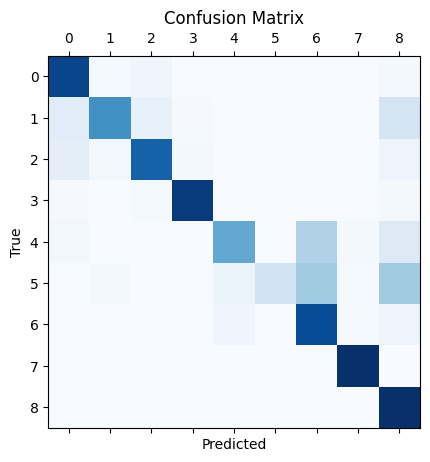

   overall_precision  overall_recall  overall_f1  overall_accuracy
0           0.816803        0.829674    0.823188          0.968752

                   LOC        MISC          ORG          PER
precision     0.786566    0.714801     0.754913     0.953329
recall        0.870504    0.564103     0.786273     0.947434
f1            0.826409    0.630573     0.770274     0.950372
number     1668.000000  702.000000  1661.000000  1617.000000

end of run
---------------------------------------------------
---------------------------------------------------
starting run on training set of 13%



Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['cl

{'eval_loss': 2.2043814659118652, 'eval_precision': 0.015008296043038865, 'eval_recall': 0.10570113314447592, 'eval_f1': 0.02628450667018888, 'eval_accuracy': 0.057930440400559925, 'eval_runtime': 6.9637, 'eval_samples_per_second': 495.859, 'eval_steps_per_second': 7.755, 'epoch': 0.01}



  1%|          | 3/575 [00:14<52:40,  5.53s/it]

{'eval_loss': 2.2008168697357178, 'eval_precision': 0.014981744932645097, 'eval_recall': 0.1053470254957507, 'eval_f1': 0.026232832925511984, 'eval_accuracy': 0.05976095617529881, 'eval_runtime': 6.9751, 'eval_samples_per_second': 495.048, 'eval_steps_per_second': 7.742, 'epoch': 0.02}



  1%|          | 4/575 [00:21<58:34,  6.16s/it]

{'eval_loss': 2.1936333179473877, 'eval_precision': 0.015004167824395665, 'eval_recall': 0.1051699716713881, 'eval_f1': 0.02626168844087804, 'eval_accuracy': 0.06355120060299344, 'eval_runtime': 7.0074, 'eval_samples_per_second': 492.763, 'eval_steps_per_second': 7.706, 'epoch': 0.03}



  1%|          | 5/575 [00:28<1:01:40,  6.49s/it]

{'eval_loss': 2.183124303817749, 'eval_precision': 0.015097600650671004, 'eval_recall': 0.1051699716713881, 'eval_f1': 0.026404694167852065, 'eval_accuracy': 0.07020566383116184, 'eval_runtime': 6.9885, 'eval_samples_per_second': 494.096, 'eval_steps_per_second': 7.727, 'epoch': 0.03}



  1%|          | 6/575 [00:35<1:03:33,  6.70s/it]

{'eval_loss': 2.1691949367523193, 'eval_precision': 0.015274218349564326, 'eval_recall': 0.10552407932011332, 'eval_f1': 0.026685770574012717, 'eval_accuracy': 0.07877678475288037, 'eval_runtime': 6.9835, 'eval_samples_per_second': 494.448, 'eval_steps_per_second': 7.732, 'epoch': 0.04}



  1%|          | 7/575 [00:42<1:04:41,  6.83s/it]

{'eval_loss': 2.151991367340088, 'eval_precision': 0.015647706041104423, 'eval_recall': 0.10676345609065156, 'eval_f1': 0.027294948397609996, 'eval_accuracy': 0.09139657585872725, 'eval_runtime': 6.9851, 'eval_samples_per_second': 494.335, 'eval_steps_per_second': 7.731, 'epoch': 0.05}



  1%|▏         | 8/575 [00:49<1:05:42,  6.95s/it]

{'eval_loss': 2.1310482025146484, 'eval_precision': 0.016134578252704524, 'eval_recall': 0.10800283286118981, 'eval_f1': 0.028075020135772635, 'eval_accuracy': 0.11084311403036502, 'eval_runtime': 7.1072, 'eval_samples_per_second': 485.843, 'eval_steps_per_second': 7.598, 'epoch': 0.06}



  2%|▏         | 9/575 [00:56<1:05:55,  6.99s/it]

{'eval_loss': 2.106715679168701, 'eval_precision': 0.0165257703845105, 'eval_recall': 0.10729461756373938, 'eval_f1': 0.028640294909967386, 'eval_accuracy': 0.13875309572520728, 'eval_runtime': 6.9665, 'eval_samples_per_second': 495.659, 'eval_steps_per_second': 7.751, 'epoch': 0.07}



  2%|▏         | 10/575 [01:04<1:06:01,  7.01s/it]

{'eval_loss': 2.0791382789611816, 'eval_precision': 0.017160333012403012, 'eval_recall': 0.10729461756373938, 'eval_f1': 0.029588399003954886, 'eval_accuracy': 0.1728437600947561, 'eval_runtime': 6.9668, 'eval_samples_per_second': 495.634, 'eval_steps_per_second': 7.751, 'epoch': 0.08}



  2%|▏         | 10/575 [01:11<1:06:01,  7.01s/it]

{'eval_loss': 2.0484979152679443, 'eval_precision': 0.01807337249730248, 'eval_recall': 0.10676345609065156, 'eval_f1': 0.030913565056905568, 'eval_accuracy': 0.2205017766770755, 'eval_runtime': 6.9809, 'eval_samples_per_second': 494.638, 'eval_steps_per_second': 7.735, 'epoch': 0.09}


  2%|▏         | 12/575 [01:19<1:07:47,  7.22s/it]

{'eval_loss': 2.0145742893218994, 'eval_precision': 0.019291567197883733, 'eval_recall': 0.10587818696883852, 'eval_f1': 0.03263657697975222, 'eval_accuracy': 0.27558953375686446, 'eval_runtime': 6.9631, 'eval_samples_per_second': 495.897, 'eval_steps_per_second': 7.755, 'epoch': 0.1}



  2%|▏         | 13/575 [01:26<1:07:17,  7.18s/it]

{'eval_loss': 1.9774242639541626, 'eval_precision': 0.021096896047895657, 'eval_recall': 0.1048158640226629, 'eval_f1': 0.03512415082025572, 'eval_accuracy': 0.34075589533756867, 'eval_runtime': 6.9643, 'eval_samples_per_second': 495.817, 'eval_steps_per_second': 7.754, 'epoch': 0.1}



  2%|▏         | 14/575 [01:33<1:06:48,  7.15s/it]

{'eval_loss': 1.9370936155319214, 'eval_precision': 0.022722661797524853, 'eval_recall': 0.09915014164305949, 'eval_f1': 0.03697223781071535, 'eval_accuracy': 0.41305050069990307, 'eval_runtime': 6.9604, 'eval_samples_per_second': 496.092, 'eval_steps_per_second': 7.758, 'epoch': 0.11}



  3%|▎         | 15/575 [01:40<1:06:42,  7.15s/it]

{'eval_loss': 1.893425464630127, 'eval_precision': 0.023305084745762712, 'eval_recall': 0.08569405099150142, 'eval_f1': 0.036644457904300425, 'eval_accuracy': 0.4891353504899322, 'eval_runtime': 7.0476, 'eval_samples_per_second': 489.954, 'eval_steps_per_second': 7.662, 'epoch': 0.12}



  3%|▎         | 16/575 [01:47<1:06:15,  7.11s/it]

{'eval_loss': 1.8466308116912842, 'eval_precision': 0.02588860056725605, 'eval_recall': 0.07595609065155808, 'eval_f1': 0.03861559926189297, 'eval_accuracy': 0.5679552062022182, 'eval_runtime': 6.9252, 'eval_samples_per_second': 498.617, 'eval_steps_per_second': 7.798, 'epoch': 0.13}



  3%|▎         | 17/575 [01:54<1:05:46,  7.07s/it]

{'eval_loss': 1.7967946529388428, 'eval_precision': 0.027301587301587302, 'eval_recall': 0.060906515580736544, 'eval_f1': 0.03770276194651469, 'eval_accuracy': 0.6373209863249704, 'eval_runtime': 6.8798, 'eval_samples_per_second': 501.901, 'eval_steps_per_second': 7.849, 'epoch': 0.14}



  3%|▎         | 18/575 [02:01<1:05:26,  7.05s/it]

{'eval_loss': 1.7434167861938477, 'eval_precision': 0.02755285650022492, 'eval_recall': 0.04337818696883853, 'eval_f1': 0.03370013755158184, 'eval_accuracy': 0.6979218262086788, 'eval_runtime': 6.8736, 'eval_samples_per_second': 502.355, 'eval_steps_per_second': 7.856, 'epoch': 0.15}



  3%|▎         | 19/575 [02:08<1:05:07,  7.03s/it]

{'eval_loss': 1.6869189739227295, 'eval_precision': 0.029131264088780997, 'eval_recall': 0.029745042492917848, 'eval_f1': 0.029434954007884366, 'eval_accuracy': 0.744567675244966, 'eval_runtime': 6.8695, 'eval_samples_per_second': 502.66, 'eval_steps_per_second': 7.861, 'epoch': 0.16}



  3%|▎         | 20/575 [02:15<1:04:49,  7.01s/it]

{'eval_loss': 1.6278072595596313, 'eval_precision': 0.025970319634703195, 'eval_recall': 0.016111898016997167, 'eval_f1': 0.019886363636363636, 'eval_accuracy': 0.7751695919026597, 'eval_runtime': 6.8709, 'eval_samples_per_second': 502.557, 'eval_steps_per_second': 7.859, 'epoch': 0.17}



  3%|▎         | 20/575 [02:22<1:04:49,  7.01s/it]

{'eval_loss': 1.5659030675888062, 'eval_precision': 0.0273768043802887, 'eval_recall': 0.009737960339943343, 'eval_f1': 0.014365939663053417, 'eval_accuracy': 0.7966404651663616, 'eval_runtime': 6.8986, 'eval_samples_per_second': 500.535, 'eval_steps_per_second': 7.828, 'epoch': 0.17}


  4%|▍         | 22/575 [02:30<1:06:34,  7.22s/it]

{'eval_loss': 1.5017213821411133, 'eval_precision': 0.028328611898016998, 'eval_recall': 0.005311614730878187, 'eval_f1': 0.008945877441479053, 'eval_accuracy': 0.8099063206632928, 'eval_runtime': 7.0067, 'eval_samples_per_second': 492.813, 'eval_steps_per_second': 7.707, 'epoch': 0.18}



  4%|▍         | 23/575 [02:37<1:05:45,  7.15s/it]

{'eval_loss': 1.435142159461975, 'eval_precision': 0.04329004329004329, 'eval_recall': 0.0035410764872521247, 'eval_f1': 0.006546644844517185, 'eval_accuracy': 0.818628189942931, 'eval_runtime': 6.8675, 'eval_samples_per_second': 502.8, 'eval_steps_per_second': 7.863, 'epoch': 0.19}



  4%|▍         | 24/575 [02:44<1:05:08,  7.09s/it]

{'eval_loss': 1.3670426607131958, 'eval_precision': 0.03825136612021858, 'eval_recall': 0.0012393767705382436, 'eval_f1': 0.0024009603841536613, 'eval_accuracy': 0.8226768601270593, 'eval_runtime': 6.8629, 'eval_samples_per_second': 503.143, 'eval_steps_per_second': 7.868, 'epoch': 0.2}



  4%|▍         | 25/575 [02:51<1:04:42,  7.06s/it]

{'eval_loss': 1.2976633310317993, 'eval_precision': 0.06451612903225806, 'eval_recall': 0.000708215297450425, 'eval_f1': 0.0014010507880910684, 'eval_accuracy': 0.8244643049423926, 'eval_runtime': 6.8652, 'eval_samples_per_second': 502.969, 'eval_steps_per_second': 7.866, 'epoch': 0.21}


/home/ronen/Documents/college/NNForNLP/workshop_1/.conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  5%|▍         | 26/575 [02:58<1:04:27,  7.04s/it]

{'eval_loss': 1.2282689809799194, 'eval_precision': 0.1, 'eval_recall': 0.0003541076487252125, 'eval_f1': 0.0007057163020465773, 'eval_accuracy': 0.8250672983740713, 'eval_runtime': 6.9097, 'eval_samples_per_second': 499.731, 'eval_steps_per_second': 7.815, 'epoch': 0.22}



  5%|▍         | 27/575 [03:05<1:04:23,  7.05s/it]

{'eval_loss': 1.1593141555786133, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8251965112522881, 'eval_runtime': 6.9504, 'eval_samples_per_second': 496.808, 'eval_steps_per_second': 7.769, 'epoch': 0.23}



  5%|▍         | 28/575 [03:12<1:04:03,  7.03s/it]

{'eval_loss': 1.091935396194458, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8252826531710994, 'eval_runtime': 6.876, 'eval_samples_per_second': 502.184, 'eval_steps_per_second': 7.853, 'epoch': 0.23}


/home/ronen/Documents/college/NNForNLP/workshop_1/.conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  5%|▌         | 29/575 [03:19<1:04:14,  7.06s/it]

{'eval_loss': 1.0272778272628784, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 7.0473, 'eval_samples_per_second': 489.975, 'eval_steps_per_second': 7.663, 'epoch': 0.24}



  5%|▌         | 30/575 [03:26<1:03:52,  7.03s/it]

{'eval_loss': 0.9676029086112976, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.878, 'eval_samples_per_second': 502.032, 'eval_steps_per_second': 7.851, 'epoch': 0.25}



  5%|▌         | 30/575 [03:33<1:03:52,  7.03s/it]

{'eval_loss': 0.9146705269813538, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.8839, 'eval_samples_per_second': 501.607, 'eval_steps_per_second': 7.844, 'epoch': 0.26}


  5%|▌         | 31/575 [03:34<1:06:01,  7.28s/it]/home/ronen/Documents/college/NNForNLP/workshop_1/.conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ronen/Documents/college/NNForNLP/workshop_1/.conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  6%|▌         | 32/575 [03:41<1:05:03,  7.19s/it]

{'eval_loss': 0.8688483238220215, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.8868, 'eval_samples_per_second': 501.393, 'eval_steps_per_second': 7.841, 'epoch': 0.27}



  6%|▌         | 33/575 [03:48<1:04:23,  7.13s/it]

{'eval_loss': 0.8318856954574585, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.8889, 'eval_samples_per_second': 501.241, 'eval_steps_per_second': 7.839, 'epoch': 0.28}



  6%|▌         | 34/575 [03:55<1:03:51,  7.08s/it]

{'eval_loss': 0.8044505715370178, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.8852, 'eval_samples_per_second': 501.512, 'eval_steps_per_second': 7.843, 'epoch': 0.29}



  6%|▌         | 35/575 [04:02<1:03:30,  7.06s/it]

{'eval_loss': 0.7873440384864807, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.8863, 'eval_samples_per_second': 501.43, 'eval_steps_per_second': 7.842, 'epoch': 0.3}



  6%|▋         | 36/575 [04:09<1:03:29,  7.07s/it]

{'eval_loss': 0.7787132859230042, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.998, 'eval_samples_per_second': 493.426, 'eval_steps_per_second': 7.716, 'epoch': 0.3}



  6%|▋         | 37/575 [04:16<1:03:13,  7.05s/it]

{'eval_loss': 0.7778115272521973, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.9109, 'eval_samples_per_second': 499.645, 'eval_steps_per_second': 7.814, 'epoch': 0.31}



  7%|▋         | 38/575 [04:23<1:02:59,  7.04s/it]

{'eval_loss': 0.7734842896461487, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.9091, 'eval_samples_per_second': 499.772, 'eval_steps_per_second': 7.816, 'epoch': 0.32}



  7%|▋         | 39/575 [04:30<1:02:47,  7.03s/it]

{'eval_loss': 0.7619398832321167, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.898, 'eval_samples_per_second': 500.577, 'eval_steps_per_second': 7.828, 'epoch': 0.33}



  7%|▋         | 40/575 [04:37<1:02:34,  7.02s/it]

{'eval_loss': 0.7428491711616516, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.8981, 'eval_samples_per_second': 500.575, 'eval_steps_per_second': 7.828, 'epoch': 0.34}



  7%|▋         | 40/575 [04:44<1:02:34,  7.02s/it]

{'eval_loss': 0.7176970839500427, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.8938, 'eval_samples_per_second': 500.885, 'eval_steps_per_second': 7.833, 'epoch': 0.35}


  7%|▋         | 41/575 [04:45<1:04:44,  7.27s/it]/home/ronen/Documents/college/NNForNLP/workshop_1/.conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ronen/Documents/college/NNForNLP/workshop_1/.conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  7%|▋         | 42/575 [04:52<1:03:53,  7.19s/it]

{'eval_loss': 0.6919564008712769, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.8841, 'eval_samples_per_second': 501.593, 'eval_steps_per_second': 7.844, 'epoch': 0.36}



  7%|▋         | 43/575 [04:59<1:03:13,  7.13s/it]

{'eval_loss': 0.668175995349884, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.8849, 'eval_samples_per_second': 501.53, 'eval_steps_per_second': 7.843, 'epoch': 0.37}



  8%|▊         | 44/575 [05:06<1:03:03,  7.13s/it]

{'eval_loss': 0.6469674110412598, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 7.0185, 'eval_samples_per_second': 491.985, 'eval_steps_per_second': 7.694, 'epoch': 0.37}



  8%|▊         | 45/575 [05:13<1:02:33,  7.08s/it]

{'eval_loss': 0.629784882068634, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.8899, 'eval_samples_per_second': 501.17, 'eval_steps_per_second': 7.838, 'epoch': 0.38}



  8%|▊         | 46/575 [05:20<1:02:07,  7.05s/it]

{'eval_loss': 0.6152028441429138, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.8758, 'eval_samples_per_second': 502.195, 'eval_steps_per_second': 7.854, 'epoch': 0.39}



  8%|▊         | 47/575 [05:27<1:01:54,  7.03s/it]

{'eval_loss': 0.601181149482727, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.9077, 'eval_samples_per_second': 499.88, 'eval_steps_per_second': 7.817, 'epoch': 0.4}



  8%|▊         | 48/575 [05:34<1:01:41,  7.02s/it]

{'eval_loss': 0.5856143236160278, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.8823, 'eval_samples_per_second': 501.722, 'eval_steps_per_second': 7.846, 'epoch': 0.41}



  9%|▊         | 49/575 [05:41<1:01:26,  7.01s/it]

{'eval_loss': 0.5680558085441589, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253472596102078, 'eval_runtime': 6.8806, 'eval_samples_per_second': 501.847, 'eval_steps_per_second': 7.848, 'epoch': 0.42}



  9%|▊         | 50/575 [05:48<1:01:16,  7.00s/it]

{'eval_loss': 0.5501255393028259, 'eval_precision': 0.11764705882352941, 'eval_recall': 0.0003541076487252125, 'eval_f1': 0.0007060900264783761, 'eval_accuracy': 0.8256056853666416, 'eval_runtime': 6.8816, 'eval_samples_per_second': 501.773, 'eval_steps_per_second': 7.847, 'epoch': 0.43}



  9%|▊         | 50/575 [05:55<1:01:16,  7.00s/it]

{'eval_loss': 0.5317606329917908, 'eval_precision': 0.3333333333333333, 'eval_recall': 0.0047804532577903685, 'eval_f1': 0.009425728748472683, 'eval_accuracy': 0.8265747819532681, 'eval_runtime': 6.9928, 'eval_samples_per_second': 493.791, 'eval_steps_per_second': 7.722, 'epoch': 0.43}


  9%|▉         | 51/575 [05:56<1:03:46,  7.30s/it]/home/ronen/Documents/college/NNForNLP/workshop_1/.conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  9%|▉         | 52/575 [06:03<1:02:52,  7.21s/it]

{'eval_loss': 0.5146716833114624, 'eval_precision': 0.39416058394160586, 'eval_recall': 0.019121813031161474, 'eval_f1': 0.03647416413373861, 'eval_accuracy': 0.8296543555507699, 'eval_runtime': 6.8969, 'eval_samples_per_second': 500.662, 'eval_steps_per_second': 7.83, 'epoch': 0.44}



  9%|▉         | 53/575 [06:10<1:02:10,  7.15s/it]

{'eval_loss': 0.5008740425109863, 'eval_precision': 0.4471299093655589, 'eval_recall': 0.05240793201133145, 'eval_f1': 0.09381933438985737, 'eval_accuracy': 0.8353612576720146, 'eval_runtime': 6.8946, 'eval_samples_per_second': 500.828, 'eval_steps_per_second': 7.832, 'epoch': 0.45}



  9%|▉         | 54/575 [06:17<1:01:42,  7.11s/it]

{'eval_loss': 0.48907291889190674, 'eval_precision': 0.39473684210526316, 'eval_recall': 0.0823300283286119, 'eval_f1': 0.13624377380603572, 'eval_accuracy': 0.8421018628189942, 'eval_runtime': 6.9244, 'eval_samples_per_second': 498.674, 'eval_steps_per_second': 7.799, 'epoch': 0.46}



 10%|▉         | 55/575 [06:24<1:01:19,  7.08s/it]

{'eval_loss': 0.4785453975200653, 'eval_precision': 0.33844526705446853, 'eval_recall': 0.11331444759206799, 'eval_f1': 0.1697837909537074, 'eval_accuracy': 0.8501130612684398, 'eval_runtime': 6.9006, 'eval_samples_per_second': 500.388, 'eval_steps_per_second': 7.825, 'epoch': 0.47}



 10%|▉         | 56/575 [06:31<1:01:02,  7.06s/it]

{'eval_loss': 0.4667750597000122, 'eval_precision': 0.30401737242128124, 'eval_recall': 0.14872521246458922, 'eval_f1': 0.19973843776007608, 'eval_accuracy': 0.8579950468396683, 'eval_runtime': 6.9165, 'eval_samples_per_second': 499.244, 'eval_steps_per_second': 7.807, 'epoch': 0.48}



 10%|▉         | 57/575 [06:38<1:00:56,  7.06s/it]

{'eval_loss': 0.4542388617992401, 'eval_precision': 0.28039112050739956, 'eval_recall': 0.1878541076487252, 'eval_f1': 0.22497879558948258, 'eval_accuracy': 0.8656832130935717, 'eval_runtime': 6.965, 'eval_samples_per_second': 495.762, 'eval_steps_per_second': 7.753, 'epoch': 0.49}



 10%|█         | 58/575 [06:45<1:01:13,  7.11s/it]

{'eval_loss': 0.4411964416503906, 'eval_precision': 0.27263023057216057, 'eval_recall': 0.22609773371104816, 'eval_f1': 0.24719318621757647, 'eval_accuracy': 0.8729191342737159, 'eval_runtime': 7.096, 'eval_samples_per_second': 486.609, 'eval_steps_per_second': 7.61, 'epoch': 0.5}



 10%|█         | 59/575 [06:52<1:01:02,  7.10s/it]

{'eval_loss': 0.42871811985969543, 'eval_precision': 0.26966089466089466, 'eval_recall': 0.2646954674220963, 'eval_f1': 0.26715511079342386, 'eval_accuracy': 0.879164423387531, 'eval_runtime': 6.974, 'eval_samples_per_second': 495.125, 'eval_steps_per_second': 7.743, 'epoch': 0.5}



 10%|█         | 60/575 [06:59<1:00:53,  7.09s/it]

{'eval_loss': 0.4178919196128845, 'eval_precision': 0.2699601593625498, 'eval_recall': 0.29992917847025496, 'eval_f1': 0.28415667197852895, 'eval_accuracy': 0.8836868741251211, 'eval_runtime': 6.9726, 'eval_samples_per_second': 495.227, 'eval_steps_per_second': 7.745, 'epoch': 0.51}



 10%|█         | 60/575 [07:06<1:00:53,  7.09s/it]

{'eval_loss': 0.4075038731098175, 'eval_precision': 0.27662123708252206, 'eval_recall': 0.3270184135977337, 'eval_f1': 0.29971602434077077, 'eval_accuracy': 0.8868310541617315, 'eval_runtime': 6.9343, 'eval_samples_per_second': 497.963, 'eval_steps_per_second': 7.787, 'epoch': 0.52}


 11%|█         | 61/575 [07:07<1:02:57,  7.35s/it]/home/ronen/Documents/college/NNForNLP/workshop_1/.conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 11%|█         | 62/575 [07:14<1:02:03,  7.26s/it]

{'eval_loss': 0.39769354462623596, 'eval_precision': 0.28778018799710775, 'eval_recall': 0.3523371104815864, 'eval_f1': 0.3168033113109926, 'eval_accuracy': 0.890061376117153, 'eval_runtime': 6.9275, 'eval_samples_per_second': 498.445, 'eval_steps_per_second': 7.795, 'epoch': 0.53}



 11%|█         | 63/575 [07:21<1:01:37,  7.22s/it]

{'eval_loss': 0.38792431354522705, 'eval_precision': 0.30444004524886875, 'eval_recall': 0.38119688385269124, 'eval_f1': 0.33852201257861636, 'eval_accuracy': 0.8942823301389038, 'eval_runtime': 7.0514, 'eval_samples_per_second': 489.689, 'eval_steps_per_second': 7.658, 'epoch': 0.54}



 11%|█         | 64/575 [07:28<1:01:22,  7.21s/it]

{'eval_loss': 0.3775160610675812, 'eval_precision': 0.31949685534591193, 'eval_recall': 0.4047450424929179, 'eval_f1': 0.35710380379598533, 'eval_accuracy': 0.8985248196403575, 'eval_runtime': 7.0707, 'eval_samples_per_second': 488.352, 'eval_steps_per_second': 7.637, 'epoch': 0.55}



 11%|█▏        | 65/575 [07:36<1:01:14,  7.20s/it]

{'eval_loss': 0.36633479595184326, 'eval_precision': 0.3286371878923141, 'eval_recall': 0.4171388101983003, 'eval_f1': 0.36763673246469525, 'eval_accuracy': 0.9018628189942931, 'eval_runtime': 7.0963, 'eval_samples_per_second': 486.59, 'eval_steps_per_second': 7.61, 'epoch': 0.56}



 11%|█▏        | 66/575 [07:43<1:00:47,  7.17s/it]

{'eval_loss': 0.3555131256580353, 'eval_precision': 0.34485654303708885, 'eval_recall': 0.43626062322946174, 'eval_f1': 0.3852106620808254, 'eval_accuracy': 0.9058684182190159, 'eval_runtime': 6.9643, 'eval_samples_per_second': 495.812, 'eval_steps_per_second': 7.754, 'epoch': 0.57}



 12%|█▏        | 67/575 [07:50<1:00:24,  7.13s/it]

{'eval_loss': 0.3456394076347351, 'eval_precision': 0.363802046824618, 'eval_recall': 0.4594546742209632, 'eval_f1': 0.4060715124012205, 'eval_accuracy': 0.9093356304511683, 'eval_runtime': 6.9643, 'eval_samples_per_second': 495.813, 'eval_steps_per_second': 7.754, 'epoch': 0.57}



 12%|█▏        | 68/575 [07:57<1:00:09,  7.12s/it]

{'eval_loss': 0.3344718813896179, 'eval_precision': 0.38243626062322944, 'eval_recall': 0.4780453257790368, 'eval_f1': 0.4249291784702549, 'eval_accuracy': 0.9128674491224292, 'eval_runtime': 7.0047, 'eval_samples_per_second': 492.952, 'eval_steps_per_second': 7.709, 'epoch': 0.58}



 12%|█▏        | 69/575 [08:04<59:58,  7.11s/it]  

{'eval_loss': 0.3251560628414154, 'eval_precision': 0.3991639037047715, 'eval_recall': 0.49026203966005666, 'eval_f1': 0.4400476758045292, 'eval_accuracy': 0.9159900936793367, 'eval_runtime': 6.9927, 'eval_samples_per_second': 493.802, 'eval_steps_per_second': 7.722, 'epoch': 0.59}



 12%|█▏        | 70/575 [08:11<59:49,  7.11s/it]

{'eval_loss': 0.3174680173397064, 'eval_precision': 0.4108312709273548, 'eval_recall': 0.49964589235127477, 'eval_f1': 0.45090676679715586, 'eval_accuracy': 0.9183589964466459, 'eval_runtime': 6.9964, 'eval_samples_per_second': 493.543, 'eval_steps_per_second': 7.718, 'epoch': 0.6}



 12%|█▏        | 70/575 [08:18<59:49,  7.11s/it]

{'eval_loss': 0.31075319647789, 'eval_precision': 0.42233651726671567, 'eval_recall': 0.5088526912181303, 'eval_f1': 0.4615755239701277, 'eval_accuracy': 0.9202110477010875, 'eval_runtime': 6.9917, 'eval_samples_per_second': 493.873, 'eval_steps_per_second': 7.723, 'epoch': 0.61}


 12%|█▏        | 71/575 [08:19<1:02:02,  7.39s/it]/home/ronen/Documents/college/NNForNLP/workshop_1/.conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 13%|█▎        | 72/575 [08:26<1:01:35,  7.35s/it]

{'eval_loss': 0.3039546608924866, 'eval_precision': 0.43697104677060133, 'eval_recall': 0.5210694050991501, 'eval_f1': 0.4753290801905839, 'eval_accuracy': 0.9219984925164209, 'eval_runtime': 7.1377, 'eval_samples_per_second': 483.766, 'eval_steps_per_second': 7.565, 'epoch': 0.62}



 13%|█▎        | 73/575 [08:33<1:01:02,  7.30s/it]

{'eval_loss': 0.2979952394962311, 'eval_precision': 0.45434030389649466, 'eval_recall': 0.5347025495750708, 'eval_f1': 0.4912566083773892, 'eval_accuracy': 0.9241951114461074, 'eval_runtime': 7.0755, 'eval_samples_per_second': 488.022, 'eval_steps_per_second': 7.632, 'epoch': 0.63}



 13%|█▎        | 74/575 [08:41<1:00:50,  7.29s/it]

{'eval_loss': 0.29137763381004333, 'eval_precision': 0.46628364076201995, 'eval_recall': 0.5460339943342776, 'eval_f1': 0.5030174522916326, 'eval_accuracy': 0.9259610207817379, 'eval_runtime': 7.1804, 'eval_samples_per_second': 480.892, 'eval_steps_per_second': 7.52, 'epoch': 0.63}



 13%|█▎        | 75/575 [08:48<1:00:40,  7.28s/it]

{'eval_loss': 0.2840031087398529, 'eval_precision': 0.48826219512195124, 'eval_recall': 0.5671033994334278, 'eval_f1': 0.524737876802097, 'eval_accuracy': 0.928459136427264, 'eval_runtime': 7.1809, 'eval_samples_per_second': 480.861, 'eval_steps_per_second': 7.52, 'epoch': 0.64}



 13%|█▎        | 76/575 [08:55<1:00:17,  7.25s/it]

{'eval_loss': 0.27689698338508606, 'eval_precision': 0.5089313212195873, 'eval_recall': 0.5851628895184136, 'eval_f1': 0.5443913688025036, 'eval_accuracy': 0.9305050069990309, 'eval_runtime': 7.0863, 'eval_samples_per_second': 487.281, 'eval_steps_per_second': 7.62, 'epoch': 0.65}



 13%|█▎        | 77/575 [09:02<59:44,  7.20s/it]  

{'eval_loss': 0.2699425220489502, 'eval_precision': 0.5239197530864198, 'eval_recall': 0.6010977337110481, 'eval_f1': 0.5598614775725594, 'eval_accuracy': 0.9321417034564445, 'eval_runtime': 6.9813, 'eval_samples_per_second': 494.608, 'eval_steps_per_second': 7.735, 'epoch': 0.66}



 14%|█▎        | 78/575 [09:09<59:26,  7.18s/it]

{'eval_loss': 0.26500946283340454, 'eval_precision': 0.5378670788253478, 'eval_recall': 0.6161473087818697, 'eval_f1': 0.5743522033338835, 'eval_accuracy': 0.9336276515559384, 'eval_runtime': 7.005, 'eval_samples_per_second': 492.936, 'eval_steps_per_second': 7.709, 'epoch': 0.67}



 14%|█▎        | 79/575 [09:17<59:28,  7.20s/it]

{'eval_loss': 0.25979188084602356, 'eval_precision': 0.5448479205462445, 'eval_recall': 0.6216359773371105, 'eval_f1': 0.5807145219980151, 'eval_accuracy': 0.9347044255410789, 'eval_runtime': 7.1484, 'eval_samples_per_second': 483.044, 'eval_steps_per_second': 7.554, 'epoch': 0.68}



 14%|█▍        | 80/575 [09:24<59:12,  7.18s/it]

{'eval_loss': 0.25391027331352234, 'eval_precision': 0.5549105742077188, 'eval_recall': 0.6262393767705382, 'eval_f1': 0.5884212277491265, 'eval_accuracy': 0.9358027350059223, 'eval_runtime': 7.0346, 'eval_samples_per_second': 490.858, 'eval_steps_per_second': 7.676, 'epoch': 0.69}



 14%|█▍        | 80/575 [09:31<59:12,  7.18s/it]

{'eval_loss': 0.24819406867027283, 'eval_precision': 0.5680878141902641, 'eval_recall': 0.6322592067988668, 'eval_f1': 0.5984581866934808, 'eval_accuracy': 0.9372240766663077, 'eval_runtime': 7.055, 'eval_samples_per_second': 489.437, 'eval_steps_per_second': 7.654, 'epoch': 0.7}


 14%|█▍        | 82/575 [09:39<1:00:20,  7.34s/it]

{'eval_loss': 0.24306631088256836, 'eval_precision': 0.582808208111165, 'eval_recall': 0.6386331444759207, 'eval_f1': 0.6094449607163976, 'eval_accuracy': 0.9388177021643157, 'eval_runtime': 7.0147, 'eval_samples_per_second': 492.251, 'eval_steps_per_second': 7.698, 'epoch': 0.7}



 14%|█▍        | 83/575 [09:46<59:38,  7.27s/it]  

{'eval_loss': 0.23883703351020813, 'eval_precision': 0.6027891714520098, 'eval_recall': 0.6504957507082153, 'eval_f1': 0.6257344801158137, 'eval_accuracy': 0.940949714654894, 'eval_runtime': 7.0121, 'eval_samples_per_second': 492.434, 'eval_steps_per_second': 7.701, 'epoch': 0.71}



 15%|█▍        | 84/575 [09:53<59:19,  7.25s/it]

{'eval_loss': 0.23516777157783508, 'eval_precision': 0.6202341137123746, 'eval_recall': 0.6566926345609065, 'eval_f1': 0.6379428964568284, 'eval_accuracy': 0.9421557015182513, 'eval_runtime': 7.0884, 'eval_samples_per_second': 487.137, 'eval_steps_per_second': 7.618, 'epoch': 0.72}



 15%|█▍        | 85/575 [10:01<59:38,  7.30s/it]

{'eval_loss': 0.23181597888469696, 'eval_precision': 0.6383770076077768, 'eval_recall': 0.6685552407932012, 'eval_f1': 0.6531177030182479, 'eval_accuracy': 0.9437277915365565, 'eval_runtime': 7.3039, 'eval_samples_per_second': 472.761, 'eval_steps_per_second': 7.393, 'epoch': 0.73}



 15%|█▍        | 86/575 [10:08<59:30,  7.30s/it]

{'eval_loss': 0.2283438742160797, 'eval_precision': 0.6475867908552074, 'eval_recall': 0.6770538243626062, 'eval_f1': 0.6619925560460487, 'eval_accuracy': 0.9446538171637773, 'eval_runtime': 7.2029, 'eval_samples_per_second': 479.389, 'eval_steps_per_second': 7.497, 'epoch': 0.74}



 15%|█▌        | 87/575 [10:15<59:40,  7.34s/it]

{'eval_loss': 0.22498060762882233, 'eval_precision': 0.6572539736219141, 'eval_recall': 0.6882082152974505, 'eval_f1': 0.6723750216225567, 'eval_accuracy': 0.94605362334446, 'eval_runtime': 7.3282, 'eval_samples_per_second': 471.195, 'eval_steps_per_second': 7.369, 'epoch': 0.75}



 15%|█▌        | 88/575 [10:23<59:25,  7.32s/it]

{'eval_loss': 0.22214974462985992, 'eval_precision': 0.6594631099105183, 'eval_recall': 0.69157223796034, 'eval_f1': 0.67513611615245, 'eval_accuracy': 0.946505868418219, 'eval_runtime': 7.1714, 'eval_samples_per_second': 481.494, 'eval_steps_per_second': 7.53, 'epoch': 0.76}



 15%|█▌        | 89/575 [10:30<58:48,  7.26s/it]

{'eval_loss': 0.21921180188655853, 'eval_precision': 0.6633496373756114, 'eval_recall': 0.6963526912181303, 'eval_f1': 0.6794506348795025, 'eval_accuracy': 0.9471734682890062, 'eval_runtime': 6.9951, 'eval_samples_per_second': 493.629, 'eval_steps_per_second': 7.72, 'epoch': 0.77}



 16%|█▌        | 90/575 [10:37<58:18,  7.21s/it]

{'eval_loss': 0.21616792678833008, 'eval_precision': 0.6668347621448983, 'eval_recall': 0.7023725212464589, 'eval_f1': 0.6841424506337845, 'eval_accuracy': 0.9478841391191989, 'eval_runtime': 6.9923, 'eval_samples_per_second': 493.825, 'eval_steps_per_second': 7.723, 'epoch': 0.77}



 16%|█▌        | 90/575 [10:44<58:18,  7.21s/it]

{'eval_loss': 0.21384197473526, 'eval_precision': 0.6737002025658338, 'eval_recall': 0.7066218130311614, 'eval_f1': 0.6897684064984445, 'eval_accuracy': 0.9487886292667169, 'eval_runtime': 6.9957, 'eval_samples_per_second': 493.588, 'eval_steps_per_second': 7.719, 'epoch': 0.78}


 16%|█▌        | 92/575 [10:52<59:09,  7.35s/it]  

{'eval_loss': 0.21180610358715057, 'eval_precision': 0.674375422012154, 'eval_recall': 0.7073300283286119, 'eval_f1': 0.6904597303836848, 'eval_accuracy': 0.9489609131043394, 'eval_runtime': 6.9789, 'eval_samples_per_second': 494.778, 'eval_steps_per_second': 7.738, 'epoch': 0.79}



 16%|█▌        | 93/575 [10:59<58:23,  7.27s/it]

{'eval_loss': 0.20939739048480988, 'eval_precision': 0.6773813530797711, 'eval_recall': 0.7126416430594901, 'eval_f1': 0.6945642795513374, 'eval_accuracy': 0.949908474211263, 'eval_runtime': 6.9834, 'eval_samples_per_second': 494.459, 'eval_steps_per_second': 7.733, 'epoch': 0.8}



 16%|█▋        | 94/575 [11:06<58:08,  7.25s/it]

{'eval_loss': 0.20714999735355377, 'eval_precision': 0.6866960054163845, 'eval_recall': 0.7183073654390935, 'eval_f1': 0.7021460713049498, 'eval_accuracy': 0.950812964358781, 'eval_runtime': 7.1179, 'eval_samples_per_second': 485.118, 'eval_steps_per_second': 7.587, 'epoch': 0.81}



 17%|█▋        | 95/575 [11:13<57:35,  7.20s/it]

{'eval_loss': 0.20421284437179565, 'eval_precision': 0.6910994764397905, 'eval_recall': 0.7245042492917847, 'eval_f1': 0.7074077275477569, 'eval_accuracy': 0.951609777107785, 'eval_runtime': 6.9723, 'eval_samples_per_second': 495.249, 'eval_steps_per_second': 7.745, 'epoch': 0.82}



 17%|█▋        | 96/575 [11:20<57:10,  7.16s/it]

{'eval_loss': 0.20081470906734467, 'eval_precision': 0.6924239879052578, 'eval_recall': 0.7298158640226629, 'eval_f1': 0.7106283941039565, 'eval_accuracy': 0.9518682028642188, 'eval_runtime': 6.9653, 'eval_samples_per_second': 495.744, 'eval_steps_per_second': 7.753, 'epoch': 0.83}



 17%|█▋        | 97/575 [11:28<56:57,  7.15s/it]

{'eval_loss': 0.19896188378334045, 'eval_precision': 0.6884724778316882, 'eval_recall': 0.7285764872521246, 'eval_f1': 0.7079569892473119, 'eval_accuracy': 0.9515451706686766, 'eval_runtime': 6.999, 'eval_samples_per_second': 493.357, 'eval_steps_per_second': 7.715, 'epoch': 0.83}



 17%|█▋        | 98/575 [11:35<56:34,  7.12s/it]

{'eval_loss': 0.1977536827325821, 'eval_precision': 0.6872599766238103, 'eval_recall': 0.7287535410764873, 'eval_f1': 0.7073988141273524, 'eval_accuracy': 0.9510067836761064, 'eval_runtime': 6.9553, 'eval_samples_per_second': 496.457, 'eval_steps_per_second': 7.764, 'epoch': 0.84}



 17%|█▋        | 99/575 [11:42<56:22,  7.11s/it]

{'eval_loss': 0.19610460102558136, 'eval_precision': 0.6799003322259136, 'eval_recall': 0.7246813031161473, 'eval_f1': 0.7015769626328419, 'eval_accuracy': 0.9501453644879939, 'eval_runtime': 6.9677, 'eval_samples_per_second': 495.57, 'eval_steps_per_second': 7.75, 'epoch': 0.85}



 17%|█▋        | 100/575 [11:49<56:06,  7.09s/it]

{'eval_loss': 0.19436980783939362, 'eval_precision': 0.6765194287612089, 'eval_recall': 0.7213172804532578, 'eval_f1': 0.6982005141388175, 'eval_accuracy': 0.9493270162592872, 'eval_runtime': 6.9584, 'eval_samples_per_second': 496.233, 'eval_steps_per_second': 7.76, 'epoch': 0.86}



 17%|█▋        | 100/575 [11:56<56:06,  7.09s/it]

{'eval_loss': 0.19304414093494415, 'eval_precision': 0.6758965804837365, 'eval_recall': 0.7174220963172805, 'eval_f1': 0.696040539379885, 'eval_accuracy': 0.9487455583073113, 'eval_runtime': 6.9636, 'eval_samples_per_second': 495.861, 'eval_steps_per_second': 7.755, 'epoch': 0.87}


 18%|█▊        | 102/575 [12:04<57:29,  7.29s/it]

{'eval_loss': 0.19222019612789154, 'eval_precision': 0.6737422697643323, 'eval_recall': 0.7137039660056658, 'eval_f1': 0.6931476227323533, 'eval_accuracy': 0.9481210293959298, 'eval_runtime': 7.063, 'eval_samples_per_second': 488.885, 'eval_steps_per_second': 7.645, 'epoch': 0.88}



 18%|█▊        | 103/575 [12:11<56:49,  7.22s/it]

{'eval_loss': 0.19071580469608307, 'eval_precision': 0.6717811874583055, 'eval_recall': 0.7131728045325779, 'eval_f1': 0.6918584678804534, 'eval_accuracy': 0.9476687843221708, 'eval_runtime': 6.9619, 'eval_samples_per_second': 495.982, 'eval_steps_per_second': 7.756, 'epoch': 0.89}



 18%|█▊        | 104/575 [12:18<56:22,  7.18s/it]

{'eval_loss': 0.18748801946640015, 'eval_precision': 0.6812521036687984, 'eval_recall': 0.71671388101983, 'eval_f1': 0.6985332182916306, 'eval_accuracy': 0.948444061591472, 'eval_runtime': 6.9539, 'eval_samples_per_second': 496.556, 'eval_steps_per_second': 7.765, 'epoch': 0.9}



 18%|█▊        | 105/575 [12:25<55:51,  7.13s/it]

{'eval_loss': 0.18294057250022888, 'eval_precision': 0.6945151978264561, 'eval_recall': 0.7241501416430595, 'eval_f1': 0.709023142931438, 'eval_accuracy': 0.9501884354473996, 'eval_runtime': 6.9147, 'eval_samples_per_second': 499.37, 'eval_steps_per_second': 7.809, 'epoch': 0.9}



 18%|█▊        | 106/575 [12:32<55:27,  7.09s/it]

{'eval_loss': 0.1788426637649536, 'eval_precision': 0.7101200686106347, 'eval_recall': 0.7330028328611898, 'eval_f1': 0.7213800313643493, 'eval_accuracy': 0.9522127705394637, 'eval_runtime': 6.9139, 'eval_samples_per_second': 499.429, 'eval_steps_per_second': 7.81, 'epoch': 0.91}



 19%|█▊        | 107/575 [12:39<55:07,  7.07s/it]

{'eval_loss': 0.17582593858242035, 'eval_precision': 0.7224433292957259, 'eval_recall': 0.7391997167138811, 'eval_f1': 0.7307254747527785, 'eval_accuracy': 0.953547970281038, 'eval_runtime': 6.9085, 'eval_samples_per_second': 499.817, 'eval_steps_per_second': 7.816, 'epoch': 0.92}



 19%|█▉        | 108/575 [12:46<55:10,  7.09s/it]

{'eval_loss': 0.17416465282440186, 'eval_precision': 0.7330892608089261, 'eval_recall': 0.7445113314447592, 'eval_f1': 0.7387561489810259, 'eval_accuracy': 0.9550123829008291, 'eval_runtime': 7.0398, 'eval_samples_per_second': 490.495, 'eval_steps_per_second': 7.671, 'epoch': 0.93}



 19%|█▉        | 109/575 [12:53<54:51,  7.06s/it]

{'eval_loss': 0.17279052734375, 'eval_precision': 0.7377995452160224, 'eval_recall': 0.7468130311614731, 'eval_f1': 0.7422789265288166, 'eval_accuracy': 0.9557445892107247, 'eval_runtime': 6.918, 'eval_samples_per_second': 499.132, 'eval_steps_per_second': 7.806, 'epoch': 0.94}



 19%|█▉        | 110/575 [13:00<54:38,  7.05s/it]

{'eval_loss': 0.17086830735206604, 'eval_precision': 0.7408248864033554, 'eval_recall': 0.7505311614730878, 'eval_f1': 0.7456464379947229, 'eval_accuracy': 0.9563691181221061, 'eval_runtime': 6.9242, 'eval_samples_per_second': 498.684, 'eval_steps_per_second': 7.799, 'epoch': 0.95}



 19%|█▉        | 110/575 [13:07<54:38,  7.05s/it]

{'eval_loss': 0.1690504252910614, 'eval_precision': 0.7434509256025148, 'eval_recall': 0.7537181303116147, 'eval_f1': 0.7485493230174081, 'eval_accuracy': 0.9569936470334877, 'eval_runtime': 6.9215, 'eval_samples_per_second': 498.878, 'eval_steps_per_second': 7.802, 'epoch': 0.96}


 19%|█▉        | 112/575 [13:15<55:42,  7.22s/it]

{'eval_loss': 0.1672249138355255, 'eval_precision': 0.7452583956847051, 'eval_recall': 0.7583215297450425, 'eval_f1': 0.7517332163229486, 'eval_accuracy': 0.9576397114245719, 'eval_runtime': 6.9069, 'eval_samples_per_second': 499.938, 'eval_steps_per_second': 7.818, 'epoch': 0.97}



 20%|█▉        | 113/575 [13:22<55:06,  7.16s/it]

{'eval_loss': 0.1649356633424759, 'eval_precision': 0.7466689738709119, 'eval_recall': 0.7639872521246459, 'eval_f1': 0.7552288439660453, 'eval_accuracy': 0.9583934532141704, 'eval_runtime': 6.9101, 'eval_samples_per_second': 499.701, 'eval_steps_per_second': 7.815, 'epoch': 0.97}



 20%|█▉        | 114/575 [13:29<54:43,  7.12s/it]

{'eval_loss': 0.1634296327829361, 'eval_precision': 0.7428816466552316, 'eval_recall': 0.7668201133144475, 'eval_f1': 0.7546610907823663, 'eval_accuracy': 0.9583503822547648, 'eval_runtime': 6.9011, 'eval_samples_per_second': 500.352, 'eval_steps_per_second': 7.825, 'epoch': 0.98}



 20%|██        | 115/575 [13:36<54:37,  7.12s/it]

{'eval_loss': 0.16205288469791412, 'eval_precision': 0.744837002901519, 'eval_recall': 0.7726628895184136, 'eval_f1': 0.7584948292343789, 'eval_accuracy': 0.9589103047270378, 'eval_runtime': 7.0265, 'eval_samples_per_second': 491.422, 'eval_steps_per_second': 7.685, 'epoch': 0.99}



 20%|██        | 116/575 [13:43<54:16,  7.09s/it]

{'eval_loss': 0.16218240559101105, 'eval_precision': 0.7376496374978925, 'eval_recall': 0.7746104815864022, 'eval_f1': 0.755678383280076, 'eval_accuracy': 0.958996446645849, 'eval_runtime': 6.9273, 'eval_samples_per_second': 498.464, 'eval_steps_per_second': 7.795, 'epoch': 1.0}



 20%|██        | 117/575 [13:50<54:01,  7.08s/it]

{'eval_loss': 0.1623140573501587, 'eval_precision': 0.7337011033099298, 'eval_recall': 0.7770892351274787, 'eval_f1': 0.7547721410146174, 'eval_accuracy': 0.9591687304834715, 'eval_runtime': 6.9382, 'eval_samples_per_second': 497.677, 'eval_steps_per_second': 7.783, 'epoch': 1.01}



 21%|██        | 118/575 [13:57<53:49,  7.07s/it]

{'eval_loss': 0.16247087717056274, 'eval_precision': 0.7323265847992034, 'eval_recall': 0.7813385269121813, 'eval_f1': 0.7560390611615556, 'eval_accuracy': 0.9592764078819855, 'eval_runtime': 6.9439, 'eval_samples_per_second': 497.268, 'eval_steps_per_second': 7.777, 'epoch': 1.02}



 21%|██        | 119/575 [14:04<53:43,  7.07s/it]

{'eval_loss': 0.16302692890167236, 'eval_precision': 0.7300461741424802, 'eval_recall': 0.7838172804532578, 'eval_f1': 0.7559767759562841, 'eval_accuracy': 0.9589103047270378, 'eval_runtime': 6.9592, 'eval_samples_per_second': 496.176, 'eval_steps_per_second': 7.759, 'epoch': 1.03}



 21%|██        | 120/575 [14:12<53:32,  7.06s/it]

{'eval_loss': 0.16411370038986206, 'eval_precision': 0.7264845411418289, 'eval_recall': 0.7862960339943342, 'eval_f1': 0.755207890485503, 'eval_accuracy': 0.95854420157209, 'eval_runtime': 6.9654, 'eval_samples_per_second': 495.736, 'eval_steps_per_second': 7.753, 'epoch': 1.03}



 21%|██        | 120/575 [14:19<53:32,  7.06s/it]

{'eval_loss': 0.16519799828529358, 'eval_precision': 0.7264150943396226, 'eval_recall': 0.7907223796033994, 'eval_f1': 0.7572058324855883, 'eval_accuracy': 0.9585226660923872, 'eval_runtime': 7.1191, 'eval_samples_per_second': 485.034, 'eval_steps_per_second': 7.585, 'epoch': 1.04}


 21%|██        | 122/575 [14:27<55:05,  7.30s/it]

{'eval_loss': 0.16619154810905457, 'eval_precision': 0.7265814593107911, 'eval_recall': 0.7951487252124646, 'eval_f1': 0.7593203144813594, 'eval_accuracy': 0.9583719177344675, 'eval_runtime': 6.9578, 'eval_samples_per_second': 496.276, 'eval_steps_per_second': 7.761, 'epoch': 1.05}



 21%|██▏       | 123/575 [14:34<54:23,  7.22s/it]

{'eval_loss': 0.16411340236663818, 'eval_precision': 0.73486328125, 'eval_recall': 0.7993980169971672, 'eval_f1': 0.7657734056987788, 'eval_accuracy': 0.9593194788413912, 'eval_runtime': 6.9305, 'eval_samples_per_second': 498.235, 'eval_steps_per_second': 7.792, 'epoch': 1.06}



 22%|██▏       | 124/575 [14:41<53:50,  7.16s/it]

{'eval_loss': 0.1608174443244934, 'eval_precision': 0.7441631042420257, 'eval_recall': 0.8013456090651558, 'eval_f1': 0.7716965046888321, 'eval_accuracy': 0.9601593625498008, 'eval_runtime': 6.934, 'eval_samples_per_second': 497.982, 'eval_steps_per_second': 7.788, 'epoch': 1.07}



 22%|██▏       | 125/575 [14:48<53:25,  7.12s/it]

{'eval_loss': 0.15835729241371155, 'eval_precision': 0.7490494296577946, 'eval_recall': 0.8022308781869688, 'eval_f1': 0.7747285628793708, 'eval_accuracy': 0.9606116076235598, 'eval_runtime': 6.9273, 'eval_samples_per_second': 498.462, 'eval_steps_per_second': 7.795, 'epoch': 1.08}



 22%|██▏       | 126/575 [14:55<53:07,  7.10s/it]

{'eval_loss': 0.1552511304616928, 'eval_precision': 0.7559068219633943, 'eval_recall': 0.8043555240793201, 'eval_f1': 0.7793789672328015, 'eval_accuracy': 0.9614730268116722, 'eval_runtime': 6.9683, 'eval_samples_per_second': 495.533, 'eval_steps_per_second': 7.749, 'epoch': 1.09}



 22%|██▏       | 127/575 [15:02<52:51,  7.08s/it]

{'eval_loss': 0.15159185230731964, 'eval_precision': 0.7677278086575712, 'eval_recall': 0.8070113314447592, 'eval_f1': 0.7868795856711266, 'eval_accuracy': 0.9625928717562183, 'eval_runtime': 6.9327, 'eval_samples_per_second': 498.073, 'eval_steps_per_second': 7.789, 'epoch': 1.1}



 22%|██▏       | 128/575 [15:09<52:54,  7.10s/it]

{'eval_loss': 0.14851722121238708, 'eval_precision': 0.7741056218057921, 'eval_recall': 0.8045325779036827, 'eval_f1': 0.7890258725473172, 'eval_accuracy': 0.9629589749111661, 'eval_runtime': 7.0725, 'eval_samples_per_second': 488.227, 'eval_steps_per_second': 7.635, 'epoch': 1.1}



 22%|██▏       | 129/575 [15:16<52:40,  7.09s/it]

{'eval_loss': 0.1468210369348526, 'eval_precision': 0.7832011038289065, 'eval_recall': 0.8040014164305949, 'eval_f1': 0.7934649659269614, 'eval_accuracy': 0.9637127167007645, 'eval_runtime': 6.9697, 'eval_samples_per_second': 495.431, 'eval_steps_per_second': 7.748, 'epoch': 1.11}



 23%|██▎       | 130/575 [15:23<52:35,  7.09s/it]

{'eval_loss': 0.1462082415819168, 'eval_precision': 0.7927190384950357, 'eval_recall': 0.8057719546742209, 'eval_f1': 0.7991922030028975, 'eval_accuracy': 0.9644879939700657, 'eval_runtime': 6.9932, 'eval_samples_per_second': 493.766, 'eval_steps_per_second': 7.722, 'epoch': 1.12}



 23%|██▎       | 130/575 [15:30<52:35,  7.09s/it]

{'eval_loss': 0.1466154009103775, 'eval_precision': 0.7950288814983372, 'eval_recall': 0.8041784702549575, 'eval_f1': 0.7995775019804594, 'eval_accuracy': 0.9644018520512544, 'eval_runtime': 6.9662, 'eval_samples_per_second': 495.682, 'eval_steps_per_second': 7.752, 'epoch': 1.13}


 23%|██▎       | 132/575 [15:38<53:36,  7.26s/it]

{'eval_loss': 0.14790403842926025, 'eval_precision': 0.7996834329933169, 'eval_recall': 0.8050637393767706, 'eval_f1': 0.8023645667901887, 'eval_accuracy': 0.9647248842467966, 'eval_runtime': 6.9488, 'eval_samples_per_second': 496.918, 'eval_steps_per_second': 7.771, 'epoch': 1.14}



 23%|██▎       | 133/575 [15:45<52:57,  7.19s/it]

{'eval_loss': 0.14924484491348267, 'eval_precision': 0.8010591350397176, 'eval_recall': 0.8034702549575071, 'eval_f1': 0.8022628834084682, 'eval_accuracy': 0.9647679552062022, 'eval_runtime': 6.9433, 'eval_samples_per_second': 497.313, 'eval_steps_per_second': 7.777, 'epoch': 1.15}



 23%|██▎       | 134/575 [15:52<52:26,  7.14s/it]

{'eval_loss': 0.15058933198451996, 'eval_precision': 0.7991173874669021, 'eval_recall': 0.8015226628895185, 'eval_f1': 0.8003182179793158, 'eval_accuracy': 0.9647464197264994, 'eval_runtime': 6.9119, 'eval_samples_per_second': 499.575, 'eval_steps_per_second': 7.813, 'epoch': 1.16}



 23%|██▎       | 135/575 [15:59<52:17,  7.13s/it]

{'eval_loss': 0.1513228714466095, 'eval_precision': 0.8005314437555359, 'eval_recall': 0.8001062322946175, 'eval_f1': 0.8003187815460904, 'eval_accuracy': 0.9645956713685797, 'eval_runtime': 7.0319, 'eval_samples_per_second': 491.046, 'eval_steps_per_second': 7.679, 'epoch': 1.17}



 24%|██▎       | 136/575 [16:06<51:55,  7.10s/it]

{'eval_loss': 0.15161246061325073, 'eval_precision': 0.8029766123316796, 'eval_recall': 0.8024079320113314, 'eval_f1': 0.8026921714488132, 'eval_accuracy': 0.9649617745235275, 'eval_runtime': 6.9122, 'eval_samples_per_second': 499.553, 'eval_steps_per_second': 7.812, 'epoch': 1.17}



 24%|██▎       | 136/575 [16:14<52:24,  7.16s/it]


{'eval_loss': 0.15154774487018585, 'eval_precision': 0.8037896228085709, 'eval_recall': 0.8036473087818697, 'eval_f1': 0.8037184594953519, 'eval_accuracy': 0.9650909874017444, 'eval_runtime': 6.9155, 'eval_samples_per_second': 499.316, 'eval_steps_per_second': 7.809, 'epoch': 1.18}
{'train_runtime': 974.0205, 'train_samples_per_second': 9.368, 'train_steps_per_second': 0.59, 'train_loss': 0.6305352379294002, 'epoch': 1.18}


100%|██████████| 54/54 [00:06<00:00,  8.16it/s]


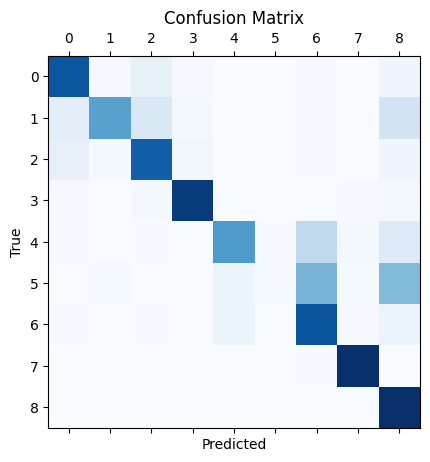

   overall_precision  overall_recall  overall_f1  overall_accuracy
0           0.795029        0.804178    0.799578          0.964402

                   LOC        MISC          ORG          PER
precision     0.795481    0.692797     0.699304     0.932564
recall        0.823141    0.465812     0.786875     0.949289
f1            0.809075    0.557070     0.740510     0.940852
number     1668.000000  702.000000  1661.000000  1617.000000

end of run
---------------------------------------------------
---------------------------------------------------
starting run on training set of 15%



Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['cl

{'eval_loss': 2.349132537841797, 'eval_precision': 0.022553352696047482, 'eval_recall': 0.15810906515580736, 'eval_f1': 0.03947572000088412, 'eval_accuracy': 0.039905243889307634, 'eval_runtime': 6.9785, 'eval_samples_per_second': 494.806, 'eval_steps_per_second': 7.738, 'epoch': 0.01}



  0%|          | 3/660 [00:14<1:00:41,  5.54s/it]

{'eval_loss': 2.345449209213257, 'eval_precision': 0.02252616675936694, 'eval_recall': 0.15775495750708216, 'eval_f1': 0.03942303437900978, 'eval_accuracy': 0.04052977280068914, 'eval_runtime': 6.9912, 'eval_samples_per_second': 493.904, 'eval_steps_per_second': 7.724, 'epoch': 0.02}



  1%|          | 4/660 [00:21<1:07:15,  6.15s/it]

{'eval_loss': 2.338127613067627, 'eval_precision': 0.0224519791191526, 'eval_recall': 0.15686968838526913, 'eval_f1': 0.039281755708268674, 'eval_accuracy': 0.04192957898137181, 'eval_runtime': 6.9989, 'eval_samples_per_second': 493.365, 'eval_steps_per_second': 7.716, 'epoch': 0.02}



  1%|          | 5/660 [00:28<1:11:10,  6.52s/it]

{'eval_loss': 2.327277898788452, 'eval_precision': 0.02229404728577609, 'eval_recall': 0.15509915014164305, 'eval_f1': 0.038984446274003694, 'eval_accuracy': 0.044341552708086575, 'eval_runtime': 7.071, 'eval_samples_per_second': 488.331, 'eval_steps_per_second': 7.637, 'epoch': 0.03}



  1%|          | 6/660 [00:35<1:13:16,  6.72s/it]

{'eval_loss': 2.3127338886260986, 'eval_precision': 0.022437127433673598, 'eval_recall': 0.15527620396600567, 'eval_f1': 0.03920867329831228, 'eval_accuracy': 0.0481317971357812, 'eval_runtime': 7.03, 'eval_samples_per_second': 491.184, 'eval_steps_per_second': 7.681, 'epoch': 0.04}



  1%|          | 7/660 [00:42<1:14:31,  6.85s/it]

{'eval_loss': 2.2946536540985107, 'eval_precision': 0.022342044838884446, 'eval_recall': 0.153328611898017, 'eval_f1': 0.03900110337994551, 'eval_accuracy': 0.05364487993970066, 'eval_runtime': 7.0272, 'eval_samples_per_second': 491.374, 'eval_steps_per_second': 7.684, 'epoch': 0.05}



  1%|          | 8/660 [00:50<1:15:48,  6.98s/it]

{'eval_loss': 2.2729012966156006, 'eval_precision': 0.0224285416232005, 'eval_recall': 0.15226628895184136, 'eval_f1': 0.039098017821422075, 'eval_accuracy': 0.06152686551092926, 'eval_runtime': 7.1519, 'eval_samples_per_second': 482.807, 'eval_steps_per_second': 7.55, 'epoch': 0.05}



  1%|▏         | 9/660 [00:57<1:16:13,  7.03s/it]

{'eval_loss': 2.247711181640625, 'eval_precision': 0.02251263194095394, 'eval_recall': 0.1506728045325779, 'eval_f1': 0.03917236300029921, 'eval_accuracy': 0.07212232152471196, 'eval_runtime': 7.0138, 'eval_samples_per_second': 492.316, 'eval_steps_per_second': 7.699, 'epoch': 0.06}



  2%|▏         | 10/660 [01:04<1:16:20,  7.05s/it]

{'eval_loss': 2.219287872314453, 'eval_precision': 0.022743848086221333, 'eval_recall': 0.14907932011331446, 'eval_f1': 0.039466591670768006, 'eval_accuracy': 0.08747711855281576, 'eval_runtime': 6.9979, 'eval_samples_per_second': 493.433, 'eval_steps_per_second': 7.717, 'epoch': 0.07}



  2%|▏         | 10/660 [01:11<1:16:20,  7.05s/it]

{'eval_loss': 2.1877338886260986, 'eval_precision': 0.02309578202485095, 'eval_recall': 0.14677762039660056, 'eval_f1': 0.039911414953540995, 'eval_accuracy': 0.1101539786798751, 'eval_runtime': 7.0192, 'eval_samples_per_second': 491.938, 'eval_steps_per_second': 7.693, 'epoch': 0.08}


  2%|▏         | 12/660 [01:19<1:18:25,  7.26s/it]

{'eval_loss': 2.152987241744995, 'eval_precision': 0.02342840512223516, 'eval_recall': 0.14252832861189801, 'eval_f1': 0.04024195160967807, 'eval_accuracy': 0.1421126305588457, 'eval_runtime': 7.0123, 'eval_samples_per_second': 492.422, 'eval_steps_per_second': 7.701, 'epoch': 0.08}



  2%|▏         | 13/660 [01:26<1:17:45,  7.21s/it]

{'eval_loss': 2.1150875091552734, 'eval_precision': 0.024438532450658912, 'eval_recall': 0.13987252124645894, 'eval_f1': 0.04160741560014747, 'eval_accuracy': 0.18742327985355875, 'eval_runtime': 6.9938, 'eval_samples_per_second': 493.723, 'eval_steps_per_second': 7.721, 'epoch': 0.09}



  2%|▏         | 14/660 [01:33<1:17:12,  7.17s/it]

{'eval_loss': 2.074275493621826, 'eval_precision': 0.025265011684221222, 'eval_recall': 0.13208215297450424, 'eval_f1': 0.04241648898365317, 'eval_accuracy': 0.24890707440508236, 'eval_runtime': 6.9868, 'eval_samples_per_second': 494.219, 'eval_steps_per_second': 7.729, 'epoch': 0.1}



  2%|▏         | 15/660 [01:40<1:16:57,  7.16s/it]

{'eval_loss': 2.0303611755371094, 'eval_precision': 0.024969456322541234, 'eval_recall': 0.11579320113314448, 'eval_f1': 0.04108040201005025, 'eval_accuracy': 0.3199526219446538, 'eval_runtime': 7.0334, 'eval_samples_per_second': 490.943, 'eval_steps_per_second': 7.678, 'epoch': 0.11}



  2%|▏         | 16/660 [01:47<1:17:01,  7.18s/it]

{'eval_loss': 1.983260154724121, 'eval_precision': 0.02614085519223859, 'eval_recall': 0.10304532577903683, 'eval_f1': 0.041702493551160784, 'eval_accuracy': 0.4036825670291806, 'eval_runtime': 7.0906, 'eval_samples_per_second': 486.986, 'eval_steps_per_second': 7.616, 'epoch': 0.11}



  3%|▎         | 17/660 [01:54<1:16:27,  7.13s/it]

{'eval_loss': 1.9332079887390137, 'eval_precision': 0.02579632122027815, 'eval_recall': 0.08144475920679886, 'eval_f1': 0.03918228279386712, 'eval_accuracy': 0.49400236890276733, 'eval_runtime': 6.9429, 'eval_samples_per_second': 497.342, 'eval_steps_per_second': 7.778, 'epoch': 0.12}



  3%|▎         | 18/660 [02:01<1:16:05,  7.11s/it]

{'eval_loss': 1.880509853363037, 'eval_precision': 0.026073850791258478, 'eval_recall': 0.061260623229461755, 'eval_f1': 0.036578919547520884, 'eval_accuracy': 0.583073112953591, 'eval_runtime': 6.939, 'eval_samples_per_second': 497.619, 'eval_steps_per_second': 7.782, 'epoch': 0.13}



  3%|▎         | 19/660 [02:09<1:15:46,  7.09s/it]

{'eval_loss': 1.8252992630004883, 'eval_precision': 0.02597964927473479, 'eval_recall': 0.042492917847025496, 'eval_f1': 0.03224506247480855, 'eval_accuracy': 0.6587057176698611, 'eval_runtime': 6.9476, 'eval_samples_per_second': 497.007, 'eval_steps_per_second': 7.772, 'epoch': 0.14}



  3%|▎         | 20/660 [02:16<1:15:23,  7.07s/it]

{'eval_loss': 1.7670848369598389, 'eval_precision': 0.02393755420641804, 'eval_recall': 0.02443342776203966, 'eval_f1': 0.02418294926837817, 'eval_accuracy': 0.7227522343060192, 'eval_runtime': 6.9161, 'eval_samples_per_second': 499.273, 'eval_steps_per_second': 7.808, 'epoch': 0.14}



  3%|▎         | 20/660 [02:22<1:15:23,  7.07s/it]

{'eval_loss': 1.7057949304580688, 'eval_precision': 0.023191094619666047, 'eval_recall': 0.013279036827195468, 'eval_f1': 0.016888088268408014, 'eval_accuracy': 0.7686228060730053, 'eval_runtime': 6.9059, 'eval_samples_per_second': 500.01, 'eval_steps_per_second': 7.819, 'epoch': 0.15}


  3%|▎         | 22/660 [02:30<1:16:51,  7.23s/it]

{'eval_loss': 1.6416518688201904, 'eval_precision': 0.020895522388059702, 'eval_recall': 0.006196883852691218, 'eval_f1': 0.009558923938276663, 'eval_accuracy': 0.795800581457952, 'eval_runtime': 6.9134, 'eval_samples_per_second': 499.466, 'eval_steps_per_second': 7.811, 'epoch': 0.16}



  3%|▎         | 23/660 [02:38<1:16:25,  7.20s/it]

{'eval_loss': 1.5740578174591064, 'eval_precision': 0.017654476670870115, 'eval_recall': 0.002478753541076487, 'eval_f1': 0.004347151063499457, 'eval_accuracy': 0.8116076235598148, 'eval_runtime': 7.022, 'eval_samples_per_second': 491.742, 'eval_steps_per_second': 7.69, 'epoch': 0.17}



  4%|▎         | 24/660 [02:45<1:15:36,  7.13s/it]

{'eval_loss': 1.5040980577468872, 'eval_precision': 0.006230529595015576, 'eval_recall': 0.0003541076487252125, 'eval_f1': 0.0006701289998324678, 'eval_accuracy': 0.8197264994077743, 'eval_runtime': 6.8931, 'eval_samples_per_second': 500.935, 'eval_steps_per_second': 7.834, 'epoch': 0.17}



  4%|▍         | 25/660 [02:52<1:15:01,  7.09s/it]

{'eval_loss': 1.4316788911819458, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8229137504037902, 'eval_runtime': 6.8939, 'eval_samples_per_second': 500.875, 'eval_steps_per_second': 7.833, 'epoch': 0.18}



  4%|▍         | 26/660 [02:59<1:14:43,  7.07s/it]

{'eval_loss': 1.3575427532196045, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8246150533003123, 'eval_runtime': 6.9153, 'eval_samples_per_second': 499.33, 'eval_steps_per_second': 7.809, 'epoch': 0.19}


/home/ronen/Documents/college/NNForNLP/workshop_1/.conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  4%|▍         | 27/660 [03:06<1:14:26,  7.06s/it]

{'eval_loss': 1.2828338146209717, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8251103693334769, 'eval_runtime': 6.9127, 'eval_samples_per_second': 499.519, 'eval_steps_per_second': 7.812, 'epoch': 0.2}



  4%|▍         | 28/660 [03:13<1:14:24,  7.06s/it]

{'eval_loss': 1.2085844278335571, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8252395822116938, 'eval_runtime': 6.9842, 'eval_samples_per_second': 494.404, 'eval_steps_per_second': 7.732, 'epoch': 0.2}



  4%|▍         | 29/660 [03:20<1:14:19,  7.07s/it]

{'eval_loss': 1.1354436874389648, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8252611176913965, 'eval_runtime': 6.974, 'eval_samples_per_second': 495.124, 'eval_steps_per_second': 7.743, 'epoch': 0.21}


/home/ronen/Documents/college/NNForNLP/workshop_1/.conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  5%|▍         | 30/660 [03:27<1:14:19,  7.08s/it]

{'eval_loss': 1.0650876760482788, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 7.0175, 'eval_samples_per_second': 492.059, 'eval_steps_per_second': 7.695, 'epoch': 0.22}



  5%|▍         | 30/660 [03:34<1:14:19,  7.08s/it]

{'eval_loss': 0.9992689490318298, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.8975, 'eval_samples_per_second': 500.619, 'eval_steps_per_second': 7.829, 'epoch': 0.23}


  5%|▍         | 31/660 [03:35<1:16:37,  7.31s/it]/home/ronen/Documents/college/NNForNLP/workshop_1/.conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ronen/Documents/college/NNForNLP/workshop_1/.conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  5%|▍         | 32/660 [03:42<1:15:28,  7.21s/it]

{'eval_loss': 0.9401621222496033, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.8912, 'eval_samples_per_second': 501.072, 'eval_steps_per_second': 7.836, 'epoch': 0.23}



  5%|▌         | 33/660 [03:49<1:14:41,  7.15s/it]

{'eval_loss': 0.8908281326293945, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.8998, 'eval_samples_per_second': 500.453, 'eval_steps_per_second': 7.826, 'epoch': 0.24}



  5%|▌         | 34/660 [03:56<1:14:07,  7.11s/it]

{'eval_loss': 0.85275799036026, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.8909, 'eval_samples_per_second': 501.099, 'eval_steps_per_second': 7.836, 'epoch': 0.25}



  5%|▌         | 35/660 [04:03<1:13:38,  7.07s/it]

{'eval_loss': 0.8282433748245239, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.8915, 'eval_samples_per_second': 501.051, 'eval_steps_per_second': 7.836, 'epoch': 0.26}



  5%|▌         | 36/660 [04:10<1:13:17,  7.05s/it]

{'eval_loss': 0.8169902563095093, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.901, 'eval_samples_per_second': 500.364, 'eval_steps_per_second': 7.825, 'epoch': 0.27}



  6%|▌         | 37/660 [04:17<1:13:26,  7.07s/it]

{'eval_loss': 0.8115067481994629, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 7.0387, 'eval_samples_per_second': 490.573, 'eval_steps_per_second': 7.672, 'epoch': 0.27}



  6%|▌         | 38/660 [04:24<1:13:10,  7.06s/it]

{'eval_loss': 0.8072711825370789, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.9183, 'eval_samples_per_second': 499.115, 'eval_steps_per_second': 7.805, 'epoch': 0.28}



  6%|▌         | 39/660 [04:31<1:13:02,  7.06s/it]

{'eval_loss': 0.7976316213607788, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.9373, 'eval_samples_per_second': 497.742, 'eval_steps_per_second': 7.784, 'epoch': 0.29}



  6%|▌         | 40/660 [04:38<1:12:54,  7.06s/it]

{'eval_loss': 0.7816033959388733, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.9291, 'eval_samples_per_second': 498.334, 'eval_steps_per_second': 7.793, 'epoch': 0.3}



  6%|▌         | 40/660 [04:45<1:12:54,  7.06s/it]

{'eval_loss': 0.7598134279251099, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.892, 'eval_samples_per_second': 501.015, 'eval_steps_per_second': 7.835, 'epoch': 0.3}


  6%|▌         | 41/660 [04:46<1:15:27,  7.31s/it]/home/ronen/Documents/college/NNForNLP/workshop_1/.conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ronen/Documents/college/NNForNLP/workshop_1/.conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  6%|▋         | 42/660 [04:53<1:14:29,  7.23s/it]

{'eval_loss': 0.7347291111946106, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.951, 'eval_samples_per_second': 496.763, 'eval_steps_per_second': 7.769, 'epoch': 0.31}



  7%|▋         | 43/660 [05:00<1:13:45,  7.17s/it]

{'eval_loss': 0.7099579572677612, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.9286, 'eval_samples_per_second': 498.367, 'eval_steps_per_second': 7.794, 'epoch': 0.32}



  7%|▋         | 44/660 [05:07<1:13:34,  7.17s/it]

{'eval_loss': 0.6864213943481445, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 7.0543, 'eval_samples_per_second': 489.492, 'eval_steps_per_second': 7.655, 'epoch': 0.33}



  7%|▋         | 45/660 [05:14<1:12:58,  7.12s/it]

{'eval_loss': 0.6650452613830566, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.9228, 'eval_samples_per_second': 498.788, 'eval_steps_per_second': 7.8, 'epoch': 0.33}



  7%|▋         | 46/660 [05:21<1:12:38,  7.10s/it]

{'eval_loss': 0.6442150473594666, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.9463, 'eval_samples_per_second': 497.099, 'eval_steps_per_second': 7.774, 'epoch': 0.34}



  7%|▋         | 47/660 [05:28<1:12:16,  7.07s/it]

{'eval_loss': 0.6251326203346252, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.9227, 'eval_samples_per_second': 498.791, 'eval_steps_per_second': 7.8, 'epoch': 0.35}



  7%|▋         | 48/660 [05:35<1:11:57,  7.06s/it]

{'eval_loss': 0.6072474718093872, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.8976, 'eval_samples_per_second': 500.606, 'eval_steps_per_second': 7.829, 'epoch': 0.36}



  7%|▋         | 49/660 [05:42<1:11:41,  7.04s/it]

{'eval_loss': 0.5902948975563049, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.8943, 'eval_samples_per_second': 500.85, 'eval_steps_per_second': 7.833, 'epoch': 0.36}



  8%|▊         | 50/660 [05:49<1:11:24,  7.02s/it]

{'eval_loss': 0.5727466344833374, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.8966, 'eval_samples_per_second': 500.681, 'eval_steps_per_second': 7.83, 'epoch': 0.37}



  8%|▊         | 50/660 [05:56<1:11:24,  7.02s/it]

{'eval_loss': 0.5547022223472595, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.825325724130505, 'eval_runtime': 6.8939, 'eval_samples_per_second': 500.881, 'eval_steps_per_second': 7.833, 'epoch': 0.38}


  8%|▊         | 51/660 [05:57<1:13:54,  7.28s/it]/home/ronen/Documents/college/NNForNLP/workshop_1/.conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  8%|▊         | 52/660 [06:04<1:13:17,  7.23s/it]

{'eval_loss': 0.5367388725280762, 'eval_precision': 0.4090909090909091, 'eval_recall': 0.001593484419263456, 'eval_f1': 0.0031746031746031746, 'eval_accuracy': 0.8257348982448584, 'eval_runtime': 7.0073, 'eval_samples_per_second': 492.771, 'eval_steps_per_second': 7.706, 'epoch': 0.39}



  8%|▊         | 53/660 [06:11<1:12:23,  7.16s/it]

{'eval_loss': 0.5201963186264038, 'eval_precision': 0.639751552795031, 'eval_recall': 0.01823654390934844, 'eval_f1': 0.03546221380616285, 'eval_accuracy': 0.8285345106062237, 'eval_runtime': 6.8836, 'eval_samples_per_second': 501.624, 'eval_steps_per_second': 7.845, 'epoch': 0.39}



  8%|▊         | 54/660 [06:18<1:11:53,  7.12s/it]

{'eval_loss': 0.5046059489250183, 'eval_precision': 0.5580808080808081, 'eval_recall': 0.039128895184135974, 'eval_f1': 0.07313037723362012, 'eval_accuracy': 0.8331646387423279, 'eval_runtime': 6.9177, 'eval_samples_per_second': 499.154, 'eval_steps_per_second': 7.806, 'epoch': 0.4}



  8%|▊         | 55/660 [06:25<1:11:31,  7.09s/it]

{'eval_loss': 0.48995545506477356, 'eval_precision': 0.47003154574132494, 'eval_recall': 0.05276203966005666, 'eval_f1': 0.09487424387137854, 'eval_accuracy': 0.8374501992031872, 'eval_runtime': 6.9297, 'eval_samples_per_second': 498.291, 'eval_steps_per_second': 7.793, 'epoch': 0.41}



  8%|▊         | 56/660 [06:32<1:11:21,  7.09s/it]

{'eval_loss': 0.4765702784061432, 'eval_precision': 0.40447154471544716, 'eval_recall': 0.07046742209631728, 'eval_f1': 0.12002412545235222, 'eval_accuracy': 0.843264778722946, 'eval_runtime': 6.9737, 'eval_samples_per_second': 495.148, 'eval_steps_per_second': 7.743, 'epoch': 0.42}



  9%|▊         | 57/660 [06:39<1:11:05,  7.07s/it]

{'eval_loss': 0.4644496738910675, 'eval_precision': 0.37986577181208053, 'eval_recall': 0.10021246458923513, 'eval_f1': 0.1585878397310171, 'eval_accuracy': 0.8510175514159578, 'eval_runtime': 6.9631, 'eval_samples_per_second': 495.9, 'eval_steps_per_second': 7.755, 'epoch': 0.42}



  9%|▉         | 58/660 [06:46<1:11:07,  7.09s/it]

{'eval_loss': 0.4524972140789032, 'eval_precision': 0.37366713027352805, 'eval_recall': 0.14270538243626063, 'eval_f1': 0.20653427290198592, 'eval_accuracy': 0.8603854850866803, 'eval_runtime': 7.0245, 'eval_samples_per_second': 491.564, 'eval_steps_per_second': 7.687, 'epoch': 0.43}



  9%|▉         | 59/660 [06:53<1:10:44,  7.06s/it]

{'eval_loss': 0.4407484233379364, 'eval_precision': 0.3798767967145791, 'eval_recall': 0.19652974504249293, 'eval_f1': 0.2590431738623104, 'eval_accuracy': 0.8707871217831378, 'eval_runtime': 6.8938, 'eval_samples_per_second': 500.881, 'eval_steps_per_second': 7.833, 'epoch': 0.44}



  9%|▉         | 60/660 [07:00<1:10:27,  7.05s/it]

{'eval_loss': 0.42928165197372437, 'eval_precision': 0.39193160566390595, 'eval_recall': 0.25973796033994334, 'eval_f1': 0.31242679160898734, 'eval_accuracy': 0.8812318294390008, 'eval_runtime': 6.9009, 'eval_samples_per_second': 500.369, 'eval_steps_per_second': 7.825, 'epoch': 0.45}



  9%|▉         | 60/660 [07:07<1:10:27,  7.05s/it]

{'eval_loss': 0.41768884658813477, 'eval_precision': 0.4098101265822785, 'eval_recall': 0.3209985835694051, 'eval_f1': 0.3600079428117553, 'eval_accuracy': 0.890858188866157, 'eval_runtime': 6.9045, 'eval_samples_per_second': 500.111, 'eval_steps_per_second': 7.821, 'epoch': 0.45}


  9%|▉         | 62/660 [07:15<1:12:00,  7.23s/it]

{'eval_loss': 0.4067760407924652, 'eval_precision': 0.42516529753556404, 'eval_recall': 0.3757082152974504, 'eval_f1': 0.39890967196165056, 'eval_accuracy': 0.8992139549908474, 'eval_runtime': 6.9797, 'eval_samples_per_second': 494.718, 'eval_steps_per_second': 7.737, 'epoch': 0.46}



 10%|▉         | 63/660 [07:23<1:12:09,  7.25s/it]

{'eval_loss': 0.39610305428504944, 'eval_precision': 0.429663330300273, 'eval_recall': 0.4180240793201133, 'eval_f1': 0.42376379790002694, 'eval_accuracy': 0.9048777861526865, 'eval_runtime': 7.1972, 'eval_samples_per_second': 479.77, 'eval_steps_per_second': 7.503, 'epoch': 0.47}



 10%|▉         | 64/660 [07:30<1:11:50,  7.23s/it]

{'eval_loss': 0.38589712977409363, 'eval_precision': 0.4401657744776377, 'eval_recall': 0.4513101983002833, 'eval_f1': 0.44566832765101844, 'eval_accuracy': 0.9097017336061161, 'eval_runtime': 7.0578, 'eval_samples_per_second': 489.249, 'eval_steps_per_second': 7.651, 'epoch': 0.48}



 10%|▉         | 65/660 [07:37<1:11:45,  7.24s/it]

{'eval_loss': 0.3761560916900635, 'eval_precision': 0.44383149448345033, 'eval_recall': 0.47007790368271957, 'eval_f1': 0.45657781599312125, 'eval_accuracy': 0.9126951652848068, 'eval_runtime': 7.1513, 'eval_samples_per_second': 482.847, 'eval_steps_per_second': 7.551, 'epoch': 0.48}



 10%|█         | 66/660 [07:44<1:11:17,  7.20s/it]

{'eval_loss': 0.3674802780151367, 'eval_precision': 0.44675324675324674, 'eval_recall': 0.48725212464589235, 'eval_f1': 0.46612466124661245, 'eval_accuracy': 0.9153009583288467, 'eval_runtime': 7.0033, 'eval_samples_per_second': 493.051, 'eval_steps_per_second': 7.711, 'epoch': 0.49}



 10%|█         | 67/660 [07:51<1:10:44,  7.16s/it]

{'eval_loss': 0.3595004677772522, 'eval_precision': 0.44792655903767015, 'eval_recall': 0.5010623229461756, 'eval_f1': 0.4730068527494568, 'eval_accuracy': 0.9170237967050716, 'eval_runtime': 6.9609, 'eval_samples_per_second': 496.056, 'eval_steps_per_second': 7.758, 'epoch': 0.5}



 10%|█         | 68/660 [07:58<1:10:24,  7.14s/it]

{'eval_loss': 0.3520588278770447, 'eval_precision': 0.4569807752915222, 'eval_recall': 0.5134560906515581, 'eval_f1': 0.48357512089378024, 'eval_accuracy': 0.919241951114461, 'eval_runtime': 6.9577, 'eval_samples_per_second': 496.281, 'eval_steps_per_second': 7.761, 'epoch': 0.51}



 10%|█         | 69/660 [08:05<1:10:00,  7.11s/it]

{'eval_loss': 0.3454883396625519, 'eval_precision': 0.4724596391263058, 'eval_recall': 0.5285056657223796, 'eval_f1': 0.4989135885007521, 'eval_accuracy': 0.9217400667599871, 'eval_runtime': 6.9501, 'eval_samples_per_second': 496.826, 'eval_steps_per_second': 7.77, 'epoch': 0.52}


/home/ronen/Documents/college/NNForNLP/workshop_1/.conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 11%|█         | 70/660 [08:13<1:09:54,  7.11s/it]

{'eval_loss': 0.33991482853889465, 'eval_precision': 0.49039530084140337, 'eval_recall': 0.5469192634560907, 'eval_f1': 0.5171172679333724, 'eval_accuracy': 0.924475072682244, 'eval_runtime': 7.0008, 'eval_samples_per_second': 493.229, 'eval_steps_per_second': 7.713, 'epoch': 0.52}



 11%|█         | 70/660 [08:20<1:09:54,  7.11s/it]

{'eval_loss': 0.33554700016975403, 'eval_precision': 0.5001600512163893, 'eval_recall': 0.5532932011331445, 'eval_f1': 0.5253866845998655, 'eval_accuracy': 0.9256595240658986, 'eval_runtime': 7.0181, 'eval_samples_per_second': 492.013, 'eval_steps_per_second': 7.694, 'epoch': 0.53}


 11%|█         | 72/660 [08:28<1:11:50,  7.33s/it]

{'eval_loss': 0.33035239577293396, 'eval_precision': 0.5140685640362225, 'eval_recall': 0.5628541076487252, 'eval_f1': 0.5373563218390804, 'eval_accuracy': 0.9272746850436093, 'eval_runtime': 7.0896, 'eval_samples_per_second': 487.052, 'eval_steps_per_second': 7.617, 'epoch': 0.54}



 11%|█         | 73/660 [08:35<1:10:51,  7.24s/it]

{'eval_loss': 0.3246248662471771, 'eval_precision': 0.5261024643320363, 'eval_recall': 0.5745396600566572, 'eval_f1': 0.5492552471225456, 'eval_accuracy': 0.9288683105416173, 'eval_runtime': 6.9369, 'eval_samples_per_second': 497.769, 'eval_steps_per_second': 7.784, 'epoch': 0.55}


/home/ronen/Documents/college/NNForNLP/workshop_1/.conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 11%|█         | 74/660 [08:42<1:10:08,  7.18s/it]

{'eval_loss': 0.317325621843338, 'eval_precision': 0.541293370255742, 'eval_recall': 0.5883498583569405, 'eval_f1': 0.5638415203189955, 'eval_accuracy': 0.9311295359104124, 'eval_runtime': 6.9277, 'eval_samples_per_second': 498.434, 'eval_steps_per_second': 7.795, 'epoch': 0.55}



 11%|█▏        | 75/660 [08:49<1:09:33,  7.13s/it]

{'eval_loss': 0.3097415566444397, 'eval_precision': 0.5585777486482058, 'eval_recall': 0.6035764872521246, 'eval_f1': 0.5802059399200068, 'eval_accuracy': 0.9334984386777215, 'eval_runtime': 6.9377, 'eval_samples_per_second': 497.714, 'eval_steps_per_second': 7.784, 'epoch': 0.56}



 12%|█▏        | 76/660 [08:56<1:09:02,  7.09s/it]

{'eval_loss': 0.3031671643257141, 'eval_precision': 0.5717358927684925, 'eval_recall': 0.6117209631728046, 'eval_f1': 0.5910529467111454, 'eval_accuracy': 0.9348336384192958, 'eval_runtime': 6.9295, 'eval_samples_per_second': 498.307, 'eval_steps_per_second': 7.793, 'epoch': 0.57}



 12%|█▏        | 77/660 [09:03<1:08:44,  7.07s/it]

{'eval_loss': 0.2950716018676758, 'eval_precision': 0.5797413793103449, 'eval_recall': 0.619157223796034, 'eval_f1': 0.5988013698630137, 'eval_accuracy': 0.9359965543232476, 'eval_runtime': 6.9429, 'eval_samples_per_second': 497.346, 'eval_steps_per_second': 7.778, 'epoch': 0.58}



 12%|█▏        | 78/660 [09:10<1:08:45,  7.09s/it]

{'eval_loss': 0.28646260499954224, 'eval_precision': 0.5868233736136401, 'eval_recall': 0.6276558073654391, 'eval_f1': 0.6065531696466764, 'eval_accuracy': 0.9375040379024443, 'eval_runtime': 7.0001, 'eval_samples_per_second': 493.279, 'eval_steps_per_second': 7.714, 'epoch': 0.58}



 12%|█▏        | 79/660 [09:17<1:08:58,  7.12s/it]

{'eval_loss': 0.27701690793037415, 'eval_precision': 0.5885143979057592, 'eval_recall': 0.6368626062322946, 'eval_f1': 0.6117346938775511, 'eval_accuracy': 0.9387100247658017, 'eval_runtime': 7.0966, 'eval_samples_per_second': 486.57, 'eval_steps_per_second': 7.609, 'epoch': 0.59}



 12%|█▏        | 80/660 [09:24<1:08:38,  7.10s/it]

{'eval_loss': 0.269065797328949, 'eval_precision': 0.5944715447154472, 'eval_recall': 0.6473087818696884, 'eval_f1': 0.6197660620444143, 'eval_accuracy': 0.9400021535479702, 'eval_runtime': 6.934, 'eval_samples_per_second': 497.983, 'eval_steps_per_second': 7.788, 'epoch': 0.6}



 12%|█▏        | 80/660 [09:31<1:08:38,  7.10s/it]

{'eval_loss': 0.2616778016090393, 'eval_precision': 0.5947300355641771, 'eval_recall': 0.6513810198300283, 'eval_f1': 0.6217677877302688, 'eval_accuracy': 0.9400452245073759, 'eval_runtime': 6.928, 'eval_samples_per_second': 498.411, 'eval_steps_per_second': 7.794, 'epoch': 0.61}


 12%|█▏        | 82/660 [09:39<1:09:51,  7.25s/it]

{'eval_loss': 0.25612619519233704, 'eval_precision': 0.5915583373455304, 'eval_recall': 0.6526203966005666, 'eval_f1': 0.6205909588349188, 'eval_accuracy': 0.9386669538063961, 'eval_runtime': 6.9282, 'eval_samples_per_second': 498.395, 'eval_steps_per_second': 7.794, 'epoch': 0.61}



 13%|█▎        | 83/660 [09:46<1:09:10,  7.19s/it]

{'eval_loss': 0.25273847579956055, 'eval_precision': 0.5926454271675384, 'eval_recall': 0.6620042492917847, 'eval_f1': 0.6254077109642887, 'eval_accuracy': 0.9381501022935286, 'eval_runtime': 6.931, 'eval_samples_per_second': 498.194, 'eval_steps_per_second': 7.791, 'epoch': 0.62}



 13%|█▎        | 84/660 [09:53<1:08:35,  7.14s/it]

{'eval_loss': 0.24933969974517822, 'eval_precision': 0.5993036872922931, 'eval_recall': 0.6705028328611898, 'eval_f1': 0.6329071613604078, 'eval_accuracy': 0.938322386131151, 'eval_runtime': 6.9437, 'eval_samples_per_second': 497.286, 'eval_steps_per_second': 7.777, 'epoch': 0.63}



 13%|█▎        | 85/660 [10:00<1:08:10,  7.11s/it]

{'eval_loss': 0.2438504844903946, 'eval_precision': 0.610199203187251, 'eval_recall': 0.6779390934844193, 'eval_f1': 0.6422880147613855, 'eval_accuracy': 0.9392053407989663, 'eval_runtime': 6.9592, 'eval_samples_per_second': 496.178, 'eval_steps_per_second': 7.76, 'epoch': 0.64}



 13%|█▎        | 86/660 [10:08<1:08:17,  7.14s/it]

{'eval_loss': 0.23898398876190186, 'eval_precision': 0.6248994691973621, 'eval_recall': 0.6878541076487252, 'eval_f1': 0.6548672566371682, 'eval_accuracy': 0.9409281791751911, 'eval_runtime': 7.0853, 'eval_samples_per_second': 487.346, 'eval_steps_per_second': 7.621, 'epoch': 0.64}



 13%|█▎        | 87/660 [10:15<1:07:58,  7.12s/it]

{'eval_loss': 0.23547638952732086, 'eval_precision': 0.6312378483473753, 'eval_recall': 0.6898016997167139, 'eval_f1': 0.6592216582064299, 'eval_accuracy': 0.9414450306880586, 'eval_runtime': 6.9579, 'eval_samples_per_second': 496.274, 'eval_steps_per_second': 7.761, 'epoch': 0.65}



 13%|█▎        | 88/660 [10:22<1:07:43,  7.10s/it]

{'eval_loss': 0.23343226313591003, 'eval_precision': 0.632613599742185, 'eval_recall': 0.6951133144475921, 'eval_f1': 0.6623924413700017, 'eval_accuracy': 0.9418111338430063, 'eval_runtime': 6.9676, 'eval_samples_per_second': 495.581, 'eval_steps_per_second': 7.75, 'epoch': 0.66}



 13%|█▎        | 89/660 [10:29<1:07:29,  7.09s/it]

{'eval_loss': 0.2318994253873825, 'eval_precision': 0.6284938508225523, 'eval_recall': 0.6967067988668555, 'eval_f1': 0.6608447392728188, 'eval_accuracy': 0.9417034564444923, 'eval_runtime': 6.9571, 'eval_samples_per_second': 496.325, 'eval_steps_per_second': 7.762, 'epoch': 0.67}



 14%|█▎        | 90/660 [10:36<1:07:18,  7.09s/it]

{'eval_loss': 0.22988750040531158, 'eval_precision': 0.6238677896075004, 'eval_recall': 0.6951133144475921, 'eval_f1': 0.6575663679758814, 'eval_accuracy': 0.9415742435662754, 'eval_runtime': 6.9757, 'eval_samples_per_second': 495.006, 'eval_steps_per_second': 7.741, 'epoch': 0.67}



 14%|█▎        | 90/660 [10:43<1:07:18,  7.09s/it]

{'eval_loss': 0.2285018414258957, 'eval_precision': 0.6218606855157163, 'eval_recall': 0.6970609065155807, 'eval_f1': 0.6573169713665581, 'eval_accuracy': 0.9417895983633036, 'eval_runtime': 6.9688, 'eval_samples_per_second': 495.492, 'eval_steps_per_second': 7.749, 'epoch': 0.68}


 14%|█▍        | 92/660 [10:51<1:08:46,  7.27s/it]

{'eval_loss': 0.2258085459470749, 'eval_precision': 0.6242710795902285, 'eval_recall': 0.7013101983002833, 'eval_f1': 0.6605519886600517, 'eval_accuracy': 0.9426079465920103, 'eval_runtime': 6.9623, 'eval_samples_per_second': 495.96, 'eval_steps_per_second': 7.756, 'epoch': 0.69}



 14%|█▍        | 93/660 [10:58<1:08:24,  7.24s/it]

{'eval_loss': 0.22144386172294617, 'eval_precision': 0.6293894337235052, 'eval_recall': 0.7044971671388102, 'eval_f1': 0.6648287385129491, 'eval_accuracy': 0.9442877140088295, 'eval_runtime': 7.0813, 'eval_samples_per_second': 487.621, 'eval_steps_per_second': 7.626, 'epoch': 0.7}



 14%|█▍        | 94/660 [11:05<1:07:43,  7.18s/it]

{'eval_loss': 0.21459372341632843, 'eval_precision': 0.6434629540726516, 'eval_recall': 0.7119334277620396, 'eval_f1': 0.6759687316130116, 'eval_accuracy': 0.9469796489716809, 'eval_runtime': 6.9574, 'eval_samples_per_second': 496.303, 'eval_steps_per_second': 7.761, 'epoch': 0.7}



 14%|█▍        | 95/660 [11:12<1:07:15,  7.14s/it]

{'eval_loss': 0.20991812646389008, 'eval_precision': 0.6546073977936405, 'eval_recall': 0.7144121813031161, 'eval_f1': 0.6832035218421945, 'eval_accuracy': 0.9486378809087972, 'eval_runtime': 6.9447, 'eval_samples_per_second': 497.217, 'eval_steps_per_second': 7.776, 'epoch': 0.71}



 15%|█▍        | 96/660 [11:19<1:06:45,  7.10s/it]

{'eval_loss': 0.20732811093330383, 'eval_precision': 0.6613747954173486, 'eval_recall': 0.7154745042492918, 'eval_f1': 0.6873617962238476, 'eval_accuracy': 0.9495208355766125, 'eval_runtime': 6.9133, 'eval_samples_per_second': 499.473, 'eval_steps_per_second': 7.811, 'epoch': 0.72}



 15%|█▍        | 97/660 [11:26<1:06:32,  7.09s/it]

{'eval_loss': 0.20496822893619537, 'eval_precision': 0.668922264400066, 'eval_recall': 0.7175991501416431, 'eval_f1': 0.6924062526693432, 'eval_accuracy': 0.9505114676429417, 'eval_runtime': 6.928, 'eval_samples_per_second': 498.415, 'eval_steps_per_second': 7.794, 'epoch': 0.73}



 15%|█▍        | 98/660 [11:33<1:06:14,  7.07s/it]

{'eval_loss': 0.20246851444244385, 'eval_precision': 0.6737541528239203, 'eval_recall': 0.7181303116147308, 'eval_f1': 0.6952348303051079, 'eval_accuracy': 0.9508991062775923, 'eval_runtime': 6.9418, 'eval_samples_per_second': 497.42, 'eval_steps_per_second': 7.779, 'epoch': 0.73}



 15%|█▌        | 99/660 [11:40<1:06:02,  7.06s/it]

{'eval_loss': 0.20039214193820953, 'eval_precision': 0.6822977725674091, 'eval_recall': 0.7213172804532578, 'eval_f1': 0.7012651691195456, 'eval_accuracy': 0.9516528480671907, 'eval_runtime': 6.9294, 'eval_samples_per_second': 498.309, 'eval_steps_per_second': 7.793, 'epoch': 0.74}



 15%|█▌        | 100/660 [11:47<1:06:07,  7.09s/it]

{'eval_loss': 0.19777952134609222, 'eval_precision': 0.6882461745417858, 'eval_recall': 0.7246813031161473, 'eval_f1': 0.7059939629150497, 'eval_accuracy': 0.9521696995800581, 'eval_runtime': 7.0339, 'eval_samples_per_second': 490.907, 'eval_steps_per_second': 7.677, 'epoch': 0.75}



 15%|█▌        | 100/660 [11:54<1:06:07,  7.09s/it]

{'eval_loss': 0.19497241079807281, 'eval_precision': 0.6950210970464135, 'eval_recall': 0.7291076487252125, 'eval_f1': 0.7116564417177915, 'eval_accuracy': 0.9527296220523312, 'eval_runtime': 6.9133, 'eval_samples_per_second': 499.474, 'eval_steps_per_second': 7.811, 'epoch': 0.76}


 15%|█▌        | 102/660 [12:02<1:07:20,  7.24s/it]

{'eval_loss': 0.1913164258003235, 'eval_precision': 0.7013337835556306, 'eval_recall': 0.7354815864022662, 'eval_f1': 0.7180019013049865, 'eval_accuracy': 0.953440292882524, 'eval_runtime': 6.9111, 'eval_samples_per_second': 499.633, 'eval_steps_per_second': 7.814, 'epoch': 0.77}



 16%|█▌        | 103/660 [12:09<1:06:41,  7.18s/it]

{'eval_loss': 0.1884128600358963, 'eval_precision': 0.7039351460901875, 'eval_recall': 0.7379603399433428, 'eval_f1': 0.7205462874924367, 'eval_accuracy': 0.9537848605577689, 'eval_runtime': 6.9335, 'eval_samples_per_second': 498.02, 'eval_steps_per_second': 7.788, 'epoch': 0.77}



 16%|█▌        | 104/660 [12:16<1:06:06,  7.13s/it]

{'eval_loss': 0.18574894964694977, 'eval_precision': 0.7068965517241379, 'eval_recall': 0.7404390934844193, 'eval_f1': 0.7232791421653407, 'eval_accuracy': 0.9540217508344998, 'eval_runtime': 6.9056, 'eval_samples_per_second': 500.031, 'eval_steps_per_second': 7.82, 'epoch': 0.78}



 16%|█▌        | 105/660 [12:23<1:05:44,  7.11s/it]

{'eval_loss': 0.18280263245105743, 'eval_precision': 0.7119647994584533, 'eval_recall': 0.7448654390934845, 'eval_f1': 0.7280436099333738, 'eval_accuracy': 0.9546678152255842, 'eval_runtime': 6.9319, 'eval_samples_per_second': 498.13, 'eval_steps_per_second': 7.79, 'epoch': 0.79}



 16%|█▌        | 106/660 [12:31<1:05:20,  7.08s/it]

{'eval_loss': 0.18001985549926758, 'eval_precision': 0.7197690217391305, 'eval_recall': 0.7503541076487252, 'eval_f1': 0.7347434119278781, 'eval_accuracy': 0.9556153763325078, 'eval_runtime': 6.9209, 'eval_samples_per_second': 498.923, 'eval_steps_per_second': 7.802, 'epoch': 0.8}



 16%|█▌        | 107/660 [12:38<1:05:26,  7.10s/it]

{'eval_loss': 0.17679771780967712, 'eval_precision': 0.7267006802721089, 'eval_recall': 0.7565509915014165, 'eval_f1': 0.7413254684247051, 'eval_accuracy': 0.9566275438785399, 'eval_runtime': 7.0412, 'eval_samples_per_second': 490.401, 'eval_steps_per_second': 7.669, 'epoch': 0.8}



 16%|█▋        | 108/660 [12:45<1:05:10,  7.08s/it]

{'eval_loss': 0.17374484241008759, 'eval_precision': 0.7341534255937127, 'eval_recall': 0.7608002832861189, 'eval_f1': 0.7472393704895226, 'eval_accuracy': 0.9572305373102186, 'eval_runtime': 6.9384, 'eval_samples_per_second': 497.667, 'eval_steps_per_second': 7.783, 'epoch': 0.81}



 17%|█▋        | 109/660 [12:52<1:04:52,  7.06s/it]

{'eval_loss': 0.17094871401786804, 'eval_precision': 0.7367071294238331, 'eval_recall': 0.7629249291784702, 'eval_f1': 0.7495868487431504, 'eval_accuracy': 0.9577473888230861, 'eval_runtime': 6.9257, 'eval_samples_per_second': 498.577, 'eval_steps_per_second': 7.797, 'epoch': 0.82}



 17%|█▋        | 110/660 [12:59<1:04:43,  7.06s/it]

{'eval_loss': 0.16834868490695953, 'eval_precision': 0.7419023136246786, 'eval_recall': 0.7664660056657224, 'eval_f1': 0.7539841504833231, 'eval_accuracy': 0.9584149886938732, 'eval_runtime': 6.9541, 'eval_samples_per_second': 496.539, 'eval_steps_per_second': 7.765, 'epoch': 0.83}



 17%|█▋        | 110/660 [13:06<1:04:43,  7.06s/it]

{'eval_loss': 0.16606023907661438, 'eval_precision': 0.7449260405916752, 'eval_recall': 0.7668201133144475, 'eval_f1': 0.7557145349851683, 'eval_accuracy': 0.958781091848821, 'eval_runtime': 6.9614, 'eval_samples_per_second': 496.023, 'eval_steps_per_second': 7.757, 'epoch': 0.83}


 17%|█▋        | 112/660 [13:14<1:06:16,  7.26s/it]

{'eval_loss': 0.16397595405578613, 'eval_precision': 0.7483682583304706, 'eval_recall': 0.7714235127478754, 'eval_f1': 0.7597210113339145, 'eval_accuracy': 0.9595132981587164, 'eval_runtime': 6.9906, 'eval_samples_per_second': 493.947, 'eval_steps_per_second': 7.725, 'epoch': 0.84}



 17%|█▋        | 113/660 [13:21<1:05:34,  7.19s/it]

{'eval_loss': 0.16180412471294403, 'eval_precision': 0.7493571061203498, 'eval_recall': 0.7739022662889519, 'eval_f1': 0.761431931016462, 'eval_accuracy': 0.9599440077527727, 'eval_runtime': 6.9476, 'eval_samples_per_second': 497.006, 'eval_steps_per_second': 7.772, 'epoch': 0.85}



 17%|█▋        | 114/660 [13:28<1:05:32,  7.20s/it]

{'eval_loss': 0.1601545810699463, 'eval_precision': 0.7503422313483915, 'eval_recall': 0.7763810198300283, 'eval_f1': 0.7631395753567698, 'eval_accuracy': 0.960590072143857, 'eval_runtime': 7.1199, 'eval_samples_per_second': 484.981, 'eval_steps_per_second': 7.584, 'epoch': 0.86}



 17%|█▋        | 115/660 [13:35<1:05:05,  7.17s/it]

{'eval_loss': 0.15836280584335327, 'eval_precision': 0.7493601774441222, 'eval_recall': 0.7776203966005666, 'eval_f1': 0.7632287774784952, 'eval_accuracy': 0.9608700333799935, 'eval_runtime': 6.9834, 'eval_samples_per_second': 494.46, 'eval_steps_per_second': 7.733, 'epoch': 0.86}



 18%|█▊        | 116/660 [13:42<1:04:45,  7.14s/it]

{'eval_loss': 0.15689460933208466, 'eval_precision': 0.7477079796264856, 'eval_recall': 0.7797450424929179, 'eval_f1': 0.7633905356214248, 'eval_accuracy': 0.9611284591364273, 'eval_runtime': 6.9821, 'eval_samples_per_second': 494.552, 'eval_steps_per_second': 7.734, 'epoch': 0.87}



 18%|█▊        | 117/660 [13:49<1:04:32,  7.13s/it]

{'eval_loss': 0.15535318851470947, 'eval_precision': 0.7434731345797541, 'eval_recall': 0.7815155807365439, 'eval_f1': 0.762019853258524, 'eval_accuracy': 0.9610853881770216, 'eval_runtime': 7.0129, 'eval_samples_per_second': 492.377, 'eval_steps_per_second': 7.7, 'epoch': 0.88}



 18%|█▊        | 118/660 [13:57<1:05:11,  7.22s/it]

{'eval_loss': 0.15420860052108765, 'eval_precision': 0.7395379979912956, 'eval_recall': 0.7822237960339944, 'eval_f1': 0.7602822233694717, 'eval_accuracy': 0.9609777107785076, 'eval_runtime': 7.3059, 'eval_samples_per_second': 472.633, 'eval_steps_per_second': 7.391, 'epoch': 0.89}



 18%|█▊        | 119/660 [14:05<1:07:57,  7.54s/it]

{'eval_loss': 0.15327583253383636, 'eval_precision': 0.7388333333333333, 'eval_recall': 0.7848796033994334, 'eval_f1': 0.7611607142857143, 'eval_accuracy': 0.9610853881770216, 'eval_runtime': 8.1744, 'eval_samples_per_second': 422.416, 'eval_steps_per_second': 6.606, 'epoch': 0.89}



 18%|█▊        | 120/660 [14:13<1:09:50,  7.76s/it]

{'eval_loss': 0.15256939828395844, 'eval_precision': 0.7392244965884507, 'eval_recall': 0.7864730878186968, 'eval_f1': 0.7621171828086128, 'eval_accuracy': 0.9612792074943469, 'eval_runtime': 8.1497, 'eval_samples_per_second': 423.695, 'eval_steps_per_second': 6.626, 'epoch': 0.9}



 18%|█▊        | 120/660 [14:22<1:09:50,  7.76s/it]

{'eval_loss': 0.15160484611988068, 'eval_precision': 0.7426384960905007, 'eval_recall': 0.7903682719546742, 'eval_f1': 0.765760356805901, 'eval_accuracy': 0.9616237751695919, 'eval_runtime': 8.4265, 'eval_samples_per_second': 409.78, 'eval_steps_per_second': 6.408, 'epoch': 0.91}


 18%|█▊        | 122/660 [14:31<1:13:49,  8.23s/it]

{'eval_loss': 0.1507340669631958, 'eval_precision': 0.7421978751660027, 'eval_recall': 0.7916076487252125, 'eval_f1': 0.7661069225496916, 'eval_accuracy': 0.9614945622913751, 'eval_runtime': 7.7829, 'eval_samples_per_second': 443.667, 'eval_steps_per_second': 6.938, 'epoch': 0.92}



 19%|█▊        | 123/660 [14:39<1:13:29,  8.21s/it]

{'eval_loss': 0.15109653770923615, 'eval_precision': 0.7404781533388294, 'eval_recall': 0.7951487252124646, 'eval_f1': 0.7668402629556902, 'eval_accuracy': 0.9616237751695919, 'eval_runtime': 8.038, 'eval_samples_per_second': 429.585, 'eval_steps_per_second': 6.718, 'epoch': 0.92}



 19%|█▉        | 124/660 [14:47<1:12:17,  8.09s/it]

{'eval_loss': 0.1510513573884964, 'eval_precision': 0.7421156373193167, 'eval_recall': 0.7999291784702549, 'eval_f1': 0.7699386503067485, 'eval_accuracy': 0.9619683428448369, 'eval_runtime': 7.7101, 'eval_samples_per_second': 447.853, 'eval_steps_per_second': 7.004, 'epoch': 0.93}



 19%|█▉        | 125/660 [14:55<1:11:40,  8.04s/it]

{'eval_loss': 0.14976751804351807, 'eval_precision': 0.7491765480895916, 'eval_recall': 0.8054178470254958, 'eval_f1': 0.7762798634812287, 'eval_accuracy': 0.9627005491547325, 'eval_runtime': 7.8197, 'eval_samples_per_second': 441.576, 'eval_steps_per_second': 6.906, 'epoch': 0.94}



 19%|█▉        | 126/660 [15:03<1:11:26,  8.03s/it]

{'eval_loss': 0.14916850626468658, 'eval_precision': 0.7539094650205761, 'eval_recall': 0.8109065155807366, 'eval_f1': 0.7813699564957776, 'eval_accuracy': 0.9631312587487886, 'eval_runtime': 7.9036, 'eval_samples_per_second': 436.889, 'eval_steps_per_second': 6.832, 'epoch': 0.95}



 19%|█▉        | 127/660 [15:11<1:11:16,  8.02s/it]

{'eval_loss': 0.14872460067272186, 'eval_precision': 0.756872427983539, 'eval_recall': 0.8140934844192634, 'eval_f1': 0.7844408427876823, 'eval_accuracy': 0.9633681490255196, 'eval_runtime': 7.9138, 'eval_samples_per_second': 436.327, 'eval_steps_per_second': 6.824, 'epoch': 0.95}



 19%|█▉        | 128/660 [15:19<1:11:31,  8.07s/it]

{'eval_loss': 0.14830471575260162, 'eval_precision': 0.7607513593672763, 'eval_recall': 0.8174575070821529, 'eval_f1': 0.788085687462661, 'eval_accuracy': 0.9636696457413589, 'eval_runtime': 8.0669, 'eval_samples_per_second': 428.044, 'eval_steps_per_second': 6.694, 'epoch': 0.96}



 20%|█▉        | 129/660 [15:27<1:11:19,  8.06s/it]

{'eval_loss': 0.14657562971115112, 'eval_precision': 0.766489890619821, 'eval_recall': 0.8188739376770539, 'eval_f1': 0.7918164697825715, 'eval_accuracy': 0.9639280714977926, 'eval_runtime': 7.9334, 'eval_samples_per_second': 435.25, 'eval_steps_per_second': 6.807, 'epoch': 0.97}



 20%|█▉        | 130/660 [15:35<1:11:14,  8.06s/it]

{'eval_loss': 0.1442994326353073, 'eval_precision': 0.7753016085790885, 'eval_recall': 0.8192280453257791, 'eval_f1': 0.7966597796143251, 'eval_accuracy': 0.9647248842467966, 'eval_runtime': 7.9685, 'eval_samples_per_second': 433.332, 'eval_steps_per_second': 6.777, 'epoch': 0.98}



 20%|█▉        | 130/660 [15:43<1:11:14,  8.06s/it]

{'eval_loss': 0.14161136746406555, 'eval_precision': 0.7847564080801223, 'eval_recall': 0.8185198300283286, 'eval_f1': 0.8012826068116821, 'eval_accuracy': 0.9653278776784753, 'eval_runtime': 7.9039, 'eval_samples_per_second': 436.872, 'eval_steps_per_second': 6.832, 'epoch': 0.98}


 20%|██        | 132/660 [15:52<1:12:45,  8.27s/it]

{'eval_loss': 0.13977237045764923, 'eval_precision': 0.7934465603019386, 'eval_recall': 0.8188739376770539, 'eval_f1': 0.8059597455781128, 'eval_accuracy': 0.9658016582319371, 'eval_runtime': 7.8855, 'eval_samples_per_second': 437.893, 'eval_steps_per_second': 6.848, 'epoch': 0.99}



 20%|██        | 133/660 [16:00<1:11:51,  8.18s/it]

{'eval_loss': 0.1386679857969284, 'eval_precision': 0.7992037389648606, 'eval_recall': 0.8174575070821529, 'eval_f1': 0.8082275711159737, 'eval_accuracy': 0.9659739420695596, 'eval_runtime': 7.8909, 'eval_samples_per_second': 437.593, 'eval_steps_per_second': 6.843, 'epoch': 1.0}



 20%|██        | 134/660 [16:08<1:11:11,  8.12s/it]

{'eval_loss': 0.13750788569450378, 'eval_precision': 0.806429070580014, 'eval_recall': 0.8172804532577904, 'eval_f1': 0.811818501582835, 'eval_accuracy': 0.9662969742651017, 'eval_runtime': 7.8699, 'eval_samples_per_second': 438.762, 'eval_steps_per_second': 6.862, 'epoch': 1.01}



 20%|██        | 135/660 [16:17<1:11:18,  8.15s/it]

{'eval_loss': 0.13660882413387299, 'eval_precision': 0.810159957813324, 'eval_recall': 0.8160410764872521, 'eval_f1': 0.8130898826850136, 'eval_accuracy': 0.9665338645418327, 'eval_runtime': 8.0969, 'eval_samples_per_second': 426.457, 'eval_steps_per_second': 6.669, 'epoch': 1.02}



 21%|██        | 136/660 [16:25<1:10:46,  8.10s/it]

{'eval_loss': 0.13578914105892181, 'eval_precision': 0.8157105030891438, 'eval_recall': 0.8181657223796034, 'eval_f1': 0.8169362680102538, 'eval_accuracy': 0.9668784322170776, 'eval_runtime': 7.8878, 'eval_samples_per_second': 437.762, 'eval_steps_per_second': 6.846, 'epoch': 1.02}



 21%|██        | 137/660 [16:33<1:10:28,  8.09s/it]

{'eval_loss': 0.1352982074022293, 'eval_precision': 0.8187124159886806, 'eval_recall': 0.8195821529745042, 'eval_f1': 0.8191470536188286, 'eval_accuracy': 0.9671583934532142, 'eval_runtime': 7.9282, 'eval_samples_per_second': 435.532, 'eval_steps_per_second': 6.811, 'epoch': 1.03}



 21%|██        | 138/660 [16:41<1:10:04,  8.06s/it]

{'eval_loss': 0.1347474902868271, 'eval_precision': 0.8210693488618317, 'eval_recall': 0.8238314447592068, 'eval_f1': 0.8224480777728679, 'eval_accuracy': 0.9675029611284591, 'eval_runtime': 7.8738, 'eval_samples_per_second': 438.543, 'eval_steps_per_second': 6.858, 'epoch': 1.04}



 21%|██        | 139/660 [16:49<1:10:00,  8.06s/it]

{'eval_loss': 0.13431809842586517, 'eval_precision': 0.8188202247191011, 'eval_recall': 0.8257790368271954, 'eval_f1': 0.8222849083215797, 'eval_accuracy': 0.9673737482502422, 'eval_runtime': 7.9633, 'eval_samples_per_second': 433.612, 'eval_steps_per_second': 6.781, 'epoch': 1.05}



 21%|██        | 140/660 [16:57<1:09:52,  8.06s/it]

{'eval_loss': 0.13443322479724884, 'eval_precision': 0.8150541390150192, 'eval_recall': 0.8263101983002833, 'eval_f1': 0.8206435730613679, 'eval_accuracy': 0.9672445353720254, 'eval_runtime': 7.9456, 'eval_samples_per_second': 434.579, 'eval_steps_per_second': 6.796, 'epoch': 1.05}



 21%|██        | 140/660 [17:05<1:09:52,  8.06s/it]

{'eval_loss': 0.1338665932416916, 'eval_precision': 0.8157620041753654, 'eval_recall': 0.8302053824362606, 'eval_f1': 0.8229203229203229, 'eval_accuracy': 0.9674814256487563, 'eval_runtime': 8.1116, 'eval_samples_per_second': 425.687, 'eval_steps_per_second': 6.657, 'epoch': 1.06}


 22%|██▏       | 142/660 [17:14<1:11:59,  8.34s/it]

{'eval_loss': 0.1326761543750763, 'eval_precision': 0.8151362610657872, 'eval_recall': 0.8314447592067988, 'eval_f1': 0.8232097466912085, 'eval_accuracy': 0.9676967804457844, 'eval_runtime': 7.9481, 'eval_samples_per_second': 434.442, 'eval_steps_per_second': 6.794, 'epoch': 1.07}



 22%|██▏       | 143/660 [17:22<1:10:47,  8.22s/it]

{'eval_loss': 0.13138508796691895, 'eval_precision': 0.8182608695652174, 'eval_recall': 0.8330382436260623, 'eval_f1': 0.825583435690472, 'eval_accuracy': 0.9678044578442985, 'eval_runtime': 7.8098, 'eval_samples_per_second': 442.138, 'eval_steps_per_second': 6.914, 'epoch': 1.08}



 22%|██▏       | 144/660 [17:30<1:10:05,  8.15s/it]

{'eval_loss': 0.129860520362854, 'eval_precision': 0.8181502689571404, 'eval_recall': 0.8348087818696884, 'eval_f1': 0.8263955832091842, 'eval_accuracy': 0.9680198126413266, 'eval_runtime': 7.8928, 'eval_samples_per_second': 437.487, 'eval_steps_per_second': 6.842, 'epoch': 1.08}



 22%|██▏       | 145/660 [17:38<1:09:39,  8.12s/it]

{'eval_loss': 0.12876635789871216, 'eval_precision': 0.8215464813205908, 'eval_recall': 0.8371104815864022, 'eval_f1': 0.8292554590897132, 'eval_accuracy': 0.968321309357166, 'eval_runtime': 7.9351, 'eval_samples_per_second': 435.155, 'eval_steps_per_second': 6.805, 'epoch': 1.09}



 22%|██▏       | 146/660 [17:46<1:09:28,  8.11s/it]

{'eval_loss': 0.127794548869133, 'eval_precision': 0.8220368439346541, 'eval_recall': 0.8374645892351275, 'eval_f1': 0.8296790036835644, 'eval_accuracy': 0.968536664154194, 'eval_runtime': 7.9927, 'eval_samples_per_second': 432.02, 'eval_steps_per_second': 6.756, 'epoch': 1.1}



 22%|██▏       | 147/660 [17:54<1:09:16,  8.10s/it]

{'eval_loss': 0.12721124291419983, 'eval_precision': 0.8217821782178217, 'eval_recall': 0.8376416430594901, 'eval_f1': 0.8296361245067951, 'eval_accuracy': 0.9686012705933025, 'eval_runtime': 7.9676, 'eval_samples_per_second': 433.382, 'eval_steps_per_second': 6.777, 'epoch': 1.11}



 22%|██▏       | 148/660 [18:02<1:09:02,  8.09s/it]

{'eval_loss': 0.126778244972229, 'eval_precision': 0.8200069228106611, 'eval_recall': 0.8388810198300283, 'eval_f1': 0.8293366007351654, 'eval_accuracy': 0.9687304834715194, 'eval_runtime': 7.9612, 'eval_samples_per_second': 433.73, 'eval_steps_per_second': 6.783, 'epoch': 1.11}



 23%|██▎       | 149/660 [18:11<1:09:19,  8.14s/it]

{'eval_loss': 0.12620842456817627, 'eval_precision': 0.8204329004329004, 'eval_recall': 0.8388810198300283, 'eval_f1': 0.8295544077737897, 'eval_accuracy': 0.9687950899106278, 'eval_runtime': 8.1555, 'eval_samples_per_second': 423.394, 'eval_steps_per_second': 6.621, 'epoch': 1.12}



 23%|██▎       | 150/660 [18:19<1:09:01,  8.12s/it]

{'eval_loss': 0.12606321275234222, 'eval_precision': 0.8175069060773481, 'eval_recall': 0.8383498583569405, 'eval_f1': 0.8277972027972028, 'eval_accuracy': 0.9686228060730053, 'eval_runtime': 7.9726, 'eval_samples_per_second': 433.109, 'eval_steps_per_second': 6.773, 'epoch': 1.13}



 23%|██▎       | 150/660 [18:27<1:09:01,  8.12s/it]

{'eval_loss': 0.1257452517747879, 'eval_precision': 0.8148851666378863, 'eval_recall': 0.8355169971671388, 'eval_f1': 0.8250721216889587, 'eval_accuracy': 0.9686012705933025, 'eval_runtime': 7.9798, 'eval_samples_per_second': 432.718, 'eval_steps_per_second': 6.767, 'epoch': 1.14}


 23%|██▎       | 152/660 [18:36<1:10:29,  8.32s/it]

{'eval_loss': 0.12559889256954193, 'eval_precision': 0.8134482758620689, 'eval_recall': 0.8353399433427762, 'eval_f1': 0.8242487770789657, 'eval_accuracy': 0.9687304834715194, 'eval_runtime': 7.9061, 'eval_samples_per_second': 436.754, 'eval_steps_per_second': 6.83, 'epoch': 1.14}



 23%|██▎       | 153/660 [18:44<1:09:15,  8.20s/it]

{'eval_loss': 0.12578746676445007, 'eval_precision': 0.8102202339986235, 'eval_recall': 0.8337464589235127, 'eval_f1': 0.8218150087260034, 'eval_accuracy': 0.9686443415527081, 'eval_runtime': 7.7734, 'eval_samples_per_second': 444.206, 'eval_steps_per_second': 6.947, 'epoch': 1.15}



 23%|██▎       | 154/660 [18:52<1:08:19,  8.10s/it]

{'eval_loss': 0.1259220689535141, 'eval_precision': 0.8091878871300757, 'eval_recall': 0.8326841359773371, 'eval_f1': 0.8207678883071553, 'eval_accuracy': 0.9688166253903305, 'eval_runtime': 7.775, 'eval_samples_per_second': 444.118, 'eval_steps_per_second': 6.945, 'epoch': 1.16}



 23%|██▎       | 155/660 [19:00<1:07:28,  8.02s/it]

{'eval_loss': 0.12625162303447723, 'eval_precision': 0.8086387885045603, 'eval_recall': 0.8319759206798867, 'eval_f1': 0.8201413735928091, 'eval_accuracy': 0.9690965866264671, 'eval_runtime': 7.7104, 'eval_samples_per_second': 447.837, 'eval_steps_per_second': 7.004, 'epoch': 1.17}



 24%|██▎       | 156/660 [19:08<1:07:22,  8.02s/it]

{'eval_loss': 0.1272587776184082, 'eval_precision': 0.807208139334368, 'eval_recall': 0.8287889518413598, 'eval_f1': 0.8178562068664278, 'eval_accuracy': 0.9688596963497362, 'eval_runtime': 7.9113, 'eval_samples_per_second': 436.465, 'eval_steps_per_second': 6.826, 'epoch': 1.17}



 24%|██▍       | 157/660 [19:15<1:06:36,  7.95s/it]

{'eval_loss': 0.12775041162967682, 'eval_precision': 0.8066241159220287, 'eval_recall': 0.8279036827195467, 'eval_f1': 0.8171253822629969, 'eval_accuracy': 0.968881231829439, 'eval_runtime': 7.6675, 'eval_samples_per_second': 450.341, 'eval_steps_per_second': 7.043, 'epoch': 1.18}



 24%|██▍       | 157/660 [19:23<1:02:08,  7.41s/it]


{'eval_loss': 0.1290106624364853, 'eval_precision': 0.8090121317157712, 'eval_recall': 0.8264872521246459, 'eval_f1': 0.8176563321071992, 'eval_accuracy': 0.9688381608700334, 'eval_runtime': 7.7696, 'eval_samples_per_second': 444.427, 'eval_steps_per_second': 6.95, 'epoch': 1.19}
{'train_runtime': 1163.7952, 'train_samples_per_second': 9.048, 'train_steps_per_second': 0.567, 'train_loss': 0.5860757038092158, 'epoch': 1.19}


100%|██████████| 54/54 [00:06<00:00,  7.90it/s]


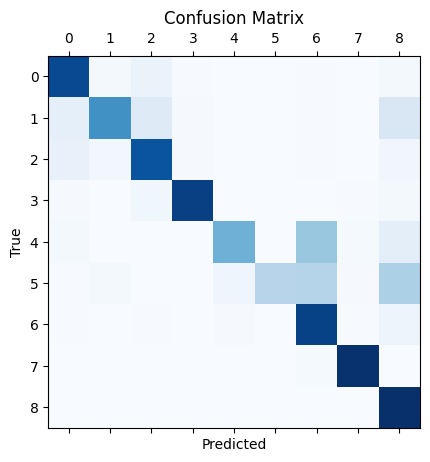

   overall_precision  overall_recall  overall_f1  overall_accuracy
0           0.814885        0.835517    0.825072          0.968601

                   LOC        MISC          ORG          PER
precision     0.795850    0.699828     0.741214     0.969619
recall        0.850719    0.581197     0.838049     0.927644
f1            0.822370    0.635019     0.786663     0.948167
number     1668.000000  702.000000  1661.000000  1617.000000

end of run
---------------------------------------------------
---------------------------------------------------
starting run on training set of 17%



Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['cl

{'eval_loss': 2.3840227127075195, 'eval_precision': 0.009908838684106223, 'eval_recall': 0.039837110481586405, 'eval_f1': 0.015870216892964206, 'eval_accuracy': 0.012382900829115969, 'eval_runtime': 7.1196, 'eval_samples_per_second': 484.998, 'eval_steps_per_second': 7.585, 'epoch': 0.01}



  0%|          | 3/750 [00:14<1:10:00,  5.62s/it]

{'eval_loss': 2.3800160884857178, 'eval_precision': 0.009918448313863787, 'eval_recall': 0.039837110481586405, 'eval_f1': 0.015882539794585822, 'eval_accuracy': 0.012598255626144072, 'eval_runtime': 7.092, 'eval_samples_per_second': 486.886, 'eval_steps_per_second': 7.614, 'epoch': 0.01}



  1%|          | 4/750 [00:21<1:17:24,  6.23s/it]

{'eval_loss': 2.371915102005005, 'eval_precision': 0.009940357852882704, 'eval_recall': 0.039837110481586405, 'eval_f1': 0.01591061768553548, 'eval_accuracy': 0.013308926456336814, 'eval_runtime': 7.0618, 'eval_samples_per_second': 488.969, 'eval_steps_per_second': 7.647, 'epoch': 0.02}



  1%|          | 5/750 [00:28<1:21:43,  6.58s/it]

{'eval_loss': 2.359891891479492, 'eval_precision': 0.009826922225665087, 'eval_recall': 0.039305949008498584, 'eval_f1': 0.015722936364602147, 'eval_accuracy': 0.014213416603854851, 'eval_runtime': 7.0938, 'eval_samples_per_second': 486.761, 'eval_steps_per_second': 7.612, 'epoch': 0.03}



  1%|          | 6/750 [00:36<1:24:26,  6.81s/it]

{'eval_loss': 2.3441781997680664, 'eval_precision': 0.00981960366124589, 'eval_recall': 0.039128895184135974, 'eval_f1': 0.015699367763017686, 'eval_accuracy': 0.016194680736513405, 'eval_runtime': 7.1353, 'eval_samples_per_second': 483.929, 'eval_steps_per_second': 7.568, 'epoch': 0.03}



  1%|          | 7/750 [00:43<1:26:13,  6.96s/it]

{'eval_loss': 2.324836015701294, 'eval_precision': 0.009767192935509768, 'eval_recall': 0.03877478753541076, 'eval_f1': 0.015603847524047027, 'eval_accuracy': 0.018994293097878756, 'eval_runtime': 7.1644, 'eval_samples_per_second': 481.967, 'eval_steps_per_second': 7.537, 'epoch': 0.04}



  1%|          | 8/750 [00:50<1:27:53,  7.11s/it]

{'eval_loss': 2.301680088043213, 'eval_precision': 0.010030449579079347, 'eval_recall': 0.039660056657223795, 'eval_f1': 0.016011436740528948, 'eval_accuracy': 0.02278453752557338, 'eval_runtime': 7.3057, 'eval_samples_per_second': 472.648, 'eval_steps_per_second': 7.392, 'epoch': 0.05}



  1%|          | 9/750 [00:58<1:28:12,  7.14s/it]

{'eval_loss': 2.274961233139038, 'eval_precision': 0.010067415730337079, 'eval_recall': 0.039660056657223795, 'eval_f1': 0.01605849881711951, 'eval_accuracy': 0.027953052654247874, 'eval_runtime': 7.1203, 'eval_samples_per_second': 484.951, 'eval_steps_per_second': 7.584, 'epoch': 0.05}



  1%|▏         | 10/750 [01:05<1:28:25,  7.17s/it]

{'eval_loss': 2.2444677352905273, 'eval_precision': 0.010447761194029851, 'eval_recall': 0.04089943342776204, 'eval_f1': 0.016643850421500107, 'eval_accuracy': 0.036438031657155166, 'eval_runtime': 7.1275, 'eval_samples_per_second': 484.463, 'eval_steps_per_second': 7.576, 'epoch': 0.06}



  1%|▏         | 10/750 [01:12<1:28:25,  7.17s/it]

{'eval_loss': 2.2106544971466064, 'eval_precision': 0.010625684056913534, 'eval_recall': 0.04125354107648725, 'eval_f1': 0.01689875253843922, 'eval_accuracy': 0.05136211909120276, 'eval_runtime': 7.1132, 'eval_samples_per_second': 485.435, 'eval_steps_per_second': 7.592, 'epoch': 0.07}


  2%|▏         | 12/750 [01:20<1:30:50,  7.39s/it]

{'eval_loss': 2.1736390590667725, 'eval_precision': 0.01047918013110516, 'eval_recall': 0.040191218130311616, 'eval_f1': 0.016623947272061516, 'eval_accuracy': 0.07203617960590072, 'eval_runtime': 7.1151, 'eval_samples_per_second': 485.307, 'eval_steps_per_second': 7.59, 'epoch': 0.07}



  2%|▏         | 13/750 [01:27<1:30:05,  7.33s/it]

{'eval_loss': 2.1333391666412354, 'eval_precision': 0.010643307902420646, 'eval_recall': 0.04001416430594901, 'eval_f1': 0.016814225132058627, 'eval_accuracy': 0.10608377301604394, 'eval_runtime': 7.1042, 'eval_samples_per_second': 486.048, 'eval_steps_per_second': 7.601, 'epoch': 0.08}



  2%|▏         | 14/750 [01:35<1:29:31,  7.30s/it]

{'eval_loss': 2.0901288986206055, 'eval_precision': 0.011243578559658815, 'eval_recall': 0.04107648725212465, 'eval_f1': 0.017654668594475304, 'eval_accuracy': 0.15654140195972865, 'eval_runtime': 7.0961, 'eval_samples_per_second': 486.608, 'eval_steps_per_second': 7.61, 'epoch': 0.09}



  2%|▏         | 15/750 [01:42<1:29:31,  7.31s/it]

{'eval_loss': 2.0442001819610596, 'eval_precision': 0.011873350923482849, 'eval_recall': 0.04143059490084986, 'eval_f1': 0.018457169900615238, 'eval_accuracy': 0.2230214278023043, 'eval_runtime': 7.2452, 'eval_samples_per_second': 476.588, 'eval_steps_per_second': 7.453, 'epoch': 0.09}



  2%|▏         | 16/750 [01:49<1:28:56,  7.27s/it]

{'eval_loss': 1.9956356287002563, 'eval_precision': 0.013010640057335024, 'eval_recall': 0.04178470254957507, 'eval_f1': 0.01984277126161349, 'eval_accuracy': 0.3081296435878109, 'eval_runtime': 7.0699, 'eval_samples_per_second': 488.412, 'eval_steps_per_second': 7.638, 'epoch': 0.1}



  2%|▏         | 17/750 [01:56<1:28:23,  7.23s/it]

{'eval_loss': 1.9442847967147827, 'eval_precision': 0.014518943170488534, 'eval_recall': 0.04125354107648725, 'eval_f1': 0.02147861356932153, 'eval_accuracy': 0.4036825670291806, 'eval_runtime': 7.0378, 'eval_samples_per_second': 490.638, 'eval_steps_per_second': 7.673, 'epoch': 0.11}



  2%|▏         | 18/750 [02:03<1:27:53,  7.20s/it]

{'eval_loss': 1.8901292085647583, 'eval_precision': 0.01577924020341011, 'eval_recall': 0.037358356940509915, 'eval_f1': 0.022187171398527866, 'eval_accuracy': 0.5013675029611284, 'eval_runtime': 7.0317, 'eval_samples_per_second': 491.06, 'eval_steps_per_second': 7.679, 'epoch': 0.11}



  3%|▎         | 19/750 [02:10<1:27:29,  7.18s/it]

{'eval_loss': 1.8337554931640625, 'eval_precision': 0.016477759786646347, 'eval_recall': 0.030630311614730878, 'eval_f1': 0.021428129064222454, 'eval_accuracy': 0.5908043501668999, 'eval_runtime': 7.0392, 'eval_samples_per_second': 490.539, 'eval_steps_per_second': 7.671, 'epoch': 0.12}



  3%|▎         | 20/750 [02:18<1:27:02,  7.15s/it]

{'eval_loss': 1.7742589712142944, 'eval_precision': 0.01675531914893617, 'eval_recall': 0.022308781869688384, 'eval_f1': 0.019137302551640343, 'eval_accuracy': 0.6713470442554108, 'eval_runtime': 6.99, 'eval_samples_per_second': 493.991, 'eval_steps_per_second': 7.725, 'epoch': 0.13}



  3%|▎         | 20/750 [02:25<1:27:02,  7.15s/it]

{'eval_loss': 1.7122339010238647, 'eval_precision': 0.01874750698045473, 'eval_recall': 0.016643059490084985, 'eval_f1': 0.017632714312511722, 'eval_accuracy': 0.7306342198772477, 'eval_runtime': 6.9626, 'eval_samples_per_second': 495.935, 'eval_steps_per_second': 7.756, 'epoch': 0.13}


  3%|▎         | 22/750 [02:33<1:28:50,  7.32s/it]

{'eval_loss': 1.6475743055343628, 'eval_precision': 0.020780856423173802, 'eval_recall': 0.011685552407932011, 'eval_f1': 0.014959202175883955, 'eval_accuracy': 0.769333476903198, 'eval_runtime': 7.0789, 'eval_samples_per_second': 487.788, 'eval_steps_per_second': 7.628, 'epoch': 0.14}



  3%|▎         | 23/750 [02:40<1:27:57,  7.26s/it]

{'eval_loss': 1.5799223184585571, 'eval_precision': 0.020177165354330708, 'eval_recall': 0.007259206798866855, 'eval_f1': 0.010677083333333334, 'eval_accuracy': 0.7913212016797674, 'eval_runtime': 7.0111, 'eval_samples_per_second': 492.502, 'eval_steps_per_second': 7.702, 'epoch': 0.15}



  3%|▎         | 24/750 [02:47<1:27:21,  7.22s/it]

{'eval_loss': 1.5100640058517456, 'eval_precision': 0.021986353297952996, 'eval_recall': 0.005134560906515581, 'eval_f1': 0.008324960528204393, 'eval_accuracy': 0.8037687089479918, 'eval_runtime': 7.0253, 'eval_samples_per_second': 491.511, 'eval_steps_per_second': 7.687, 'epoch': 0.15}



  3%|▎         | 25/750 [02:54<1:26:41,  7.17s/it]

{'eval_loss': 1.4386640787124634, 'eval_precision': 0.024752475247524754, 'eval_recall': 0.0035410764872521247, 'eval_f1': 0.006195786864931847, 'eval_accuracy': 0.8124044363088188, 'eval_runtime': 6.9705, 'eval_samples_per_second': 495.374, 'eval_steps_per_second': 7.747, 'epoch': 0.16}



  3%|▎         | 26/750 [03:01<1:26:12,  7.14s/it]

{'eval_loss': 1.3663405179977417, 'eval_precision': 0.025943396226415096, 'eval_recall': 0.0019475920679886685, 'eval_f1': 0.0036231884057971015, 'eval_accuracy': 0.8187574028211478, 'eval_runtime': 6.9613, 'eval_samples_per_second': 496.026, 'eval_steps_per_second': 7.757, 'epoch': 0.17}


/home/ronen/Documents/college/NNForNLP/workshop_1/.conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  4%|▎         | 27/750 [03:08<1:25:46,  7.12s/it]

{'eval_loss': 1.2933231592178345, 'eval_precision': 0.022099447513812154, 'eval_recall': 0.000708215297450425, 'eval_f1': 0.001372448104306056, 'eval_accuracy': 0.8224184343706256, 'eval_runtime': 6.953, 'eval_samples_per_second': 496.621, 'eval_steps_per_second': 7.766, 'epoch': 0.17}



  4%|▎         | 28/750 [03:15<1:25:46,  7.13s/it]

{'eval_loss': 1.2201510667800903, 'eval_precision': 0.018518518518518517, 'eval_recall': 0.00017705382436260624, 'eval_f1': 0.000350754121360926, 'eval_accuracy': 0.8244643049423926, 'eval_runtime': 7.0468, 'eval_samples_per_second': 490.011, 'eval_steps_per_second': 7.663, 'epoch': 0.18}



  4%|▍         | 29/750 [03:22<1:25:50,  7.14s/it]

{'eval_loss': 1.1474124193191528, 'eval_precision': 0.05555555555555555, 'eval_recall': 0.00017705382436260624, 'eval_f1': 0.00035298270384751147, 'eval_accuracy': 0.8250026919349629, 'eval_runtime': 7.0792, 'eval_samples_per_second': 487.767, 'eval_steps_per_second': 7.628, 'epoch': 0.19}



  4%|▍         | 30/750 [03:30<1:25:28,  7.12s/it]

{'eval_loss': 1.0772453546524048, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8252395822116938, 'eval_runtime': 6.9796, 'eval_samples_per_second': 494.725, 'eval_steps_per_second': 7.737, 'epoch': 0.19}



  4%|▍         | 30/750 [03:37<1:25:28,  7.12s/it]

{'eval_loss': 1.0113271474838257, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8252611176913965, 'eval_runtime': 6.9933, 'eval_samples_per_second': 493.76, 'eval_steps_per_second': 7.722, 'epoch': 0.2}


  4%|▍         | 31/750 [03:38<1:28:38,  7.40s/it]/home/ronen/Documents/college/NNForNLP/workshop_1/.conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ronen/Documents/college/NNForNLP/workshop_1/.conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  4%|▍         | 32/750 [03:45<1:27:23,  7.30s/it]

{'eval_loss': 0.9527846574783325, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.9874, 'eval_samples_per_second': 494.179, 'eval_steps_per_second': 7.728, 'epoch': 0.21}



  4%|▍         | 33/750 [03:52<1:26:38,  7.25s/it]

{'eval_loss': 0.9020996689796448, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.9884, 'eval_samples_per_second': 494.106, 'eval_steps_per_second': 7.727, 'epoch': 0.21}



  5%|▍         | 34/750 [03:59<1:26:07,  7.22s/it]

{'eval_loss': 0.8626050353050232, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 7.0316, 'eval_samples_per_second': 491.07, 'eval_steps_per_second': 7.68, 'epoch': 0.22}



  5%|▍         | 35/750 [04:06<1:25:43,  7.19s/it]

{'eval_loss': 0.8336824774742126, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 7.0384, 'eval_samples_per_second': 490.594, 'eval_steps_per_second': 7.672, 'epoch': 0.23}



  5%|▍         | 36/750 [04:13<1:25:45,  7.21s/it]

{'eval_loss': 0.8156114220619202, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 7.1322, 'eval_samples_per_second': 484.14, 'eval_steps_per_second': 7.571, 'epoch': 0.23}



  5%|▍         | 37/750 [04:20<1:25:25,  7.19s/it]

{'eval_loss': 0.8061632513999939, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 7.035, 'eval_samples_per_second': 490.829, 'eval_steps_per_second': 7.676, 'epoch': 0.24}



  5%|▌         | 38/750 [04:28<1:25:03,  7.17s/it]

{'eval_loss': 0.8023027777671814, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 7.0035, 'eval_samples_per_second': 493.042, 'eval_steps_per_second': 7.71, 'epoch': 0.25}



  5%|▌         | 39/750 [04:35<1:24:35,  7.14s/it]

{'eval_loss': 0.7968032956123352, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.977, 'eval_samples_per_second': 494.915, 'eval_steps_per_second': 7.74, 'epoch': 0.25}



  5%|▌         | 40/750 [04:42<1:24:14,  7.12s/it]

{'eval_loss': 0.7889105081558228, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.9594, 'eval_samples_per_second': 496.163, 'eval_steps_per_second': 7.759, 'epoch': 0.26}



  5%|▌         | 40/750 [04:49<1:24:14,  7.12s/it]

{'eval_loss': 0.7767354846000671, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.9943, 'eval_samples_per_second': 493.686, 'eval_steps_per_second': 7.721, 'epoch': 0.27}


  5%|▌         | 41/750 [04:50<1:27:27,  7.40s/it]/home/ronen/Documents/college/NNForNLP/workshop_1/.conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ronen/Documents/college/NNForNLP/workshop_1/.conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  6%|▌         | 42/750 [04:57<1:26:32,  7.33s/it]

{'eval_loss': 0.7608538269996643, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 7.0575, 'eval_samples_per_second': 489.266, 'eval_steps_per_second': 7.651, 'epoch': 0.27}



  6%|▌         | 43/750 [05:04<1:26:03,  7.30s/it]

{'eval_loss': 0.7375617623329163, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 7.1417, 'eval_samples_per_second': 483.5, 'eval_steps_per_second': 7.561, 'epoch': 0.28}



  6%|▌         | 44/750 [05:11<1:25:03,  7.23s/it]

{'eval_loss': 0.7086425423622131, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.9667, 'eval_samples_per_second': 495.641, 'eval_steps_per_second': 7.751, 'epoch': 0.29}



  6%|▌         | 45/750 [05:18<1:24:20,  7.18s/it]

{'eval_loss': 0.6793314218521118, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.9565, 'eval_samples_per_second': 496.368, 'eval_steps_per_second': 7.762, 'epoch': 0.29}



  6%|▌         | 46/750 [05:25<1:23:44,  7.14s/it]

{'eval_loss': 0.6532086133956909, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.9382, 'eval_samples_per_second': 497.68, 'eval_steps_per_second': 7.783, 'epoch': 0.3}



  6%|▋         | 47/750 [05:32<1:23:13,  7.10s/it]

{'eval_loss': 0.6326560974121094, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.9204, 'eval_samples_per_second': 498.957, 'eval_steps_per_second': 7.803, 'epoch': 0.31}



  6%|▋         | 48/750 [05:39<1:22:57,  7.09s/it]

{'eval_loss': 0.6155200004577637, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.9427, 'eval_samples_per_second': 497.359, 'eval_steps_per_second': 7.778, 'epoch': 0.31}



  7%|▋         | 49/750 [05:46<1:22:39,  7.07s/it]

{'eval_loss': 0.6006835103034973, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.9319, 'eval_samples_per_second': 498.132, 'eval_steps_per_second': 7.79, 'epoch': 0.32}



  7%|▋         | 50/750 [05:54<1:22:44,  7.09s/it]

{'eval_loss': 0.5878911018371582, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 7.0327, 'eval_samples_per_second': 490.989, 'eval_steps_per_second': 7.678, 'epoch': 0.33}



  7%|▋         | 50/750 [06:01<1:22:44,  7.09s/it]

{'eval_loss': 0.5730085372924805, 'eval_precision': 0.2, 'eval_recall': 0.00017705382436260624, 'eval_f1': 0.0003537944454272068, 'eval_accuracy': 0.8253472596102078, 'eval_runtime': 6.926, 'eval_samples_per_second': 498.556, 'eval_steps_per_second': 7.797, 'epoch': 0.33}


  7%|▋         | 51/750 [06:02<1:25:32,  7.34s/it]/home/ronen/Documents/college/NNForNLP/workshop_1/.conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  7%|▋         | 52/750 [06:09<1:24:25,  7.26s/it]

{'eval_loss': 0.5545051693916321, 'eval_precision': 0.32, 'eval_recall': 0.00141643059490085, 'eval_f1': 0.0028203772254539045, 'eval_accuracy': 0.8256918272854528, 'eval_runtime': 6.9366, 'eval_samples_per_second': 497.792, 'eval_steps_per_second': 7.785, 'epoch': 0.34}



  7%|▋         | 53/750 [06:16<1:23:35,  7.20s/it]

{'eval_loss': 0.5335560441017151, 'eval_precision': 0.2988505747126437, 'eval_recall': 0.004603399433427762, 'eval_f1': 0.009067131647776809, 'eval_accuracy': 0.8267686012705933, 'eval_runtime': 6.9378, 'eval_samples_per_second': 497.712, 'eval_steps_per_second': 7.784, 'epoch': 0.35}



  7%|▋         | 54/750 [06:23<1:22:55,  7.15s/it]

{'eval_loss': 0.5126048922538757, 'eval_precision': 0.34782608695652173, 'eval_recall': 0.0169971671388102, 'eval_f1': 0.03241053342336259, 'eval_accuracy': 0.830085065144826, 'eval_runtime': 6.9305, 'eval_samples_per_second': 498.234, 'eval_steps_per_second': 7.792, 'epoch': 0.35}



  7%|▋         | 55/750 [06:30<1:22:27,  7.12s/it]

{'eval_loss': 0.49323511123657227, 'eval_precision': 0.3588039867109635, 'eval_recall': 0.03824362606232295, 'eval_f1': 0.06912, 'eval_accuracy': 0.8361365349413158, 'eval_runtime': 6.9272, 'eval_samples_per_second': 498.471, 'eval_steps_per_second': 7.795, 'epoch': 0.36}



  7%|▋         | 56/750 [06:37<1:21:57,  7.09s/it]

{'eval_loss': 0.47580602765083313, 'eval_precision': 0.33765032377428306, 'eval_recall': 0.06462464589235127, 'eval_f1': 0.10848565908753158, 'eval_accuracy': 0.8441692688704641, 'eval_runtime': 6.9222, 'eval_samples_per_second': 498.831, 'eval_steps_per_second': 7.801, 'epoch': 0.37}



  8%|▊         | 57/750 [06:44<1:22:16,  7.12s/it]

{'eval_loss': 0.45949146151542664, 'eval_precision': 0.33455882352941174, 'eval_recall': 0.096671388101983, 'eval_f1': 0.15, 'eval_accuracy': 0.8526757833530741, 'eval_runtime': 7.1123, 'eval_samples_per_second': 485.496, 'eval_steps_per_second': 7.592, 'epoch': 0.37}



  8%|▊         | 58/750 [06:51<1:22:11,  7.13s/it]

{'eval_loss': 0.444070965051651, 'eval_precision': 0.3444495203289173, 'eval_recall': 0.1334985835694051, 'eval_f1': 0.19242056909531707, 'eval_accuracy': 0.860643910843114, 'eval_runtime': 7.0286, 'eval_samples_per_second': 491.276, 'eval_steps_per_second': 7.683, 'epoch': 0.38}



  8%|▊         | 59/750 [06:58<1:21:59,  7.12s/it]

{'eval_loss': 0.43023133277893066, 'eval_precision': 0.34339488636363635, 'eval_recall': 0.17121104815864022, 'eval_f1': 0.22849716446124765, 'eval_accuracy': 0.8685905028534511, 'eval_runtime': 7.0014, 'eval_samples_per_second': 493.184, 'eval_steps_per_second': 7.713, 'epoch': 0.39}



  8%|▊         | 60/750 [07:05<1:21:46,  7.11s/it]

{'eval_loss': 0.4167119860649109, 'eval_precision': 0.34474820143884893, 'eval_recall': 0.21211048158640228, 'eval_f1': 0.2626329058423764, 'eval_accuracy': 0.8758694949930009, 'eval_runtime': 6.9924, 'eval_samples_per_second': 493.822, 'eval_steps_per_second': 7.723, 'epoch': 0.39}



  8%|▊         | 60/750 [07:12<1:21:46,  7.11s/it]

{'eval_loss': 0.40273842215538025, 'eval_precision': 0.34912658530748986, 'eval_recall': 0.25832152974504247, 'eval_f1': 0.296937010277806, 'eval_accuracy': 0.8834284483686874, 'eval_runtime': 6.9714, 'eval_samples_per_second': 495.311, 'eval_steps_per_second': 7.746, 'epoch': 0.4}


  8%|▊         | 61/750 [07:13<1:24:44,  7.38s/it]/home/ronen/Documents/college/NNForNLP/workshop_1/.conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  8%|▊         | 62/750 [07:20<1:23:26,  7.28s/it]

{'eval_loss': 0.38880443572998047, 'eval_precision': 0.3615842396880772, 'eval_recall': 0.3119688385269122, 'eval_f1': 0.3349491493204068, 'eval_accuracy': 0.8915042532572413, 'eval_runtime': 6.9532, 'eval_samples_per_second': 496.606, 'eval_steps_per_second': 7.766, 'epoch': 0.41}



  8%|▊         | 63/750 [07:27<1:22:44,  7.23s/it]

{'eval_loss': 0.3763302266597748, 'eval_precision': 0.3646928610957388, 'eval_recall': 0.35003541076487255, 'eval_f1': 0.35721384045532567, 'eval_accuracy': 0.8972326908581889, 'eval_runtime': 7.0112, 'eval_samples_per_second': 492.497, 'eval_steps_per_second': 7.702, 'epoch': 0.41}



  9%|▊         | 64/750 [07:35<1:22:34,  7.22s/it]

{'eval_loss': 0.36521002650260925, 'eval_precision': 0.36242070975484314, 'eval_recall': 0.3742917847025496, 'eval_f1': 0.3682606044769619, 'eval_accuracy': 0.9005922256918273, 'eval_runtime': 7.1236, 'eval_samples_per_second': 484.727, 'eval_steps_per_second': 7.58, 'epoch': 0.42}



  9%|▊         | 65/750 [07:42<1:21:58,  7.18s/it]

{'eval_loss': 0.35498419404029846, 'eval_precision': 0.3646034816247582, 'eval_recall': 0.4004957507082153, 'eval_f1': 0.3817077286533918, 'eval_accuracy': 0.9040163669645741, 'eval_runtime': 6.976, 'eval_samples_per_second': 494.981, 'eval_steps_per_second': 7.741, 'epoch': 0.43}



  9%|▉         | 66/750 [07:49<1:21:25,  7.14s/it]

{'eval_loss': 0.34588873386383057, 'eval_precision': 0.36133049817739976, 'eval_recall': 0.42121104815864024, 'eval_f1': 0.38897972531066055, 'eval_accuracy': 0.906536018089803, 'eval_runtime': 6.962, 'eval_samples_per_second': 495.981, 'eval_steps_per_second': 7.756, 'epoch': 0.43}



  9%|▉         | 67/750 [07:56<1:21:07,  7.13s/it]

{'eval_loss': 0.3387874364852905, 'eval_precision': 0.3581159420289855, 'eval_recall': 0.4375, 'eval_f1': 0.39384762511954097, 'eval_accuracy': 0.9084311403036502, 'eval_runtime': 6.9881, 'eval_samples_per_second': 494.125, 'eval_steps_per_second': 7.727, 'epoch': 0.44}



  9%|▉         | 68/750 [08:03<1:20:49,  7.11s/it]

{'eval_loss': 0.3330625295639038, 'eval_precision': 0.3543859649122807, 'eval_recall': 0.4470609065155807, 'eval_f1': 0.395365223518359, 'eval_accuracy': 0.9090125982556262, 'eval_runtime': 6.9779, 'eval_samples_per_second': 494.851, 'eval_steps_per_second': 7.739, 'epoch': 0.45}



  9%|▉         | 69/750 [08:10<1:20:41,  7.11s/it]

{'eval_loss': 0.32794278860092163, 'eval_precision': 0.35497656465398403, 'eval_recall': 0.45591359773371104, 'eval_f1': 0.39916292047744534, 'eval_accuracy': 0.9100678367610638, 'eval_runtime': 6.99, 'eval_samples_per_second': 493.991, 'eval_steps_per_second': 7.725, 'epoch': 0.45}



  9%|▉         | 70/750 [08:17<1:20:32,  7.11s/it]

{'eval_loss': 0.3222668170928955, 'eval_precision': 0.36290212183436005, 'eval_recall': 0.4693696883852691, 'eval_f1': 0.409326024859106, 'eval_accuracy': 0.9114891784214494, 'eval_runtime': 7.0002, 'eval_samples_per_second': 493.275, 'eval_steps_per_second': 7.714, 'epoch': 0.46}



  9%|▉         | 70/750 [08:24<1:20:32,  7.11s/it]

{'eval_loss': 0.31638863682746887, 'eval_precision': 0.37534246575342467, 'eval_recall': 0.48512747875354106, 'eval_f1': 0.4232313870868088, 'eval_accuracy': 0.913341229675891, 'eval_runtime': 7.1215, 'eval_samples_per_second': 484.872, 'eval_steps_per_second': 7.583, 'epoch': 0.47}


 10%|▉         | 72/750 [08:32<1:22:40,  7.32s/it]

{'eval_loss': 0.3101484477519989, 'eval_precision': 0.38747067752173314, 'eval_recall': 0.4971671388101983, 'eval_f1': 0.4355176424970919, 'eval_accuracy': 0.9149994616130074, 'eval_runtime': 6.9582, 'eval_samples_per_second': 496.249, 'eval_steps_per_second': 7.761, 'epoch': 0.47}



 10%|▉         | 73/750 [08:39<1:21:42,  7.24s/it]

{'eval_loss': 0.30243462324142456, 'eval_precision': 0.4035333707234997, 'eval_recall': 0.5095609065155807, 'eval_f1': 0.4503912363067292, 'eval_accuracy': 0.9171960805426941, 'eval_runtime': 6.9648, 'eval_samples_per_second': 495.781, 'eval_steps_per_second': 7.753, 'epoch': 0.48}



 10%|▉         | 74/750 [08:46<1:20:55,  7.18s/it]

{'eval_loss': 0.2947845757007599, 'eval_precision': 0.4284481518768877, 'eval_recall': 0.527443342776204, 'eval_f1': 0.47281961749067536, 'eval_accuracy': 0.9202971896198988, 'eval_runtime': 6.9621, 'eval_samples_per_second': 495.974, 'eval_steps_per_second': 7.756, 'epoch': 0.49}



 10%|█         | 75/750 [08:54<1:20:28,  7.15s/it]

{'eval_loss': 0.28732505440711975, 'eval_precision': 0.4493791088385683, 'eval_recall': 0.5446175637393768, 'eval_f1': 0.4924357640278556, 'eval_accuracy': 0.9228599117045332, 'eval_runtime': 6.9921, 'eval_samples_per_second': 493.84, 'eval_steps_per_second': 7.723, 'epoch': 0.49}



 10%|█         | 76/750 [09:01<1:20:08,  7.13s/it]

{'eval_loss': 0.2810150384902954, 'eval_precision': 0.4634038800705467, 'eval_recall': 0.5582507082152974, 'eval_f1': 0.5064246707356248, 'eval_accuracy': 0.9245396791213524, 'eval_runtime': 6.9882, 'eval_samples_per_second': 494.117, 'eval_steps_per_second': 7.727, 'epoch': 0.5}



 10%|█         | 77/750 [09:08<1:19:55,  7.13s/it]

{'eval_loss': 0.2750313878059387, 'eval_precision': 0.4796386791055827, 'eval_recall': 0.5734773371104815, 'eval_f1': 0.522377227642932, 'eval_accuracy': 0.926068698180252, 'eval_runtime': 6.9812, 'eval_samples_per_second': 494.617, 'eval_steps_per_second': 7.735, 'epoch': 0.51}



 10%|█         | 78/750 [09:15<1:19:40,  7.11s/it]

{'eval_loss': 0.27012544870376587, 'eval_precision': 0.4932321880113045, 'eval_recall': 0.5871104815864022, 'eval_f1': 0.5360924743351385, 'eval_accuracy': 0.9274900398406375, 'eval_runtime': 6.9788, 'eval_samples_per_second': 494.784, 'eval_steps_per_second': 7.738, 'epoch': 0.51}



 11%|█         | 79/750 [09:22<1:19:44,  7.13s/it]

{'eval_loss': 0.26671257615089417, 'eval_precision': 0.4999257609502598, 'eval_recall': 0.5961402266288952, 'eval_f1': 0.5438100621820238, 'eval_accuracy': 0.9280714977926133, 'eval_runtime': 7.0696, 'eval_samples_per_second': 488.429, 'eval_steps_per_second': 7.638, 'epoch': 0.52}



 11%|█         | 80/750 [09:29<1:19:32,  7.12s/it]

{'eval_loss': 0.2625213861465454, 'eval_precision': 0.514042426053182, 'eval_recall': 0.609242209631728, 'eval_f1': 0.5576081672338357, 'eval_accuracy': 0.9295143749327016, 'eval_runtime': 6.9806, 'eval_samples_per_second': 494.658, 'eval_steps_per_second': 7.736, 'epoch': 0.53}



 11%|█         | 80/750 [09:36<1:19:32,  7.12s/it]

{'eval_loss': 0.2584621012210846, 'eval_precision': 0.5204783258594918, 'eval_recall': 0.6165014164305949, 'eval_f1': 0.564435078618901, 'eval_accuracy': 0.929923549047055, 'eval_runtime': 6.9727, 'eval_samples_per_second': 495.217, 'eval_steps_per_second': 7.744, 'epoch': 0.53}


 11%|█         | 82/750 [09:44<1:21:15,  7.30s/it]

{'eval_loss': 0.25302520394325256, 'eval_precision': 0.5306400363141172, 'eval_recall': 0.62092776203966, 'eval_f1': 0.5722444317532838, 'eval_accuracy': 0.9308711101539787, 'eval_runtime': 7.011, 'eval_samples_per_second': 492.513, 'eval_steps_per_second': 7.702, 'epoch': 0.54}



 11%|█         | 83/750 [09:51<1:20:30,  7.24s/it]

{'eval_loss': 0.24746105074882507, 'eval_precision': 0.5440518438512575, 'eval_recall': 0.6242917847025495, 'eval_f1': 0.5814164399373403, 'eval_accuracy': 0.9321417034564445, 'eval_runtime': 7.0231, 'eval_samples_per_second': 491.666, 'eval_steps_per_second': 7.689, 'epoch': 0.55}



 11%|█         | 84/750 [09:58<1:20:01,  7.21s/it]

{'eval_loss': 0.24308235943317413, 'eval_precision': 0.5614896988906498, 'eval_recall': 0.6273016997167139, 'eval_f1': 0.5925740090316107, 'eval_accuracy': 0.9333907612792075, 'eval_runtime': 7.0015, 'eval_samples_per_second': 493.18, 'eval_steps_per_second': 7.713, 'epoch': 0.55}



 11%|█▏        | 85/750 [10:06<1:19:24,  7.16s/it]

{'eval_loss': 0.24064968526363373, 'eval_precision': 0.5766246362754607, 'eval_recall': 0.6315509915014165, 'eval_f1': 0.6028392766604699, 'eval_accuracy': 0.93425218046732, 'eval_runtime': 6.9775, 'eval_samples_per_second': 494.873, 'eval_steps_per_second': 7.739, 'epoch': 0.56}



 11%|█▏        | 86/750 [10:13<1:19:26,  7.18s/it]

{'eval_loss': 0.23889227211475372, 'eval_precision': 0.5839189410034319, 'eval_recall': 0.6326133144475921, 'eval_f1': 0.6072915781422623, 'eval_accuracy': 0.9347690319801873, 'eval_runtime': 7.1201, 'eval_samples_per_second': 484.967, 'eval_steps_per_second': 7.584, 'epoch': 0.57}



 12%|█▏        | 87/750 [10:20<1:18:59,  7.15s/it]

{'eval_loss': 0.23612117767333984, 'eval_precision': 0.593719171325222, 'eval_recall': 0.6393413597733711, 'eval_f1': 0.615686274509804, 'eval_accuracy': 0.9362334445999785, 'eval_runtime': 6.9809, 'eval_samples_per_second': 494.632, 'eval_steps_per_second': 7.735, 'epoch': 0.57}



 12%|█▏        | 88/750 [10:27<1:18:34,  7.12s/it]

{'eval_loss': 0.23337145149707794, 'eval_precision': 0.600396956665564, 'eval_recall': 0.6427053824362606, 'eval_f1': 0.620831195484864, 'eval_accuracy': 0.9368364380316572, 'eval_runtime': 6.9612, 'eval_samples_per_second': 496.036, 'eval_steps_per_second': 7.757, 'epoch': 0.58}



 12%|█▏        | 89/750 [10:34<1:18:13,  7.10s/it]

{'eval_loss': 0.22762659192085266, 'eval_precision': 0.6045708648470898, 'eval_recall': 0.6510269121813032, 'eval_f1': 0.6269394714407502, 'eval_accuracy': 0.9378916765370948, 'eval_runtime': 6.9446, 'eval_samples_per_second': 497.219, 'eval_steps_per_second': 7.776, 'epoch': 0.59}



 12%|█▏        | 90/750 [10:41<1:17:57,  7.09s/it]

{'eval_loss': 0.22382940351963043, 'eval_precision': 0.6112023653088042, 'eval_recall': 0.6588172804532578, 'eval_f1': 0.6341172460804363, 'eval_accuracy': 0.939119198880155, 'eval_runtime': 6.943, 'eval_samples_per_second': 497.337, 'eval_steps_per_second': 7.778, 'epoch': 0.59}



 12%|█▏        | 90/750 [10:48<1:17:57,  7.09s/it]

{'eval_loss': 0.21962910890579224, 'eval_precision': 0.6125081645983018, 'eval_recall': 0.664128895184136, 'eval_f1': 0.6372748895684677, 'eval_accuracy': 0.9398514051900506, 'eval_runtime': 6.9344, 'eval_samples_per_second': 497.951, 'eval_steps_per_second': 7.787, 'epoch': 0.6}


 12%|█▏        | 92/750 [10:56<1:19:37,  7.26s/it]

{'eval_loss': 0.2157159149646759, 'eval_precision': 0.6073738680465718, 'eval_recall': 0.6650141643059491, 'eval_f1': 0.6348884381338742, 'eval_accuracy': 0.9402175083449984, 'eval_runtime': 6.9353, 'eval_samples_per_second': 497.891, 'eval_steps_per_second': 7.786, 'epoch': 0.61}



 12%|█▏        | 93/750 [11:03<1:19:10,  7.23s/it]

{'eval_loss': 0.21348212659358978, 'eval_precision': 0.6011772192173083, 'eval_recall': 0.6690864022662889, 'eval_f1': 0.633316574493045, 'eval_accuracy': 0.9409066436954883, 'eval_runtime': 7.0626, 'eval_samples_per_second': 488.913, 'eval_steps_per_second': 7.646, 'epoch': 0.61}



 13%|█▎        | 94/750 [11:10<1:18:24,  7.17s/it]

{'eval_loss': 0.2118196338415146, 'eval_precision': 0.5996525584333544, 'eval_recall': 0.6722733711048159, 'eval_f1': 0.6338898163606009, 'eval_accuracy': 0.9414665661677614, 'eval_runtime': 6.936, 'eval_samples_per_second': 497.84, 'eval_steps_per_second': 7.786, 'epoch': 0.62}



 13%|█▎        | 95/750 [11:17<1:17:48,  7.13s/it]

{'eval_loss': 0.21072746813297272, 'eval_precision': 0.5955709125176692, 'eval_recall': 0.6713881019830028, 'eval_f1': 0.631210986267166, 'eval_accuracy': 0.9413588887692473, 'eval_runtime': 6.9386, 'eval_samples_per_second': 497.652, 'eval_steps_per_second': 7.783, 'epoch': 0.63}



 13%|█▎        | 96/750 [11:24<1:17:19,  7.09s/it]

{'eval_loss': 0.2099682241678238, 'eval_precision': 0.5914415117913479, 'eval_recall': 0.6705028328611898, 'eval_f1': 0.6284955605343955, 'eval_accuracy': 0.9413804242489502, 'eval_runtime': 6.9352, 'eval_samples_per_second': 497.895, 'eval_steps_per_second': 7.786, 'epoch': 0.63}



 13%|█▎        | 97/750 [11:31<1:17:05,  7.08s/it]

{'eval_loss': 0.20905578136444092, 'eval_precision': 0.5936720698254364, 'eval_recall': 0.6743980169971672, 'eval_f1': 0.6314655172413793, 'eval_accuracy': 0.9421126305588456, 'eval_runtime': 6.9587, 'eval_samples_per_second': 496.213, 'eval_steps_per_second': 7.76, 'epoch': 0.64}



 13%|█▎        | 98/750 [11:38<1:16:59,  7.09s/it]

{'eval_loss': 0.20867538452148438, 'eval_precision': 0.5907401672344379, 'eval_recall': 0.6754603399433428, 'eval_f1': 0.6302659838096811, 'eval_accuracy': 0.9421557015182513, 'eval_runtime': 6.9897, 'eval_samples_per_second': 494.015, 'eval_steps_per_second': 7.726, 'epoch': 0.65}



 13%|█▎        | 99/750 [11:45<1:16:55,  7.09s/it]

{'eval_loss': 0.20688314735889435, 'eval_precision': 0.5956521739130435, 'eval_recall': 0.6791784702549575, 'eval_f1': 0.6346790205162145, 'eval_accuracy': 0.9431247981048778, 'eval_runtime': 6.991, 'eval_samples_per_second': 493.919, 'eval_steps_per_second': 7.724, 'epoch': 0.65}



 13%|█▎        | 100/750 [11:53<1:17:31,  7.16s/it]

{'eval_loss': 0.20517350733280182, 'eval_precision': 0.6003731923495569, 'eval_recall': 0.6836048158640227, 'eval_f1': 0.6392913320639126, 'eval_accuracy': 0.9441369656509099, 'eval_runtime': 7.21, 'eval_samples_per_second': 478.918, 'eval_steps_per_second': 7.49, 'epoch': 0.66}



 13%|█▎        | 100/750 [12:00<1:17:31,  7.16s/it]

{'eval_loss': 0.20078067481517792, 'eval_precision': 0.60967993754879, 'eval_recall': 0.6913951841359773, 'eval_f1': 0.6479714593877044, 'eval_accuracy': 0.9457305911489179, 'eval_runtime': 7.0842, 'eval_samples_per_second': 487.42, 'eval_steps_per_second': 7.623, 'epoch': 0.67}


 14%|█▎        | 102/750 [12:08<1:19:33,  7.37s/it]

{'eval_loss': 0.1959909051656723, 'eval_precision': 0.6230077323654726, 'eval_recall': 0.6990084985835694, 'eval_f1': 0.6588235294117647, 'eval_accuracy': 0.9471734682890062, 'eval_runtime': 7.0283, 'eval_samples_per_second': 491.302, 'eval_steps_per_second': 7.683, 'epoch': 0.67}



 14%|█▎        | 103/750 [12:15<1:19:03,  7.33s/it]

{'eval_loss': 0.19165025651454926, 'eval_precision': 0.6336302895322939, 'eval_recall': 0.7052053824362606, 'eval_f1': 0.6675046086810793, 'eval_accuracy': 0.9486163454290945, 'eval_runtime': 7.1669, 'eval_samples_per_second': 481.801, 'eval_steps_per_second': 7.535, 'epoch': 0.68}



 14%|█▍        | 104/750 [12:23<1:18:40,  7.31s/it]

{'eval_loss': 0.18848977982997894, 'eval_precision': 0.6452129362792187, 'eval_recall': 0.7135269121813032, 'eval_f1': 0.6776525979485456, 'eval_accuracy': 0.9498438677721546, 'eval_runtime': 7.1554, 'eval_samples_per_second': 482.574, 'eval_steps_per_second': 7.547, 'epoch': 0.69}



 14%|█▍        | 105/750 [12:30<1:18:09,  7.27s/it]

{'eval_loss': 0.18633289635181427, 'eval_precision': 0.6544578313253012, 'eval_recall': 0.7213172804532578, 'eval_f1': 0.6862629495493978, 'eval_accuracy': 0.9510498546355121, 'eval_runtime': 7.0998, 'eval_samples_per_second': 486.354, 'eval_steps_per_second': 7.606, 'epoch': 0.69}



 14%|█▍        | 106/750 [12:37<1:18:08,  7.28s/it]

{'eval_loss': 0.18456695973873138, 'eval_precision': 0.6592259515015256, 'eval_recall': 0.7268059490084986, 'eval_f1': 0.6913684210526315, 'eval_accuracy': 0.9517820609454075, 'eval_runtime': 7.1931, 'eval_samples_per_second': 480.043, 'eval_steps_per_second': 7.507, 'epoch': 0.7}



 14%|█▍        | 107/750 [12:45<1:18:31,  7.33s/it]

{'eval_loss': 0.18295013904571533, 'eval_precision': 0.6600771456123433, 'eval_recall': 0.7271600566572238, 'eval_f1': 0.6919966301600674, 'eval_accuracy': 0.9519758802627328, 'eval_runtime': 7.322, 'eval_samples_per_second': 471.589, 'eval_steps_per_second': 7.375, 'epoch': 0.71}



 14%|█▍        | 108/750 [12:52<1:17:46,  7.27s/it]

{'eval_loss': 0.18182706832885742, 'eval_precision': 0.6644736842105263, 'eval_recall': 0.7331798866855525, 'eval_f1': 0.6971380471380471, 'eval_accuracy': 0.9523850543770862, 'eval_runtime': 7.0328, 'eval_samples_per_second': 490.986, 'eval_steps_per_second': 7.678, 'epoch': 0.71}



 15%|█▍        | 109/750 [12:59<1:17:08,  7.22s/it]

{'eval_loss': 0.1795719712972641, 'eval_precision': 0.6727389972593906, 'eval_recall': 0.7388456090651558, 'eval_f1': 0.7042443675639185, 'eval_accuracy': 0.9532249380854959, 'eval_runtime': 7.021, 'eval_samples_per_second': 491.812, 'eval_steps_per_second': 7.691, 'epoch': 0.72}



 15%|█▍        | 110/750 [13:06<1:17:06,  7.23s/it]

{'eval_loss': 0.1780560314655304, 'eval_precision': 0.6772734614763366, 'eval_recall': 0.7423866855524079, 'eval_f1': 0.7083368527747275, 'eval_accuracy': 0.9536341121998493, 'eval_runtime': 7.1628, 'eval_samples_per_second': 482.072, 'eval_steps_per_second': 7.539, 'epoch': 0.73}



 15%|█▍        | 110/750 [13:13<1:17:06,  7.23s/it]

{'eval_loss': 0.17762912809848785, 'eval_precision': 0.6812620734063104, 'eval_recall': 0.7492917847025495, 'eval_f1': 0.7136593591905566, 'eval_accuracy': 0.9541294282330139, 'eval_runtime': 7.0361, 'eval_samples_per_second': 490.755, 'eval_steps_per_second': 7.675, 'epoch': 0.73}


 15%|█▍        | 112/750 [13:21<1:18:44,  7.41s/it]

{'eval_loss': 0.17648953199386597, 'eval_precision': 0.6878025169409487, 'eval_recall': 0.7547804532577904, 'eval_f1': 0.7197366199561034, 'eval_accuracy': 0.9547108861849898, 'eval_runtime': 7.0428, 'eval_samples_per_second': 490.291, 'eval_steps_per_second': 7.667, 'epoch': 0.74}



 15%|█▌        | 113/750 [13:29<1:17:53,  7.34s/it]

{'eval_loss': 0.1752108484506607, 'eval_precision': 0.6954199708690727, 'eval_recall': 0.7608002832861189, 'eval_f1': 0.7266424283419294, 'eval_accuracy': 0.9555507698933994, 'eval_runtime': 7.0477, 'eval_samples_per_second': 489.945, 'eval_steps_per_second': 7.662, 'epoch': 0.75}



 15%|█▌        | 114/750 [13:36<1:17:22,  7.30s/it]

{'eval_loss': 0.17239001393318176, 'eval_precision': 0.7020999511639264, 'eval_recall': 0.7636331444759207, 'eval_f1': 0.73157493003138, 'eval_accuracy': 0.9564337245612146, 'eval_runtime': 7.1211, 'eval_samples_per_second': 484.896, 'eval_steps_per_second': 7.583, 'epoch': 0.75}



 15%|█▌        | 115/750 [13:43<1:16:41,  7.25s/it]

{'eval_loss': 0.17039838433265686, 'eval_precision': 0.7068430507920954, 'eval_recall': 0.7662889518413598, 'eval_f1': 0.735366578880299, 'eval_accuracy': 0.9569721115537848, 'eval_runtime': 7.0233, 'eval_samples_per_second': 491.648, 'eval_steps_per_second': 7.689, 'epoch': 0.76}



 15%|█▌        | 116/750 [13:50<1:16:04,  7.20s/it]

{'eval_loss': 0.16844110190868378, 'eval_precision': 0.7111292962356792, 'eval_recall': 0.7692988668555241, 'eval_f1': 0.7390712706242558, 'eval_accuracy': 0.9575535695057608, 'eval_runtime': 6.985, 'eval_samples_per_second': 494.346, 'eval_steps_per_second': 7.731, 'epoch': 0.77}



 16%|█▌        | 117/750 [13:57<1:15:38,  7.17s/it]

{'eval_loss': 0.1663978546857834, 'eval_precision': 0.7157377049180328, 'eval_recall': 0.7730169971671388, 'eval_f1': 0.7432754511406198, 'eval_accuracy': 0.9582642403359535, 'eval_runtime': 7.0017, 'eval_samples_per_second': 493.164, 'eval_steps_per_second': 7.712, 'epoch': 0.77}



 16%|█▌        | 118/750 [14:04<1:15:34,  7.17s/it]

{'eval_loss': 0.16367347538471222, 'eval_precision': 0.7197956156255151, 'eval_recall': 0.7731940509915014, 'eval_f1': 0.7455399061032865, 'eval_accuracy': 0.9590395176052546, 'eval_runtime': 7.0853, 'eval_samples_per_second': 487.348, 'eval_steps_per_second': 7.621, 'epoch': 0.78}



 16%|█▌        | 119/750 [14:11<1:15:38,  7.19s/it]

{'eval_loss': 0.1617065817117691, 'eval_precision': 0.7299500831946756, 'eval_recall': 0.7767351274787535, 'eval_f1': 0.7526162291988335, 'eval_accuracy': 0.9599655432324755, 'eval_runtime': 7.1137, 'eval_samples_per_second': 485.4, 'eval_steps_per_second': 7.591, 'epoch': 0.79}



 16%|█▌        | 120/750 [14:19<1:15:29,  7.19s/it]

{'eval_loss': 0.15938565135002136, 'eval_precision': 0.7401614530776993, 'eval_recall': 0.77921388101983, 'eval_f1': 0.7591857857512507, 'eval_accuracy': 0.9608054269408851, 'eval_runtime': 7.0914, 'eval_samples_per_second': 486.927, 'eval_steps_per_second': 7.615, 'epoch': 0.79}



 16%|█▌        | 120/750 [14:26<1:15:29,  7.19s/it]

{'eval_loss': 0.1575569212436676, 'eval_precision': 0.7438490057296933, 'eval_recall': 0.7815155807365439, 'eval_f1': 0.7622172336384044, 'eval_accuracy': 0.9611715300958329, 'eval_runtime': 7.1069, 'eval_samples_per_second': 485.868, 'eval_steps_per_second': 7.598, 'epoch': 0.8}


 16%|█▋        | 122/750 [14:34<1:16:48,  7.34s/it]

{'eval_loss': 0.15524834394454956, 'eval_precision': 0.7504652343089155, 'eval_recall': 0.7854107648725213, 'eval_f1': 0.7675404446751448, 'eval_accuracy': 0.9619898783245396, 'eval_runtime': 6.948, 'eval_samples_per_second': 496.979, 'eval_steps_per_second': 7.772, 'epoch': 0.81}



 16%|█▋        | 123/750 [14:41<1:15:47,  7.25s/it]

{'eval_loss': 0.15371198952198029, 'eval_precision': 0.7556876061120543, 'eval_recall': 0.7880665722379604, 'eval_f1': 0.7715375281677934, 'eval_accuracy': 0.9624851943577043, 'eval_runtime': 6.969, 'eval_samples_per_second': 495.48, 'eval_steps_per_second': 7.749, 'epoch': 0.81}



 17%|█▋        | 124/750 [14:48<1:15:11,  7.21s/it]

{'eval_loss': 0.1528201401233673, 'eval_precision': 0.7553895773213376, 'eval_recall': 0.7878895184135978, 'eval_f1': 0.771297339457492, 'eval_accuracy': 0.9625282653171099, 'eval_runtime': 6.9706, 'eval_samples_per_second': 495.367, 'eval_steps_per_second': 7.747, 'epoch': 0.82}



 17%|█▋        | 125/750 [14:55<1:14:39,  7.17s/it]

{'eval_loss': 0.1521902233362198, 'eval_precision': 0.7546594374788207, 'eval_recall': 0.7885977337110481, 'eval_f1': 0.7712554112554112, 'eval_accuracy': 0.9623775169591903, 'eval_runtime': 6.9611, 'eval_samples_per_second': 496.044, 'eval_steps_per_second': 7.757, 'epoch': 0.83}



 17%|█▋        | 126/750 [15:02<1:14:12,  7.14s/it]

{'eval_loss': 0.15105581283569336, 'eval_precision': 0.7554540842212075, 'eval_recall': 0.790899433427762, 'eval_f1': 0.7727705215811781, 'eval_accuracy': 0.9625282653171099, 'eval_runtime': 6.9566, 'eval_samples_per_second': 496.366, 'eval_steps_per_second': 7.762, 'epoch': 0.83}



 17%|█▋        | 127/750 [15:09<1:13:53,  7.12s/it]

{'eval_loss': 0.15045298635959625, 'eval_precision': 0.754211590296496, 'eval_recall': 0.7926699716713881, 'eval_f1': 0.7729627071823204, 'eval_accuracy': 0.962743620114138, 'eval_runtime': 6.9686, 'eval_samples_per_second': 495.51, 'eval_steps_per_second': 7.749, 'epoch': 0.84}



 17%|█▋        | 128/750 [15:16<1:14:06,  7.15s/it]

{'eval_loss': 0.14995576441287994, 'eval_precision': 0.7544597778525749, 'eval_recall': 0.7937322946175638, 'eval_f1': 0.773597929249353, 'eval_accuracy': 0.9628943684720577, 'eval_runtime': 7.1055, 'eval_samples_per_second': 485.965, 'eval_steps_per_second': 7.6, 'epoch': 0.85}



 17%|█▋        | 129/750 [15:23<1:13:47,  7.13s/it]

{'eval_loss': 0.14881469309329987, 'eval_precision': 0.756688541140838, 'eval_recall': 0.7962110481586402, 'eval_f1': 0.7759468553187818, 'eval_accuracy': 0.9632604716270055, 'eval_runtime': 6.9798, 'eval_samples_per_second': 494.712, 'eval_steps_per_second': 7.737, 'epoch': 0.85}



 17%|█▋        | 130/750 [15:31<1:13:30,  7.11s/it]

{'eval_loss': 0.14796586334705353, 'eval_precision': 0.7587312299645689, 'eval_recall': 0.7962110481586402, 'eval_f1': 0.7770194384449244, 'eval_accuracy': 0.9633466135458167, 'eval_runtime': 6.9665, 'eval_samples_per_second': 495.661, 'eval_steps_per_second': 7.751, 'epoch': 0.86}



 17%|█▋        | 130/750 [15:38<1:13:30,  7.11s/it]

{'eval_loss': 0.1467404067516327, 'eval_precision': 0.7615345614331587, 'eval_recall': 0.7978045325779037, 'eval_f1': 0.7792477302204929, 'eval_accuracy': 0.9638419295789814, 'eval_runtime': 6.9842, 'eval_samples_per_second': 494.399, 'eval_steps_per_second': 7.732, 'epoch': 0.87}


 18%|█▊        | 132/750 [15:46<1:15:10,  7.30s/it]

{'eval_loss': 0.14521092176437378, 'eval_precision': 0.7670165932949543, 'eval_recall': 0.8020538243626062, 'eval_f1': 0.7841440193872252, 'eval_accuracy': 0.9643372456121461, 'eval_runtime': 6.9867, 'eval_samples_per_second': 494.223, 'eval_steps_per_second': 7.729, 'epoch': 0.87}



 18%|█▊        | 133/750 [15:53<1:14:23,  7.23s/it]

{'eval_loss': 0.14362899959087372, 'eval_precision': 0.7740564433866032, 'eval_recall': 0.8061260623229461, 'eval_f1': 0.7897658282740677, 'eval_accuracy': 0.9649187035641219, 'eval_runtime': 6.9813, 'eval_samples_per_second': 494.605, 'eval_steps_per_second': 7.735, 'epoch': 0.88}



 18%|█▊        | 134/750 [16:00<1:13:46,  7.19s/it]

{'eval_loss': 0.14129392802715302, 'eval_precision': 0.7804587935429057, 'eval_recall': 0.8132082152974505, 'eval_f1': 0.7964970085840632, 'eval_accuracy': 0.9658231937116399, 'eval_runtime': 6.9572, 'eval_samples_per_second': 496.324, 'eval_steps_per_second': 7.762, 'epoch': 0.89}



 18%|█▊        | 135/750 [16:07<1:13:20,  7.16s/it]

{'eval_loss': 0.1390278935432434, 'eval_precision': 0.7855323484462557, 'eval_recall': 0.8190509915014165, 'eval_f1': 0.8019415792667072, 'eval_accuracy': 0.966383116183913, 'eval_runtime': 6.962, 'eval_samples_per_second': 495.977, 'eval_steps_per_second': 7.756, 'epoch': 0.89}



 18%|█▊        | 136/750 [16:14<1:13:28,  7.18s/it]

{'eval_loss': 0.13714438676834106, 'eval_precision': 0.7892140183735965, 'eval_recall': 0.8213526912181303, 'eval_f1': 0.8049626930418186, 'eval_accuracy': 0.9667922902982664, 'eval_runtime': 7.1122, 'eval_samples_per_second': 485.506, 'eval_steps_per_second': 7.593, 'epoch': 0.9}



 18%|█▊        | 137/750 [16:21<1:13:07,  7.16s/it]

{'eval_loss': 0.13536863029003143, 'eval_precision': 0.7994524298425736, 'eval_recall': 0.8271954674220963, 'eval_f1': 0.8130873651235643, 'eval_accuracy': 0.9673737482502422, 'eval_runtime': 6.9971, 'eval_samples_per_second': 493.49, 'eval_steps_per_second': 7.717, 'epoch': 0.91}



 18%|█▊        | 138/750 [16:28<1:12:49,  7.14s/it]

{'eval_loss': 0.13423556089401245, 'eval_precision': 0.8063628546861565, 'eval_recall': 0.8302053824362606, 'eval_f1': 0.8181104422925934, 'eval_accuracy': 0.967632174006676, 'eval_runtime': 7.006, 'eval_samples_per_second': 492.862, 'eval_steps_per_second': 7.708, 'epoch': 0.91}



 19%|█▊        | 139/750 [16:35<1:12:40,  7.14s/it]

{'eval_loss': 0.13385382294654846, 'eval_precision': 0.808891952438394, 'eval_recall': 0.8310906515580736, 'eval_f1': 0.8198410619159899, 'eval_accuracy': 0.9673952837299451, 'eval_runtime': 7.0153, 'eval_samples_per_second': 492.213, 'eval_steps_per_second': 7.698, 'epoch': 0.92}



 19%|█▊        | 140/750 [16:43<1:12:18,  7.11s/it]

{'eval_loss': 0.13389083743095398, 'eval_precision': 0.8097619868920317, 'eval_recall': 0.8312677053824362, 'eval_f1': 0.8203739297571203, 'eval_accuracy': 0.9671799289329169, 'eval_runtime': 6.9697, 'eval_samples_per_second': 495.427, 'eval_steps_per_second': 7.748, 'epoch': 0.93}



 19%|█▊        | 140/750 [16:49<1:12:18,  7.11s/it]

{'eval_loss': 0.1340467929840088, 'eval_precision': 0.8104936140835347, 'eval_recall': 0.8314447592067988, 'eval_f1': 0.8208355182660374, 'eval_accuracy': 0.966727683859158, 'eval_runtime': 6.952, 'eval_samples_per_second': 496.688, 'eval_steps_per_second': 7.767, 'epoch': 0.93}


 19%|█▉        | 142/750 [16:58<1:13:45,  7.28s/it]

{'eval_loss': 0.13409337401390076, 'eval_precision': 0.806446053085143, 'eval_recall': 0.8284348441926346, 'eval_f1': 0.817292576419214, 'eval_accuracy': 0.9662754387853989, 'eval_runtime': 6.9819, 'eval_samples_per_second': 494.564, 'eval_steps_per_second': 7.734, 'epoch': 0.94}



 19%|█▉        | 143/750 [17:05<1:13:21,  7.25s/it]

{'eval_loss': 0.13373982906341553, 'eval_precision': 0.8098445595854922, 'eval_recall': 0.8302053824362606, 'eval_f1': 0.8198985836684735, 'eval_accuracy': 0.9665554000215355, 'eval_runtime': 7.0916, 'eval_samples_per_second': 486.917, 'eval_steps_per_second': 7.615, 'epoch': 0.95}



 19%|█▉        | 144/750 [17:12<1:12:43,  7.20s/it]

{'eval_loss': 0.13351917266845703, 'eval_precision': 0.8084409991386735, 'eval_recall': 0.8309135977337111, 'eval_f1': 0.8195232690124858, 'eval_accuracy': 0.9666846128997524, 'eval_runtime': 6.996, 'eval_samples_per_second': 493.569, 'eval_steps_per_second': 7.719, 'epoch': 0.95}



 19%|█▉        | 145/750 [17:19<1:12:22,  7.18s/it]

{'eval_loss': 0.1328193098306656, 'eval_precision': 0.8057319375321778, 'eval_recall': 0.8312677053824362, 'eval_f1': 0.8183006535947712, 'eval_accuracy': 0.9666200064606439, 'eval_runtime': 6.9966, 'eval_samples_per_second': 493.525, 'eval_steps_per_second': 7.718, 'epoch': 0.96}



 19%|█▉        | 146/750 [17:26<1:12:01,  7.15s/it]

{'eval_loss': 0.13322696089744568, 'eval_precision': 0.8000683526999316, 'eval_recall': 0.8289660056657224, 'eval_f1': 0.8142608695652175, 'eval_accuracy': 0.9661677613868849, 'eval_runtime': 7.0069, 'eval_samples_per_second': 492.8, 'eval_steps_per_second': 7.707, 'epoch': 0.97}



 20%|█▉        | 147/750 [17:33<1:11:37,  7.13s/it]

{'eval_loss': 0.13415434956550598, 'eval_precision': 0.7951766304347826, 'eval_recall': 0.8289660056657224, 'eval_f1': 0.8117198335644936, 'eval_accuracy': 0.9658662646710455, 'eval_runtime': 6.9615, 'eval_samples_per_second': 496.01, 'eval_steps_per_second': 7.757, 'epoch': 0.97}



 20%|█▉        | 148/750 [17:40<1:11:27,  7.12s/it]

{'eval_loss': 0.13531319797039032, 'eval_precision': 0.7882213972325346, 'eval_recall': 0.8270184135977338, 'eval_f1': 0.807153965785381, 'eval_accuracy': 0.9653924841175837, 'eval_runtime': 7.029, 'eval_samples_per_second': 491.254, 'eval_steps_per_second': 7.683, 'epoch': 0.98}



 20%|█▉        | 149/750 [17:47<1:11:39,  7.15s/it]

{'eval_loss': 0.1369040608406067, 'eval_precision': 0.7794166946027489, 'eval_recall': 0.8233002832861189, 'eval_f1': 0.8007577062166351, 'eval_accuracy': 0.9648325616453106, 'eval_runtime': 7.0914, 'eval_samples_per_second': 486.928, 'eval_steps_per_second': 7.615, 'epoch': 0.99}



 20%|██        | 150/750 [17:55<1:11:54,  7.19s/it]

{'eval_loss': 0.13858667016029358, 'eval_precision': 0.7723631508678238, 'eval_recall': 0.8194050991501416, 'eval_f1': 0.7951890034364261, 'eval_accuracy': 0.9643372456121461, 'eval_runtime': 7.2246, 'eval_samples_per_second': 477.953, 'eval_steps_per_second': 7.475, 'epoch': 0.99}



 20%|██        | 150/750 [18:02<1:11:54,  7.19s/it]

{'eval_loss': 0.13919879496097565, 'eval_precision': 0.7680386602232961, 'eval_recall': 0.8160410764872521, 'eval_f1': 0.7913125590179415, 'eval_accuracy': 0.9639711424571983, 'eval_runtime': 7.1493, 'eval_samples_per_second': 482.983, 'eval_steps_per_second': 7.553, 'epoch': 1.0}


 20%|██        | 151/750 [18:10<1:15:11,  7.53s/it]

{'eval_loss': 0.13725021481513977, 'eval_precision': 0.7713139418254764, 'eval_recall': 0.8169263456090652, 'eval_f1': 0.7934651762682717, 'eval_accuracy': 0.9645095294497685, 'eval_runtime': 7.2128, 'eval_samples_per_second': 478.73, 'eval_steps_per_second': 7.487, 'epoch': 1.01}


 20%|██        | 151/750 [18:11<1:12:09,  7.23s/it]


{'train_runtime': 1091.3529, 'train_samples_per_second': 10.931, 'train_steps_per_second': 0.687, 'train_loss': 0.6234406224939207, 'epoch': 1.01}


100%|██████████| 54/54 [00:06<00:00,  8.03it/s]


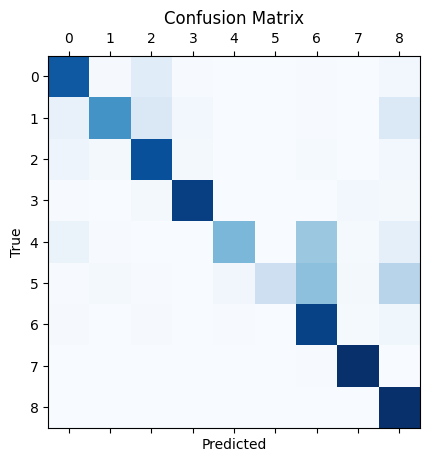

   overall_precision  overall_recall  overall_f1  overall_accuracy
0           0.810494        0.831445    0.820836          0.966728

                   LOC        MISC          ORG          PER
precision     0.836556    0.753759     0.700990     0.938377
recall        0.803957    0.571225     0.852498     0.951144
f1            0.819933    0.649919     0.769356     0.944717
number     1668.000000  702.000000  1661.000000  1617.000000

end of run
---------------------------------------------------
---------------------------------------------------
starting run on training set of 19%



Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['cl

{'eval_loss': 2.126650333404541, 'eval_precision': 0.01786127613610061, 'eval_recall': 0.08197592067988668, 'eval_f1': 0.029331643965790306, 'eval_accuracy': 0.19881554861634543, 'eval_runtime': 7.3213, 'eval_samples_per_second': 471.639, 'eval_steps_per_second': 7.376, 'epoch': 0.01}



  0%|          | 3/835 [00:14<1:12:10,  5.21s/it]

{'eval_loss': 2.1230523586273193, 'eval_precision': 0.017981979182849155, 'eval_recall': 0.08197592067988668, 'eval_f1': 0.029494203083195312, 'eval_accuracy': 0.20450091525788736, 'eval_runtime': 7.1019, 'eval_samples_per_second': 486.211, 'eval_steps_per_second': 7.604, 'epoch': 0.01}



  0%|          | 4/835 [00:21<1:22:28,  5.95s/it]

{'eval_loss': 2.1161091327667236, 'eval_precision': 0.018165375692997286, 'eval_recall': 0.08179886685552408, 'eval_f1': 0.02972877320549532, 'eval_accuracy': 0.21604393237859373, 'eval_runtime': 7.1118, 'eval_samples_per_second': 485.534, 'eval_steps_per_second': 7.593, 'epoch': 0.02}



  1%|          | 5/835 [00:29<1:28:10,  6.37s/it]

{'eval_loss': 2.1057307720184326, 'eval_precision': 0.01827582060839245, 'eval_recall': 0.08073654390934844, 'eval_f1': 0.02980489558482303, 'eval_accuracy': 0.23262625174975773, 'eval_runtime': 7.0637, 'eval_samples_per_second': 488.834, 'eval_steps_per_second': 7.645, 'epoch': 0.02}



  1%|          | 6/835 [00:36<1:31:32,  6.63s/it]

{'eval_loss': 2.0918405055999756, 'eval_precision': 0.01895049750216754, 'eval_recall': 0.08126770538243626, 'eval_f1': 0.030734206033010816, 'eval_accuracy': 0.2565952406589857, 'eval_runtime': 7.0355, 'eval_samples_per_second': 490.796, 'eval_steps_per_second': 7.675, 'epoch': 0.03}



  1%|          | 7/835 [00:43<1:33:54,  6.80s/it]

{'eval_loss': 2.0744876861572266, 'eval_precision': 0.01997079539598007, 'eval_recall': 0.0823300283286119, 'eval_f1': 0.03214433844877644, 'eval_accuracy': 0.28784322170776355, 'eval_runtime': 7.0836, 'eval_samples_per_second': 487.461, 'eval_steps_per_second': 7.623, 'epoch': 0.04}



  1%|          | 8/835 [00:50<1:36:11,  6.98s/it]

{'eval_loss': 2.0538201332092285, 'eval_precision': 0.021191632254844127, 'eval_recall': 0.0826841359773371, 'eval_f1': 0.033736680512913134, 'eval_accuracy': 0.326865510929256, 'eval_runtime': 7.2368, 'eval_samples_per_second': 477.147, 'eval_steps_per_second': 7.462, 'epoch': 0.04}



  1%|          | 9/835 [00:57<1:36:46,  7.03s/it]

{'eval_loss': 2.0297083854675293, 'eval_precision': 0.022490507253431994, 'eval_recall': 0.08179886685552408, 'eval_f1': 0.03528064146620848, 'eval_accuracy': 0.37101324432001725, 'eval_runtime': 7.0416, 'eval_samples_per_second': 490.369, 'eval_steps_per_second': 7.669, 'epoch': 0.05}



  1%|          | 10/835 [01:05<1:37:30,  7.09s/it]

{'eval_loss': 2.002647638320923, 'eval_precision': 0.02463264760886989, 'eval_recall': 0.08162181303116148, 'eval_f1': 0.03784427205188195, 'eval_accuracy': 0.42175083449983847, 'eval_runtime': 7.1072, 'eval_samples_per_second': 485.843, 'eval_steps_per_second': 7.598, 'epoch': 0.05}



  1%|          | 10/835 [01:12<1:37:30,  7.09s/it]

{'eval_loss': 1.9725877046585083, 'eval_precision': 0.027814253312641757, 'eval_recall': 0.0825070821529745, 'eval_f1': 0.04160342826533345, 'eval_accuracy': 0.47589103047270376, 'eval_runtime': 7.0184, 'eval_samples_per_second': 491.996, 'eval_steps_per_second': 7.694, 'epoch': 0.06}


  1%|▏         | 12/835 [01:20<1:40:19,  7.31s/it]

{'eval_loss': 1.9392805099487305, 'eval_precision': 0.031803097345132744, 'eval_recall': 0.08144475920679886, 'eval_f1': 0.045743834526650755, 'eval_accuracy': 0.5333692257995046, 'eval_runtime': 7.0072, 'eval_samples_per_second': 492.781, 'eval_steps_per_second': 7.706, 'epoch': 0.07}



  2%|▏         | 13/835 [01:27<1:39:16,  7.25s/it]

{'eval_loss': 1.9030120372772217, 'eval_precision': 0.03476331360946745, 'eval_recall': 0.07489376770538243, 'eval_f1': 0.04748540637629097, 'eval_accuracy': 0.5873371379347475, 'eval_runtime': 6.9889, 'eval_samples_per_second': 494.068, 'eval_steps_per_second': 7.727, 'epoch': 0.07}



  2%|▏         | 14/835 [01:34<1:38:28,  7.20s/it]

{'eval_loss': 1.863937258720398, 'eval_precision': 0.03758785779769787, 'eval_recall': 0.0653328611898017, 'eval_f1': 0.04772065955383122, 'eval_accuracy': 0.6412619791105847, 'eval_runtime': 6.973, 'eval_samples_per_second': 495.197, 'eval_steps_per_second': 7.744, 'epoch': 0.08}



  2%|▏         | 15/835 [01:41<1:38:19,  7.19s/it]

{'eval_loss': 1.8221527338027954, 'eval_precision': 0.03293531032672878, 'eval_recall': 0.044440509915014165, 'eval_f1': 0.03783254201522345, 'eval_accuracy': 0.6862280607300527, 'eval_runtime': 7.0823, 'eval_samples_per_second': 487.556, 'eval_steps_per_second': 7.625, 'epoch': 0.08}



  2%|▏         | 16/835 [01:48<1:37:42,  7.16s/it]

{'eval_loss': 1.7775413990020752, 'eval_precision': 0.03255895811334037, 'eval_recall': 0.032754957507082155, 'eval_f1': 0.03265666372462489, 'eval_accuracy': 0.7247334984386777, 'eval_runtime': 6.943, 'eval_samples_per_second': 497.334, 'eval_steps_per_second': 7.778, 'epoch': 0.09}



  2%|▏         | 17/835 [01:55<1:37:17,  7.14s/it]

{'eval_loss': 1.7299652099609375, 'eval_precision': 0.028481012658227847, 'eval_recall': 0.02071529745042493, 'eval_f1': 0.023985239852398525, 'eval_accuracy': 0.7542371056315279, 'eval_runtime': 6.9578, 'eval_samples_per_second': 496.274, 'eval_steps_per_second': 7.761, 'epoch': 0.1}



  2%|▏         | 18/835 [02:02<1:36:57,  7.12s/it]

{'eval_loss': 1.679991364479065, 'eval_precision': 0.026510067114093958, 'eval_recall': 0.013987252124645893, 'eval_f1': 0.018312471024571165, 'eval_accuracy': 0.7749757725853343, 'eval_runtime': 6.9633, 'eval_samples_per_second': 495.885, 'eval_steps_per_second': 7.755, 'epoch': 0.1}



  2%|▏         | 19/835 [02:10<1:36:35,  7.10s/it]

{'eval_loss': 1.627099871635437, 'eval_precision': 0.025059101654846337, 'eval_recall': 0.009383852691218131, 'eval_f1': 0.01365451500708489, 'eval_accuracy': 0.7898137181005707, 'eval_runtime': 6.9644, 'eval_samples_per_second': 495.805, 'eval_steps_per_second': 7.754, 'epoch': 0.11}



  2%|▏         | 20/835 [02:17<1:36:24,  7.10s/it]

{'eval_loss': 1.5722533464431763, 'eval_precision': 0.02356687898089172, 'eval_recall': 0.006550991501416431, 'eval_f1': 0.010252147409254642, 'eval_accuracy': 0.7993754710886185, 'eval_runtime': 6.95, 'eval_samples_per_second': 496.836, 'eval_steps_per_second': 7.77, 'epoch': 0.11}



  2%|▏         | 20/835 [02:24<1:36:24,  7.10s/it]

{'eval_loss': 1.5154634714126587, 'eval_precision': 0.0213857998289136, 'eval_recall': 0.004426345609065156, 'eval_f1': 0.0073346046648085665, 'eval_accuracy': 0.8060083988370841, 'eval_runtime': 6.975, 'eval_samples_per_second': 495.056, 'eval_steps_per_second': 7.742, 'epoch': 0.12}


  3%|▎         | 22/835 [02:32<1:38:31,  7.27s/it]

{'eval_loss': 1.4570846557617188, 'eval_precision': 0.014510278113663845, 'eval_recall': 0.002124645892351275, 'eval_f1': 0.0037065637065637064, 'eval_accuracy': 0.8118445138365457, 'eval_runtime': 6.9365, 'eval_samples_per_second': 497.799, 'eval_steps_per_second': 7.785, 'epoch': 0.13}



  3%|▎         | 23/835 [02:39<1:37:55,  7.24s/it]

{'eval_loss': 1.396737813949585, 'eval_precision': 0.01486988847583643, 'eval_recall': 0.00141643059490085, 'eval_f1': 0.0025864856126737797, 'eval_accuracy': 0.8167546032087865, 'eval_runtime': 7.0558, 'eval_samples_per_second': 489.382, 'eval_steps_per_second': 7.653, 'epoch': 0.13}



  3%|▎         | 24/835 [02:46<1:36:54,  7.17s/it]

{'eval_loss': 1.3350437879562378, 'eval_precision': 0.015873015873015872, 'eval_recall': 0.0008852691218130312, 'eval_f1': 0.0016770082173402647, 'eval_accuracy': 0.8206309895552923, 'eval_runtime': 6.9295, 'eval_samples_per_second': 498.306, 'eval_steps_per_second': 7.793, 'epoch': 0.14}



  3%|▎         | 25/835 [02:53<1:36:13,  7.13s/it]

{'eval_loss': 1.272483229637146, 'eval_precision': 0.027624309392265192, 'eval_recall': 0.0008852691218130312, 'eval_f1': 0.0017155601303825698, 'eval_accuracy': 0.8227199310864649, 'eval_runtime': 6.9378, 'eval_samples_per_second': 497.706, 'eval_steps_per_second': 7.783, 'epoch': 0.14}



  3%|▎         | 26/835 [03:00<1:35:49,  7.11s/it]

{'eval_loss': 1.2098758220672607, 'eval_precision': 0.021739130434782608, 'eval_recall': 0.0003541076487252125, 'eval_f1': 0.000696864111498258, 'eval_accuracy': 0.8240551308280392, 'eval_runtime': 6.9549, 'eval_samples_per_second': 496.483, 'eval_steps_per_second': 7.764, 'epoch': 0.15}


/home/ronen/Documents/college/NNForNLP/workshop_1/.conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  3%|▎         | 27/835 [03:07<1:35:31,  7.09s/it]

{'eval_loss': 1.1480844020843506, 'eval_precision': 0.043478260869565216, 'eval_recall': 0.0003541076487252125, 'eval_f1': 0.0007024938531787848, 'eval_accuracy': 0.8247873371379347, 'eval_runtime': 6.9561, 'eval_samples_per_second': 496.397, 'eval_steps_per_second': 7.763, 'epoch': 0.16}



  3%|▎         | 28/835 [03:14<1:35:08,  7.07s/it]

{'eval_loss': 1.087471604347229, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8251749757725854, 'eval_runtime': 6.9215, 'eval_samples_per_second': 498.883, 'eval_steps_per_second': 7.802, 'epoch': 0.16}



  3%|▎         | 29/835 [03:21<1:35:17,  7.09s/it]

{'eval_loss': 1.0295259952545166, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.825218046731991, 'eval_runtime': 7.0375, 'eval_samples_per_second': 490.658, 'eval_steps_per_second': 7.673, 'epoch': 0.17}



  4%|▎         | 30/835 [03:28<1:35:06,  7.09s/it]

{'eval_loss': 0.9762471318244934, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8252826531710994, 'eval_runtime': 6.9918, 'eval_samples_per_second': 493.865, 'eval_steps_per_second': 7.723, 'epoch': 0.17}


/home/ronen/Documents/college/NNForNLP/workshop_1/.conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  4%|▎         | 30/835 [03:35<1:35:06,  7.09s/it]

{'eval_loss': 0.9293879866600037, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.9728, 'eval_samples_per_second': 495.213, 'eval_steps_per_second': 7.744, 'epoch': 0.18}


  4%|▎         | 31/835 [03:36<1:38:43,  7.37s/it]/home/ronen/Documents/college/NNForNLP/workshop_1/.conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ronen/Documents/college/NNForNLP/workshop_1/.conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  4%|▍         | 32/835 [03:43<1:37:11,  7.26s/it]

{'eval_loss': 0.8906504511833191, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.9336, 'eval_samples_per_second': 498.009, 'eval_steps_per_second': 7.788, 'epoch': 0.19}



  4%|▍         | 33/835 [03:50<1:36:10,  7.20s/it]

{'eval_loss': 0.8616135120391846, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.9472, 'eval_samples_per_second': 497.035, 'eval_steps_per_second': 7.773, 'epoch': 0.19}



  4%|▍         | 34/835 [03:57<1:35:21,  7.14s/it]

{'eval_loss': 0.8428980112075806, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.9156, 'eval_samples_per_second': 499.306, 'eval_steps_per_second': 7.808, 'epoch': 0.2}



  4%|▍         | 35/835 [04:04<1:34:48,  7.11s/it]

{'eval_loss': 0.8334594964981079, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.92, 'eval_samples_per_second': 498.99, 'eval_steps_per_second': 7.803, 'epoch': 0.2}



  4%|▍         | 36/835 [04:12<1:34:52,  7.12s/it]

{'eval_loss': 0.8296833038330078, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 7.0391, 'eval_samples_per_second': 490.545, 'eval_steps_per_second': 7.671, 'epoch': 0.21}



  4%|▍         | 37/835 [04:19<1:34:19,  7.09s/it]

{'eval_loss': 0.8264570832252502, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.9094, 'eval_samples_per_second': 499.751, 'eval_steps_per_second': 7.815, 'epoch': 0.22}



  5%|▍         | 38/835 [04:26<1:33:52,  7.07s/it]

{'eval_loss': 0.8182592391967773, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.9252, 'eval_samples_per_second': 498.617, 'eval_steps_per_second': 7.798, 'epoch': 0.22}



  5%|▍         | 39/835 [04:33<1:33:41,  7.06s/it]

{'eval_loss': 0.8028019666671753, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.9644, 'eval_samples_per_second': 495.806, 'eval_steps_per_second': 7.754, 'epoch': 0.23}



  5%|▍         | 40/835 [04:40<1:33:33,  7.06s/it]

{'eval_loss': 0.784209668636322, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.9534, 'eval_samples_per_second': 496.588, 'eval_steps_per_second': 7.766, 'epoch': 0.23}



  5%|▍         | 40/835 [04:47<1:33:33,  7.06s/it]

{'eval_loss': 0.7631076574325562, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.9402, 'eval_samples_per_second': 497.535, 'eval_steps_per_second': 7.781, 'epoch': 0.24}


  5%|▍         | 41/835 [04:48<1:37:14,  7.35s/it]/home/ronen/Documents/college/NNForNLP/workshop_1/.conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ronen/Documents/college/NNForNLP/workshop_1/.conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  5%|▌         | 42/835 [04:55<1:36:06,  7.27s/it]

{'eval_loss': 0.7371980547904968, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.9718, 'eval_samples_per_second': 495.284, 'eval_steps_per_second': 7.746, 'epoch': 0.25}



  5%|▌         | 43/835 [05:02<1:34:58,  7.19s/it]

{'eval_loss': 0.7099118828773499, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.9382, 'eval_samples_per_second': 497.68, 'eval_steps_per_second': 7.783, 'epoch': 0.25}



  5%|▌         | 44/835 [05:09<1:34:38,  7.18s/it]

{'eval_loss': 0.6852686405181885, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 7.0511, 'eval_samples_per_second': 489.708, 'eval_steps_per_second': 7.658, 'epoch': 0.26}



  5%|▌         | 45/835 [05:16<1:33:52,  7.13s/it]

{'eval_loss': 0.6658798456192017, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.9142, 'eval_samples_per_second': 499.404, 'eval_steps_per_second': 7.81, 'epoch': 0.26}



  6%|▌         | 46/835 [05:23<1:33:19,  7.10s/it]

{'eval_loss': 0.6495595574378967, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.9241, 'eval_samples_per_second': 498.694, 'eval_steps_per_second': 7.799, 'epoch': 0.27}



  6%|▌         | 47/835 [05:30<1:32:54,  7.07s/it]

{'eval_loss': 0.6354343295097351, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.9064, 'eval_samples_per_second': 499.974, 'eval_steps_per_second': 7.819, 'epoch': 0.28}



  6%|▌         | 48/835 [05:37<1:32:47,  7.07s/it]

{'eval_loss': 0.6199690103530884, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.9734, 'eval_samples_per_second': 495.17, 'eval_steps_per_second': 7.744, 'epoch': 0.28}



  6%|▌         | 49/835 [05:44<1:32:33,  7.07s/it]

{'eval_loss': 0.6026133298873901, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 6.971, 'eval_samples_per_second': 495.34, 'eval_steps_per_second': 7.746, 'epoch': 0.29}



  6%|▌         | 50/835 [05:51<1:32:29,  7.07s/it]

{'eval_loss': 0.5838021039962769, 'eval_precision': 1.0, 'eval_recall': 0.000708215297450425, 'eval_f1': 0.0014154281670205238, 'eval_accuracy': 0.8253903305696134, 'eval_runtime': 6.9751, 'eval_samples_per_second': 495.045, 'eval_steps_per_second': 7.742, 'epoch': 0.29}



  6%|▌         | 50/835 [05:58<1:32:29,  7.07s/it]

{'eval_loss': 0.5642213821411133, 'eval_precision': 0.46153846153846156, 'eval_recall': 0.0010623229461756375, 'eval_f1': 0.0021197668256491787, 'eval_accuracy': 0.8255626144072359, 'eval_runtime': 7.0896, 'eval_samples_per_second': 487.049, 'eval_steps_per_second': 7.617, 'epoch': 0.3}


  6%|▌         | 51/835 [05:59<1:36:42,  7.40s/it]/home/ronen/Documents/college/NNForNLP/workshop_1/.conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  6%|▌         | 52/835 [06:06<1:35:19,  7.30s/it]

{'eval_loss': 0.5452079176902771, 'eval_precision': 0.4222222222222222, 'eval_recall': 0.0033640226628895184, 'eval_f1': 0.006674863867907957, 'eval_accuracy': 0.8261010013998061, 'eval_runtime': 6.9644, 'eval_samples_per_second': 495.804, 'eval_steps_per_second': 7.754, 'epoch': 0.31}



  6%|▋         | 53/835 [06:14<1:34:18,  7.24s/it]

{'eval_loss': 0.5274690389633179, 'eval_precision': 0.4827586206896552, 'eval_recall': 0.014872521246458924, 'eval_f1': 0.02885606320851941, 'eval_accuracy': 0.82827608484979, 'eval_runtime': 6.9705, 'eval_samples_per_second': 495.376, 'eval_steps_per_second': 7.747, 'epoch': 0.31}



  6%|▋         | 54/835 [06:21<1:33:51,  7.21s/it]

{'eval_loss': 0.5107759237289429, 'eval_precision': 0.5617977528089888, 'eval_recall': 0.044263456090651555, 'eval_f1': 0.08206138191367142, 'eval_accuracy': 0.8326908581888661, 'eval_runtime': 7.0249, 'eval_samples_per_second': 491.538, 'eval_steps_per_second': 7.687, 'epoch': 0.32}



  7%|▋         | 55/835 [06:28<1:34:00,  7.23s/it]

{'eval_loss': 0.49457162618637085, 'eval_precision': 0.5402455661664393, 'eval_recall': 0.07011331444759207, 'eval_f1': 0.12411847672778563, 'eval_accuracy': 0.8367825993324002, 'eval_runtime': 7.1803, 'eval_samples_per_second': 480.898, 'eval_steps_per_second': 7.521, 'epoch': 0.32}



  7%|▋         | 56/835 [06:35<1:34:22,  7.27s/it]

{'eval_loss': 0.47947636246681213, 'eval_precision': 0.48538961038961037, 'eval_recall': 0.10587818696883852, 'eval_f1': 0.17383720930232557, 'eval_accuracy': 0.8435447399590826, 'eval_runtime': 7.2536, 'eval_samples_per_second': 476.042, 'eval_steps_per_second': 7.445, 'epoch': 0.33}



  7%|▋         | 57/835 [06:42<1:33:36,  7.22s/it]

{'eval_loss': 0.46554049849510193, 'eval_precision': 0.4398950131233596, 'eval_recall': 0.14837110481586402, 'eval_f1': 0.22189858334436646, 'eval_accuracy': 0.8519651125228814, 'eval_runtime': 6.995, 'eval_samples_per_second': 493.641, 'eval_steps_per_second': 7.72, 'epoch': 0.34}



  7%|▋         | 58/835 [06:50<1:33:21,  7.21s/it]

{'eval_loss': 0.4520215690135956, 'eval_precision': 0.4037626628075253, 'eval_recall': 0.19759206798866855, 'eval_f1': 0.2653352353780314, 'eval_accuracy': 0.8624528911381502, 'eval_runtime': 7.098, 'eval_samples_per_second': 486.473, 'eval_steps_per_second': 7.608, 'epoch': 0.34}



  7%|▋         | 59/835 [06:57<1:32:34,  7.16s/it]

{'eval_loss': 0.43983951210975647, 'eval_precision': 0.3797851831451391, 'eval_recall': 0.244157223796034, 'eval_f1': 0.29723030498976183, 'eval_accuracy': 0.8721653924841176, 'eval_runtime': 6.9483, 'eval_samples_per_second': 496.96, 'eval_steps_per_second': 7.772, 'epoch': 0.35}



  7%|▋         | 60/835 [07:04<1:32:03,  7.13s/it]

{'eval_loss': 0.42857667803764343, 'eval_precision': 0.3581364539633473, 'eval_recall': 0.2871813031161473, 'eval_f1': 0.3187579836887099, 'eval_accuracy': 0.8818132873909766, 'eval_runtime': 6.9565, 'eval_samples_per_second': 496.367, 'eval_steps_per_second': 7.762, 'epoch': 0.35}



  7%|▋         | 60/835 [07:11<1:32:03,  7.13s/it]

{'eval_loss': 0.41760629415512085, 'eval_precision': 0.34486735870818913, 'eval_recall': 0.3176345609065156, 'eval_f1': 0.33069124423963137, 'eval_accuracy': 0.8881877893830085, 'eval_runtime': 6.9784, 'eval_samples_per_second': 494.815, 'eval_steps_per_second': 7.738, 'epoch': 0.36}


  7%|▋         | 62/835 [07:19<1:34:14,  7.32s/it]

{'eval_loss': 0.4068028926849365, 'eval_precision': 0.342586085734364, 'eval_recall': 0.3452549575070821, 'eval_f1': 0.3439153439153439, 'eval_accuracy': 0.8933132335522774, 'eval_runtime': 7.0306, 'eval_samples_per_second': 491.136, 'eval_steps_per_second': 7.681, 'epoch': 0.37}



  8%|▊         | 63/835 [07:26<1:33:23,  7.26s/it]

{'eval_loss': 0.3967842161655426, 'eval_precision': 0.34293236794470955, 'eval_recall': 0.3689801699716714, 'eval_f1': 0.3554797441364606, 'eval_accuracy': 0.8971465489393776, 'eval_runtime': 7.026, 'eval_samples_per_second': 491.461, 'eval_steps_per_second': 7.686, 'epoch': 0.37}



  8%|▊         | 64/835 [07:33<1:32:38,  7.21s/it]

{'eval_loss': 0.3873952329158783, 'eval_precision': 0.3457430097392397, 'eval_recall': 0.3896954674220963, 'eval_f1': 0.36640585983019813, 'eval_accuracy': 0.8999676967804457, 'eval_runtime': 6.9948, 'eval_samples_per_second': 493.653, 'eval_steps_per_second': 7.72, 'epoch': 0.38}



  8%|▊         | 65/835 [07:40<1:32:03,  7.17s/it]

{'eval_loss': 0.3789047598838806, 'eval_precision': 0.34577897735792473, 'eval_recall': 0.40828611898017, 'eval_f1': 0.3744418283672973, 'eval_accuracy': 0.9022289221492409, 'eval_runtime': 6.9757, 'eval_samples_per_second': 495.004, 'eval_steps_per_second': 7.741, 'epoch': 0.38}



  8%|▊         | 66/835 [07:47<1:32:19,  7.20s/it]

{'eval_loss': 0.3704240322113037, 'eval_precision': 0.3437773243952201, 'eval_recall': 0.4176699716713881, 'eval_f1': 0.37713828936850524, 'eval_accuracy': 0.9037364057284376, 'eval_runtime': 7.1744, 'eval_samples_per_second': 481.294, 'eval_steps_per_second': 7.527, 'epoch': 0.39}



  8%|▊         | 67/835 [07:55<1:31:57,  7.18s/it]

{'eval_loss': 0.3623258173465729, 'eval_precision': 0.3493837775867011, 'eval_recall': 0.431657223796034, 'eval_f1': 0.38618723269444005, 'eval_accuracy': 0.9054377086249596, 'eval_runtime': 7.0416, 'eval_samples_per_second': 490.371, 'eval_steps_per_second': 7.669, 'epoch': 0.4}



  8%|▊         | 68/835 [08:02<1:31:28,  7.16s/it]

{'eval_loss': 0.35479536652565, 'eval_precision': 0.3516110797060486, 'eval_recall': 0.4405099150141643, 'eval_f1': 0.39107198994027037, 'eval_accuracy': 0.9064068052115861, 'eval_runtime': 6.9773, 'eval_samples_per_second': 494.89, 'eval_steps_per_second': 7.739, 'epoch': 0.4}



  8%|▊         | 69/835 [08:09<1:31:09,  7.14s/it]

{'eval_loss': 0.3474715054035187, 'eval_precision': 0.35500631933717175, 'eval_recall': 0.4475920679886686, 'eval_f1': 0.39595896311379125, 'eval_accuracy': 0.9072897598794013, 'eval_runtime': 6.9892, 'eval_samples_per_second': 494.048, 'eval_steps_per_second': 7.726, 'epoch': 0.41}



  8%|▊         | 70/835 [08:16<1:30:46,  7.12s/it]

{'eval_loss': 0.34091854095458984, 'eval_precision': 0.3571826280623608, 'eval_recall': 0.4543201133144476, 'eval_f1': 0.3999376558603492, 'eval_accuracy': 0.908000430709594, 'eval_runtime': 6.9793, 'eval_samples_per_second': 494.75, 'eval_steps_per_second': 7.737, 'epoch': 0.41}



  8%|▊         | 70/835 [08:23<1:30:46,  7.12s/it]

{'eval_loss': 0.334313303232193, 'eval_precision': 0.36353514265831594, 'eval_recall': 0.46246458923512745, 'eval_f1': 0.4070755084547651, 'eval_accuracy': 0.9088403144180036, 'eval_runtime': 6.9751, 'eval_samples_per_second': 495.049, 'eval_steps_per_second': 7.742, 'epoch': 0.42}


  9%|▊         | 72/835 [08:31<1:32:37,  7.28s/it]

{'eval_loss': 0.3271157145500183, 'eval_precision': 0.38231966053748234, 'eval_recall': 0.47857648725212465, 'eval_f1': 0.4250668344079258, 'eval_accuracy': 0.9117045332184774, 'eval_runtime': 6.9707, 'eval_samples_per_second': 495.359, 'eval_steps_per_second': 7.747, 'epoch': 0.43}



  9%|▊         | 73/835 [08:38<1:31:57,  7.24s/it]

{'eval_loss': 0.3209380805492401, 'eval_precision': 0.4015577672003462, 'eval_recall': 0.49291784702549574, 'eval_f1': 0.44257213258087597, 'eval_accuracy': 0.9141165069451922, 'eval_runtime': 7.0635, 'eval_samples_per_second': 488.854, 'eval_steps_per_second': 7.645, 'epoch': 0.43}



  9%|▉         | 74/835 [08:45<1:31:10,  7.19s/it]

{'eval_loss': 0.31537050008773804, 'eval_precision': 0.4272189349112426, 'eval_recall': 0.5113314447592068, 'eval_f1': 0.4655061250805932, 'eval_accuracy': 0.9172391515020997, 'eval_runtime': 6.9536, 'eval_samples_per_second': 496.575, 'eval_steps_per_second': 7.766, 'epoch': 0.44}



  9%|▉         | 75/835 [08:52<1:30:33,  7.15s/it]

{'eval_loss': 0.30979883670806885, 'eval_precision': 0.44466165413533837, 'eval_recall': 0.5235481586402266, 'eval_f1': 0.48089120182143447, 'eval_accuracy': 0.9192634865941639, 'eval_runtime': 6.9662, 'eval_samples_per_second': 495.678, 'eval_steps_per_second': 7.752, 'epoch': 0.44}



  9%|▉         | 76/835 [08:59<1:30:06,  7.12s/it]

{'eval_loss': 0.3045021593570709, 'eval_precision': 0.46119902617163727, 'eval_recall': 0.5366501416430595, 'eval_f1': 0.4960720130932897, 'eval_accuracy': 0.9210724668892, 'eval_runtime': 6.9536, 'eval_samples_per_second': 496.575, 'eval_steps_per_second': 7.766, 'epoch': 0.45}



  9%|▉         | 77/835 [09:06<1:29:51,  7.11s/it]

{'eval_loss': 0.2988157570362091, 'eval_precision': 0.4780540208717004, 'eval_recall': 0.5515226628895185, 'eval_f1': 0.5121670503123972, 'eval_accuracy': 0.9231829439000754, 'eval_runtime': 6.9485, 'eval_samples_per_second': 496.945, 'eval_steps_per_second': 7.772, 'epoch': 0.46}



  9%|▉         | 78/835 [09:13<1:29:32,  7.10s/it]

{'eval_loss': 0.2919483780860901, 'eval_precision': 0.494834232845027, 'eval_recall': 0.5681657223796034, 'eval_f1': 0.5289705761147284, 'eval_accuracy': 0.9253149563906536, 'eval_runtime': 6.9592, 'eval_samples_per_second': 496.175, 'eval_steps_per_second': 7.759, 'epoch': 0.46}



  9%|▉         | 79/835 [09:20<1:29:13,  7.08s/it]

{'eval_loss': 0.28499728441238403, 'eval_precision': 0.5062883435582822, 'eval_recall': 0.5844546742209632, 'eval_f1': 0.5425706771860619, 'eval_accuracy': 0.9274685043609346, 'eval_runtime': 6.957, 'eval_samples_per_second': 496.331, 'eval_steps_per_second': 7.762, 'epoch': 0.47}



 10%|▉         | 80/835 [09:28<1:29:31,  7.11s/it]

{'eval_loss': 0.27783772349357605, 'eval_precision': 0.5111481874715608, 'eval_recall': 0.5966713881019831, 'eval_f1': 0.5506086104076464, 'eval_accuracy': 0.9285452783460751, 'eval_runtime': 7.0761, 'eval_samples_per_second': 487.979, 'eval_steps_per_second': 7.631, 'epoch': 0.47}



 10%|▉         | 80/835 [09:35<1:29:31,  7.11s/it]

{'eval_loss': 0.27119186520576477, 'eval_precision': 0.5164439104970716, 'eval_recall': 0.6088881019830028, 'eval_f1': 0.5588689363776712, 'eval_accuracy': 0.9300312264455691, 'eval_runtime': 6.9529, 'eval_samples_per_second': 496.624, 'eval_steps_per_second': 7.766, 'epoch': 0.48}


 10%|▉         | 82/835 [09:43<1:31:14,  7.27s/it]

{'eval_loss': 0.26655682921409607, 'eval_precision': 0.520131225767969, 'eval_recall': 0.6175637393767706, 'eval_f1': 0.5646754087744861, 'eval_accuracy': 0.9304619360396252, 'eval_runtime': 6.9429, 'eval_samples_per_second': 497.342, 'eval_steps_per_second': 7.778, 'epoch': 0.49}



 10%|▉         | 83/835 [09:50<1:30:20,  7.21s/it]

{'eval_loss': 0.2630831301212311, 'eval_precision': 0.5247362947556083, 'eval_recall': 0.6253541076487252, 'eval_f1': 0.5706438322966315, 'eval_accuracy': 0.9316463874232799, 'eval_runtime': 6.9649, 'eval_samples_per_second': 495.772, 'eval_steps_per_second': 7.753, 'epoch': 0.49}



 10%|█         | 84/835 [09:57<1:29:39,  7.16s/it]

{'eval_loss': 0.2599523067474365, 'eval_precision': 0.526440177252585, 'eval_recall': 0.6310198300283286, 'eval_f1': 0.5740054759220486, 'eval_accuracy': 0.9318402067406052, 'eval_runtime': 6.9518, 'eval_samples_per_second': 496.709, 'eval_steps_per_second': 7.768, 'epoch': 0.5}



 10%|█         | 85/835 [10:04<1:29:10,  7.13s/it]

{'eval_loss': 0.2537267804145813, 'eval_precision': 0.5397727272727273, 'eval_recall': 0.6391643059490085, 'eval_f1': 0.5852788586251622, 'eval_accuracy': 0.9342952514267255, 'eval_runtime': 6.9552, 'eval_samples_per_second': 496.466, 'eval_steps_per_second': 7.764, 'epoch': 0.5}



 10%|█         | 86/835 [10:11<1:28:50,  7.12s/it]

{'eval_loss': 0.2460014820098877, 'eval_precision': 0.5513933302878027, 'eval_recall': 0.6411118980169972, 'eval_f1': 0.5928776094965207, 'eval_accuracy': 0.9359965543232476, 'eval_runtime': 6.9707, 'eval_samples_per_second': 495.362, 'eval_steps_per_second': 7.747, 'epoch': 0.51}



 10%|█         | 87/835 [10:18<1:28:37,  7.11s/it]

{'eval_loss': 0.23924198746681213, 'eval_precision': 0.5692450208429829, 'eval_recall': 0.6527974504249292, 'eval_f1': 0.6081649484536082, 'eval_accuracy': 0.9387530957252073, 'eval_runtime': 6.9711, 'eval_samples_per_second': 495.332, 'eval_steps_per_second': 7.746, 'epoch': 0.51}



 11%|█         | 88/835 [10:25<1:28:46,  7.13s/it]

{'eval_loss': 0.2327483892440796, 'eval_precision': 0.5894405043341213, 'eval_recall': 0.6621813031161473, 'eval_f1': 0.623697156674727, 'eval_accuracy': 0.9412512113707333, 'eval_runtime': 7.0854, 'eval_samples_per_second': 487.337, 'eval_steps_per_second': 7.621, 'epoch': 0.52}



 11%|█         | 89/835 [10:32<1:28:33,  7.12s/it]

{'eval_loss': 0.2280341386795044, 'eval_precision': 0.610238133808521, 'eval_recall': 0.6669617563739377, 'eval_f1': 0.6373403265375179, 'eval_accuracy': 0.9422849143964682, 'eval_runtime': 6.9927, 'eval_samples_per_second': 493.798, 'eval_steps_per_second': 7.722, 'epoch': 0.53}



 11%|█         | 90/835 [10:39<1:28:15,  7.11s/it]

{'eval_loss': 0.22464381158351898, 'eval_precision': 0.6208092485549133, 'eval_recall': 0.6655453257790368, 'eval_f1': 0.6423993847731352, 'eval_accuracy': 0.9425002691934963, 'eval_runtime': 6.9729, 'eval_samples_per_second': 495.206, 'eval_steps_per_second': 7.744, 'epoch': 0.53}



 11%|█         | 90/835 [10:46<1:28:15,  7.11s/it]

{'eval_loss': 0.2211284041404724, 'eval_precision': 0.6294940079893475, 'eval_recall': 0.6696175637393768, 'eval_f1': 0.648936170212766, 'eval_accuracy': 0.9430171207063638, 'eval_runtime': 6.9856, 'eval_samples_per_second': 494.301, 'eval_steps_per_second': 7.73, 'epoch': 0.54}


 11%|█         | 92/835 [10:54<1:30:27,  7.30s/it]

{'eval_loss': 0.21936313807964325, 'eval_precision': 0.6321295983800203, 'eval_recall': 0.6632436260623229, 'eval_f1': 0.6473129428028339, 'eval_accuracy': 0.9423495208355767, 'eval_runtime': 6.9689, 'eval_samples_per_second': 495.487, 'eval_steps_per_second': 7.749, 'epoch': 0.54}



 11%|█         | 93/835 [11:02<1:29:40,  7.25s/it]

{'eval_loss': 0.21775875985622406, 'eval_precision': 0.6382724479344486, 'eval_recall': 0.6620042492917847, 'eval_f1': 0.6499217799409003, 'eval_accuracy': 0.9424356627543878, 'eval_runtime': 7.0177, 'eval_samples_per_second': 492.042, 'eval_steps_per_second': 7.695, 'epoch': 0.55}



 11%|█▏        | 94/835 [11:09<1:29:29,  7.25s/it]

{'eval_loss': 0.21510517597198486, 'eval_precision': 0.6445432774546699, 'eval_recall': 0.6671388101983002, 'eval_f1': 0.6556464242213329, 'eval_accuracy': 0.9429955852266609, 'eval_runtime': 7.1367, 'eval_samples_per_second': 483.834, 'eval_steps_per_second': 7.566, 'epoch': 0.56}



 11%|█▏        | 95/835 [11:16<1:28:40,  7.19s/it]

{'eval_loss': 0.21140705049037933, 'eval_precision': 0.6440591534931157, 'eval_recall': 0.6708569405099151, 'eval_f1': 0.6571849796201543, 'eval_accuracy': 0.9435770431786368, 'eval_runtime': 6.9807, 'eval_samples_per_second': 494.646, 'eval_steps_per_second': 7.736, 'epoch': 0.56}



 11%|█▏        | 96/835 [11:23<1:28:11,  7.16s/it]

{'eval_loss': 0.2078540027141571, 'eval_precision': 0.643121426168853, 'eval_recall': 0.6770538243626062, 'eval_f1': 0.6596515439020183, 'eval_accuracy': 0.9439862172929901, 'eval_runtime': 6.992, 'eval_samples_per_second': 493.848, 'eval_steps_per_second': 7.723, 'epoch': 0.57}



 12%|█▏        | 97/835 [11:30<1:27:41,  7.13s/it]

{'eval_loss': 0.20477378368377686, 'eval_precision': 0.6406639004149378, 'eval_recall': 0.68342776203966, 'eval_f1': 0.6613552642851024, 'eval_accuracy': 0.9442661785291268, 'eval_runtime': 6.9711, 'eval_samples_per_second': 495.333, 'eval_steps_per_second': 7.746, 'epoch': 0.57}



 12%|█▏        | 98/835 [11:37<1:27:29,  7.12s/it]

{'eval_loss': 0.20213252305984497, 'eval_precision': 0.6384868421052632, 'eval_recall': 0.6873229461756374, 'eval_f1': 0.6620054570259208, 'eval_accuracy': 0.9445030688058577, 'eval_runtime': 6.9915, 'eval_samples_per_second': 493.885, 'eval_steps_per_second': 7.724, 'epoch': 0.58}



 12%|█▏        | 99/835 [11:44<1:27:13,  7.11s/it]

{'eval_loss': 0.20146222412586212, 'eval_precision': 0.632191338073691, 'eval_recall': 0.6926345609065155, 'eval_f1': 0.6610341331530922, 'eval_accuracy': 0.9447399590825886, 'eval_runtime': 6.9868, 'eval_samples_per_second': 494.215, 'eval_steps_per_second': 7.729, 'epoch': 0.59}



 12%|█▏        | 100/835 [11:51<1:27:09,  7.11s/it]

{'eval_loss': 0.20148837566375732, 'eval_precision': 0.632110238743791, 'eval_recall': 0.6984773371104815, 'eval_f1': 0.6636386575826393, 'eval_accuracy': 0.9447399590825886, 'eval_runtime': 7.0253, 'eval_samples_per_second': 491.509, 'eval_steps_per_second': 7.687, 'epoch': 0.59}



 12%|█▏        | 100/835 [11:59<1:27:09,  7.11s/it]

{'eval_loss': 0.20248468220233917, 'eval_precision': 0.6283537069376092, 'eval_recall': 0.7007790368271954, 'eval_f1': 0.6625931196116179, 'eval_accuracy': 0.9443307849682352, 'eval_runtime': 7.1574, 'eval_samples_per_second': 482.439, 'eval_steps_per_second': 7.545, 'epoch': 0.6}


 12%|█▏        | 102/835 [12:07<1:30:42,  7.42s/it]

{'eval_loss': 0.20454536378383636, 'eval_precision': 0.6253943217665615, 'eval_recall': 0.7020184135977338, 'eval_f1': 0.6614948281614949, 'eval_accuracy': 0.944007752772693, 'eval_runtime': 7.2059, 'eval_samples_per_second': 479.188, 'eval_steps_per_second': 7.494, 'epoch': 0.6}



 12%|█▏        | 103/835 [12:14<1:29:45,  7.36s/it]

{'eval_loss': 0.20529812574386597, 'eval_precision': 0.6257438145944253, 'eval_recall': 0.7075070821529745, 'eval_f1': 0.6641183313943825, 'eval_accuracy': 0.9438354689350705, 'eval_runtime': 7.0599, 'eval_samples_per_second': 489.103, 'eval_steps_per_second': 7.649, 'epoch': 0.61}



 12%|█▏        | 104/835 [12:21<1:28:39,  7.28s/it]

{'eval_loss': 0.20420719683170319, 'eval_precision': 0.6270337922403004, 'eval_recall': 0.7096317280453258, 'eval_f1': 0.6657807308970101, 'eval_accuracy': 0.9441800366103155, 'eval_runtime': 6.9904, 'eval_samples_per_second': 493.964, 'eval_steps_per_second': 7.725, 'epoch': 0.62}



 13%|█▎        | 105/835 [12:28<1:27:52,  7.22s/it]

{'eval_loss': 0.20103919506072998, 'eval_precision': 0.6415331448319196, 'eval_recall': 0.7230878186968839, 'eval_f1': 0.6798734809389048, 'eval_accuracy': 0.9466781522558415, 'eval_runtime': 7.0132, 'eval_samples_per_second': 492.355, 'eval_steps_per_second': 7.7, 'epoch': 0.62}



 13%|█▎        | 106/835 [12:36<1:27:38,  7.21s/it]

{'eval_loss': 0.19659040868282318, 'eval_precision': 0.6492361001732556, 'eval_recall': 0.7298158640226629, 'eval_f1': 0.687171792948237, 'eval_accuracy': 0.947862603639496, 'eval_runtime': 7.0748, 'eval_samples_per_second': 488.072, 'eval_steps_per_second': 7.633, 'epoch': 0.63}



 13%|█▎        | 107/835 [12:43<1:27:10,  7.18s/it]

{'eval_loss': 0.19305938482284546, 'eval_precision': 0.65865232521354, 'eval_recall': 0.7372521246458924, 'eval_f1': 0.6957393483709273, 'eval_accuracy': 0.9495639065360181, 'eval_runtime': 7.0221, 'eval_samples_per_second': 491.73, 'eval_steps_per_second': 7.69, 'epoch': 0.63}



 13%|█▎        | 108/835 [12:50<1:27:31,  7.22s/it]

{'eval_loss': 0.1902598887681961, 'eval_precision': 0.6605839416058394, 'eval_recall': 0.7370750708215298, 'eval_f1': 0.6967364016736401, 'eval_accuracy': 0.9501453644879939, 'eval_runtime': 7.2209, 'eval_samples_per_second': 478.197, 'eval_steps_per_second': 7.478, 'epoch': 0.64}



 13%|█▎        | 109/835 [12:57<1:27:09,  7.20s/it]

{'eval_loss': 0.18683351576328278, 'eval_precision': 0.6668790823641867, 'eval_recall': 0.7411473087818697, 'eval_f1': 0.7020545073375263, 'eval_accuracy': 0.9517389899860019, 'eval_runtime': 7.043, 'eval_samples_per_second': 490.276, 'eval_steps_per_second': 7.667, 'epoch': 0.65}



 13%|█▎        | 110/835 [13:04<1:26:41,  7.18s/it]

{'eval_loss': 0.18434081971645355, 'eval_precision': 0.6718300862344299, 'eval_recall': 0.7448654390934845, 'eval_f1': 0.7064651553316541, 'eval_accuracy': 0.9527080865726284, 'eval_runtime': 7.0258, 'eval_samples_per_second': 491.478, 'eval_steps_per_second': 7.686, 'epoch': 0.65}



 13%|█▎        | 110/835 [13:11<1:26:41,  7.18s/it]

{'eval_loss': 0.1816091388463974, 'eval_precision': 0.6723417924831352, 'eval_recall': 0.7411473087818697, 'eval_f1': 0.7050699006232104, 'eval_accuracy': 0.9531172606869818, 'eval_runtime': 7.0112, 'eval_samples_per_second': 492.499, 'eval_steps_per_second': 7.702, 'epoch': 0.66}


 13%|█▎        | 112/835 [13:19<1:28:21,  7.33s/it]

{'eval_loss': 0.17947550117969513, 'eval_precision': 0.6746812974019687, 'eval_recall': 0.7402620396600567, 'eval_f1': 0.7059518784297171, 'eval_accuracy': 0.9539140734359858, 'eval_runtime': 6.9699, 'eval_samples_per_second': 495.419, 'eval_steps_per_second': 7.748, 'epoch': 0.66}



 14%|█▎        | 113/835 [13:27<1:27:29,  7.27s/it]

{'eval_loss': 0.17771272361278534, 'eval_precision': 0.6752868918700501, 'eval_recall': 0.7397308781869688, 'eval_f1': 0.7060414026193494, 'eval_accuracy': 0.9543663185097448, 'eval_runtime': 7.0091, 'eval_samples_per_second': 492.642, 'eval_steps_per_second': 7.704, 'epoch': 0.67}



 14%|█▎        | 114/835 [13:34<1:26:43,  7.22s/it]

{'eval_loss': 0.17651289701461792, 'eval_precision': 0.6784961918651758, 'eval_recall': 0.7413243626062322, 'eval_f1': 0.7085201793721974, 'eval_accuracy': 0.9550123829008291, 'eval_runtime': 7.0074, 'eval_samples_per_second': 492.768, 'eval_steps_per_second': 7.706, 'epoch': 0.68}



 14%|█▍        | 115/835 [13:41<1:26:10,  7.18s/it]

{'eval_loss': 0.17560067772865295, 'eval_precision': 0.6768509537665697, 'eval_recall': 0.7413243626062322, 'eval_f1': 0.7076221057968565, 'eval_accuracy': 0.9553784860557769, 'eval_runtime': 6.98, 'eval_samples_per_second': 494.7, 'eval_steps_per_second': 7.736, 'epoch': 0.68}



 14%|█▍        | 116/835 [13:48<1:26:07,  7.19s/it]

{'eval_loss': 0.17498165369033813, 'eval_precision': 0.6733441033925687, 'eval_recall': 0.7379603399433428, 'eval_f1': 0.704173002196317, 'eval_accuracy': 0.9549908474211263, 'eval_runtime': 7.0912, 'eval_samples_per_second': 486.942, 'eval_steps_per_second': 7.615, 'epoch': 0.69}



 14%|█▍        | 117/835 [13:55<1:25:35,  7.15s/it]

{'eval_loss': 0.1744723618030548, 'eval_precision': 0.6697779208239459, 'eval_recall': 0.7368980169971672, 'eval_f1': 0.7017366380037093, 'eval_accuracy': 0.9546678152255842, 'eval_runtime': 6.9675, 'eval_samples_per_second': 495.59, 'eval_steps_per_second': 7.75, 'epoch': 0.69}



 14%|█▍        | 118/835 [14:02<1:25:14,  7.13s/it]

{'eval_loss': 0.1733332723379135, 'eval_precision': 0.6698356429262005, 'eval_recall': 0.7360127478753541, 'eval_f1': 0.7013666272988022, 'eval_accuracy': 0.9546032087864758, 'eval_runtime': 6.9997, 'eval_samples_per_second': 493.307, 'eval_steps_per_second': 7.715, 'epoch': 0.7}



 14%|█▍        | 119/835 [14:09<1:24:50,  7.11s/it]

{'eval_loss': 0.1730298101902008, 'eval_precision': 0.6693975903614457, 'eval_recall': 0.7377832861189801, 'eval_f1': 0.7019287458940453, 'eval_accuracy': 0.9547754926240982, 'eval_runtime': 6.9729, 'eval_samples_per_second': 495.206, 'eval_steps_per_second': 7.744, 'epoch': 0.71}



 14%|█▍        | 120/835 [14:16<1:24:38,  7.10s/it]

{'eval_loss': 0.17309868335723877, 'eval_precision': 0.6713118692936089, 'eval_recall': 0.7420325779036827, 'eval_f1': 0.7049028677150786, 'eval_accuracy': 0.9548185635835038, 'eval_runtime': 6.9948, 'eval_samples_per_second': 493.656, 'eval_steps_per_second': 7.72, 'epoch': 0.71}



 14%|█▍        | 120/835 [14:23<1:24:38,  7.10s/it]

{'eval_loss': 0.171401709318161, 'eval_precision': 0.6807927811795037, 'eval_recall': 0.7480524079320113, 'eval_f1': 0.7128395478319555, 'eval_accuracy': 0.9557445892107247, 'eval_runtime': 6.9821, 'eval_samples_per_second': 494.55, 'eval_steps_per_second': 7.734, 'epoch': 0.72}


 15%|█▍        | 122/835 [14:31<1:26:45,  7.30s/it]

{'eval_loss': 0.1691003143787384, 'eval_precision': 0.6908353609083536, 'eval_recall': 0.75407223796034, 'eval_f1': 0.7210700076187252, 'eval_accuracy': 0.9561106923656725, 'eval_runtime': 6.9677, 'eval_samples_per_second': 495.57, 'eval_steps_per_second': 7.75, 'epoch': 0.72}



 15%|█▍        | 123/835 [14:39<1:26:22,  7.28s/it]

{'eval_loss': 0.16714318096637726, 'eval_precision': 0.7028132155708211, 'eval_recall': 0.7608002832861189, 'eval_f1': 0.7306580513518109, 'eval_accuracy': 0.9567782922364596, 'eval_runtime': 7.13, 'eval_samples_per_second': 484.289, 'eval_steps_per_second': 7.574, 'epoch': 0.73}



 15%|█▍        | 124/835 [14:46<1:25:50,  7.24s/it]

{'eval_loss': 0.1646646112203598, 'eval_precision': 0.7210343112879165, 'eval_recall': 0.7701841359773371, 'eval_f1': 0.7447992466398425, 'eval_accuracy': 0.9579412081404113, 'eval_runtime': 7.0653, 'eval_samples_per_second': 488.728, 'eval_steps_per_second': 7.643, 'epoch': 0.74}



 15%|█▍        | 125/835 [14:53<1:25:19,  7.21s/it]

{'eval_loss': 0.16295763850212097, 'eval_precision': 0.7352301255230126, 'eval_recall': 0.7777974504249292, 'eval_f1': 0.7559149961283661, 'eval_accuracy': 0.9586303434909013, 'eval_runtime': 7.0134, 'eval_samples_per_second': 492.343, 'eval_steps_per_second': 7.7, 'epoch': 0.74}



 15%|█▌        | 126/835 [15:00<1:25:01,  7.20s/it]

{'eval_loss': 0.16060999035835266, 'eval_precision': 0.7475088667454822, 'eval_recall': 0.7836402266288952, 'eval_f1': 0.7651482409888496, 'eval_accuracy': 0.9591471950037687, 'eval_runtime': 7.032, 'eval_samples_per_second': 491.041, 'eval_steps_per_second': 7.679, 'epoch': 0.75}



 15%|█▌        | 127/835 [15:07<1:24:38,  7.17s/it]

{'eval_loss': 0.15878477692604065, 'eval_precision': 0.7534804753820034, 'eval_recall': 0.7857648725212465, 'eval_f1': 0.7692841046975212, 'eval_accuracy': 0.9594056207602024, 'eval_runtime': 7.0208, 'eval_samples_per_second': 491.825, 'eval_steps_per_second': 7.691, 'epoch': 0.75}



 15%|█▌        | 128/835 [15:14<1:24:27,  7.17s/it]

{'eval_loss': 0.15658944845199585, 'eval_precision': 0.7574308165357021, 'eval_recall': 0.785056657223796, 'eval_f1': 0.7709963484611372, 'eval_accuracy': 0.9593840852804997, 'eval_runtime': 7.0603, 'eval_samples_per_second': 489.07, 'eval_steps_per_second': 7.648, 'epoch': 0.76}



 15%|█▌        | 129/835 [15:22<1:24:25,  7.17s/it]

{'eval_loss': 0.1551162600517273, 'eval_precision': 0.7604739010989011, 'eval_recall': 0.7841713881019831, 'eval_f1': 0.7721408647140866, 'eval_accuracy': 0.959341014321094, 'eval_runtime': 7.0841, 'eval_samples_per_second': 487.433, 'eval_steps_per_second': 7.623, 'epoch': 0.77}



 16%|█▌        | 130/835 [15:29<1:24:48,  7.22s/it]

{'eval_loss': 0.1540525108575821, 'eval_precision': 0.7672324211984759, 'eval_recall': 0.7843484419263456, 'eval_f1': 0.7756960252144984, 'eval_accuracy': 0.959685581996339, 'eval_runtime': 7.2188, 'eval_samples_per_second': 478.334, 'eval_steps_per_second': 7.48, 'epoch': 0.77}



 16%|█▌        | 130/835 [15:36<1:24:48,  7.22s/it]

{'eval_loss': 0.15357732772827148, 'eval_precision': 0.7729257641921398, 'eval_recall': 0.7834631728045326, 'eval_f1': 0.7781587971511474, 'eval_accuracy': 0.9598363303542586, 'eval_runtime': 6.9776, 'eval_samples_per_second': 494.873, 'eval_steps_per_second': 7.739, 'epoch': 0.78}


 16%|█▌        | 132/835 [15:44<1:26:19,  7.37s/it]

{'eval_loss': 0.15284106135368347, 'eval_precision': 0.7785776997366111, 'eval_recall': 0.785056657223796, 'eval_f1': 0.7818037556202063, 'eval_accuracy': 0.9602670399483149, 'eval_runtime': 7.0573, 'eval_samples_per_second': 489.278, 'eval_steps_per_second': 7.652, 'epoch': 0.78}



 16%|█▌        | 133/835 [15:51<1:25:12,  7.28s/it]

{'eval_loss': 0.15220831334590912, 'eval_precision': 0.7827391457818567, 'eval_recall': 0.7852337110481586, 'eval_f1': 0.7839844440516175, 'eval_accuracy': 0.9604823947453429, 'eval_runtime': 6.9841, 'eval_samples_per_second': 494.407, 'eval_steps_per_second': 7.732, 'epoch': 0.79}



 16%|█▌        | 134/835 [15:58<1:24:13,  7.21s/it]

{'eval_loss': 0.15151983499526978, 'eval_precision': 0.7854867256637168, 'eval_recall': 0.7857648725212465, 'eval_f1': 0.7856257744733581, 'eval_accuracy': 0.9606546785829654, 'eval_runtime': 6.95, 'eval_samples_per_second': 496.831, 'eval_steps_per_second': 7.77, 'epoch': 0.8}



 16%|█▌        | 135/835 [16:05<1:23:38,  7.17s/it]

{'eval_loss': 0.15130141377449036, 'eval_precision': 0.7909413854351688, 'eval_recall': 0.7884206798866855, 'eval_f1': 0.7896790211030325, 'eval_accuracy': 0.96114999461613, 'eval_runtime': 6.9702, 'eval_samples_per_second': 495.395, 'eval_steps_per_second': 7.747, 'epoch': 0.8}



 16%|█▋        | 136/835 [16:12<1:23:07,  7.14s/it]

{'eval_loss': 0.1507931798696518, 'eval_precision': 0.7934782608695652, 'eval_recall': 0.7884206798866855, 'eval_f1': 0.7909413854351687, 'eval_accuracy': 0.9612792074943469, 'eval_runtime': 6.9705, 'eval_samples_per_second': 495.372, 'eval_steps_per_second': 7.747, 'epoch': 0.81}



 16%|█▋        | 137/835 [16:19<1:23:05,  7.14s/it]

{'eval_loss': 0.14959502220153809, 'eval_precision': 0.7943009795191451, 'eval_recall': 0.7896600566572238, 'eval_f1': 0.7919737192577466, 'eval_accuracy': 0.9613653494131582, 'eval_runtime': 7.0694, 'eval_samples_per_second': 488.445, 'eval_steps_per_second': 7.639, 'epoch': 0.81}



 17%|█▋        | 138/835 [16:27<1:22:38,  7.11s/it]

{'eval_loss': 0.14785011112689972, 'eval_precision': 0.7959038290293856, 'eval_recall': 0.7912535410764873, 'eval_f1': 0.7935718725028855, 'eval_accuracy': 0.9616453106492947, 'eval_runtime': 6.9504, 'eval_samples_per_second': 496.806, 'eval_steps_per_second': 7.769, 'epoch': 0.82}



 17%|█▋        | 139/835 [16:34<1:22:15,  7.09s/it]

{'eval_loss': 0.14617466926574707, 'eval_precision': 0.7966162065894924, 'eval_recall': 0.7919617563739377, 'eval_f1': 0.7942821628340584, 'eval_accuracy': 0.9618606654463229, 'eval_runtime': 6.9473, 'eval_samples_per_second': 497.028, 'eval_steps_per_second': 7.773, 'epoch': 0.83}



 17%|█▋        | 140/835 [16:41<1:22:03,  7.08s/it]

{'eval_loss': 0.14388507604599, 'eval_precision': 0.7984330484330484, 'eval_recall': 0.7939093484419264, 'eval_f1': 0.7961647727272727, 'eval_accuracy': 0.9622698395606762, 'eval_runtime': 6.9936, 'eval_samples_per_second': 493.737, 'eval_steps_per_second': 7.721, 'epoch': 0.83}



 17%|█▋        | 140/835 [16:48<1:22:03,  7.08s/it]

{'eval_loss': 0.14205284416675568, 'eval_precision': 0.7962009586366057, 'eval_recall': 0.7940864022662889, 'eval_f1': 0.7951422746210441, 'eval_accuracy': 0.9626144072359212, 'eval_runtime': 6.9738, 'eval_samples_per_second': 495.14, 'eval_steps_per_second': 7.743, 'epoch': 0.84}


 17%|█▋        | 142/835 [16:56<1:24:20,  7.30s/it]

{'eval_loss': 0.14038312435150146, 'eval_precision': 0.796283185840708, 'eval_recall': 0.7965651558073654, 'eval_f1': 0.7964241458665251, 'eval_accuracy': 0.9633681490255196, 'eval_runtime': 7.0418, 'eval_samples_per_second': 490.358, 'eval_steps_per_second': 7.668, 'epoch': 0.84}



 17%|█▋        | 143/835 [17:03<1:23:26,  7.23s/it]

{'eval_loss': 0.1391572505235672, 'eval_precision': 0.7952700317684434, 'eval_recall': 0.7978045325779037, 'eval_f1': 0.7965352660420718, 'eval_accuracy': 0.9639711424571983, 'eval_runtime': 6.9999, 'eval_samples_per_second': 493.29, 'eval_steps_per_second': 7.714, 'epoch': 0.85}



 17%|█▋        | 144/835 [17:10<1:23:10,  7.22s/it]

{'eval_loss': 0.13828295469284058, 'eval_precision': 0.795630725863284, 'eval_recall': 0.7995750708215298, 'eval_f1': 0.7975980219003886, 'eval_accuracy': 0.9644879939700657, 'eval_runtime': 7.0859, 'eval_samples_per_second': 487.304, 'eval_steps_per_second': 7.621, 'epoch': 0.86}



 17%|█▋        | 145/835 [17:17<1:22:27,  7.17s/it]

{'eval_loss': 0.13759024441242218, 'eval_precision': 0.7935642693863196, 'eval_recall': 0.7990439093484419, 'eval_f1': 0.7962946625496251, 'eval_accuracy': 0.964574135888877, 'eval_runtime': 6.9522, 'eval_samples_per_second': 496.676, 'eval_steps_per_second': 7.767, 'epoch': 0.86}



 17%|█▋        | 146/835 [17:24<1:22:23,  7.17s/it]

{'eval_loss': 0.13662105798721313, 'eval_precision': 0.7923305900893014, 'eval_recall': 0.8011685552407932, 'eval_f1': 0.7967250638260411, 'eval_accuracy': 0.9652202002799612, 'eval_runtime': 7.0615, 'eval_samples_per_second': 488.989, 'eval_steps_per_second': 7.647, 'epoch': 0.87}



 18%|█▊        | 147/835 [17:31<1:22:05,  7.16s/it]

{'eval_loss': 0.13535453379154205, 'eval_precision': 0.7941022509160705, 'eval_recall': 0.8057719546742209, 'eval_f1': 0.799894542578434, 'eval_accuracy': 0.9657801227522343, 'eval_runtime': 7.0087, 'eval_samples_per_second': 492.671, 'eval_steps_per_second': 7.705, 'epoch': 0.87}



 18%|█▊        | 148/835 [17:39<1:21:48,  7.14s/it]

{'eval_loss': 0.13432355225086212, 'eval_precision': 0.7918331885317116, 'eval_recall': 0.8068342776203966, 'eval_f1': 0.7992633517495397, 'eval_accuracy': 0.9658231937116399, 'eval_runtime': 7.0128, 'eval_samples_per_second': 492.384, 'eval_steps_per_second': 7.7, 'epoch': 0.88}



 18%|█▊        | 149/835 [17:46<1:21:39,  7.14s/it]

{'eval_loss': 0.13336412608623505, 'eval_precision': 0.7914503288335064, 'eval_recall': 0.8096671388101983, 'eval_f1': 0.8004551023980396, 'eval_accuracy': 0.9658016582319371, 'eval_runtime': 7.0379, 'eval_samples_per_second': 490.628, 'eval_steps_per_second': 7.673, 'epoch': 0.89}



 18%|█▊        | 150/835 [17:53<1:21:36,  7.15s/it]

{'eval_loss': 0.1325976699590683, 'eval_precision': 0.7849572649572649, 'eval_recall': 0.8130311614730878, 'eval_f1': 0.7987476082797008, 'eval_accuracy': 0.9658016582319371, 'eval_runtime': 7.0337, 'eval_samples_per_second': 490.925, 'eval_steps_per_second': 7.677, 'epoch': 0.89}



 18%|█▊        | 150/835 [18:00<1:21:36,  7.15s/it]

{'eval_loss': 0.13331106305122375, 'eval_precision': 0.7780212371481544, 'eval_recall': 0.8172804532577904, 'eval_f1': 0.7971677748035575, 'eval_accuracy': 0.9655432324755034, 'eval_runtime': 7.2166, 'eval_samples_per_second': 478.48, 'eval_steps_per_second': 7.483, 'epoch': 0.9}


 18%|█▊        | 152/835 [18:08<1:24:17,  7.40s/it]

{'eval_loss': 0.13545332849025726, 'eval_precision': 0.7697181924295481, 'eval_recall': 0.8172804532577904, 'eval_f1': 0.7927866036925719, 'eval_accuracy': 0.9647464197264994, 'eval_runtime': 7.0787, 'eval_samples_per_second': 487.803, 'eval_steps_per_second': 7.629, 'epoch': 0.9}



 18%|█▊        | 153/835 [18:16<1:23:30,  7.35s/it]

{'eval_loss': 0.138390451669693, 'eval_precision': 0.7634799867681111, 'eval_recall': 0.8172804532577904, 'eval_f1': 0.7894646827432872, 'eval_accuracy': 0.964100355335415, 'eval_runtime': 7.0927, 'eval_samples_per_second': 486.839, 'eval_steps_per_second': 7.613, 'epoch': 0.91}



 18%|█▊        | 154/835 [18:23<1:22:32,  7.27s/it]

{'eval_loss': 0.1420140266418457, 'eval_precision': 0.7568543753078312, 'eval_recall': 0.8162181303116147, 'eval_f1': 0.7854161342533434, 'eval_accuracy': 0.9629589749111661, 'eval_runtime': 6.9773, 'eval_samples_per_second': 494.888, 'eval_steps_per_second': 7.739, 'epoch': 0.92}



 19%|█▊        | 155/835 [18:30<1:21:45,  7.21s/it]

{'eval_loss': 0.14385800063610077, 'eval_precision': 0.7535211267605634, 'eval_recall': 0.8146246458923513, 'eval_f1': 0.7828824230049345, 'eval_accuracy': 0.9625282653171099, 'eval_runtime': 6.9838, 'eval_samples_per_second': 494.432, 'eval_steps_per_second': 7.732, 'epoch': 0.92}



 19%|█▊        | 156/835 [18:37<1:21:06,  7.17s/it]

{'eval_loss': 0.1448882818222046, 'eval_precision': 0.7538915287563493, 'eval_recall': 0.8146246458923513, 'eval_f1': 0.7830822908688622, 'eval_accuracy': 0.9621406266824594, 'eval_runtime': 6.9721, 'eval_samples_per_second': 495.259, 'eval_steps_per_second': 7.745, 'epoch': 0.93}



 19%|█▊        | 156/835 [18:44<1:21:34,  7.21s/it]


{'eval_loss': 0.14556819200515747, 'eval_precision': 0.7550786369593709, 'eval_recall': 0.8160410764872521, 'eval_f1': 0.7843771272974813, 'eval_accuracy': 0.9621406266824594, 'eval_runtime': 6.9829, 'eval_samples_per_second': 494.496, 'eval_steps_per_second': 7.733, 'epoch': 0.93}
{'train_runtime': 1124.4317, 'train_samples_per_second': 11.859, 'train_steps_per_second': 0.743, 'train_loss': 0.5539688697228065, 'epoch': 0.93}


100%|██████████| 54/54 [00:06<00:00,  7.89it/s]


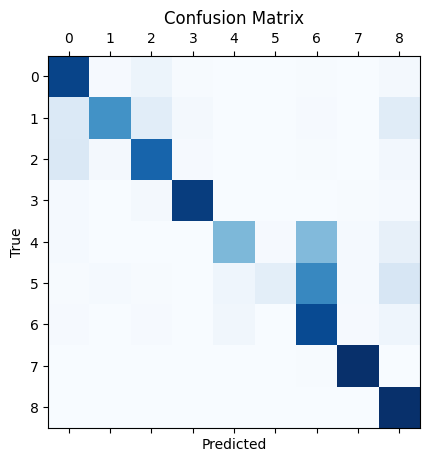

   overall_precision  overall_recall  overall_f1  overall_accuracy
0           0.778021         0.81728    0.797168          0.965543

                   LOC        MISC          ORG          PER
precision     0.739733    0.656584     0.698041     0.960883
recall        0.863909    0.525641     0.772426     0.941868
f1            0.797013    0.583861     0.733352     0.951280
number     1668.000000  702.000000  1661.000000  1617.000000

end of run
---------------------------------------------------


  0%|          | 2/835 [00:07<49:21,  3.56s/it]  

{'eval_loss': 0.13209261000156403, 'eval_precision': 0.7818672969778828, 'eval_recall': 0.8199362606232294, 'eval_f1': 0.8004493993604701, 'eval_accuracy': 0.9656939808334231, 'eval_runtime': 6.9267, 'eval_samples_per_second': 498.508, 'eval_steps_per_second': 7.796, 'epoch': 0.01}



  0%|          | 3/835 [00:14<1:09:36,  5.02s/it]

{'eval_loss': 0.13076692819595337, 'eval_precision': 0.7887514822971371, 'eval_recall': 0.8243626062322946, 'eval_f1': 0.8061639684875768, 'eval_accuracy': 0.9660600839883708, 'eval_runtime': 6.9286, 'eval_samples_per_second': 498.372, 'eval_steps_per_second': 7.794, 'epoch': 0.01}



  0%|          | 4/835 [00:21<1:20:02,  5.78s/it]

{'eval_loss': 0.1295434981584549, 'eval_precision': 0.7943527810852186, 'eval_recall': 0.8268413597733711, 'eval_f1': 0.8102715363928168, 'eval_accuracy': 0.9664046516636158, 'eval_runtime': 6.9497, 'eval_samples_per_second': 496.859, 'eval_steps_per_second': 7.77, 'epoch': 0.02}



  1%|          | 5/835 [00:28<1:26:08,  6.23s/it]

{'eval_loss': 0.12853002548217773, 'eval_precision': 0.8003760041018629, 'eval_recall': 0.8291430594900849, 'eval_f1': 0.8145056091834073, 'eval_accuracy': 0.9669215031764833, 'eval_runtime': 6.9561, 'eval_samples_per_second': 496.401, 'eval_steps_per_second': 7.763, 'epoch': 0.02}



  1%|          | 6/835 [00:35<1:29:56,  6.51s/it]

{'eval_loss': 0.12743467092514038, 'eval_precision': 0.8053840877914952, 'eval_recall': 0.8316218130311614, 'eval_f1': 0.8182926829268292, 'eval_accuracy': 0.9677183159254873, 'eval_runtime': 6.9722, 'eval_samples_per_second': 495.251, 'eval_steps_per_second': 7.745, 'epoch': 0.03}



  1%|          | 7/835 [00:42<1:32:29,  6.70s/it]

{'eval_loss': 0.12676915526390076, 'eval_precision': 0.8083491461100569, 'eval_recall': 0.8296742209631728, 'eval_f1': 0.8188728702490171, 'eval_accuracy': 0.9677613868848929, 'eval_runtime': 7.0269, 'eval_samples_per_second': 491.396, 'eval_steps_per_second': 7.685, 'epoch': 0.04}



  1%|          | 8/835 [00:49<1:34:07,  6.83s/it]

{'eval_loss': 0.12581521272659302, 'eval_precision': 0.8135858234885337, 'eval_recall': 0.8291430594900849, 'eval_f1': 0.8212907751666081, 'eval_accuracy': 0.9680198126413266, 'eval_runtime': 6.9828, 'eval_samples_per_second': 494.5, 'eval_steps_per_second': 7.733, 'epoch': 0.04}



  1%|          | 9/835 [00:56<1:35:56,  6.97s/it]

{'eval_loss': 0.1252640187740326, 'eval_precision': 0.8172959805115713, 'eval_recall': 0.8316218130311614, 'eval_f1': 0.8243966652040368, 'eval_accuracy': 0.9684074512759772, 'eval_runtime': 7.1807, 'eval_samples_per_second': 480.875, 'eval_steps_per_second': 7.52, 'epoch': 0.05}



  1%|          | 10/835 [01:04<1:37:05,  7.06s/it]

{'eval_loss': 0.12479421496391296, 'eval_precision': 0.8179286335944299, 'eval_recall': 0.8319759206798867, 'eval_f1': 0.8248924778372685, 'eval_accuracy': 0.9686443415527081, 'eval_runtime': 7.1452, 'eval_samples_per_second': 483.263, 'eval_steps_per_second': 7.558, 'epoch': 0.05}



  1%|          | 10/835 [01:11<1:37:05,  7.06s/it]

{'eval_loss': 0.1244831457734108, 'eval_precision': 0.8193211488250652, 'eval_recall': 0.8333923512747875, 'eval_f1': 0.8262968489423329, 'eval_accuracy': 0.9687950899106278, 'eval_runtime': 7.0507, 'eval_samples_per_second': 489.737, 'eval_steps_per_second': 7.659, 'epoch': 0.06}


  1%|▏         | 12/835 [01:19<1:40:41,  7.34s/it]

{'eval_loss': 0.1245981827378273, 'eval_precision': 0.8206549991335991, 'eval_recall': 0.8385269121813032, 'eval_f1': 0.8294947018127683, 'eval_accuracy': 0.9690965866264671, 'eval_runtime': 7.0513, 'eval_samples_per_second': 489.699, 'eval_steps_per_second': 7.658, 'epoch': 0.07}



  2%|▏         | 13/835 [01:26<1:39:39,  7.27s/it]

{'eval_loss': 0.12429183721542358, 'eval_precision': 0.8191875540190147, 'eval_recall': 0.8390580736543909, 'eval_f1': 0.8290037610425959, 'eval_accuracy': 0.9690750511467643, 'eval_runtime': 7.0037, 'eval_samples_per_second': 493.029, 'eval_steps_per_second': 7.71, 'epoch': 0.07}



  2%|▏         | 14/835 [01:33<1:38:47,  7.22s/it]

{'eval_loss': 0.12406980246305466, 'eval_precision': 0.8179934380935935, 'eval_recall': 0.8387039660056658, 'eval_f1': 0.8282192499344349, 'eval_accuracy': 0.9690319801873587, 'eval_runtime': 6.9868, 'eval_samples_per_second': 494.219, 'eval_steps_per_second': 7.729, 'epoch': 0.08}



  2%|▏         | 15/835 [01:40<1:38:38,  7.22s/it]

{'eval_loss': 0.12347985804080963, 'eval_precision': 0.8200966850828729, 'eval_recall': 0.8410056657223796, 'eval_f1': 0.8304195804195804, 'eval_accuracy': 0.9694411543017121, 'eval_runtime': 7.115, 'eval_samples_per_second': 485.314, 'eval_steps_per_second': 7.59, 'epoch': 0.08}



  2%|▏         | 16/835 [01:48<1:38:08,  7.19s/it]

{'eval_loss': 0.12343296408653259, 'eval_precision': 0.8178374655647382, 'eval_recall': 0.8410056657223796, 'eval_f1': 0.8292597765363129, 'eval_accuracy': 0.9692904059437923, 'eval_runtime': 7.0166, 'eval_samples_per_second': 492.121, 'eval_steps_per_second': 7.696, 'epoch': 0.09}



  2%|▏         | 17/835 [01:55<1:37:33,  7.16s/it]

{'eval_loss': 0.12398550659418106, 'eval_precision': 0.8170563961485557, 'eval_recall': 0.8413597733711048, 'eval_f1': 0.8290300069783672, 'eval_accuracy': 0.9691396575858727, 'eval_runtime': 7.0101, 'eval_samples_per_second': 492.576, 'eval_steps_per_second': 7.703, 'epoch': 0.1}



  2%|▏         | 18/835 [02:02<1:37:24,  7.15s/it]

{'eval_loss': 0.12565182149410248, 'eval_precision': 0.8107508532423208, 'eval_recall': 0.8411827195467422, 'eval_f1': 0.8256864789711504, 'eval_accuracy': 0.9690535156670614, 'eval_runtime': 7.0571, 'eval_samples_per_second': 489.297, 'eval_steps_per_second': 7.652, 'epoch': 0.1}



  2%|▏         | 19/835 [02:09<1:37:22,  7.16s/it]

{'eval_loss': 0.12660406529903412, 'eval_precision': 0.8083219645293315, 'eval_recall': 0.8392351274787535, 'eval_f1': 0.8234885337039609, 'eval_accuracy': 0.9689027673091418, 'eval_runtime': 7.0706, 'eval_samples_per_second': 488.363, 'eval_steps_per_second': 7.637, 'epoch': 0.11}



  2%|▏         | 20/835 [02:16<1:37:03,  7.15s/it]

{'eval_loss': 0.1276302933692932, 'eval_precision': 0.8034318722392116, 'eval_recall': 0.8372875354107648, 'eval_f1': 0.8200104040228888, 'eval_accuracy': 0.9684935931947884, 'eval_runtime': 7.0049, 'eval_samples_per_second': 492.941, 'eval_steps_per_second': 7.709, 'epoch': 0.11}



  2%|▏         | 20/835 [02:23<1:37:03,  7.15s/it]

{'eval_loss': 0.1279275119304657, 'eval_precision': 0.8007461421061557, 'eval_recall': 0.8360481586402266, 'eval_f1': 0.8180164573408403, 'eval_accuracy': 0.9682136319586518, 'eval_runtime': 7.011, 'eval_samples_per_second': 492.512, 'eval_steps_per_second': 7.702, 'epoch': 0.12}


  3%|▎         | 22/835 [02:32<1:40:29,  7.42s/it]

{'eval_loss': 0.12780341506004333, 'eval_precision': 0.8004069866033576, 'eval_recall': 0.8356940509915014, 'eval_f1': 0.8176699870073625, 'eval_accuracy': 0.9681705609992463, 'eval_runtime': 7.1815, 'eval_samples_per_second': 480.822, 'eval_steps_per_second': 7.519, 'epoch': 0.13}



  3%|▎         | 22/835 [02:39<1:40:29,  7.42s/it]

{'eval_loss': 0.1273556798696518, 'eval_precision': 0.8016949152542373, 'eval_recall': 0.8374645892351275, 'eval_f1': 0.8191894700381018, 'eval_accuracy': 0.9683428448368687, 'eval_runtime': 7.0047, 'eval_samples_per_second': 492.953, 'eval_steps_per_second': 7.709, 'epoch': 0.13}


  3%|▎         | 22/835 [02:39<1:38:20,  7.26s/it]

{'train_runtime': 159.666, 'train_samples_per_second': 83.518, 'train_steps_per_second': 5.23, 'train_loss': 0.09622553261843594, 'epoch': 0.13}


TrainOutput(global_step=22, training_loss=0.09622553261843594, metrics={'train_runtime': 159.666, 'train_samples_per_second': 83.518, 'train_steps_per_second': 5.23, 'train_loss': 0.09622553261843594, 'epoch': 0.13})

In [20]:
import numpy as np

for k in range(1, 20, 2):
    print("---------------------------------------------------")
    print(f"starting run on training set of {k}%")
    print()
    model = reload_model()
    dataset = load_dataset(k)
    trainer = reload_trainer(f"./logs_results/run_{k}%_data/", dataset, model)
    trainer.train()
    results = eval(trainer, dataset)
    pretty_print(results)
    print()
    print("end of run")
    print("---------------------------------------------------")

trainer.train()